# Degree-day Calculator 

## Examples for using the phthon code

Calculates the thermokarst initiation likelihood based on chosen method which can be the climate priming method, as that is the only option at this point in time. A command line tool also exists. It works using the default parameters in many cases. To see its instructions run `python ddc/utility.py --help` at the command line.



### Imports

In [1]:
from ddc.calc_degree_days import calc_grid_degree_days, create_day_array, calc_degree_days
from ddc.multigrids import tools, TemporalGrid
import os, glob
import matplotlib.pyplot as plt
import gdal
import numpy as np

from multiprocessing import Manager
from datetime import datetime

### Loading Data

The data need to be loaded in to a special grid format, from multigrids. This gird type is a wraper around the numpy memmap functionality, and was devloped as the internal data representation format for atm project. All of the grid code is in the `muligrids` sub-pakage but the only functions needed to load the data are in `ddc.multigrids.tools`

#### Important functions and classes
- `ddc.TemporalGrid`:
    This class represnets a grid of data that changes with time
- `ddc.multigrids.tools.load_and_create`:
    This load the data from a directory containing tiff files
- `ddc.multigrids.tools.get_raster_metadata`:
    This loads the raster transform, and projection from a raster dataset

#### Load Monthly Temperature data

use the `ddc.multigrids.tools.load_and_create` function to load the monthly temperature data in to a MultiGrid.

##### Parameters
- load_params: dict
        parameters used to load the data from the tiff files. Keys are as follows:
        `directory`: path to the data.
        `method`: method for loading data. This must be "tiff" 
        `file_name_structure`: File expansion pattern used by `glob.glob` to find files to load. 
        Deafaults to '*.tif'
        `sort_func`: Function to sort files. Defaults to `sorted`
        `verbose`: If True, messages are printed describing the status of the loading data. Defautls to False
        
- create_params: dict
        Keyword paramters used in multigrid.TemporalGrid creation. Only the important keys for this process are 
        shown here, for other options see the `ddc.multigrids.tools.create` documentation. Keys are as follows:
        `name`: a name for the data set
        `start_timestep`: the start year for the data


##### Load Data

First caclulate the number of years from the number of monthly files, and create the grid names used to index the data in the grid.



In [2]:
path = "../data/V1/temperature/monthly/SP/v1/tiff/"

## calculate the number of years from the number of monthly files
start_year = 1901
months = [
    '01','02','03','04','05','06',
    '07','08','09','10','11','12',
]

num_years = len(
    glob.glob(os.path.join(path,'*.tif')) 
) 
num_years = num_years // 12

years = [start_year + yr for yr in range(num_years)]


temporal_grid_keys = [] 
for yr in years: 
    for mn in months: 
        temporal_grid_keys.append(str(yr) + '-' + str(mn)) 


load_params = {
    "directory": path,
    "method": "tiff",
    "file_name_structure": '*.tif',
    "sort_func": sorted, 
    "verbose": False
}

create_params = {
    "name": "Monthly Temperature",  
    "grid_names": temporal_grid_keys
}

temperature_data = tools.load_and_create(load_params, create_params)

##### Load the raster metadata


In [3]:
raster_file = glob.glob(os.path.join(path,'*.tif'))[0]
raster_metadata = tools.get_raster_metadata(raster_file)
temperature_data.config['raster_metadata'] = raster_metadata

##### Mask out missing data

In [4]:
mask_val = -3.39999995e+38


idx = temperature_data.grids < -1000
temperature_data.grids[idx] = np.nan


# temperature_data

#### Create Empty Degree-day gridss

In [5]:
# get the shape of the gridded data
grid_shape = temperature_data.config['grid_shape']

fdd_data = TemporalGrid(
    grid_shape[0], grid_shape[1], num_years, 
    start_timestep=start_year,
    dataset_name = 'fdd',
    mode='w+'
)
tdd_data = TemporalGrid(
    grid_shape[0], grid_shape[1], num_years, 
    start_timestep=start_year,
    dataset_name = 'tdd',
    mode='w+'
)

#### Create Array of Days

create an array of days since the start of the time period to use to create spline functions to caclulate the degree days. This can be done quickly using `ddc.calc_degree_days.create_day_array` whcih take an array of datatime objects and returns an array of days.

In [6]:
days = create_day_array( 
    [datetime.strptime(d, '%Y-%m') for d in temporal_grid_keys] 
)

#### Setup Logging

Use a `multiprocessing.Manager` object to create a shared dict that is used for logging by `ddc.calc_degree_days.calc_gird_degree_days`

Set `log['verbose']` to 0, 1, or 2 to disable logging, show only warnings, or show all messages respectively

Logging is not strictly necessary, and if you don't want to use it skip this step, and dont pass the `log` argument to the  calc_grid_degree_days function.

In [7]:
manager = Manager()

log = manager.dict() 

log.update(
    {'Element Messages': manager.list() , 'Spline Errors': manager.list()}
)
log['verbose'] = 2 # 0,1,2



#### Caclulate degree days.

`ddc.calc_degree_days.calc_gird_degree_days` takes the following parameters:

    day_array: list like
        Day number for each temperature value. len(days_array) == temp_grid.shape[0].
    
    temp_grid: np.memmap
        2d memory mapped array of montly temperature values. The shape is (number_months, grid_rows*grid_columns).
        
    tdd_grid: np.memmap
        2d memory mapped array of thawing degree-day values. The shape is (number_years, grid_rows*grid_columns)
        
    fdd_grid: np.memmap
        2d memory mapped array of freezing degree-day values. The shape is (number_years, grid_rows*grid_columns)
    
    shape: tuple
        shape of model domain (grid_rows*grid_columns)
        
    start: int, defaults to 0 , or list
        Element to start calculations at. This allows calculations to be resumed if the process is interrupted
        
    num_process: int, Defaults to 1.
        Number of processes to use
    
    log: dict or dict like
        used for loging 
        
        
   The multigrid variables we created (temperature_data, tdd_data, fdd_data) in the previous steps keep their memory mapped grid data in the `.grids` attribute. This attribure keeps data in the shape (n_grids [n_timestpes in our case], n_rows*n_columns) which is already what `ddc.calc_degree_days.calc_gird_degree_days`  needs to opperate, so we can just pass the `.grids` attribute to it. This also handily stores the results in the multigrids which allows them to be easily saved in the next step


In [8]:

num_processes = 6

missing_elements = calc_grid_degree_days(
    days, 
    temperature_data.grids, 
    tdd_data.grids, 
    fdd_data.grids, 
    grid_shape, 
    num_process = num_processes,
    start=0,
    log=log
)

calculating degree days for element 0. ~0.00% complete.
Skipping element for missing values at 0
calculating degree days for element 1. ~0.00% complete.
Skipping element for missing values at 1
calculating degree days for element 2. ~0.00% complete.
Skipping element for missing values at 2
calculating degree days for element 3. ~0.00% complete.
Skipping element for missing values at 3
calculating degree days for element 4. ~0.00% complete.
Skipping element for missing values at 4
calculating degree days for element 5. ~0.01% complete.
Skipping element for missing values at 5
calculating degree days for element 6. ~0.01% complete.
Skipping element for missing values at 6
calculating degree days for element 7. ~0.01% complete.
Skipping element for missing values at 7
calculating degree days for element 8. ~0.01% complete.
Skipping element for missing values at 8
calculating degree days for element 9. ~0.01% complete.
Skipping element for missing values at 9
calculating degree days for el

Skipping element for missing values at 125
calculating degree days for element 126. ~0.13% complete.
Skipping element for missing values at 126
calculating degree days for element 127. ~0.14% complete.
Skipping element for missing values at 127
calculating degree days for element 128. ~0.14% complete.
Skipping element for missing values at 128
calculating degree days for element 129. ~0.14% complete.
Skipping element for missing values at 129
calculating degree days for element 130. ~0.14% complete.
Skipping element for missing values at 130
calculating degree days for element 131. ~0.14% complete.
Skipping element for missing values at 131
calculating degree days for element 132. ~0.14% complete.
Skipping element for missing values at 132
calculating degree days for element 133. ~0.14% complete.
Skipping element for missing values at 133
calculating degree days for element 134. ~0.14% complete.
Skipping element for missing values at 134
calculating degree days for element 135. ~0.14% 

calculating degree days for element 251. ~0.27% complete.
Skipping element for missing values at 251
calculating degree days for element 252. ~0.27% complete.
Skipping element for missing values at 252
calculating degree days for element 253. ~0.27% complete.
Skipping element for missing values at 253
calculating degree days for element 254. ~0.27% complete.
Skipping element for missing values at 254
calculating degree days for element 255. ~0.27% complete.
Skipping element for missing values at 255
calculating degree days for element 256. ~0.27% complete.
Skipping element for missing values at 256
calculating degree days for element 257. ~0.27% complete.
Skipping element for missing values at 257
calculating degree days for element 258. ~0.27% complete.
Skipping element for missing values at 258
calculating degree days for element 259. ~0.28% complete.
Skipping element for missing values at 259
calculating degree days for element 260. ~0.28% complete.
Skipping element for missing valu

Skipping element for missing values at 357
calculating degree days for element 358. ~0.38% complete.
Skipping element for missing values at 358
calculating degree days for element 359. ~0.38% complete.
Skipping element for missing values at 359
calculating degree days for element 360. ~0.38% complete.
Skipping element for missing values at 360
calculating degree days for element 361. ~0.38% complete.
Skipping element for missing values at 361
calculating degree days for element 362. ~0.39% complete.
Skipping element for missing values at 362
calculating degree days for element 363. ~0.39% complete.
Skipping element for missing values at 363
calculating degree days for element 364. ~0.39% complete.
Skipping element for missing values at 364
calculating degree days for element 365. ~0.39% complete.
Skipping element for missing values at 365
calculating degree days for element 366. ~0.39% complete.
Skipping element for missing values at 366
calculating degree days for element 367. ~0.39% 

calculating degree days for element 443. ~0.47% complete.
Skipping element for missing values at 443
calculating degree days for element 444. ~0.47% complete.
Skipping element for missing values at 444
calculating degree days for element 445. ~0.47% complete.
Skipping element for missing values at 445
calculating degree days for element 446. ~0.47% complete.
Skipping element for missing values at 446
calculating degree days for element 447. ~0.48% complete.
Skipping element for missing values at 447
calculating degree days for element 448. ~0.48% complete.
Skipping element for missing values at 448
calculating degree days for element 449. ~0.48% complete.
Skipping element for missing values at 449
calculating degree days for element 450. ~0.48% complete.
Skipping element for missing values at 450
calculating degree days for element 451. ~0.48% complete.
Skipping element for missing values at 451
calculating degree days for element 452. ~0.48% complete.
Skipping element for missing valu

calculating degree days for element 525. ~0.56% complete.
Skipping element for missing values at 525
calculating degree days for element 526. ~0.56% complete.
Skipping element for missing values at 526
calculating degree days for element 527. ~0.56% complete.
Skipping element for missing values at 527
calculating degree days for element 528. ~0.56% complete.
Skipping element for missing values at 528
calculating degree days for element 529. ~0.56% complete.
Skipping element for missing values at 529
calculating degree days for element 530. ~0.56% complete.
Skipping element for missing values at 530
calculating degree days for element 531. ~0.57% complete.
Skipping element for missing values at 531
calculating degree days for element 532. ~0.57% complete.
Skipping element for missing values at 532
calculating degree days for element 533. ~0.57% complete.
Skipping element for missing values at 533
calculating degree days for element 534. ~0.57% complete.
Skipping element for missing valu

Skipping element for missing values at 617
calculating degree days for element 618. ~0.66% complete.
Skipping element for missing values at 618
calculating degree days for element 619. ~0.66% complete.
Skipping element for missing values at 619
calculating degree days for element 620. ~0.66% complete.
Skipping element for missing values at 620
calculating degree days for element 621. ~0.66% complete.
Skipping element for missing values at 621
calculating degree days for element 622. ~0.66% complete.
Skipping element for missing values at 622
calculating degree days for element 623. ~0.66% complete.
Skipping element for missing values at 623
calculating degree days for element 624. ~0.66% complete.
Skipping element for missing values at 624
calculating degree days for element 625. ~0.67% complete.
Skipping element for missing values at 625
calculating degree days for element 626. ~0.67% complete.
Skipping element for missing values at 626
calculating degree days for element 627. ~0.67% 

calculating degree days for element 723. ~0.77% complete.
Skipping element for missing values at 723
calculating degree days for element 724. ~0.77% complete.
Skipping element for missing values at 724
calculating degree days for element 725. ~0.77% complete.
Skipping element for missing values at 725
calculating degree days for element 726. ~0.77% complete.
Skipping element for missing values at 726
calculating degree days for element 727. ~0.77% complete.
Skipping element for missing values at 727
calculating degree days for element 728. ~0.77% complete.
Skipping element for missing values at 728
calculating degree days for element 729. ~0.78% complete.
Skipping element for missing values at 729
calculating degree days for element 730. ~0.78% complete.
Skipping element for missing values at 730
calculating degree days for element 731. ~0.78% complete.
Skipping element for missing values at 731
calculating degree days for element 732. ~0.78% complete.
Skipping element for missing valu

Skipping element for missing values at 806
calculating degree days for element 807. ~0.86% complete.
Skipping element for missing values at 807
calculating degree days for element 808. ~0.86% complete.
Skipping element for missing values at 808
calculating degree days for element 809. ~0.86% complete.
Skipping element for missing values at 809
calculating degree days for element 810. ~0.86% complete.
Skipping element for missing values at 810
calculating degree days for element 811. ~0.86% complete.
Skipping element for missing values at 811
calculating degree days for element 812. ~0.86% complete.
Skipping element for missing values at 812
calculating degree days for element 813. ~0.87% complete.
Skipping element for missing values at 813
calculating degree days for element 814. ~0.87% complete.
Skipping element for missing values at 814
calculating degree days for element 815. ~0.87% complete.
Skipping element for missing values at 815
calculating degree days for element 816. ~0.87% 

Skipping element for missing values at 889
calculating degree days for element 890. ~0.95% complete.
Skipping element for missing values at 890
calculating degree days for element 891. ~0.95% complete.
Skipping element for missing values at 891
calculating degree days for element 892. ~0.95% complete.
Skipping element for missing values at 892
calculating degree days for element 893. ~0.95% complete.
Skipping element for missing values at 893
calculating degree days for element 894. ~0.95% complete.
Skipping element for missing values at 894
calculating degree days for element 895. ~0.95% complete.
Skipping element for missing values at 895
calculating degree days for element 896. ~0.95% complete.
Skipping element for missing values at 896
calculating degree days for element 897. ~0.95% complete.
Skipping element for missing values at 897
calculating degree days for element 898. ~0.96% complete.
Skipping element for missing values at 898
calculating degree days for element 899. ~0.96% 

Skipping element for missing values at 979
calculating degree days for element 980. ~1.04% complete.
Skipping element for missing values at 980
calculating degree days for element 981. ~1.04% complete.
Skipping element for missing values at 981
calculating degree days for element 982. ~1.05% complete.
Skipping element for missing values at 982
calculating degree days for element 983. ~1.05% complete.
calculating degree days for element 984. ~1.05% complete.
calculating degree days for element 985. ~1.05% complete.
calculating degree days for element 986. ~1.05% complete.
calculating degree days for element 987. ~1.05% complete.
calculating degree days for element 988. ~1.05% complete.
calculating degree days for element 989. ~1.05% complete.
calculating degree days for element 990. ~1.05% complete.
calculating degree days for element 991. ~1.05% complete.
calculating degree days for element 992. ~1.06% complete.
calculating degree days for element 993. ~1.06% complete.
calculating degr

Skipping element for missing values at 1089
calculating degree days for element 1090. ~1.16% complete.
Skipping element for missing values at 1090
calculating degree days for element 1091. ~1.16% complete.
Skipping element for missing values at 1091
calculating degree days for element 1092. ~1.16% complete.
Skipping element for missing values at 1092
calculating degree days for element 1093. ~1.16% complete.
Skipping element for missing values at 1093
calculating degree days for element 1094. ~1.16% complete.
Skipping element for missing values at 1094
calculating degree days for element 1095. ~1.17% complete.
Skipping element for missing values at 1095
calculating degree days for element 1096. ~1.17% complete.
Skipping element for missing values at 1096
calculating degree days for element 1097. ~1.17% complete.
Skipping element for missing values at 1097
calculating degree days for element 1098. ~1.17% complete.
Skipping element for missing values at 1098
calculating degree days for e

calculating degree days for element 1183. ~1.26% complete.
Skipping element for missing values at 1183
calculating degree days for element 1184. ~1.26% complete.
Skipping element for missing values at 1184
calculating degree days for element 1185. ~1.26% complete.
Skipping element for missing values at 1185
calculating degree days for element 1186. ~1.26% complete.
Skipping element for missing values at 1186
calculating degree days for element 1187. ~1.26% complete.
Skipping element for missing values at 1187
calculating degree days for element 1188. ~1.26% complete.
Skipping element for missing values at 1188
calculating degree days for element 1189. ~1.27% complete.
Skipping element for missing values at 1189
calculating degree days for element 1190. ~1.27% complete.
Skipping element for missing values at 1190
calculating degree days for element 1191. ~1.27% complete.
Skipping element for missing values at 1191
calculating degree days for element 1192. ~1.27% complete.
Skipping eleme

calculating degree days for element 1264. ~1.35% complete.
Skipping element for missing values at 1264
calculating degree days for element 1265. ~1.35% complete.
Skipping element for missing values at 1265
calculating degree days for element 1266. ~1.35% complete.
Skipping element for missing values at 1266
calculating degree days for element 1267. ~1.35% complete.
Skipping element for missing values at 1267
calculating degree days for element 1268. ~1.35% complete.
Skipping element for missing values at 1268
calculating degree days for element 1269. ~1.35% complete.
Skipping element for missing values at 1269
calculating degree days for element 1270. ~1.35% complete.
Skipping element for missing values at 1270
calculating degree days for element 1271. ~1.35% complete.
Skipping element for missing values at 1271
calculating degree days for element 1272. ~1.35% complete.
Skipping element for missing values at 1272
calculating degree days for element 1273. ~1.35% complete.
Skipping eleme

calculating degree days for element 1360. ~1.45% complete.
calculating degree days for element 1361. ~1.45% complete.
calculating degree days for element 1362. ~1.45% complete.
calculating degree days for element 1363. ~1.45% complete.
calculating degree days for element 1364. ~1.45% complete.
calculating degree days for element 1365. ~1.45% complete.
calculating degree days for element 1366. ~1.45% complete.
calculating degree days for element 1367. ~1.45% complete.
calculating degree days for element 1368. ~1.46% complete.
calculating degree days for element 1369. ~1.46% complete.
calculating degree days for element 1370. ~1.46% complete.
calculating degree days for element 1371. ~1.46% complete.
calculating degree days for element 1372. ~1.46% complete.
calculating degree days for element 1373. ~1.46% complete.
calculating degree days for element 1374. ~1.46% complete.
calculating degree days for element 1375. ~1.46% complete.
calculating degree days for element 1376. ~1.46% complet

calculating degree days for element 1454. ~1.55% complete.
Skipping element for missing values at 1454
calculating degree days for element 1455. ~1.55% complete.
Skipping element for missing values at 1455
calculating degree days for element 1456. ~1.55% complete.
Skipping element for missing values at 1456
calculating degree days for element 1457. ~1.55% complete.
Skipping element for missing values at 1457
calculating degree days for element 1458. ~1.55% complete.
Skipping element for missing values at 1458
calculating degree days for element 1459. ~1.55% complete.
Skipping element for missing values at 1459
calculating degree days for element 1460. ~1.55% complete.
Skipping element for missing values at 1460
calculating degree days for element 1461. ~1.55% complete.
Skipping element for missing values at 1461
calculating degree days for element 1462. ~1.56% complete.
Skipping element for missing values at 1462
calculating degree days for element 1463. ~1.56% complete.
Skipping eleme

Skipping element for missing values at 1544
calculating degree days for element 1545. ~1.64% complete.
Skipping element for missing values at 1545
calculating degree days for element 1546. ~1.65% complete.
Skipping element for missing values at 1546
calculating degree days for element 1547. ~1.65% complete.
Skipping element for missing values at 1547
calculating degree days for element 1548. ~1.65% complete.
Skipping element for missing values at 1548
calculating degree days for element 1549. ~1.65% complete.
Skipping element for missing values at 1549
calculating degree days for element 1550. ~1.65% complete.
Skipping element for missing values at 1550
calculating degree days for element 1551. ~1.65% complete.
Skipping element for missing values at 1551
calculating degree days for element 1552. ~1.65% complete.
Skipping element for missing values at 1552
calculating degree days for element 1553. ~1.65% complete.
Skipping element for missing values at 1553
calculating degree days for e

Skipping element for missing values at 1626
calculating degree days for element 1627. ~1.73% complete.
Skipping element for missing values at 1627
calculating degree days for element 1628. ~1.73% complete.
Skipping element for missing values at 1628
calculating degree days for element 1629. ~1.73% complete.
Skipping element for missing values at 1629
calculating degree days for element 1630. ~1.73% complete.
Skipping element for missing values at 1630
calculating degree days for element 1631. ~1.74% complete.
Skipping element for missing values at 1631
calculating degree days for element 1632. ~1.74% complete.
Skipping element for missing values at 1632
calculating degree days for element 1633. ~1.74% complete.
Skipping element for missing values at 1633
calculating degree days for element 1634. ~1.74% complete.
Skipping element for missing values at 1634
calculating degree days for element 1635. ~1.74% complete.
Skipping element for missing values at 1635
calculating degree days for e

calculating degree days for element 1716. ~1.83% complete.
calculating degree days for element 1717. ~1.83% complete.
calculating degree days for element 1718. ~1.83% complete.
calculating degree days for element 1719. ~1.83% complete.
calculating degree days for element 1720. ~1.83% complete.
calculating degree days for element 1721. ~1.83% complete.
calculating degree days for element 1722. ~1.83% complete.
calculating degree days for element 1723. ~1.83% complete.
calculating degree days for element 1724. ~1.83% complete.
calculating degree days for element 1725. ~1.84% complete.
calculating degree days for element 1726. ~1.84% complete.
calculating degree days for element 1727. ~1.84% complete.
calculating degree days for element 1728. ~1.84% complete.
calculating degree days for element 1729. ~1.84% complete.
calculating degree days for element 1730. ~1.84% complete.
calculating degree days for element 1731. ~1.84% complete.
calculating degree days for element 1732. ~1.84% complet

Skipping element for missing values at 1807
calculating degree days for element 1808. ~1.92% complete.
Skipping element for missing values at 1808
calculating degree days for element 1809. ~1.93% complete.
Skipping element for missing values at 1809
calculating degree days for element 1810. ~1.93% complete.
Skipping element for missing values at 1810
calculating degree days for element 1811. ~1.93% complete.
Skipping element for missing values at 1811
calculating degree days for element 1812. ~1.93% complete.
Skipping element for missing values at 1812
calculating degree days for element 1813. ~1.93% complete.
Skipping element for missing values at 1813
calculating degree days for element 1814. ~1.93% complete.
Skipping element for missing values at 1814
calculating degree days for element 1815. ~1.93% complete.
Skipping element for missing values at 1815
calculating degree days for element 1816. ~1.93% complete.
Skipping element for missing values at 1816
calculating degree days for e

Skipping element for missing values at 1889
calculating degree days for element 1890. ~2.01% complete.
Skipping element for missing values at 1890
calculating degree days for element 1891. ~2.01% complete.
Skipping element for missing values at 1891
calculating degree days for element 1892. ~2.01% complete.
Skipping element for missing values at 1892
calculating degree days for element 1893. ~2.01% complete.
Skipping element for missing values at 1893
calculating degree days for element 1894. ~2.02% complete.
Skipping element for missing values at 1894
calculating degree days for element 1895. ~2.02% complete.
Skipping element for missing values at 1895
calculating degree days for element 1896. ~2.02% complete.
Skipping element for missing values at 1896
calculating degree days for element 1897. ~2.02% complete.
Skipping element for missing values at 1897
calculating degree days for element 1898. ~2.02% complete.
Skipping element for missing values at 1898
calculating degree days for e

calculating degree days for element 1970. ~2.10% complete.
Skipping element for missing values at 1970
calculating degree days for element 1971. ~2.10% complete.
Skipping element for missing values at 1971
calculating degree days for element 1972. ~2.10% complete.
Skipping element for missing values at 1972
calculating degree days for element 1973. ~2.10% complete.
Skipping element for missing values at 1973
calculating degree days for element 1974. ~2.10% complete.
Skipping element for missing values at 1974
calculating degree days for element 1975. ~2.10% complete.
Skipping element for missing values at 1975
calculating degree days for element 1976. ~2.10% complete.
Skipping element for missing values at 1976
calculating degree days for element 1977. ~2.10% complete.
Skipping element for missing values at 1977
calculating degree days for element 1978. ~2.11% complete.
Skipping element for missing values at 1978
calculating degree days for element 1979. ~2.11% complete.
Skipping eleme

calculating degree days for element 2055. ~2.19% complete.
calculating degree days for element 2056. ~2.19% complete.
calculating degree days for element 2057. ~2.19% complete.
calculating degree days for element 2058. ~2.19% complete.
calculating degree days for element 2059. ~2.19% complete.
calculating degree days for element 2060. ~2.19% complete.
calculating degree days for element 2061. ~2.19% complete.
calculating degree days for element 2062. ~2.19% complete.
calculating degree days for element 2063. ~2.20% complete.
calculating degree days for element 2064. ~2.20% complete.
calculating degree days for element 2065. ~2.20% complete.
calculating degree days for element 2066. ~2.20% complete.
calculating degree days for element 2067. ~2.20% complete.
calculating degree days for element 2068. ~2.20% complete.
calculating degree days for element 2069. ~2.20% complete.
calculating degree days for element 2070. ~2.20% complete.
calculating degree days for element 2071. ~2.20% complet

calculating degree days for element 2150. ~2.29% complete.
Skipping element for missing values at 2150
calculating degree days for element 2151. ~2.29% complete.
Skipping element for missing values at 2151
calculating degree days for element 2152. ~2.29% complete.
Skipping element for missing values at 2152
calculating degree days for element 2153. ~2.29% complete.
Skipping element for missing values at 2153
calculating degree days for element 2154. ~2.29% complete.
Skipping element for missing values at 2154
calculating degree days for element 2155. ~2.29% complete.
Skipping element for missing values at 2155
calculating degree days for element 2156. ~2.29% complete.
Skipping element for missing values at 2156
calculating degree days for element 2157. ~2.30% complete.
Skipping element for missing values at 2157
calculating degree days for element 2158. ~2.30% complete.
Skipping element for missing values at 2158
calculating degree days for element 2159. ~2.30% complete.
Skipping eleme

Skipping element for missing values at 2239
calculating degree days for element 2240. ~2.38% complete.
Skipping element for missing values at 2240
calculating degree days for element 2241. ~2.39% complete.
Skipping element for missing values at 2241
calculating degree days for element 2242. ~2.39% complete.
Skipping element for missing values at 2242
calculating degree days for element 2243. ~2.39% complete.
Skipping element for missing values at 2243
calculating degree days for element 2244. ~2.39% complete.
Skipping element for missing values at 2244
calculating degree days for element 2245. ~2.39% complete.
Skipping element for missing values at 2245
calculating degree days for element 2246. ~2.39% complete.
Skipping element for missing values at 2246
calculating degree days for element 2247. ~2.39% complete.
Skipping element for missing values at 2247
calculating degree days for element 2248. ~2.39% complete.
Skipping element for missing values at 2248
calculating degree days for e

Skipping element for missing values at 2319
calculating degree days for element 2320. ~2.47% complete.
Skipping element for missing values at 2320
calculating degree days for element 2321. ~2.47% complete.
Skipping element for missing values at 2321
calculating degree days for element 2322. ~2.47% complete.
Skipping element for missing values at 2322
calculating degree days for element 2323. ~2.47% complete.
Skipping element for missing values at 2323
calculating degree days for element 2324. ~2.47% complete.
Skipping element for missing values at 2324
calculating degree days for element 2325. ~2.47% complete.
Skipping element for missing values at 2325
calculating degree days for element 2326. ~2.48% complete.
Skipping element for missing values at 2326
calculating degree days for element 2327. ~2.48% complete.
Skipping element for missing values at 2327
calculating degree days for element 2328. ~2.48% complete.
Skipping element for missing values at 2328
calculating degree days for e

calculating degree days for element 2403. ~2.56% complete.
calculating degree days for element 2404. ~2.56% complete.
calculating degree days for element 2405. ~2.56% complete.
calculating degree days for element 2406. ~2.56% complete.
calculating degree days for element 2407. ~2.56% complete.
calculating degree days for element 2408. ~2.56% complete.
calculating degree days for element 2409. ~2.56% complete.
calculating degree days for element 2410. ~2.56% complete.
calculating degree days for element 2411. ~2.57% complete.
calculating degree days for element 2412. ~2.57% complete.
calculating degree days for element 2413. ~2.57% complete.
calculating degree days for element 2414. ~2.57% complete.
calculating degree days for element 2415. ~2.57% complete.
calculating degree days for element 2416. ~2.57% complete.
calculating degree days for element 2417. ~2.57% complete.
calculating degree days for element 2418. ~2.57% complete.
calculating degree days for element 2419. ~2.57% complet

Skipping element for missing values at 2497
calculating degree days for element 2498. ~2.66% complete.
Skipping element for missing values at 2498
calculating degree days for element 2499. ~2.66% complete.
Skipping element for missing values at 2499
calculating degree days for element 2500. ~2.66% complete.
Skipping element for missing values at 2500
calculating degree days for element 2501. ~2.66% complete.
Skipping element for missing values at 2501
calculating degree days for element 2502. ~2.66% complete.
Skipping element for missing values at 2502
calculating degree days for element 2503. ~2.66% complete.
Skipping element for missing values at 2503
calculating degree days for element 2504. ~2.66% complete.
Skipping element for missing values at 2504
calculating degree days for element 2505. ~2.67% complete.
Skipping element for missing values at 2505
calculating degree days for element 2506. ~2.67% complete.
Skipping element for missing values at 2506
calculating degree days for e

calculating degree days for element 2594. ~2.76% complete.
Skipping element for missing values at 2594
calculating degree days for element 2595. ~2.76% complete.
Skipping element for missing values at 2595
calculating degree days for element 2596. ~2.76% complete.
Skipping element for missing values at 2596
calculating degree days for element 2597. ~2.76% complete.
Skipping element for missing values at 2597
calculating degree days for element 2598. ~2.77% complete.
Skipping element for missing values at 2598
calculating degree days for element 2599. ~2.77% complete.
Skipping element for missing values at 2599
calculating degree days for element 2600. ~2.77% complete.
Skipping element for missing values at 2600
calculating degree days for element 2601. ~2.77% complete.
Skipping element for missing values at 2601
calculating degree days for element 2602. ~2.77% complete.
Skipping element for missing values at 2602
calculating degree days for element 2603. ~2.77% complete.
Skipping eleme

Skipping element for missing values at 2677
calculating degree days for element 2678. ~2.85% complete.
Skipping element for missing values at 2678
calculating degree days for element 2679. ~2.85% complete.
Skipping element for missing values at 2679
calculating degree days for element 2680. ~2.85% complete.
Skipping element for missing values at 2680
calculating degree days for element 2681. ~2.85% complete.
Skipping element for missing values at 2681
calculating degree days for element 2682. ~2.85% complete.
Skipping element for missing values at 2682
calculating degree days for element 2683. ~2.86% complete.
Skipping element for missing values at 2683
calculating degree days for element 2684. ~2.86% complete.
Skipping element for missing values at 2684
calculating degree days for element 2685. ~2.86% complete.
Skipping element for missing values at 2685
calculating degree days for element 2686. ~2.86% complete.
Skipping element for missing values at 2686
calculating degree days for e

calculating degree days for element 2768. ~2.95% complete.
calculating degree days for element 2769. ~2.95% complete.
calculating degree days for element 2770. ~2.95% complete.
calculating degree days for element 2771. ~2.95% complete.
calculating degree days for element 2772. ~2.95% complete.
calculating degree days for element 2773. ~2.95% complete.
calculating degree days for element 2774. ~2.95% complete.
calculating degree days for element 2775. ~2.95% complete.
calculating degree days for element 2776. ~2.95% complete.
calculating degree days for element 2777. ~2.96% complete.
calculating degree days for element 2778. ~2.96% complete.
calculating degree days for element 2779. ~2.96% complete.
calculating degree days for element 2780. ~2.96% complete.
calculating degree days for element 2781. ~2.96% complete.
calculating degree days for element 2782. ~2.96% complete.
calculating degree days for element 2783. ~2.96% complete.
calculating degree days for element 2784. ~2.96% complet

Skipping element for missing values at 2855
calculating degree days for element 2856. ~3.04% complete.
Skipping element for missing values at 2856
calculating degree days for element 2857. ~3.04% complete.
Skipping element for missing values at 2857
calculating degree days for element 2858. ~3.04% complete.
Skipping element for missing values at 2858
calculating degree days for element 2859. ~3.04% complete.
Skipping element for missing values at 2859
calculating degree days for element 2860. ~3.04% complete.
Skipping element for missing values at 2860
calculating degree days for element 2861. ~3.04% complete.
Skipping element for missing values at 2861
calculating degree days for element 2862. ~3.05% complete.
Skipping element for missing values at 2862
calculating degree days for element 2863. ~3.05% complete.
Skipping element for missing values at 2863
calculating degree days for element 2864. ~3.05% complete.
Skipping element for missing values at 2864
calculating degree days for e

calculating degree days for element 2955. ~3.14% complete.
Skipping element for missing values at 2955
calculating degree days for element 2956. ~3.15% complete.
Skipping element for missing values at 2956
calculating degree days for element 2957. ~3.15% complete.
Skipping element for missing values at 2957
calculating degree days for element 2958. ~3.15% complete.
Skipping element for missing values at 2958
calculating degree days for element 2959. ~3.15% complete.
Skipping element for missing values at 2959
calculating degree days for element 2960. ~3.15% complete.
Skipping element for missing values at 2960
calculating degree days for element 2961. ~3.15% complete.
Skipping element for missing values at 2961
calculating degree days for element 2962. ~3.15% complete.
Skipping element for missing values at 2962
calculating degree days for element 2963. ~3.15% complete.
Skipping element for missing values at 2963
calculating degree days for element 2964. ~3.15% complete.
Skipping eleme

calculating degree days for element 3053. ~3.25% complete.
Skipping element for missing values at 3053
calculating degree days for element 3054. ~3.25% complete.
Skipping element for missing values at 3054
calculating degree days for element 3055. ~3.25% complete.
Skipping element for missing values at 3055
calculating degree days for element 3056. ~3.25% complete.
Skipping element for missing values at 3056
calculating degree days for element 3057. ~3.25% complete.
Skipping element for missing values at 3057
calculating degree days for element 3058. ~3.25% complete.
Skipping element for missing values at 3058
calculating degree days for element 3059. ~3.26% complete.
Skipping element for missing values at 3059
calculating degree days for element 3060. ~3.26% complete.
Skipping element for missing values at 3060
calculating degree days for element 3061. ~3.26% complete.
Skipping element for missing values at 3061
calculating degree days for element 3062. ~3.26% complete.
Skipping eleme

calculating degree days for element 3150. ~3.35% complete.
Skipping element for missing values at 3150
calculating degree days for element 3151. ~3.35% complete.
Skipping element for missing values at 3151
calculating degree days for element 3152. ~3.35% complete.
Skipping element for missing values at 3152
calculating degree days for element 3153. ~3.36% complete.
Skipping element for missing values at 3153
calculating degree days for element 3154. ~3.36% complete.
Skipping element for missing values at 3154
calculating degree days for element 3155. ~3.36% complete.
Skipping element for missing values at 3155
calculating degree days for element 3156. ~3.36% complete.
Skipping element for missing values at 3156
calculating degree days for element 3157. ~3.36% complete.
Skipping element for missing values at 3157
calculating degree days for element 3158. ~3.36% complete.
Skipping element for missing values at 3158
calculating degree days for element 3159. ~3.36% complete.
Skipping eleme

calculating degree days for element 3232. ~3.44% complete.
Skipping element for missing values at 3232
calculating degree days for element 3233. ~3.44% complete.
Skipping element for missing values at 3233
calculating degree days for element 3234. ~3.44% complete.
Skipping element for missing values at 3234
calculating degree days for element 3235. ~3.44% complete.
Skipping element for missing values at 3235
calculating degree days for element 3236. ~3.44% complete.
Skipping element for missing values at 3236
calculating degree days for element 3237. ~3.45% complete.
Skipping element for missing values at 3237
calculating degree days for element 3238. ~3.45% complete.
Skipping element for missing values at 3238
calculating degree days for element 3239. ~3.45% complete.
Skipping element for missing values at 3239
calculating degree days for element 3240. ~3.45% complete.
Skipping element for missing values at 3240
calculating degree days for element 3241. ~3.45% complete.
Skipping eleme

Skipping element for missing values at 3316
calculating degree days for element 3317. ~3.53% complete.
Skipping element for missing values at 3317
calculating degree days for element 3318. ~3.53% complete.
Skipping element for missing values at 3318
calculating degree days for element 3319. ~3.53% complete.
Skipping element for missing values at 3319
calculating degree days for element 3320. ~3.53% complete.
calculating degree days for element 3321. ~3.53% complete.
calculating degree days for element 3322. ~3.54% complete.
calculating degree days for element 3323. ~3.54% complete.
calculating degree days for element 3324. ~3.54% complete.
calculating degree days for element 3325. ~3.54% complete.
calculating degree days for element 3326. ~3.54% complete.
calculating degree days for element 3327. ~3.54% complete.
calculating degree days for element 3328. ~3.54% complete.
calculating degree days for element 3329. ~3.54% complete.
calculating degree days for element 3330. ~3.54% complete

Skipping element for missing values at 3412
calculating degree days for element 3413. ~3.63% complete.
Skipping element for missing values at 3413
calculating degree days for element 3414. ~3.63% complete.
Skipping element for missing values at 3414
calculating degree days for element 3415. ~3.63% complete.
Skipping element for missing values at 3415
calculating degree days for element 3416. ~3.64% complete.
Skipping element for missing values at 3416
calculating degree days for element 3417. ~3.64% complete.
Skipping element for missing values at 3417
calculating degree days for element 3418. ~3.64% complete.
Skipping element for missing values at 3418
calculating degree days for element 3419. ~3.64% complete.
Skipping element for missing values at 3419
calculating degree days for element 3420. ~3.64% complete.
Skipping element for missing values at 3420
calculating degree days for element 3421. ~3.64% complete.
Skipping element for missing values at 3421
calculating degree days for e

Skipping element for missing values at 3521
calculating degree days for element 3522. ~3.75% complete.
Skipping element for missing values at 3522
calculating degree days for element 3523. ~3.75% complete.
Skipping element for missing values at 3523
calculating degree days for element 3524. ~3.75% complete.
Skipping element for missing values at 3524
calculating degree days for element 3525. ~3.75% complete.
Skipping element for missing values at 3525
calculating degree days for element 3526. ~3.75% complete.
Skipping element for missing values at 3526
calculating degree days for element 3527. ~3.75% complete.
Skipping element for missing values at 3527
calculating degree days for element 3528. ~3.75% complete.
Skipping element for missing values at 3528
calculating degree days for element 3529. ~3.76% complete.
Skipping element for missing values at 3529
calculating degree days for element 3530. ~3.76% complete.
Skipping element for missing values at 3530
calculating degree days for e

Skipping element for missing values at 3607
calculating degree days for element 3608. ~3.84% complete.
Skipping element for missing values at 3608
calculating degree days for element 3609. ~3.84% complete.
Skipping element for missing values at 3609
calculating degree days for element 3610. ~3.84% complete.
Skipping element for missing values at 3610
calculating degree days for element 3611. ~3.84% complete.
Skipping element for missing values at 3611
calculating degree days for element 3612. ~3.84% complete.
Skipping element for missing values at 3612
calculating degree days for element 3613. ~3.85% complete.
Skipping element for missing values at 3613
calculating degree days for element 3614. ~3.85% complete.
Skipping element for missing values at 3614
calculating degree days for element 3615. ~3.85% complete.
Skipping element for missing values at 3615
calculating degree days for element 3616. ~3.85% complete.
Skipping element for missing values at 3616
calculating degree days for e

Skipping element for missing values at 3703
calculating degree days for element 3704. ~3.94% complete.
Skipping element for missing values at 3704
calculating degree days for element 3705. ~3.94% complete.
Skipping element for missing values at 3705
calculating degree days for element 3706. ~3.94% complete.
Skipping element for missing values at 3706
calculating degree days for element 3707. ~3.95% complete.
Skipping element for missing values at 3707
calculating degree days for element 3708. ~3.95% complete.
Skipping element for missing values at 3708
calculating degree days for element 3709. ~3.95% complete.
Skipping element for missing values at 3709
calculating degree days for element 3710. ~3.95% complete.
Skipping element for missing values at 3710
calculating degree days for element 3711. ~3.95% complete.
Skipping element for missing values at 3711
calculating degree days for element 3712. ~3.95% complete.
Skipping element for missing values at 3712
calculating degree days for e

Skipping element for missing values at 3785
calculating degree days for element 3786. ~4.03% complete.
Skipping element for missing values at 3786
calculating degree days for element 3787. ~4.03% complete.
Skipping element for missing values at 3787
calculating degree days for element 3788. ~4.03% complete.
Skipping element for missing values at 3788
calculating degree days for element 3789. ~4.03% complete.
Skipping element for missing values at 3789
calculating degree days for element 3790. ~4.03% complete.
Skipping element for missing values at 3790
calculating degree days for element 3791. ~4.03% complete.
Skipping element for missing values at 3791
calculating degree days for element 3792. ~4.04% complete.
Skipping element for missing values at 3792
calculating degree days for element 3793. ~4.04% complete.
Skipping element for missing values at 3793
calculating degree days for element 3794. ~4.04% complete.
calculating degree days for element 3795. ~4.04% complete.
calculating de

calculating degree days for element 3880. ~4.13% complete.
Skipping element for missing values at 3880
calculating degree days for element 3881. ~4.13% complete.
Skipping element for missing values at 3881
calculating degree days for element 3882. ~4.13% complete.
Skipping element for missing values at 3882
calculating degree days for element 3883. ~4.13% complete.
Skipping element for missing values at 3883
calculating degree days for element 3884. ~4.13% complete.
Skipping element for missing values at 3884
calculating degree days for element 3885. ~4.13% complete.
Skipping element for missing values at 3885
calculating degree days for element 3886. ~4.14% complete.
Skipping element for missing values at 3886
calculating degree days for element 3887. ~4.14% complete.
Skipping element for missing values at 3887
calculating degree days for element 3888. ~4.14% complete.
Skipping element for missing values at 3888
calculating degree days for element 3889. ~4.14% complete.
Skipping eleme

calculating degree days for element 3962. ~4.22% complete.
Skipping element for missing values at 3962
calculating degree days for element 3963. ~4.22% complete.
Skipping element for missing values at 3963
calculating degree days for element 3964. ~4.22% complete.
Skipping element for missing values at 3964
calculating degree days for element 3965. ~4.22% complete.
Skipping element for missing values at 3965
calculating degree days for element 3966. ~4.22% complete.
Skipping element for missing values at 3966
calculating degree days for element 3967. ~4.22% complete.
Skipping element for missing values at 3967
calculating degree days for element 3968. ~4.22% complete.
Skipping element for missing values at 3968
calculating degree days for element 3969. ~4.22% complete.
Skipping element for missing values at 3969
calculating degree days for element 3970. ~4.23% complete.
Skipping element for missing values at 3970
calculating degree days for element 3971. ~4.23% complete.
Skipping eleme

Skipping element for missing values at 4059
calculating degree days for element 4060. ~4.32% complete.
Skipping element for missing values at 4060
calculating degree days for element 4061. ~4.32% complete.
Skipping element for missing values at 4061
calculating degree days for element 4062. ~4.32% complete.
Skipping element for missing values at 4062
calculating degree days for element 4063. ~4.32% complete.
Skipping element for missing values at 4063
calculating degree days for element 4064. ~4.33% complete.
Skipping element for missing values at 4064
calculating degree days for element 4065. ~4.33% complete.
Skipping element for missing values at 4065
calculating degree days for element 4066. ~4.33% complete.
Skipping element for missing values at 4066
calculating degree days for element 4067. ~4.33% complete.
Skipping element for missing values at 4067
calculating degree days for element 4068. ~4.33% complete.
Skipping element for missing values at 4068
calculating degree days for e

Skipping element for missing values at 4141
calculating degree days for element 4142. ~4.41% complete.
Skipping element for missing values at 4142
calculating degree days for element 4143. ~4.41% complete.
calculating degree days for element 4144. ~4.41% complete.
calculating degree days for element 4145. ~4.41% complete.
calculating degree days for element 4146. ~4.41% complete.
calculating degree days for element 4147. ~4.41% complete.
calculating degree days for element 4148. ~4.41% complete.
calculating degree days for element 4149. ~4.42% complete.
calculating degree days for element 4150. ~4.42% complete.
calculating degree days for element 4151. ~4.42% complete.
calculating degree days for element 4152. ~4.42% complete.
calculating degree days for element 4153. ~4.42% complete.
calculating degree days for element 4154. ~4.42% complete.
calculating degree days for element 4155. ~4.42% complete.
calculating degree days for element 4156. ~4.42% complete.
calculating degree days for

calculating degree days for element 4238. ~4.51% complete.
Skipping element for missing values at 4238
calculating degree days for element 4239. ~4.51% complete.
Skipping element for missing values at 4239
calculating degree days for element 4240. ~4.51% complete.
Skipping element for missing values at 4240
calculating degree days for element 4241. ~4.51% complete.
Skipping element for missing values at 4241
calculating degree days for element 4242. ~4.51% complete.
Skipping element for missing values at 4242
calculating degree days for element 4243. ~4.52% complete.
Skipping element for missing values at 4243
calculating degree days for element 4244. ~4.52% complete.
Skipping element for missing values at 4244
calculating degree days for element 4245. ~4.52% complete.
Skipping element for missing values at 4245
calculating degree days for element 4246. ~4.52% complete.
Skipping element for missing values at 4246
calculating degree days for element 4247. ~4.52% complete.
Skipping eleme

calculating degree days for element 4320. ~4.60% complete.
Skipping element for missing values at 4320
calculating degree days for element 4321. ~4.60% complete.
Skipping element for missing values at 4321
calculating degree days for element 4322. ~4.60% complete.
Skipping element for missing values at 4322
calculating degree days for element 4323. ~4.60% complete.
Skipping element for missing values at 4323
calculating degree days for element 4324. ~4.60% complete.
Skipping element for missing values at 4324
calculating degree days for element 4325. ~4.60% complete.
Skipping element for missing values at 4325
calculating degree days for element 4326. ~4.60% complete.
Skipping element for missing values at 4326
calculating degree days for element 4327. ~4.61% complete.
Skipping element for missing values at 4327
calculating degree days for element 4328. ~4.61% complete.
Skipping element for missing values at 4328
calculating degree days for element 4329. ~4.61% complete.
Skipping eleme

calculating degree days for element 4425. ~4.71% complete.
Skipping element for missing values at 4425
calculating degree days for element 4426. ~4.71% complete.
Skipping element for missing values at 4426
calculating degree days for element 4427. ~4.71% complete.
Skipping element for missing values at 4427
calculating degree days for element 4428. ~4.71% complete.
Skipping element for missing values at 4428
calculating degree days for element 4429. ~4.71% complete.
Skipping element for missing values at 4429
calculating degree days for element 4430. ~4.71% complete.
Skipping element for missing values at 4430
calculating degree days for element 4431. ~4.72% complete.
Skipping element for missing values at 4431
calculating degree days for element 4432. ~4.72% complete.
Skipping element for missing values at 4432
calculating degree days for element 4433. ~4.72% complete.
Skipping element for missing values at 4433
calculating degree days for element 4434. ~4.72% complete.
Skipping eleme

calculating degree days for element 4517. ~4.81% complete.
calculating degree days for element 4518. ~4.81% complete.
calculating degree days for element 4519. ~4.81% complete.
calculating degree days for element 4520. ~4.81% complete.
calculating degree days for element 4521. ~4.81% complete.
calculating degree days for element 4522. ~4.81% complete.
calculating degree days for element 4523. ~4.81% complete.
calculating degree days for element 4524. ~4.81% complete.
Skipping element for missing values at 4524
calculating degree days for element 4525. ~4.82% complete.
Skipping element for missing values at 4525
calculating degree days for element 4526. ~4.82% complete.
Skipping element for missing values at 4526
calculating degree days for element 4527. ~4.82% complete.
Skipping element for missing values at 4527
calculating degree days for element 4528. ~4.82% complete.
Skipping element for missing values at 4528
calculating degree days for element 4529. ~4.82% complete.
Skipping elem

Skipping element for missing values at 4609
calculating degree days for element 4610. ~4.91% complete.
Skipping element for missing values at 4610
calculating degree days for element 4611. ~4.91% complete.
Skipping element for missing values at 4611
calculating degree days for element 4612. ~4.91% complete.
Skipping element for missing values at 4612
calculating degree days for element 4613. ~4.91% complete.
Skipping element for missing values at 4613
calculating degree days for element 4614. ~4.91% complete.
Skipping element for missing values at 4614
calculating degree days for element 4615. ~4.91% complete.
Skipping element for missing values at 4615
calculating degree days for element 4616. ~4.91% complete.
Skipping element for missing values at 4616
calculating degree days for element 4617. ~4.91% complete.
Skipping element for missing values at 4617
calculating degree days for element 4618. ~4.91% complete.
Skipping element for missing values at 4618
calculating degree days for e

calculating degree days for element 4694. ~5.00% complete.
calculating degree days for element 4695. ~5.00% complete.
calculating degree days for element 4696. ~5.00% complete.
calculating degree days for element 4697. ~5.00% complete.
calculating degree days for element 4698. ~5.00% complete.
calculating degree days for element 4699. ~5.00% complete.
calculating degree days for element 4700. ~5.00% complete.
calculating degree days for element 4701. ~5.00% complete.
calculating degree days for element 4702. ~5.00% complete.
calculating degree days for element 4703. ~5.01% complete.
calculating degree days for element 4704. ~5.01% complete.
calculating degree days for element 4705. ~5.01% complete.
calculating degree days for element 4706. ~5.01% complete.
calculating degree days for element 4707. ~5.01% complete.
calculating degree days for element 4708. ~5.01% complete.
calculating degree days for element 4709. ~5.01% complete.
calculating degree days for element 4710. ~5.01% complet

Skipping element for missing values at 4802
calculating degree days for element 4803. ~5.11% complete.
Skipping element for missing values at 4803
calculating degree days for element 4804. ~5.11% complete.
Skipping element for missing values at 4804
calculating degree days for element 4805. ~5.11% complete.
Skipping element for missing values at 4805
calculating degree days for element 4806. ~5.11% complete.
Skipping element for missing values at 4806
calculating degree days for element 4807. ~5.12% complete.
Skipping element for missing values at 4807
calculating degree days for element 4808. ~5.12% complete.
Skipping element for missing values at 4808
calculating degree days for element 4809. ~5.12% complete.
Skipping element for missing values at 4809
calculating degree days for element 4810. ~5.12% complete.
Skipping element for missing values at 4810
calculating degree days for element 4811. ~5.12% complete.
Skipping element for missing values at 4811
calculating degree days for e

calculating degree days for element 4899. ~5.21% complete.
Skipping element for missing values at 4899
calculating degree days for element 4900. ~5.21% complete.
Skipping element for missing values at 4900
calculating degree days for element 4901. ~5.22% complete.
Skipping element for missing values at 4901
calculating degree days for element 4902. ~5.22% complete.
Skipping element for missing values at 4902
calculating degree days for element 4903. ~5.22% complete.
Skipping element for missing values at 4903
calculating degree days for element 4904. ~5.22% complete.
Skipping element for missing values at 4904
calculating degree days for element 4905. ~5.22% complete.
Skipping element for missing values at 4905
calculating degree days for element 4906. ~5.22% complete.
Skipping element for missing values at 4906
calculating degree days for element 4907. ~5.22% complete.
Skipping element for missing values at 4907
calculating degree days for element 4908. ~5.22% complete.
Skipping eleme

calculating degree days for element 4979. ~5.30% complete.
Skipping element for missing values at 4979
calculating degree days for element 4980. ~5.30% complete.
Skipping element for missing values at 4980
calculating degree days for element 4981. ~5.30% complete.
Skipping element for missing values at 4981
calculating degree days for element 4982. ~5.30% complete.
Skipping element for missing values at 4982
calculating degree days for element 4983. ~5.30% complete.
Skipping element for missing values at 4983
calculating degree days for element 4984. ~5.30% complete.
Skipping element for missing values at 4984
calculating degree days for element 4985. ~5.31% complete.
Skipping element for missing values at 4985
calculating degree days for element 4986. ~5.31% complete.
Skipping element for missing values at 4986
calculating degree days for element 4987. ~5.31% complete.
Skipping element for missing values at 4987
calculating degree days for element 4988. ~5.31% complete.
Skipping eleme

calculating degree days for element 5074. ~5.40% complete.
calculating degree days for element 5075. ~5.40% complete.
calculating degree days for element 5076. ~5.40% complete.
calculating degree days for element 5077. ~5.40% complete.
calculating degree days for element 5078. ~5.40% complete.
calculating degree days for element 5079. ~5.41% complete.
calculating degree days for element 5080. ~5.41% complete.
calculating degree days for element 5081. ~5.41% complete.
calculating degree days for element 5082. ~5.41% complete.
calculating degree days for element 5083. ~5.41% complete.
calculating degree days for element 5084. ~5.41% complete.
calculating degree days for element 5085. ~5.41% complete.
calculating degree days for element 5086. ~5.41% complete.
calculating degree days for element 5087. ~5.41% complete.
calculating degree days for element 5088. ~5.42% complete.
calculating degree days for element 5089. ~5.42% complete.
calculating degree days for element 5090. ~5.42% complet

Skipping element for missing values at 5167
calculating degree days for element 5168. ~5.50% complete.
Skipping element for missing values at 5168
calculating degree days for element 5169. ~5.50% complete.
Skipping element for missing values at 5169
calculating degree days for element 5170. ~5.50% complete.
Skipping element for missing values at 5170
calculating degree days for element 5171. ~5.50% complete.
Skipping element for missing values at 5171
calculating degree days for element 5172. ~5.50% complete.
Skipping element for missing values at 5172
calculating degree days for element 5173. ~5.51% complete.
Skipping element for missing values at 5173
calculating degree days for element 5174. ~5.51% complete.
calculating degree days for element 5175. ~5.51% complete.
calculating degree days for element 5176. ~5.51% complete.
Skipping element for missing values at 5176
calculating degree days for element 5177. ~5.51% complete.
Skipping element for missing values at 5177
calculating de

Skipping element for missing values at 5272
calculating degree days for element 5273. ~5.61% complete.
Skipping element for missing values at 5273
calculating degree days for element 5274. ~5.61% complete.
Skipping element for missing values at 5274
calculating degree days for element 5275. ~5.61% complete.
Skipping element for missing values at 5275
calculating degree days for element 5276. ~5.62% complete.
Skipping element for missing values at 5276
calculating degree days for element 5277. ~5.62% complete.
Skipping element for missing values at 5277
calculating degree days for element 5278. ~5.62% complete.
Skipping element for missing values at 5278
calculating degree days for element 5279. ~5.62% complete.
Skipping element for missing values at 5279
calculating degree days for element 5280. ~5.62% complete.
Skipping element for missing values at 5280
calculating degree days for element 5281. ~5.62% complete.
Skipping element for missing values at 5281
calculating degree days for e

calculating degree days for element 5357. ~5.70% complete.
Skipping element for missing values at 5357
calculating degree days for element 5358. ~5.70% complete.
Skipping element for missing values at 5358
calculating degree days for element 5359. ~5.70% complete.
Skipping element for missing values at 5359
calculating degree days for element 5360. ~5.70% complete.
Skipping element for missing values at 5360
calculating degree days for element 5361. ~5.71% complete.
Skipping element for missing values at 5361
calculating degree days for element 5362. ~5.71% complete.
Skipping element for missing values at 5362
calculating degree days for element 5363. ~5.71% complete.
Skipping element for missing values at 5363
calculating degree days for element 5364. ~5.71% complete.
Skipping element for missing values at 5364
calculating degree days for element 5365. ~5.71% complete.
Skipping element for missing values at 5365
calculating degree days for element 5366. ~5.71% complete.
Skipping eleme

Skipping element for missing values at 5469
calculating degree days for element 5470. ~5.82% complete.
Skipping element for missing values at 5470
calculating degree days for element 5471. ~5.82% complete.
Skipping element for missing values at 5471
calculating degree days for element 5472. ~5.82% complete.
Skipping element for missing values at 5472
calculating degree days for element 5473. ~5.82% complete.
Skipping element for missing values at 5473
calculating degree days for element 5474. ~5.83% complete.
Skipping element for missing values at 5474
calculating degree days for element 5475. ~5.83% complete.
Skipping element for missing values at 5475
calculating degree days for element 5476. ~5.83% complete.
Skipping element for missing values at 5476
calculating degree days for element 5477. ~5.83% complete.
Skipping element for missing values at 5477
calculating degree days for element 5478. ~5.83% complete.
Skipping element for missing values at 5478
calculating degree days for e

calculating degree days for element 5560. ~5.92% complete.
calculating degree days for element 5561. ~5.92% complete.
calculating degree days for element 5562. ~5.92% complete.
calculating degree days for element 5563. ~5.92% complete.
calculating degree days for element 5564. ~5.92% complete.
calculating degree days for element 5565. ~5.92% complete.
calculating degree days for element 5566. ~5.92% complete.
calculating degree days for element 5567. ~5.92% complete.
calculating degree days for element 5568. ~5.93% complete.
Skipping element for missing values at 5568
calculating degree days for element 5569. ~5.93% complete.
Skipping element for missing values at 5569
calculating degree days for element 5570. ~5.93% complete.
Skipping element for missing values at 5570
calculating degree days for element 5571. ~5.93% complete.
Skipping element for missing values at 5571
calculating degree days for element 5572. ~5.93% complete.
Skipping element for missing values at 5572
calculating d

calculating degree days for element 5643. ~6.01% complete.
Skipping element for missing values at 5643
calculating degree days for element 5644. ~6.01% complete.
Skipping element for missing values at 5644
calculating degree days for element 5645. ~6.01% complete.
Skipping element for missing values at 5645
calculating degree days for element 5646. ~6.01% complete.
Skipping element for missing values at 5646
calculating degree days for element 5647. ~6.01% complete.
Skipping element for missing values at 5647
calculating degree days for element 5648. ~6.01% complete.
Skipping element for missing values at 5648
calculating degree days for element 5649. ~6.01% complete.
Skipping element for missing values at 5649
calculating degree days for element 5650. ~6.01% complete.
Skipping element for missing values at 5650
calculating degree days for element 5651. ~6.01% complete.
Skipping element for missing values at 5651
calculating degree days for element 5652. ~6.02% complete.
Skipping eleme

calculating degree days for element 5729. ~6.10% complete.
calculating degree days for element 5730. ~6.10% complete.
calculating degree days for element 5731. ~6.10% complete.
calculating degree days for element 5732. ~6.10% complete.
calculating degree days for element 5733. ~6.10% complete.
calculating degree days for element 5734. ~6.10% complete.
calculating degree days for element 5735. ~6.10% complete.
calculating degree days for element 5736. ~6.10% complete.
calculating degree days for element 5737. ~6.11% complete.
calculating degree days for element 5738. ~6.11% complete.
calculating degree days for element 5739. ~6.11% complete.
calculating degree days for element 5740. ~6.11% complete.
calculating degree days for element 5741. ~6.11% complete.
calculating degree days for element 5742. ~6.11% complete.
calculating degree days for element 5743. ~6.11% complete.
calculating degree days for element 5744. ~6.11% complete.
calculating degree days for element 5745. ~6.11% complet

Skipping element for missing values at 5845
calculating degree days for element 5846. ~6.22% complete.
Skipping element for missing values at 5846
calculating degree days for element 5847. ~6.22% complete.
Skipping element for missing values at 5847
calculating degree days for element 5848. ~6.22% complete.
Skipping element for missing values at 5848
calculating degree days for element 5849. ~6.22% complete.
Skipping element for missing values at 5849
calculating degree days for element 5850. ~6.23% complete.
Skipping element for missing values at 5850
calculating degree days for element 5851. ~6.23% complete.
Skipping element for missing values at 5851
calculating degree days for element 5852. ~6.23% complete.
Skipping element for missing values at 5852
calculating degree days for element 5853. ~6.23% complete.
Skipping element for missing values at 5853
calculating degree days for element 5854. ~6.23% complete.
Skipping element for missing values at 5854
calculating degree days for e

Skipping element for missing values at 5942
calculating degree days for element 5943. ~6.33% complete.
Skipping element for missing values at 5943
calculating degree days for element 5944. ~6.33% complete.
Skipping element for missing values at 5944
calculating degree days for element 5945. ~6.33% complete.
Skipping element for missing values at 5945
calculating degree days for element 5946. ~6.33% complete.
Skipping element for missing values at 5946
calculating degree days for element 5947. ~6.33% complete.
Skipping element for missing values at 5947
calculating degree days for element 5948. ~6.33% complete.
Skipping element for missing values at 5948
calculating degree days for element 5949. ~6.33% complete.
Skipping element for missing values at 5949
calculating degree days for element 5950. ~6.33% complete.
Skipping element for missing values at 5950
calculating degree days for element 5951. ~6.33% complete.
Skipping element for missing values at 5951
calculating degree days for e

calculating degree days for element 6037. ~6.43% complete.
Skipping element for missing values at 6037
calculating degree days for element 6038. ~6.43% complete.
Skipping element for missing values at 6038
calculating degree days for element 6039. ~6.43% complete.
Skipping element for missing values at 6039
calculating degree days for element 6040. ~6.43% complete.
Skipping element for missing values at 6040
calculating degree days for element 6041. ~6.43% complete.
Skipping element for missing values at 6041
calculating degree days for element 6042. ~6.43% complete.
Skipping element for missing values at 6042
calculating degree days for element 6043. ~6.43% complete.
Skipping element for missing values at 6043
calculating degree days for element 6044. ~6.43% complete.
Skipping element for missing values at 6044
calculating degree days for element 6045. ~6.43% complete.
Skipping element for missing values at 6045
calculating degree days for element 6046. ~6.43% complete.
Skipping eleme

calculating degree days for element 6149. ~6.54% complete.
Skipping element for missing values at 6149
calculating degree days for element 6150. ~6.55% complete.
Skipping element for missing values at 6150
calculating degree days for element 6151. ~6.55% complete.
Skipping element for missing values at 6151
calculating degree days for element 6152. ~6.55% complete.
Skipping element for missing values at 6152
calculating degree days for element 6153. ~6.55% complete.
Skipping element for missing values at 6153
calculating degree days for element 6154. ~6.55% complete.
Skipping element for missing values at 6154
calculating degree days for element 6155. ~6.55% complete.
Skipping element for missing values at 6155
calculating degree days for element 6156. ~6.55% complete.
Skipping element for missing values at 6156
calculating degree days for element 6157. ~6.55% complete.
Skipping element for missing values at 6157
calculating degree days for element 6158. ~6.55% complete.
Skipping eleme

Skipping element for missing values at 6230
calculating degree days for element 6231. ~6.63% complete.
Skipping element for missing values at 6231
calculating degree days for element 6232. ~6.63% complete.
Skipping element for missing values at 6232
calculating degree days for element 6233. ~6.63% complete.
Skipping element for missing values at 6233
calculating degree days for element 6234. ~6.63% complete.
Skipping element for missing values at 6234
calculating degree days for element 6235. ~6.64% complete.
calculating degree days for element 6236. ~6.64% complete.
calculating degree days for element 6237. ~6.64% complete.
calculating degree days for element 6238. ~6.64% complete.
calculating degree days for element 6239. ~6.64% complete.
calculating degree days for element 6240. ~6.64% complete.
calculating degree days for element 6241. ~6.64% complete.
calculating degree days for element 6242. ~6.64% complete.
calculating degree days for element 6243. ~6.64% complete.
calculating d

Skipping element for missing values at 6332
calculating degree days for element 6333. ~6.74% complete.
Skipping element for missing values at 6333
calculating degree days for element 6334. ~6.74% complete.
Skipping element for missing values at 6334
calculating degree days for element 6335. ~6.74% complete.
Skipping element for missing values at 6335
calculating degree days for element 6336. ~6.74% complete.
Skipping element for missing values at 6336
calculating degree days for element 6337. ~6.74% complete.
Skipping element for missing values at 6337
calculating degree days for element 6338. ~6.75% complete.
Skipping element for missing values at 6338
calculating degree days for element 6339. ~6.75% complete.
Skipping element for missing values at 6339
calculating degree days for element 6340. ~6.75% complete.
Skipping element for missing values at 6340
calculating degree days for element 6341. ~6.75% complete.
Skipping element for missing values at 6341
calculating degree days for e

calculating degree days for element 6418. ~6.83% complete.
calculating degree days for element 6419. ~6.83% complete.
Skipping element for missing values at 6419
calculating degree days for element 6420. ~6.83% complete.
calculating degree days for element 6421. ~6.83% complete.
calculating degree days for element 6422. ~6.83% complete.
calculating degree days for element 6423. ~6.84% complete.
calculating degree days for element 6424. ~6.84% complete.
calculating degree days for element 6425. ~6.84% complete.
calculating degree days for element 6426. ~6.84% complete.
calculating degree days for element 6427. ~6.84% complete.
calculating degree days for element 6428. ~6.84% complete.
calculating degree days for element 6429. ~6.84% complete.
calculating degree days for element 6430. ~6.84% complete.
calculating degree days for element 6431. ~6.84% complete.
calculating degree days for element 6432. ~6.85% complete.
calculating degree days for element 6433. ~6.85% complete.
calculating 

Skipping element for missing values at 6535
calculating degree days for element 6536. ~6.96% complete.
Skipping element for missing values at 6536
calculating degree days for element 6537. ~6.96% complete.
Skipping element for missing values at 6537
calculating degree days for element 6538. ~6.96% complete.
Skipping element for missing values at 6538
calculating degree days for element 6539. ~6.96% complete.
Skipping element for missing values at 6539
calculating degree days for element 6540. ~6.96% complete.
Skipping element for missing values at 6540
calculating degree days for element 6541. ~6.96% complete.
Skipping element for missing values at 6541
calculating degree days for element 6542. ~6.96% complete.
Skipping element for missing values at 6542
calculating degree days for element 6543. ~6.96% complete.
Skipping element for missing values at 6543
calculating degree days for element 6544. ~6.96% complete.
Skipping element for missing values at 6544
calculating degree days for e

Skipping element for missing values at 6630
calculating degree days for element 6631. ~7.06% complete.
Skipping element for missing values at 6631
calculating degree days for element 6632. ~7.06% complete.
Skipping element for missing values at 6632
calculating degree days for element 6633. ~7.06% complete.
Skipping element for missing values at 6633
calculating degree days for element 6634. ~7.06% complete.
Skipping element for missing values at 6634
calculating degree days for element 6635. ~7.06% complete.
Skipping element for missing values at 6635
calculating degree days for element 6636. ~7.06% complete.
Skipping element for missing values at 6636
calculating degree days for element 6637. ~7.06% complete.
Skipping element for missing values at 6637
calculating degree days for element 6638. ~7.06% complete.
Skipping element for missing values at 6638
calculating degree days for element 6639. ~7.07% complete.
Skipping element for missing values at 6639
calculating degree days for e

Skipping element for missing values at 6715
calculating degree days for element 6716. ~7.15% complete.
Skipping element for missing values at 6716
calculating degree days for element 6717. ~7.15% complete.
Skipping element for missing values at 6717
calculating degree days for element 6718. ~7.15% complete.
Skipping element for missing values at 6718
calculating degree days for element 6719. ~7.15% complete.
Skipping element for missing values at 6719
calculating degree days for element 6720. ~7.15% complete.
Skipping element for missing values at 6720
calculating degree days for element 6721. ~7.15% complete.
Skipping element for missing values at 6721
calculating degree days for element 6722. ~7.15% complete.
Skipping element for missing values at 6722
calculating degree days for element 6723. ~7.16% complete.
Skipping element for missing values at 6723
calculating degree days for element 6724. ~7.16% complete.
Skipping element for missing values at 6724
calculating degree days for e

calculating degree days for element 6820. ~7.26% complete.
calculating degree days for element 6821. ~7.26% complete.
calculating degree days for element 6822. ~7.26% complete.
calculating degree days for element 6823. ~7.26% complete.
calculating degree days for element 6824. ~7.26% complete.
calculating degree days for element 6825. ~7.26% complete.
calculating degree days for element 6826. ~7.26% complete.
calculating degree days for element 6827. ~7.27% complete.
calculating degree days for element 6828. ~7.27% complete.
calculating degree days for element 6829. ~7.27% complete.
calculating degree days for element 6830. ~7.27% complete.
calculating degree days for element 6831. ~7.27% complete.
calculating degree days for element 6832. ~7.27% complete.
calculating degree days for element 6833. ~7.27% complete.
calculating degree days for element 6834. ~7.27% complete.
calculating degree days for element 6835. ~7.27% complete.
calculating degree days for element 6836. ~7.28% complet

calculating degree days for element 6916. ~7.36% complete.
calculating degree days for element 6917. ~7.36% complete.
calculating degree days for element 6918. ~7.36% complete.
calculating degree days for element 6919. ~7.36% complete.
Skipping element for missing values at 6919
calculating degree days for element 6920. ~7.36% complete.
Skipping element for missing values at 6920
calculating degree days for element 6921. ~7.37% complete.
Skipping element for missing values at 6921
calculating degree days for element 6922. ~7.37% complete.
Skipping element for missing values at 6922
calculating degree days for element 6923. ~7.37% complete.
Skipping element for missing values at 6923
calculating degree days for element 6924. ~7.37% complete.
Skipping element for missing values at 6924
calculating degree days for element 6925. ~7.37% complete.
Skipping element for missing values at 6925
calculating degree days for element 6926. ~7.37% complete.
Skipping element for missing values at 6926

Skipping element for missing values at 7013
calculating degree days for element 7014. ~7.46% complete.
Skipping element for missing values at 7014
calculating degree days for element 7015. ~7.47% complete.
Skipping element for missing values at 7015
calculating degree days for element 7016. ~7.47% complete.
Skipping element for missing values at 7016
calculating degree days for element 7017. ~7.47% complete.
Skipping element for missing values at 7017
calculating degree days for element 7018. ~7.47% complete.
Skipping element for missing values at 7018
calculating degree days for element 7019. ~7.47% complete.
Skipping element for missing values at 7019
calculating degree days for element 7020. ~7.47% complete.
Skipping element for missing values at 7020
calculating degree days for element 7021. ~7.47% complete.
Skipping element for missing values at 7021
calculating degree days for element 7022. ~7.47% complete.
Skipping element for missing values at 7022
calculating degree days for e

Skipping element for missing values at 7097
calculating degree days for element 7098. ~7.55% complete.
Skipping element for missing values at 7098
calculating degree days for element 7099. ~7.56% complete.
Skipping element for missing values at 7099
calculating degree days for element 7100. ~7.56% complete.
Skipping element for missing values at 7100
calculating degree days for element 7101. ~7.56% complete.
Skipping element for missing values at 7101
calculating degree days for element 7102. ~7.56% complete.
Skipping element for missing values at 7102
calculating degree days for element 7103. ~7.56% complete.
Skipping element for missing values at 7103
calculating degree days for element 7104. ~7.56% complete.
Skipping element for missing values at 7104
calculating degree days for element 7105. ~7.56% complete.
Skipping element for missing values at 7105
calculating degree days for element 7106. ~7.56% complete.
Skipping element for missing values at 7106
calculating degree days for e

calculating degree days for element 7217. ~7.68% complete.
Skipping element for missing values at 7217
calculating degree days for element 7218. ~7.68% complete.
Skipping element for missing values at 7218
calculating degree days for element 7219. ~7.68% complete.
Skipping element for missing values at 7219
calculating degree days for element 7220. ~7.68% complete.
Skipping element for missing values at 7220
calculating degree days for element 7221. ~7.69% complete.
Skipping element for missing values at 7221
calculating degree days for element 7222. ~7.69% complete.
Skipping element for missing values at 7222
calculating degree days for element 7223. ~7.69% complete.
Skipping element for missing values at 7223
calculating degree days for element 7224. ~7.69% complete.
Skipping element for missing values at 7224
calculating degree days for element 7225. ~7.69% complete.
Skipping element for missing values at 7225
calculating degree days for element 7226. ~7.69% complete.
Skipping eleme

calculating degree days for element 7320. ~7.79% complete.
Skipping element for missing values at 7320
calculating degree days for element 7321. ~7.79% complete.
Skipping element for missing values at 7321
calculating degree days for element 7322. ~7.79% complete.
Skipping element for missing values at 7322
calculating degree days for element 7323. ~7.79% complete.
Skipping element for missing values at 7323
calculating degree days for element 7324. ~7.79% complete.
Skipping element for missing values at 7324
calculating degree days for element 7325. ~7.80% complete.
Skipping element for missing values at 7325
calculating degree days for element 7326. ~7.80% complete.
Skipping element for missing values at 7326
calculating degree days for element 7327. ~7.80% complete.
Skipping element for missing values at 7327
calculating degree days for element 7328. ~7.80% complete.
Skipping element for missing values at 7328
calculating degree days for element 7329. ~7.80% complete.
Skipping eleme

Skipping element for missing values at 7404
calculating degree days for element 7405. ~7.88% complete.
Skipping element for missing values at 7405
calculating degree days for element 7406. ~7.88% complete.
Skipping element for missing values at 7406
calculating degree days for element 7407. ~7.88% complete.
Skipping element for missing values at 7407
calculating degree days for element 7408. ~7.88% complete.
Skipping element for missing values at 7408
calculating degree days for element 7409. ~7.89% complete.
Skipping element for missing values at 7409
calculating degree days for element 7410. ~7.89% complete.
Skipping element for missing values at 7410
calculating degree days for element 7411. ~7.89% complete.
Skipping element for missing values at 7411
calculating degree days for element 7412. ~7.89% complete.
Skipping element for missing values at 7412
calculating degree days for element 7413. ~7.89% complete.
Skipping element for missing values at 7413
calculating degree days for e

calculating degree days for element 7508. ~7.99% complete.
calculating degree days for element 7509. ~7.99% complete.
calculating degree days for element 7510. ~7.99% complete.
calculating degree days for element 7511. ~7.99% complete.
calculating degree days for element 7512. ~7.99% complete.
calculating degree days for element 7513. ~8.00% complete.
calculating degree days for element 7514. ~8.00% complete.
calculating degree days for element 7515. ~8.00% complete.
calculating degree days for element 7516. ~8.00% complete.
calculating degree days for element 7517. ~8.00% complete.
calculating degree days for element 7518. ~8.00% complete.
calculating degree days for element 7519. ~8.00% complete.
calculating degree days for element 7520. ~8.00% complete.
calculating degree days for element 7521. ~8.00% complete.
calculating degree days for element 7522. ~8.01% complete.
calculating degree days for element 7523. ~8.01% complete.
calculating degree days for element 7524. ~8.01% complet

Skipping element for missing values at 7606
calculating degree days for element 7607. ~8.10% complete.
Skipping element for missing values at 7607
calculating degree days for element 7608. ~8.10% complete.
Skipping element for missing values at 7608
calculating degree days for element 7609. ~8.10% complete.
Skipping element for missing values at 7609
calculating degree days for element 7610. ~8.10% complete.
Skipping element for missing values at 7610
calculating degree days for element 7611. ~8.10% complete.
Skipping element for missing values at 7611
calculating degree days for element 7612. ~8.10% complete.
Skipping element for missing values at 7612
calculating degree days for element 7613. ~8.10% complete.
calculating degree days for element 7614. ~8.10% complete.
calculating degree days for element 7615. ~8.10% complete.
calculating degree days for element 7616. ~8.11% complete.
Skipping element for missing values at 7616
calculating degree days for element 7617. ~8.11% complete.

calculating degree days for element 7701. ~8.20% complete.
Skipping element for missing values at 7701
calculating degree days for element 7702. ~8.20% complete.
Skipping element for missing values at 7702
calculating degree days for element 7703. ~8.20% complete.
Skipping element for missing values at 7703
calculating degree days for element 7704. ~8.20% complete.
Skipping element for missing values at 7704
calculating degree days for element 7705. ~8.20% complete.
Skipping element for missing values at 7705
calculating degree days for element 7706. ~8.20% complete.
Skipping element for missing values at 7706
calculating degree days for element 7707. ~8.20% complete.
Skipping element for missing values at 7707
calculating degree days for element 7708. ~8.20% complete.
Skipping element for missing values at 7708
calculating degree days for element 7709. ~8.20% complete.
Skipping element for missing values at 7709
calculating degree days for element 7710. ~8.21% complete.
Skipping eleme

calculating degree days for element 7791. ~8.29% complete.
Skipping element for missing values at 7791
calculating degree days for element 7792. ~8.29% complete.
Skipping element for missing values at 7792
calculating degree days for element 7793. ~8.29% complete.
Skipping element for missing values at 7793
calculating degree days for element 7794. ~8.30% complete.
Skipping element for missing values at 7794
calculating degree days for element 7795. ~8.30% complete.
Skipping element for missing values at 7795
calculating degree days for element 7796. ~8.30% complete.
calculating degree days for element 7797. ~8.30% complete.
calculating degree days for element 7798. ~8.30% complete.
Skipping element for missing values at 7798
calculating degree days for element 7799. ~8.30% complete.
calculating degree days for element 7800. ~8.30% complete.
calculating degree days for element 7801. ~8.30% complete.
calculating degree days for element 7802. ~8.30% complete.
calculating degree days for 

calculating degree days for element 7907. ~8.42% complete.
Skipping element for missing values at 7907
calculating degree days for element 7908. ~8.42% complete.
Skipping element for missing values at 7908
calculating degree days for element 7909. ~8.42% complete.
Skipping element for missing values at 7909
calculating degree days for element 7910. ~8.42% complete.
Skipping element for missing values at 7910
calculating degree days for element 7911. ~8.42% complete.
Skipping element for missing values at 7911
calculating degree days for element 7912. ~8.42% complete.
Skipping element for missing values at 7912
calculating degree days for element 7913. ~8.42% complete.
Skipping element for missing values at 7913
calculating degree days for element 7914. ~8.42% complete.
Skipping element for missing values at 7914
calculating degree days for element 7915. ~8.42% complete.
Skipping element for missing values at 7915
calculating degree days for element 7916. ~8.42% complete.
Skipping eleme

calculating degree days for element 7993. ~8.51% complete.
calculating degree days for element 7994. ~8.51% complete.
calculating degree days for element 7995. ~8.51% complete.
calculating degree days for element 7996. ~8.51% complete.
calculating degree days for element 7997. ~8.51% complete.
calculating degree days for element 7998. ~8.51% complete.
Skipping element for missing values at 7998
calculating degree days for element 7999. ~8.51% complete.
Skipping element for missing values at 7999
calculating degree days for element 8000. ~8.51% complete.
Skipping element for missing values at 8000
calculating degree days for element 8001. ~8.52% complete.
Skipping element for missing values at 8001
calculating degree days for element 8002. ~8.52% complete.
Skipping element for missing values at 8002
calculating degree days for element 8003. ~8.52% complete.
Skipping element for missing values at 8003
calculating degree days for element 8004. ~8.52% complete.
Skipping element for missing

calculating degree days for element 8086. ~8.61% complete.
Skipping element for missing values at 8086
calculating degree days for element 8087. ~8.61% complete.
Skipping element for missing values at 8087
calculating degree days for element 8088. ~8.61% complete.
Skipping element for missing values at 8088
calculating degree days for element 8089. ~8.61% complete.
Skipping element for missing values at 8089
calculating degree days for element 8090. ~8.61% complete.
Skipping element for missing values at 8090
calculating degree days for element 8091. ~8.61% complete.
Skipping element for missing values at 8091
calculating degree days for element 8092. ~8.61% complete.
Skipping element for missing values at 8092
calculating degree days for element 8093. ~8.61% complete.
Skipping element for missing values at 8093
calculating degree days for element 8094. ~8.61% complete.
Skipping element for missing values at 8094
calculating degree days for element 8095. ~8.62% complete.
Skipping eleme

calculating degree days for element 8184. ~8.71% complete.
calculating degree days for element 8185. ~8.71% complete.
calculating degree days for element 8186. ~8.71% complete.
calculating degree days for element 8187. ~8.71% complete.
calculating degree days for element 8188. ~8.71% complete.
calculating degree days for element 8189. ~8.72% complete.
calculating degree days for element 8190. ~8.72% complete.
calculating degree days for element 8191. ~8.72% complete.
calculating degree days for element 8192. ~8.72% complete.
calculating degree days for element 8193. ~8.72% complete.
calculating degree days for element 8194. ~8.72% complete.
calculating degree days for element 8195. ~8.72% complete.
calculating degree days for element 8196. ~8.72% complete.
calculating degree days for element 8197. ~8.72% complete.
calculating degree days for element 8198. ~8.72% complete.
calculating degree days for element 8199. ~8.73% complete.
calculating degree days for element 8200. ~8.73% complet

Skipping element for missing values at 8299
calculating degree days for element 8300. ~8.83% complete.
Skipping element for missing values at 8300
calculating degree days for element 8301. ~8.83% complete.
Skipping element for missing values at 8301
calculating degree days for element 8302. ~8.84% complete.
Skipping element for missing values at 8302
calculating degree days for element 8303. ~8.84% complete.
Skipping element for missing values at 8303
calculating degree days for element 8304. ~8.84% complete.
Skipping element for missing values at 8304
calculating degree days for element 8305. ~8.84% complete.
Skipping element for missing values at 8305
calculating degree days for element 8306. ~8.84% complete.
Skipping element for missing values at 8306
calculating degree days for element 8307. ~8.84% complete.
Skipping element for missing values at 8307
calculating degree days for element 8308. ~8.84% complete.
Skipping element for missing values at 8308
calculating degree days for e

Skipping element for missing values at 8392
calculating degree days for element 8393. ~8.93% complete.
Skipping element for missing values at 8393
calculating degree days for element 8394. ~8.93% complete.
Skipping element for missing values at 8394
calculating degree days for element 8395. ~8.93% complete.
Skipping element for missing values at 8395
calculating degree days for element 8396. ~8.94% complete.
Skipping element for missing values at 8396
calculating degree days for element 8397. ~8.94% complete.
Skipping element for missing values at 8397
calculating degree days for element 8398. ~8.94% complete.
Skipping element for missing values at 8398
calculating degree days for element 8399. ~8.94% complete.
Skipping element for missing values at 8399
calculating degree days for element 8400. ~8.94% complete.
Skipping element for missing values at 8400
calculating degree days for element 8401. ~8.94% complete.
Skipping element for missing values at 8401
calculating degree days for e

Skipping element for missing values at 8485
calculating degree days for element 8486. ~9.03% complete.
Skipping element for missing values at 8486
calculating degree days for element 8487. ~9.03% complete.
Skipping element for missing values at 8487
calculating degree days for element 8488. ~9.03% complete.
calculating degree days for element 8489. ~9.03% complete.
calculating degree days for element 8490. ~9.04% complete.
calculating degree days for element 8491. ~9.04% complete.
calculating degree days for element 8492. ~9.04% complete.
calculating degree days for element 8493. ~9.04% complete.
calculating degree days for element 8494. ~9.04% complete.
calculating degree days for element 8495. ~9.04% complete.
calculating degree days for element 8496. ~9.04% complete.
calculating degree days for element 8497. ~9.04% complete.
calculating degree days for element 8498. ~9.04% complete.
calculating degree days for element 8499. ~9.05% complete.
calculating degree days for element 8500. 

calculating degree days for element 8611. ~9.16% complete.
Skipping element for missing values at 8611
calculating degree days for element 8612. ~9.17% complete.
Skipping element for missing values at 8612
calculating degree days for element 8613. ~9.17% complete.
Skipping element for missing values at 8613
calculating degree days for element 8614. ~9.17% complete.
Skipping element for missing values at 8614
calculating degree days for element 8615. ~9.17% complete.
Skipping element for missing values at 8615
calculating degree days for element 8616. ~9.17% complete.
Skipping element for missing values at 8616
calculating degree days for element 8617. ~9.17% complete.
Skipping element for missing values at 8617
calculating degree days for element 8618. ~9.17% complete.
Skipping element for missing values at 8618
calculating degree days for element 8619. ~9.17% complete.
Skipping element for missing values at 8619
calculating degree days for element 8620. ~9.17% complete.
Skipping eleme

Skipping element for missing values at 8698
calculating degree days for element 8699. ~9.26% complete.
Skipping element for missing values at 8699
calculating degree days for element 8700. ~9.26% complete.
Skipping element for missing values at 8700
calculating degree days for element 8701. ~9.26% complete.
Skipping element for missing values at 8701
calculating degree days for element 8702. ~9.26% complete.
Skipping element for missing values at 8702
calculating degree days for element 8703. ~9.26% complete.
Skipping element for missing values at 8703
calculating degree days for element 8704. ~9.26% complete.
Skipping element for missing values at 8704
calculating degree days for element 8705. ~9.26% complete.
Skipping element for missing values at 8705
calculating degree days for element 8706. ~9.27% complete.
Skipping element for missing values at 8706
calculating degree days for element 8707. ~9.27% complete.
Skipping element for missing values at 8707
calculating degree days for e

Skipping element for missing values at 8787
calculating degree days for element 8788. ~9.35% complete.
Skipping element for missing values at 8788
calculating degree days for element 8789. ~9.35% complete.
Skipping element for missing values at 8789
calculating degree days for element 8790. ~9.36% complete.
Skipping element for missing values at 8790
calculating degree days for element 8791. ~9.36% complete.
Skipping element for missing values at 8791
calculating degree days for element 8792. ~9.36% complete.
Skipping element for missing values at 8792
calculating degree days for element 8793. ~9.36% complete.
Skipping element for missing values at 8793
calculating degree days for element 8794. ~9.36% complete.
Skipping element for missing values at 8794
calculating degree days for element 8795. ~9.36% complete.
Skipping element for missing values at 8795
calculating degree days for element 8796. ~9.36% complete.
Skipping element for missing values at 8796
calculating degree days for e

calculating degree days for element 8892. ~9.46% complete.
calculating degree days for element 8893. ~9.46% complete.
calculating degree days for element 8894. ~9.47% complete.
calculating degree days for element 8895. ~9.47% complete.
calculating degree days for element 8896. ~9.47% complete.
calculating degree days for element 8897. ~9.47% complete.
calculating degree days for element 8898. ~9.47% complete.
calculating degree days for element 8899. ~9.47% complete.
calculating degree days for element 8900. ~9.47% complete.
calculating degree days for element 8901. ~9.47% complete.
calculating degree days for element 8902. ~9.47% complete.
calculating degree days for element 8903. ~9.48% complete.
calculating degree days for element 8904. ~9.48% complete.
calculating degree days for element 8905. ~9.48% complete.
calculating degree days for element 8906. ~9.48% complete.
calculating degree days for element 8907. ~9.48% complete.
calculating degree days for element 8908. ~9.48% complet

Skipping element for missing values at 8997
calculating degree days for element 8998. ~9.58% complete.
Skipping element for missing values at 8998
calculating degree days for element 8999. ~9.58% complete.
Skipping element for missing values at 8999
calculating degree days for element 9000. ~9.58% complete.
Skipping element for missing values at 9000
calculating degree days for element 9001. ~9.58% complete.
Skipping element for missing values at 9001
calculating degree days for element 9002. ~9.58% complete.
Skipping element for missing values at 9002
calculating degree days for element 9003. ~9.58% complete.
Skipping element for missing values at 9003
calculating degree days for element 9004. ~9.58% complete.
Skipping element for missing values at 9004
calculating degree days for element 9005. ~9.58% complete.
Skipping element for missing values at 9005
calculating degree days for element 9006. ~9.58% complete.
Skipping element for missing values at 9006
calculating degree days for e

calculating degree days for element 9087. ~9.67% complete.
Skipping element for missing values at 9087
calculating degree days for element 9088. ~9.67% complete.
Skipping element for missing values at 9088
calculating degree days for element 9089. ~9.67% complete.
Skipping element for missing values at 9089
calculating degree days for element 9090. ~9.67% complete.
Skipping element for missing values at 9090
calculating degree days for element 9091. ~9.68% complete.
Skipping element for missing values at 9091
calculating degree days for element 9092. ~9.68% complete.
Skipping element for missing values at 9092
calculating degree days for element 9093. ~9.68% complete.
Skipping element for missing values at 9093
calculating degree days for element 9094. ~9.68% complete.
Skipping element for missing values at 9094
calculating degree days for element 9095. ~9.68% complete.
Skipping element for missing values at 9095
calculating degree days for element 9096. ~9.68% complete.
Skipping eleme

calculating degree days for element 9174. ~9.76% complete.
Skipping element for missing values at 9174
calculating degree days for element 9175. ~9.76% complete.
Skipping element for missing values at 9175
calculating degree days for element 9176. ~9.77% complete.
Skipping element for missing values at 9176
calculating degree days for element 9177. ~9.77% complete.
Skipping element for missing values at 9177
calculating degree days for element 9178. ~9.77% complete.
Skipping element for missing values at 9178
calculating degree days for element 9179. ~9.77% complete.
Skipping element for missing values at 9179
calculating degree days for element 9180. ~9.77% complete.
Skipping element for missing values at 9180
calculating degree days for element 9181. ~9.77% complete.
calculating degree days for element 9182. ~9.77% complete.
calculating degree days for element 9183. ~9.77% complete.
calculating degree days for element 9184. ~9.77% complete.
calculating degree days for element 9185. ~

Skipping element for missing values at 9292
calculating degree days for element 9293. ~9.89% complete.
Skipping element for missing values at 9293
calculating degree days for element 9294. ~9.89% complete.
Skipping element for missing values at 9294
calculating degree days for element 9295. ~9.89% complete.
Skipping element for missing values at 9295
calculating degree days for element 9296. ~9.89% complete.
Skipping element for missing values at 9296
calculating degree days for element 9297. ~9.89% complete.
Skipping element for missing values at 9297
calculating degree days for element 9298. ~9.90% complete.
Skipping element for missing values at 9298
calculating degree days for element 9299. ~9.90% complete.
Skipping element for missing values at 9299
calculating degree days for element 9300. ~9.90% complete.
Skipping element for missing values at 9300
calculating degree days for element 9301. ~9.90% complete.
Skipping element for missing values at 9301
calculating degree days for e

calculating degree days for element 9379. ~9.98% complete.
calculating degree days for element 9380. ~9.98% complete.
calculating degree days for element 9381. ~9.98% complete.
calculating degree days for element 9382. ~9.99% complete.
calculating degree days for element 9383. ~9.99% complete.
calculating degree days for element 9384. ~9.99% complete.
calculating degree days for element 9385. ~9.99% complete.
calculating degree days for element 9386. ~9.99% complete.
calculating degree days for element 9387. ~9.99% complete.
calculating degree days for element 9388. ~9.99% complete.
Skipping element for missing values at 9388
calculating degree days for element 9389. ~9.99% complete.
Skipping element for missing values at 9389
calculating degree days for element 9390. ~9.99% complete.
Skipping element for missing values at 9390
calculating degree days for element 9391. ~9.99% complete.
Skipping element for missing values at 9391
calculating degree days for element 9392. ~10.00% complet

Skipping element for missing values at 9470
calculating degree days for element 9471. ~10.08% complete.
Skipping element for missing values at 9471
calculating degree days for element 9472. ~10.08% complete.
Skipping element for missing values at 9472
calculating degree days for element 9473. ~10.08% complete.
Skipping element for missing values at 9473
calculating degree days for element 9474. ~10.08% complete.
Skipping element for missing values at 9474
calculating degree days for element 9475. ~10.08% complete.
Skipping element for missing values at 9475
calculating degree days for element 9476. ~10.09% complete.
Skipping element for missing values at 9476
calculating degree days for element 9477. ~10.09% complete.
Skipping element for missing values at 9477
calculating degree days for element 9478. ~10.09% complete.
Skipping element for missing values at 9478
calculating degree days for element 9479. ~10.09% complete.
Skipping element for missing values at 9479
calculating degree d

calculating degree days for element 9566. ~10.18% complete.
calculating degree days for element 9567. ~10.18% complete.
calculating degree days for element 9568. ~10.18% complete.
calculating degree days for element 9569. ~10.18% complete.
calculating degree days for element 9570. ~10.19% complete.
calculating degree days for element 9571. ~10.19% complete.
calculating degree days for element 9572. ~10.19% complete.
calculating degree days for element 9573. ~10.19% complete.
calculating degree days for element 9574. ~10.19% complete.
calculating degree days for element 9575. ~10.19% complete.
calculating degree days for element 9576. ~10.19% complete.
calculating degree days for element 9577. ~10.19% complete.
calculating degree days for element 9578. ~10.19% complete.
calculating degree days for element 9579. ~10.19% complete.
calculating degree days for element 9580. ~10.20% complete.
calculating degree days for element 9581. ~10.20% complete.
calculating degree days for element 9582

Skipping element for missing values at 9672
calculating degree days for element 9673. ~10.29% complete.
Skipping element for missing values at 9673
calculating degree days for element 9674. ~10.30% complete.
Skipping element for missing values at 9674
calculating degree days for element 9675. ~10.30% complete.
Skipping element for missing values at 9675
calculating degree days for element 9676. ~10.30% complete.
Skipping element for missing values at 9676
calculating degree days for element 9677. ~10.30% complete.
Skipping element for missing values at 9677
calculating degree days for element 9678. ~10.30% complete.
Skipping element for missing values at 9678
calculating degree days for element 9679. ~10.30% complete.
Skipping element for missing values at 9679
calculating degree days for element 9680. ~10.30% complete.
Skipping element for missing values at 9680
calculating degree days for element 9681. ~10.30% complete.
Skipping element for missing values at 9681
calculating degree d

calculating degree days for element 9762. ~10.39% complete.
Skipping element for missing values at 9762
calculating degree days for element 9763. ~10.39% complete.
Skipping element for missing values at 9763
calculating degree days for element 9764. ~10.39% complete.
Skipping element for missing values at 9764
calculating degree days for element 9765. ~10.39% complete.
Skipping element for missing values at 9765
calculating degree days for element 9766. ~10.39% complete.
Skipping element for missing values at 9766
calculating degree days for element 9767. ~10.39% complete.
Skipping element for missing values at 9767
calculating degree days for element 9768. ~10.40% complete.
Skipping element for missing values at 9768
calculating degree days for element 9769. ~10.40% complete.
Skipping element for missing values at 9769
calculating degree days for element 9770. ~10.40% complete.
Skipping element for missing values at 9770
calculating degree days for element 9771. ~10.40% complete.
Skip

calculating degree days for element 9855. ~10.49% complete.
Skipping element for missing values at 9855
calculating degree days for element 9856. ~10.49% complete.
Skipping element for missing values at 9856
calculating degree days for element 9857. ~10.49% complete.
Skipping element for missing values at 9857
calculating degree days for element 9858. ~10.49% complete.
Skipping element for missing values at 9858
calculating degree days for element 9859. ~10.49% complete.
Skipping element for missing values at 9859
calculating degree days for element 9860. ~10.49% complete.
Skipping element for missing values at 9860
calculating degree days for element 9861. ~10.49% complete.
Skipping element for missing values at 9861
calculating degree days for element 9862. ~10.50% complete.
Skipping element for missing values at 9862
calculating degree days for element 9863. ~10.50% complete.
Skipping element for missing values at 9863
calculating degree days for element 9864. ~10.50% complete.
Skip

calculating degree days for element 9974. ~10.62% complete.
Skipping element for missing values at 9974
calculating degree days for element 9975. ~10.62% complete.
Skipping element for missing values at 9975
calculating degree days for element 9976. ~10.62% complete.
Skipping element for missing values at 9976
calculating degree days for element 9977. ~10.62% complete.
Skipping element for missing values at 9977
calculating degree days for element 9978. ~10.62% complete.
Skipping element for missing values at 9978
calculating degree days for element 9979. ~10.62% complete.
Skipping element for missing values at 9979
calculating degree days for element 9980. ~10.62% complete.
Skipping element for missing values at 9980
calculating degree days for element 9981. ~10.62% complete.
Skipping element for missing values at 9981
calculating degree days for element 9982. ~10.62% complete.
Skipping element for missing values at 9982
calculating degree days for element 9983. ~10.62% complete.
Skip

calculating degree days for element 10055. ~10.70% complete.
calculating degree days for element 10056. ~10.70% complete.
Skipping element for missing values at 10056
calculating degree days for element 10057. ~10.70% complete.
Skipping element for missing values at 10057
calculating degree days for element 10058. ~10.70% complete.
Skipping element for missing values at 10058
calculating degree days for element 10059. ~10.71% complete.
Skipping element for missing values at 10059
calculating degree days for element 10060. ~10.71% complete.
Skipping element for missing values at 10060
calculating degree days for element 10061. ~10.71% complete.
Skipping element for missing values at 10061
calculating degree days for element 10062. ~10.71% complete.
Skipping element for missing values at 10062
calculating degree days for element 10063. ~10.71% complete.
Skipping element for missing values at 10063
calculating degree days for element 10064. ~10.71% complete.
Skipping element for missing v

calculating degree days for element 10135. ~10.79% complete.
Skipping element for missing values at 10135
calculating degree days for element 10136. ~10.79% complete.
Skipping element for missing values at 10136
calculating degree days for element 10137. ~10.79% complete.
Skipping element for missing values at 10137
calculating degree days for element 10138. ~10.79% complete.
Skipping element for missing values at 10138
calculating degree days for element 10139. ~10.79% complete.
Skipping element for missing values at 10139
calculating degree days for element 10140. ~10.79% complete.
Skipping element for missing values at 10140
calculating degree days for element 10141. ~10.79% complete.
Skipping element for missing values at 10141
calculating degree days for element 10142. ~10.79% complete.
Skipping element for missing values at 10142
calculating degree days for element 10143. ~10.80% complete.
Skipping element for missing values at 10143
calculating degree days for element 10144. ~10

calculating degree days for element 10221. ~10.88% complete.
Skipping element for missing values at 10221
calculating degree days for element 10222. ~10.88% complete.
calculating degree days for element 10223. ~10.88% complete.
calculating degree days for element 10224. ~10.88% complete.
calculating degree days for element 10225. ~10.88% complete.
calculating degree days for element 10226. ~10.88% complete.
calculating degree days for element 10227. ~10.88% complete.
calculating degree days for element 10228. ~10.89% complete.
calculating degree days for element 10229. ~10.89% complete.
calculating degree days for element 10230. ~10.89% complete.
calculating degree days for element 10231. ~10.89% complete.
calculating degree days for element 10232. ~10.89% complete.
calculating degree days for element 10233. ~10.89% complete.
calculating degree days for element 10234. ~10.89% complete.
calculating degree days for element 10235. ~10.89% complete.
calculating degree days for element 1023

Skipping element for missing values at 10347
calculating degree days for element 10348. ~11.01% complete.
Skipping element for missing values at 10348
calculating degree days for element 10349. ~11.01% complete.
Skipping element for missing values at 10349
calculating degree days for element 10350. ~11.02% complete.
Skipping element for missing values at 10350
calculating degree days for element 10351. ~11.02% complete.
Skipping element for missing values at 10351
calculating degree days for element 10352. ~11.02% complete.
Skipping element for missing values at 10352
calculating degree days for element 10353. ~11.02% complete.
Skipping element for missing values at 10353
calculating degree days for element 10354. ~11.02% complete.
Skipping element for missing values at 10354
calculating degree days for element 10355. ~11.02% complete.
Skipping element for missing values at 10355
calculating degree days for element 10356. ~11.02% complete.
Skipping element for missing values at 10356
c

Skipping element for missing values at 10428
calculating degree days for element 10429. ~11.10% complete.
calculating degree days for element 10430. ~11.10% complete.
Skipping element for missing values at 10430
calculating degree days for element 10431. ~11.10% complete.
Skipping element for missing values at 10431
calculating degree days for element 10432. ~11.10% complete.
Skipping element for missing values at 10432
calculating degree days for element 10433. ~11.10% complete.
Skipping element for missing values at 10433
calculating degree days for element 10434. ~11.10% complete.
Skipping element for missing values at 10434
calculating degree days for element 10435. ~11.11% complete.
Skipping element for missing values at 10435
calculating degree days for element 10436. ~11.11% complete.
Skipping element for missing values at 10436
calculating degree days for element 10437. ~11.11% complete.
Skipping element for missing values at 10437
calculating degree days for element 10438. ~11

Skipping element for missing values at 10509
calculating degree days for element 10510. ~11.19% complete.
Skipping element for missing values at 10510
calculating degree days for element 10511. ~11.19% complete.
Skipping element for missing values at 10511
calculating degree days for element 10512. ~11.19% complete.
Skipping element for missing values at 10512
calculating degree days for element 10513. ~11.19% complete.
Skipping element for missing values at 10513
calculating degree days for element 10514. ~11.19% complete.
Skipping element for missing values at 10514
calculating degree days for element 10515. ~11.19% complete.
Skipping element for missing values at 10515
calculating degree days for element 10516. ~11.19% complete.
Skipping element for missing values at 10516
calculating degree days for element 10517. ~11.19% complete.
Skipping element for missing values at 10517
calculating degree days for element 10518. ~11.19% complete.
Skipping element for missing values at 10518
c

calculating degree days for element 10600. ~11.28% complete.
calculating degree days for element 10601. ~11.28% complete.
calculating degree days for element 10602. ~11.28% complete.
calculating degree days for element 10603. ~11.28% complete.
calculating degree days for element 10604. ~11.29% complete.
calculating degree days for element 10605. ~11.29% complete.
calculating degree days for element 10606. ~11.29% complete.
calculating degree days for element 10607. ~11.29% complete.
calculating degree days for element 10608. ~11.29% complete.
calculating degree days for element 10609. ~11.29% complete.
calculating degree days for element 10610. ~11.29% complete.
calculating degree days for element 10611. ~11.29% complete.
calculating degree days for element 10612. ~11.29% complete.
calculating degree days for element 10613. ~11.30% complete.
calculating degree days for element 10614. ~11.30% complete.
calculating degree days for element 10615. ~11.30% complete.
calculating degree days 

calculating degree days for element 10711. ~11.40% complete.
Skipping element for missing values at 10711
calculating degree days for element 10712. ~11.40% complete.
Skipping element for missing values at 10712
calculating degree days for element 10713. ~11.40% complete.
Skipping element for missing values at 10713
calculating degree days for element 10714. ~11.40% complete.
Skipping element for missing values at 10714
calculating degree days for element 10715. ~11.40% complete.
Skipping element for missing values at 10715
calculating degree days for element 10716. ~11.40% complete.
Skipping element for missing values at 10716
calculating degree days for element 10717. ~11.41% complete.
Skipping element for missing values at 10717
calculating degree days for element 10718. ~11.41% complete.
Skipping element for missing values at 10718
calculating degree days for element 10719. ~11.41% complete.
Skipping element for missing values at 10719
calculating degree days for element 10720. ~11

Skipping element for missing values at 10790
calculating degree days for element 10791. ~11.48% complete.
Skipping element for missing values at 10791
calculating degree days for element 10792. ~11.49% complete.
Skipping element for missing values at 10792
calculating degree days for element 10793. ~11.49% complete.
Skipping element for missing values at 10793
calculating degree days for element 10794. ~11.49% complete.
Skipping element for missing values at 10794
calculating degree days for element 10795. ~11.49% complete.
Skipping element for missing values at 10795
calculating degree days for element 10796. ~11.49% complete.
Skipping element for missing values at 10796
calculating degree days for element 10797. ~11.49% complete.
Skipping element for missing values at 10797
calculating degree days for element 10798. ~11.49% complete.
Skipping element for missing values at 10798
calculating degree days for element 10799. ~11.49% complete.
Skipping element for missing values at 10799
c

calculating degree days for element 10881. ~11.58% complete.
Skipping element for missing values at 10881
calculating degree days for element 10882. ~11.58% complete.
Skipping element for missing values at 10882
calculating degree days for element 10883. ~11.58% complete.
Skipping element for missing values at 10883
calculating degree days for element 10884. ~11.58% complete.
Skipping element for missing values at 10884
calculating degree days for element 10885. ~11.58% complete.
Skipping element for missing values at 10885
calculating degree days for element 10886. ~11.59% complete.
Skipping element for missing values at 10886
calculating degree days for element 10887. ~11.59% complete.
Skipping element for missing values at 10887
calculating degree days for element 10888. ~11.59% complete.
Skipping element for missing values at 10888
calculating degree days for element 10889. ~11.59% complete.
Skipping element for missing values at 10889
calculating degree days for element 10890. ~11

calculating degree days for element 10989. ~11.70% complete.
calculating degree days for element 10990. ~11.70% complete.
calculating degree days for element 10991. ~11.70% complete.
calculating degree days for element 10992. ~11.70% complete.
calculating degree days for element 10993. ~11.70% complete.
calculating degree days for element 10994. ~11.70% complete.
calculating degree days for element 10995. ~11.70% complete.
calculating degree days for element 10996. ~11.70% complete.
calculating degree days for element 10997. ~11.70% complete.
calculating degree days for element 10998. ~11.70% complete.
calculating degree days for element 10999. ~11.71% complete.
calculating degree days for element 11000. ~11.71% complete.
calculating degree days for element 11001. ~11.71% complete.
calculating degree days for element 11002. ~11.71% complete.
calculating degree days for element 11003. ~11.71% complete.
calculating degree days for element 11004. ~11.71% complete.
calculating degree days 

calculating degree days for element 11075. ~11.79% complete.
Skipping element for missing values at 11075
calculating degree days for element 11076. ~11.79% complete.
Skipping element for missing values at 11076
calculating degree days for element 11077. ~11.79% complete.
Skipping element for missing values at 11077
calculating degree days for element 11078. ~11.79% complete.
Skipping element for missing values at 11078
calculating degree days for element 11079. ~11.79% complete.
Skipping element for missing values at 11079
calculating degree days for element 11080. ~11.79% complete.
Skipping element for missing values at 11080
calculating degree days for element 11081. ~11.79% complete.
Skipping element for missing values at 11081
calculating degree days for element 11082. ~11.79% complete.
Skipping element for missing values at 11082
calculating degree days for element 11083. ~11.80% complete.
Skipping element for missing values at 11083
calculating degree days for element 11084. ~11

calculating degree days for element 11155. ~11.87% complete.
Skipping element for missing values at 11155
calculating degree days for element 11156. ~11.87% complete.
Skipping element for missing values at 11156
calculating degree days for element 11157. ~11.87% complete.
Skipping element for missing values at 11157
calculating degree days for element 11158. ~11.88% complete.
Skipping element for missing values at 11158
calculating degree days for element 11159. ~11.88% complete.
Skipping element for missing values at 11159
calculating degree days for element 11160. ~11.88% complete.
Skipping element for missing values at 11160
calculating degree days for element 11161. ~11.88% complete.
Skipping element for missing values at 11161
calculating degree days for element 11162. ~11.88% complete.
Skipping element for missing values at 11162
calculating degree days for element 11163. ~11.88% complete.
Skipping element for missing values at 11163
calculating degree days for element 11164. ~11

Skipping element for missing values at 11235
calculating degree days for element 11236. ~11.96% complete.
Skipping element for missing values at 11236
calculating degree days for element 11237. ~11.96% complete.
Skipping element for missing values at 11237
calculating degree days for element 11238. ~11.96% complete.
Skipping element for missing values at 11238
calculating degree days for element 11239. ~11.96% complete.
Skipping element for missing values at 11239
calculating degree days for element 11240. ~11.96% complete.
Skipping element for missing values at 11240
calculating degree days for element 11241. ~11.96% complete.
Skipping element for missing values at 11241
calculating degree days for element 11242. ~11.96% complete.
Skipping element for missing values at 11242
calculating degree days for element 11243. ~11.97% complete.
Skipping element for missing values at 11243
calculating degree days for element 11244. ~11.97% complete.
Skipping element for missing values at 11244
c

calculating degree days for element 11348. ~12.08% complete.
calculating degree days for element 11349. ~12.08% complete.
calculating degree days for element 11350. ~12.08% complete.
calculating degree days for element 11351. ~12.08% complete.
calculating degree days for element 11352. ~12.08% complete.
calculating degree days for element 11353. ~12.08% complete.
calculating degree days for element 11354. ~12.08% complete.
calculating degree days for element 11355. ~12.08% complete.
calculating degree days for element 11356. ~12.09% complete.
Skipping element for missing values at 11356
calculating degree days for element 11357. ~12.09% complete.
Skipping element for missing values at 11357
calculating degree days for element 11358. ~12.09% complete.
Skipping element for missing values at 11358
calculating degree days for element 11359. ~12.09% complete.
Skipping element for missing values at 11359
calculating degree days for element 11360. ~12.09% complete.
Skipping element for missin

Skipping element for missing values at 11442
calculating degree days for element 11443. ~12.18% complete.
Skipping element for missing values at 11443
calculating degree days for element 11444. ~12.18% complete.
Skipping element for missing values at 11444
calculating degree days for element 11445. ~12.18% complete.
Skipping element for missing values at 11445
calculating degree days for element 11446. ~12.18% complete.
Skipping element for missing values at 11446
calculating degree days for element 11447. ~12.18% complete.
calculating degree days for element 11448. ~12.18% complete.
calculating degree days for element 11449. ~12.18% complete.
calculating degree days for element 11450. ~12.19% complete.
calculating degree days for element 11451. ~12.19% complete.
Skipping element for missing values at 11451
calculating degree days for element 11452. ~12.19% complete.
Skipping element for missing values at 11452
calculating degree days for element 11453. ~12.19% complete.
Skipping eleme

Skipping element for missing values at 11522
calculating degree days for element 11523. ~12.26% complete.
Skipping element for missing values at 11523
calculating degree days for element 11524. ~12.26% complete.
Skipping element for missing values at 11524
calculating degree days for element 11525. ~12.27% complete.
Skipping element for missing values at 11525
calculating degree days for element 11526. ~12.27% complete.
Skipping element for missing values at 11526
calculating degree days for element 11527. ~12.27% complete.
Skipping element for missing values at 11527
calculating degree days for element 11528. ~12.27% complete.
Skipping element for missing values at 11528
calculating degree days for element 11529. ~12.27% complete.
Skipping element for missing values at 11529
calculating degree days for element 11530. ~12.27% complete.
Skipping element for missing values at 11530
calculating degree days for element 11531. ~12.27% complete.
Skipping element for missing values at 11531
c

calculating degree days for element 11601. ~12.35% complete.
calculating degree days for element 11602. ~12.35% complete.
Skipping element for missing values at 11602
calculating degree days for element 11603. ~12.35% complete.
Skipping element for missing values at 11603
calculating degree days for element 11604. ~12.35% complete.
Skipping element for missing values at 11604
calculating degree days for element 11605. ~12.35% complete.
Skipping element for missing values at 11605
calculating degree days for element 11606. ~12.35% complete.
Skipping element for missing values at 11606
calculating degree days for element 11607. ~12.35% complete.
Skipping element for missing values at 11607
calculating degree days for element 11608. ~12.35% complete.
Skipping element for missing values at 11608
calculating degree days for element 11609. ~12.36% complete.
Skipping element for missing values at 11609
calculating degree days for element 11610. ~12.36% complete.
Skipping element for missing v

calculating degree days for element 11719. ~12.47% complete.
Skipping element for missing values at 11719
calculating degree days for element 11720. ~12.47% complete.
Skipping element for missing values at 11720
calculating degree days for element 11721. ~12.47% complete.
Skipping element for missing values at 11721
calculating degree days for element 11722. ~12.48% complete.
Skipping element for missing values at 11722
calculating degree days for element 11723. ~12.48% complete.
Skipping element for missing values at 11723
calculating degree days for element 11724. ~12.48% complete.
Skipping element for missing values at 11724
calculating degree days for element 11725. ~12.48% complete.
Skipping element for missing values at 11725
calculating degree days for element 11726. ~12.48% complete.
Skipping element for missing values at 11726
calculating degree days for element 11727. ~12.48% complete.
Skipping element for missing values at 11727
calculating degree days for element 11728. ~12

calculating degree days for element 11798. ~12.56% complete.
calculating degree days for element 11799. ~12.56% complete.
calculating degree days for element 11800. ~12.56% complete.
Skipping element for missing values at 11800
calculating degree days for element 11801. ~12.56% complete.
Skipping element for missing values at 11801
calculating degree days for element 11802. ~12.56% complete.
Skipping element for missing values at 11802
calculating degree days for element 11803. ~12.56% complete.
Skipping element for missing values at 11803
calculating degree days for element 11804. ~12.56% complete.
Skipping element for missing values at 11804
calculating degree days for element 11805. ~12.56% complete.
Skipping element for missing values at 11805
calculating degree days for element 11806. ~12.56% complete.
Skipping element for missing values at 11806
calculating degree days for element 11807. ~12.57% complete.
Skipping element for missing values at 11807
calculating degree days for el

Skipping element for missing values at 11876
calculating degree days for element 11877. ~12.64% complete.
Skipping element for missing values at 11877
calculating degree days for element 11878. ~12.64% complete.
Skipping element for missing values at 11878
calculating degree days for element 11879. ~12.64% complete.
Skipping element for missing values at 11879
calculating degree days for element 11880. ~12.64% complete.
Skipping element for missing values at 11880
calculating degree days for element 11881. ~12.64% complete.
Skipping element for missing values at 11881
calculating degree days for element 11882. ~12.65% complete.
Skipping element for missing values at 11882
calculating degree days for element 11883. ~12.65% complete.
Skipping element for missing values at 11883
calculating degree days for element 11884. ~12.65% complete.
Skipping element for missing values at 11884
calculating degree days for element 11885. ~12.65% complete.
Skipping element for missing values at 11885
c

Skipping element for missing values at 11955
calculating degree days for element 11956. ~12.72% complete.
Skipping element for missing values at 11956
calculating degree days for element 11957. ~12.73% complete.
Skipping element for missing values at 11957
calculating degree days for element 11958. ~12.73% complete.
Skipping element for missing values at 11958
calculating degree days for element 11959. ~12.73% complete.
Skipping element for missing values at 11959
calculating degree days for element 11960. ~12.73% complete.
Skipping element for missing values at 11960
calculating degree days for element 11961. ~12.73% complete.
Skipping element for missing values at 11961
calculating degree days for element 11962. ~12.73% complete.
calculating degree days for element 11963. ~12.73% complete.
calculating degree days for element 11964. ~12.73% complete.
calculating degree days for element 11965. ~12.73% complete.
calculating degree days for element 11966. ~12.74% complete.
calculating de

Skipping element for missing values at 12073
calculating degree days for element 12074. ~12.85% complete.
Skipping element for missing values at 12074
calculating degree days for element 12075. ~12.85% complete.
Skipping element for missing values at 12075
calculating degree days for element 12076. ~12.85% complete.
Skipping element for missing values at 12076
calculating degree days for element 12077. ~12.85% complete.
Skipping element for missing values at 12077
calculating degree days for element 12078. ~12.85% complete.
Skipping element for missing values at 12078
calculating degree days for element 12079. ~12.86% complete.
Skipping element for missing values at 12079
calculating degree days for element 12080. ~12.86% complete.
Skipping element for missing values at 12080
calculating degree days for element 12081. ~12.86% complete.
Skipping element for missing values at 12081
calculating degree days for element 12082. ~12.86% complete.
Skipping element for missing values at 12082
c

Skipping element for missing values at 12159
calculating degree days for element 12160. ~12.94% complete.
Skipping element for missing values at 12160
calculating degree days for element 12161. ~12.94% complete.
Skipping element for missing values at 12161
calculating degree days for element 12162. ~12.94% complete.
Skipping element for missing values at 12162
calculating degree days for element 12163. ~12.94% complete.
Skipping element for missing values at 12163
calculating degree days for element 12164. ~12.95% complete.
Skipping element for missing values at 12164
calculating degree days for element 12165. ~12.95% complete.
Skipping element for missing values at 12165
calculating degree days for element 12166. ~12.95% complete.
Skipping element for missing values at 12166
calculating degree days for element 12167. ~12.95% complete.
Skipping element for missing values at 12167
calculating degree days for element 12168. ~12.95% complete.
Skipping element for missing values at 12168
c

Skipping element for missing values at 12244
calculating degree days for element 12245. ~13.03% complete.
Skipping element for missing values at 12245
calculating degree days for element 12246. ~13.03% complete.
Skipping element for missing values at 12246
calculating degree days for element 12247. ~13.03% complete.
Skipping element for missing values at 12247
calculating degree days for element 12248. ~13.04% complete.
Skipping element for missing values at 12248
calculating degree days for element 12249. ~13.04% complete.
Skipping element for missing values at 12249
calculating degree days for element 12250. ~13.04% complete.
Skipping element for missing values at 12250
calculating degree days for element 12251. ~13.04% complete.
Skipping element for missing values at 12251
calculating degree days for element 12252. ~13.04% complete.
Skipping element for missing values at 12252
calculating degree days for element 12253. ~13.04% complete.
Skipping element for missing values at 12253
c

calculating degree days for element 12332. ~13.12% complete.
calculating degree days for element 12333. ~13.13% complete.
calculating degree days for element 12334. ~13.13% complete.
calculating degree days for element 12335. ~13.13% complete.
calculating degree days for element 12336. ~13.13% complete.
calculating degree days for element 12337. ~13.13% complete.
calculating degree days for element 12338. ~13.13% complete.
calculating degree days for element 12339. ~13.13% complete.
calculating degree days for element 12340. ~13.13% complete.
calculating degree days for element 12341. ~13.13% complete.
calculating degree days for element 12342. ~13.14% complete.
calculating degree days for element 12343. ~13.14% complete.
calculating degree days for element 12344. ~13.14% complete.
calculating degree days for element 12345. ~13.14% complete.
calculating degree days for element 12346. ~13.14% complete.
calculating degree days for element 12347. ~13.14% complete.
calculating degree days 

Skipping element for missing values at 12444
calculating degree days for element 12445. ~13.24% complete.
Skipping element for missing values at 12445
calculating degree days for element 12446. ~13.25% complete.
Skipping element for missing values at 12446
calculating degree days for element 12447. ~13.25% complete.
Skipping element for missing values at 12447
calculating degree days for element 12448. ~13.25% complete.
Skipping element for missing values at 12448
calculating degree days for element 12449. ~13.25% complete.
Skipping element for missing values at 12449
calculating degree days for element 12450. ~13.25% complete.
Skipping element for missing values at 12450
calculating degree days for element 12451. ~13.25% complete.
Skipping element for missing values at 12451
calculating degree days for element 12452. ~13.25% complete.
Skipping element for missing values at 12452
calculating degree days for element 12453. ~13.25% complete.
Skipping element for missing values at 12453
c

Skipping element for missing values at 12529
calculating degree days for element 12530. ~13.34% complete.
Skipping element for missing values at 12530
calculating degree days for element 12531. ~13.34% complete.
Skipping element for missing values at 12531
calculating degree days for element 12532. ~13.34% complete.
Skipping element for missing values at 12532
calculating degree days for element 12533. ~13.34% complete.
Skipping element for missing values at 12533
calculating degree days for element 12534. ~13.34% complete.
Skipping element for missing values at 12534
calculating degree days for element 12535. ~13.34% complete.
Skipping element for missing values at 12535
calculating degree days for element 12536. ~13.34% complete.
Skipping element for missing values at 12536
calculating degree days for element 12537. ~13.34% complete.
Skipping element for missing values at 12537
calculating degree days for element 12538. ~13.34% complete.
Skipping element for missing values at 12538
c

calculating degree days for element 12607. ~13.42% complete.
Skipping element for missing values at 12607
calculating degree days for element 12608. ~13.42% complete.
Skipping element for missing values at 12608
calculating degree days for element 12609. ~13.42% complete.
Skipping element for missing values at 12609
calculating degree days for element 12610. ~13.42% complete.
Skipping element for missing values at 12610
calculating degree days for element 12611. ~13.42% complete.
Skipping element for missing values at 12611
calculating degree days for element 12612. ~13.42% complete.
Skipping element for missing values at 12612
calculating degree days for element 12613. ~13.42% complete.
Skipping element for missing values at 12613
calculating degree days for element 12614. ~13.42% complete.
Skipping element for missing values at 12614
calculating degree days for element 12615. ~13.43% complete.
Skipping element for missing values at 12615
calculating degree days for element 12616. ~13

calculating degree days for element 12706. ~13.52% complete.
calculating degree days for element 12707. ~13.52% complete.
calculating degree days for element 12708. ~13.52% complete.
calculating degree days for element 12709. ~13.53% complete.
calculating degree days for element 12710. ~13.53% complete.
calculating degree days for element 12711. ~13.53% complete.
calculating degree days for element 12712. ~13.53% complete.
calculating degree days for element 12713. ~13.53% complete.
calculating degree days for element 12714. ~13.53% complete.
calculating degree days for element 12715. ~13.53% complete.
calculating degree days for element 12716. ~13.53% complete.
calculating degree days for element 12717. ~13.53% complete.
calculating degree days for element 12718. ~13.54% complete.
calculating degree days for element 12719. ~13.54% complete.
calculating degree days for element 12720. ~13.54% complete.
calculating degree days for element 12721. ~13.54% complete.
calculating degree days 

Skipping element for missing values at 12805
calculating degree days for element 12806. ~13.63% complete.
Skipping element for missing values at 12806
calculating degree days for element 12807. ~13.63% complete.
Skipping element for missing values at 12807
calculating degree days for element 12808. ~13.63% complete.
Skipping element for missing values at 12808
calculating degree days for element 12809. ~13.63% complete.
Skipping element for missing values at 12809
calculating degree days for element 12810. ~13.63% complete.
Skipping element for missing values at 12810
calculating degree days for element 12811. ~13.63% complete.
Skipping element for missing values at 12811
calculating degree days for element 12812. ~13.64% complete.
Skipping element for missing values at 12812
calculating degree days for element 12813. ~13.64% complete.
Skipping element for missing values at 12813
calculating degree days for element 12814. ~13.64% complete.
Skipping element for missing values at 12814
c

Skipping element for missing values at 12891
calculating degree days for element 12892. ~13.72% complete.
Skipping element for missing values at 12892
calculating degree days for element 12893. ~13.72% complete.
Skipping element for missing values at 12893
calculating degree days for element 12894. ~13.72% complete.
Skipping element for missing values at 12894
calculating degree days for element 12895. ~13.72% complete.
Skipping element for missing values at 12895
calculating degree days for element 12896. ~13.72% complete.
Skipping element for missing values at 12896
calculating degree days for element 12897. ~13.73% complete.
Skipping element for missing values at 12897
calculating degree days for element 12898. ~13.73% complete.
Skipping element for missing values at 12898
calculating degree days for element 12899. ~13.73% complete.
Skipping element for missing values at 12899
calculating degree days for element 12900. ~13.73% complete.
Skipping element for missing values at 12900
c

calculating degree days for element 12981. ~13.82% complete.
calculating degree days for element 12982. ~13.82% complete.
calculating degree days for element 12983. ~13.82% complete.
calculating degree days for element 12984. ~13.82% complete.
Skipping element for missing values at 12984
calculating degree days for element 12985. ~13.82% complete.
Skipping element for missing values at 12985
calculating degree days for element 12986. ~13.82% complete.
Skipping element for missing values at 12986
calculating degree days for element 12987. ~13.82% complete.
Skipping element for missing values at 12987
calculating degree days for element 12988. ~13.82% complete.
Skipping element for missing values at 12988
calculating degree days for element 12989. ~13.82% complete.
Skipping element for missing values at 12989
calculating degree days for element 12990. ~13.83% complete.
Skipping element for missing values at 12990
calculating degree days for element 12991. ~13.83% complete.
Skipping eleme

calculating degree days for element 13102. ~13.94% complete.
Skipping element for missing values at 13102
calculating degree days for element 13103. ~13.95% complete.
Skipping element for missing values at 13103
calculating degree days for element 13104. ~13.95% complete.
Skipping element for missing values at 13104
calculating degree days for element 13105. ~13.95% complete.
Skipping element for missing values at 13105
calculating degree days for element 13106. ~13.95% complete.
Skipping element for missing values at 13106
calculating degree days for element 13107. ~13.95% complete.
Skipping element for missing values at 13107
calculating degree days for element 13108. ~13.95% complete.
Skipping element for missing values at 13108
calculating degree days for element 13109. ~13.95% complete.
Skipping element for missing values at 13109
calculating degree days for element 13110. ~13.95% complete.
Skipping element for missing values at 13110
calculating degree days for element 13111. ~13

calculating degree days for element 13180. ~14.03% complete.
Skipping element for missing values at 13180
calculating degree days for element 13181. ~14.03% complete.
Skipping element for missing values at 13181
calculating degree days for element 13182. ~14.03% complete.
Skipping element for missing values at 13182
calculating degree days for element 13183. ~14.03% complete.
Skipping element for missing values at 13183
calculating degree days for element 13184. ~14.03% complete.
Skipping element for missing values at 13184
calculating degree days for element 13185. ~14.03% complete.
Skipping element for missing values at 13185
calculating degree days for element 13186. ~14.03% complete.
calculating degree days for element 13187. ~14.03% complete.
calculating degree days for element 13188. ~14.04% complete.
calculating degree days for element 13189. ~14.04% complete.
calculating degree days for element 13190. ~14.04% complete.
calculating degree days for element 13191. ~14.04% complete

Skipping element for missing values at 13280
calculating degree days for element 13281. ~14.13% complete.
Skipping element for missing values at 13281
calculating degree days for element 13282. ~14.14% complete.
Skipping element for missing values at 13282
calculating degree days for element 13283. ~14.14% complete.
Skipping element for missing values at 13283
calculating degree days for element 13284. ~14.14% complete.
Skipping element for missing values at 13284
calculating degree days for element 13285. ~14.14% complete.
Skipping element for missing values at 13285
calculating degree days for element 13286. ~14.14% complete.
Skipping element for missing values at 13286
calculating degree days for element 13287. ~14.14% complete.
Skipping element for missing values at 13287
calculating degree days for element 13288. ~14.14% complete.
Skipping element for missing values at 13288
calculating degree days for element 13289. ~14.14% complete.
Skipping element for missing values at 13289
c

calculating degree days for element 13364. ~14.22% complete.
calculating degree days for element 13365. ~14.22% complete.
calculating degree days for element 13366. ~14.23% complete.
calculating degree days for element 13367. ~14.23% complete.
calculating degree days for element 13368. ~14.23% complete.
calculating degree days for element 13369. ~14.23% complete.
calculating degree days for element 13370. ~14.23% complete.
calculating degree days for element 13371. ~14.23% complete.
calculating degree days for element 13372. ~14.23% complete.
calculating degree days for element 13373. ~14.23% complete.
calculating degree days for element 13374. ~14.23% complete.
calculating degree days for element 13375. ~14.23% complete.
calculating degree days for element 13376. ~14.24% complete.
calculating degree days for element 13377. ~14.24% complete.
calculating degree days for element 13378. ~14.24% complete.
calculating degree days for element 13379. ~14.24% complete.
calculating degree days 

calculating degree days for element 13495. ~14.36% complete.
Skipping element for missing values at 13495
calculating degree days for element 13496. ~14.36% complete.
Skipping element for missing values at 13496
calculating degree days for element 13497. ~14.36% complete.
Skipping element for missing values at 13497
calculating degree days for element 13498. ~14.37% complete.
Skipping element for missing values at 13498
calculating degree days for element 13499. ~14.37% complete.
Skipping element for missing values at 13499
calculating degree days for element 13500. ~14.37% complete.
Skipping element for missing values at 13500
calculating degree days for element 13501. ~14.37% complete.
Skipping element for missing values at 13501
calculating degree days for element 13502. ~14.37% complete.
Skipping element for missing values at 13502
calculating degree days for element 13503. ~14.37% complete.
Skipping element for missing values at 13503
calculating degree days for element 13504. ~14

Skipping element for missing values at 13584
calculating degree days for element 13585. ~14.46% complete.
Skipping element for missing values at 13585
calculating degree days for element 13586. ~14.46% complete.
Skipping element for missing values at 13586
calculating degree days for element 13587. ~14.46% complete.
Skipping element for missing values at 13587
calculating degree days for element 13588. ~14.46% complete.
Skipping element for missing values at 13588
calculating degree days for element 13589. ~14.46% complete.
Skipping element for missing values at 13589
calculating degree days for element 13590. ~14.46% complete.
Skipping element for missing values at 13590
calculating degree days for element 13591. ~14.46% complete.
Skipping element for missing values at 13591
calculating degree days for element 13592. ~14.47% complete.
Skipping element for missing values at 13592
calculating degree days for element 13593. ~14.47% complete.
Skipping element for missing values at 13593
c

calculating degree days for element 13676. ~14.56% complete.
calculating degree days for element 13677. ~14.56% complete.
calculating degree days for element 13678. ~14.56% complete.
calculating degree days for element 13679. ~14.56% complete.
calculating degree days for element 13680. ~14.56% complete.
calculating degree days for element 13681. ~14.56% complete.
calculating degree days for element 13682. ~14.56% complete.
calculating degree days for element 13683. ~14.56% complete.
calculating degree days for element 13684. ~14.56% complete.
calculating degree days for element 13685. ~14.56% complete.
calculating degree days for element 13686. ~14.57% complete.
Skipping element for missing values at 13686
calculating degree days for element 13687. ~14.57% complete.
Skipping element for missing values at 13687
calculating degree days for element 13688. ~14.57% complete.
Skipping element for missing values at 13688
calculating degree days for element 13689. ~14.57% complete.
Skipping el

Skipping element for missing values at 13804
calculating degree days for element 13805. ~14.69% complete.
Skipping element for missing values at 13805
calculating degree days for element 13806. ~14.69% complete.
Skipping element for missing values at 13806
calculating degree days for element 13807. ~14.69% complete.
Skipping element for missing values at 13807
calculating degree days for element 13808. ~14.70% complete.
Skipping element for missing values at 13808
calculating degree days for element 13809. ~14.70% complete.
Skipping element for missing values at 13809
calculating degree days for element 13810. ~14.70% complete.
Skipping element for missing values at 13810
calculating degree days for element 13811. ~14.70% complete.
Skipping element for missing values at 13811
calculating degree days for element 13812. ~14.70% complete.
Skipping element for missing values at 13812
calculating degree days for element 13813. ~14.70% complete.
Skipping element for missing values at 13813
c

calculating degree days for element 13883. ~14.78% complete.
calculating degree days for element 13884. ~14.78% complete.
calculating degree days for element 13885. ~14.78% complete.
calculating degree days for element 13886. ~14.78% complete.
calculating degree days for element 13887. ~14.78% complete.
calculating degree days for element 13888. ~14.78% complete.
calculating degree days for element 13889. ~14.78% complete.
calculating degree days for element 13890. ~14.78% complete.
calculating degree days for element 13891. ~14.78% complete.
calculating degree days for element 13892. ~14.79% complete.
calculating degree days for element 13893. ~14.79% complete.
calculating degree days for element 13894. ~14.79% complete.
Skipping element for missing values at 13894
calculating degree days for element 13895. ~14.79% complete.
Skipping element for missing values at 13895
calculating degree days for element 13896. ~14.79% complete.
Skipping element for missing values at 13896
calculating

Skipping element for missing values at 13973
calculating degree days for element 13974. ~14.87% complete.
Skipping element for missing values at 13974
calculating degree days for element 13975. ~14.87% complete.
Skipping element for missing values at 13975
calculating degree days for element 13976. ~14.87% complete.
Skipping element for missing values at 13976
calculating degree days for element 13977. ~14.88% complete.
Skipping element for missing values at 13977
calculating degree days for element 13978. ~14.88% complete.
Skipping element for missing values at 13978
calculating degree days for element 13979. ~14.88% complete.
Skipping element for missing values at 13979
calculating degree days for element 13980. ~14.88% complete.
Skipping element for missing values at 13980
calculating degree days for element 13981. ~14.88% complete.
Skipping element for missing values at 13981
calculating degree days for element 13982. ~14.88% complete.
Skipping element for missing values at 13982
c

calculating degree days for element 14059. ~14.96% complete.
calculating degree days for element 14060. ~14.96% complete.
calculating degree days for element 14061. ~14.96% complete.
calculating degree days for element 14062. ~14.97% complete.
calculating degree days for element 14063. ~14.97% complete.
calculating degree days for element 14064. ~14.97% complete.
calculating degree days for element 14065. ~14.97% complete.
calculating degree days for element 14066. ~14.97% complete.
calculating degree days for element 14067. ~14.97% complete.
calculating degree days for element 14068. ~14.97% complete.
calculating degree days for element 14069. ~14.97% complete.
calculating degree days for element 14070. ~14.97% complete.
calculating degree days for element 14071. ~14.98% complete.
calculating degree days for element 14072. ~14.98% complete.
calculating degree days for element 14073. ~14.98% complete.
calculating degree days for element 14074. ~14.98% complete.
calculating degree days 

Skipping element for missing values at 14176
calculating degree days for element 14177. ~15.09% complete.
Skipping element for missing values at 14177
calculating degree days for element 14178. ~15.09% complete.
Skipping element for missing values at 14178
calculating degree days for element 14179. ~15.09% complete.
Skipping element for missing values at 14179
calculating degree days for element 14180. ~15.09% complete.
Skipping element for missing values at 14180
calculating degree days for element 14181. ~15.09% complete.
Skipping element for missing values at 14181
calculating degree days for element 14182. ~15.09% complete.
Skipping element for missing values at 14182
calculating degree days for element 14183. ~15.09% complete.
Skipping element for missing values at 14183
calculating degree days for element 14184. ~15.10% complete.
Skipping element for missing values at 14184
calculating degree days for element 14185. ~15.10% complete.
Skipping element for missing values at 14185
c

Skipping element for missing values at 14277
calculating degree days for element 14278. ~15.20% complete.
Skipping element for missing values at 14278
calculating degree days for element 14279. ~15.20% complete.
Skipping element for missing values at 14279
calculating degree days for element 14280. ~15.20% complete.
Skipping element for missing values at 14280
calculating degree days for element 14281. ~15.20% complete.
Skipping element for missing values at 14281
calculating degree days for element 14282. ~15.20% complete.
Skipping element for missing values at 14282
calculating degree days for element 14283. ~15.20% complete.
Skipping element for missing values at 14283
calculating degree days for element 14284. ~15.20% complete.
Skipping element for missing values at 14284
calculating degree days for element 14285. ~15.20% complete.
Skipping element for missing values at 14285
calculating degree days for element 14286. ~15.20% complete.
Skipping element for missing values at 14286
c

Skipping element for missing values at 14356
calculating degree days for element 14357. ~15.28% complete.
Skipping element for missing values at 14357
calculating degree days for element 14358. ~15.28% complete.
Skipping element for missing values at 14358
calculating degree days for element 14359. ~15.28% complete.
Skipping element for missing values at 14359
calculating degree days for element 14360. ~15.28% complete.
Skipping element for missing values at 14360
calculating degree days for element 14361. ~15.28% complete.
Skipping element for missing values at 14361
calculating degree days for element 14362. ~15.29% complete.
Skipping element for missing values at 14362
calculating degree days for element 14363. ~15.29% complete.
Skipping element for missing values at 14363
calculating degree days for element 14364. ~15.29% complete.
Skipping element for missing values at 14364
calculating degree days for element 14365. ~15.29% complete.
Skipping element for missing values at 14365
c

calculating degree days for element 14467. ~15.40% complete.
calculating degree days for element 14468. ~15.40% complete.
calculating degree days for element 14469. ~15.40% complete.
calculating degree days for element 14470. ~15.40% complete.
calculating degree days for element 14471. ~15.40% complete.
calculating degree days for element 14472. ~15.40% complete.
calculating degree days for element 14473. ~15.40% complete.
calculating degree days for element 14474. ~15.40% complete.
calculating degree days for element 14475. ~15.41% complete.
calculating degree days for element 14476. ~15.41% complete.
calculating degree days for element 14477. ~15.41% complete.
calculating degree days for element 14478. ~15.41% complete.
calculating degree days for element 14479. ~15.41% complete.
calculating degree days for element 14480. ~15.41% complete.
calculating degree days for element 14481. ~15.41% complete.
calculating degree days for element 14482. ~15.41% complete.
calculating degree days 

Skipping element for missing values at 14560
calculating degree days for element 14561. ~15.50% complete.
Skipping element for missing values at 14561
calculating degree days for element 14562. ~15.50% complete.
Skipping element for missing values at 14562
calculating degree days for element 14563. ~15.50% complete.
Skipping element for missing values at 14563
calculating degree days for element 14564. ~15.50% complete.
Skipping element for missing values at 14564
calculating degree days for element 14565. ~15.50% complete.
Skipping element for missing values at 14565
calculating degree days for element 14566. ~15.50% complete.
Skipping element for missing values at 14566
calculating degree days for element 14567. ~15.50% complete.
Skipping element for missing values at 14567
calculating degree days for element 14568. ~15.50% complete.
Skipping element for missing values at 14568
calculating degree days for element 14569. ~15.51% complete.
Skipping element for missing values at 14569
c

calculating degree days for element 14664. ~15.61% complete.
Skipping element for missing values at 14664
calculating degree days for element 14665. ~15.61% complete.
Skipping element for missing values at 14665
calculating degree days for element 14666. ~15.61% complete.
Skipping element for missing values at 14666
calculating degree days for element 14667. ~15.61% complete.
Skipping element for missing values at 14667
calculating degree days for element 14668. ~15.61% complete.
Skipping element for missing values at 14668
calculating degree days for element 14669. ~15.61% complete.
Skipping element for missing values at 14669
calculating degree days for element 14670. ~15.61% complete.
Skipping element for missing values at 14670
calculating degree days for element 14671. ~15.61% complete.
Skipping element for missing values at 14671
calculating degree days for element 14672. ~15.62% complete.
Skipping element for missing values at 14672
calculating degree days for element 14673. ~15

calculating degree days for element 14757. ~15.71% complete.
calculating degree days for element 14758. ~15.71% complete.
calculating degree days for element 14759. ~15.71% complete.
calculating degree days for element 14760. ~15.71% complete.
calculating degree days for element 14761. ~15.71% complete.
calculating degree days for element 14762. ~15.71% complete.
calculating degree days for element 14763. ~15.71% complete.
calculating degree days for element 14764. ~15.71% complete.
calculating degree days for element 14765. ~15.71% complete.
calculating degree days for element 14766. ~15.72% complete.
calculating degree days for element 14767. ~15.72% complete.
calculating degree days for element 14768. ~15.72% complete.
calculating degree days for element 14769. ~15.72% complete.
calculating degree days for element 14770. ~15.72% complete.
calculating degree days for element 14771. ~15.72% complete.
calculating degree days for element 14772. ~15.72% complete.
calculating degree days 

Skipping element for missing values at 14869
calculating degree days for element 14870. ~15.83% complete.
Skipping element for missing values at 14870
calculating degree days for element 14871. ~15.83% complete.
Skipping element for missing values at 14871
calculating degree days for element 14872. ~15.83% complete.
Skipping element for missing values at 14872
calculating degree days for element 14873. ~15.83% complete.
Skipping element for missing values at 14873
calculating degree days for element 14874. ~15.83% complete.
Skipping element for missing values at 14874
calculating degree days for element 14875. ~15.83% complete.
Skipping element for missing values at 14875
calculating degree days for element 14876. ~15.83% complete.
Skipping element for missing values at 14876
calculating degree days for element 14877. ~15.83% complete.
Skipping element for missing values at 14877
calculating degree days for element 14878. ~15.83% complete.
Skipping element for missing values at 14878
c

calculating degree days for element 14963. ~15.92% complete.
calculating degree days for element 14964. ~15.93% complete.
Skipping element for missing values at 14964
calculating degree days for element 14965. ~15.93% complete.
Skipping element for missing values at 14965
calculating degree days for element 14966. ~15.93% complete.
Skipping element for missing values at 14966
calculating degree days for element 14967. ~15.93% complete.
Skipping element for missing values at 14967
calculating degree days for element 14968. ~15.93% complete.
Skipping element for missing values at 14968
calculating degree days for element 14969. ~15.93% complete.
Skipping element for missing values at 14969
calculating degree days for element 14970. ~15.93% complete.
Skipping element for missing values at 14970
calculating degree days for element 14971. ~15.93% complete.
Skipping element for missing values at 14971
calculating degree days for element 14972. ~15.93% complete.
Skipping element for missing v

calculating degree days for element 15051. ~16.02% complete.
Skipping element for missing values at 15051
calculating degree days for element 15052. ~16.02% complete.
Skipping element for missing values at 15052
calculating degree days for element 15053. ~16.02% complete.
Skipping element for missing values at 15053
calculating degree days for element 15054. ~16.02% complete.
Skipping element for missing values at 15054
calculating degree days for element 15055. ~16.02% complete.
Skipping element for missing values at 15055
calculating degree days for element 15056. ~16.02% complete.
Skipping element for missing values at 15056
calculating degree days for element 15057. ~16.02% complete.
Skipping element for missing values at 15057
calculating degree days for element 15058. ~16.03% complete.
Skipping element for missing values at 15058
calculating degree days for element 15059. ~16.03% complete.
calculating degree days for element 15060. ~16.03% complete.
calculating degree days for el

calculating degree days for element 15164. ~16.14% complete.
calculating degree days for element 15165. ~16.14% complete.
calculating degree days for element 15166. ~16.14% complete.
calculating degree days for element 15167. ~16.14% complete.
calculating degree days for element 15168. ~16.14% complete.
calculating degree days for element 15169. ~16.14% complete.
calculating degree days for element 15170. ~16.15% complete.
calculating degree days for element 15171. ~16.15% complete.
calculating degree days for element 15172. ~16.15% complete.
calculating degree days for element 15173. ~16.15% complete.
calculating degree days for element 15174. ~16.15% complete.
calculating degree days for element 15175. ~16.15% complete.
calculating degree days for element 15176. ~16.15% complete.
calculating degree days for element 15177. ~16.15% complete.
calculating degree days for element 15178. ~16.15% complete.
calculating degree days for element 15179. ~16.15% complete.
calculating degree days 

Skipping element for missing values at 15260
calculating degree days for element 15261. ~16.24% complete.
Skipping element for missing values at 15261
calculating degree days for element 15262. ~16.24% complete.
Skipping element for missing values at 15262
calculating degree days for element 15263. ~16.24% complete.
Skipping element for missing values at 15263
calculating degree days for element 15264. ~16.25% complete.
Skipping element for missing values at 15264
calculating degree days for element 15265. ~16.25% complete.
Skipping element for missing values at 15265
calculating degree days for element 15266. ~16.25% complete.
Skipping element for missing values at 15266
calculating degree days for element 15267. ~16.25% complete.
Skipping element for missing values at 15267
calculating degree days for element 15268. ~16.25% complete.
Skipping element for missing values at 15268
calculating degree days for element 15269. ~16.25% complete.
Skipping element for missing values at 15269
c

calculating degree days for element 15363. ~16.35% complete.
Skipping element for missing values at 15363
calculating degree days for element 15364. ~16.35% complete.
Skipping element for missing values at 15364
calculating degree days for element 15365. ~16.35% complete.
Skipping element for missing values at 15365
calculating degree days for element 15366. ~16.35% complete.
Skipping element for missing values at 15366
calculating degree days for element 15367. ~16.35% complete.
Skipping element for missing values at 15367
calculating degree days for element 15368. ~16.36% complete.
Skipping element for missing values at 15368
calculating degree days for element 15369. ~16.36% complete.
Skipping element for missing values at 15369
calculating degree days for element 15370. ~16.36% complete.
Skipping element for missing values at 15370
calculating degree days for element 15371. ~16.36% complete.
Skipping element for missing values at 15371
calculating degree days for element 15372. ~16

calculating degree days for element 15454. ~16.45% complete.
calculating degree days for element 15455. ~16.45% complete.
calculating degree days for element 15456. ~16.45% complete.
calculating degree days for element 15457. ~16.45% complete.
calculating degree days for element 15458. ~16.45% complete.
calculating degree days for element 15459. ~16.45% complete.
calculating degree days for element 15460. ~16.45% complete.
calculating degree days for element 15461. ~16.45% complete.
calculating degree days for element 15462. ~16.46% complete.
calculating degree days for element 15463. ~16.46% complete.
calculating degree days for element 15464. ~16.46% complete.
calculating degree days for element 15465. ~16.46% complete.
calculating degree days for element 15466. ~16.46% complete.
calculating degree days for element 15467. ~16.46% complete.
calculating degree days for element 15468. ~16.46% complete.
calculating degree days for element 15469. ~16.46% complete.
calculating degree days 

Skipping element for missing values at 15564
calculating degree days for element 15565. ~16.57% complete.
Skipping element for missing values at 15565
calculating degree days for element 15566. ~16.57% complete.
Skipping element for missing values at 15566
calculating degree days for element 15567. ~16.57% complete.
Skipping element for missing values at 15567
calculating degree days for element 15568. ~16.57% complete.
Skipping element for missing values at 15568
calculating degree days for element 15569. ~16.57% complete.
Skipping element for missing values at 15569
calculating degree days for element 15570. ~16.57% complete.
Skipping element for missing values at 15570
calculating degree days for element 15571. ~16.57% complete.
Skipping element for missing values at 15571
calculating degree days for element 15572. ~16.57% complete.
Skipping element for missing values at 15572
calculating degree days for element 15573. ~16.57% complete.
Skipping element for missing values at 15573
c

calculating degree days for element 15650. ~16.66% complete.
calculating degree days for element 15651. ~16.66% complete.
calculating degree days for element 15652. ~16.66% complete.
calculating degree days for element 15653. ~16.66% complete.
calculating degree days for element 15654. ~16.66% complete.
calculating degree days for element 15655. ~16.66% complete.
calculating degree days for element 15656. ~16.66% complete.
calculating degree days for element 15657. ~16.66% complete.
calculating degree days for element 15658. ~16.66% complete.
calculating degree days for element 15659. ~16.67% complete.
calculating degree days for element 15660. ~16.67% complete.
Skipping element for missing values at 15660
calculating degree days for element 15661. ~16.67% complete.
Skipping element for missing values at 15661
calculating degree days for element 15662. ~16.67% complete.
Skipping element for missing values at 15662
calculating degree days for element 15663. ~16.67% complete.
Skipping el

calculating degree days for element 15734. ~16.75% complete.
Skipping element for missing values at 15734
calculating degree days for element 15735. ~16.75% complete.
Skipping element for missing values at 15735
calculating degree days for element 15736. ~16.75% complete.
Skipping element for missing values at 15736
calculating degree days for element 15737. ~16.75% complete.
Skipping element for missing values at 15737
calculating degree days for element 15738. ~16.75% complete.
Skipping element for missing values at 15738
calculating degree days for element 15739. ~16.75% complete.
Skipping element for missing values at 15739
calculating degree days for element 15740. ~16.75% complete.
Skipping element for missing values at 15740
calculating degree days for element 15741. ~16.75% complete.
Skipping element for missing values at 15741
calculating degree days for element 15742. ~16.75% complete.
Skipping element for missing values at 15742
calculating degree days for element 15743. ~16

calculating degree days for element 15844. ~16.86% complete.
calculating degree days for element 15845. ~16.86% complete.
calculating degree days for element 15846. ~16.86% complete.
calculating degree days for element 15847. ~16.87% complete.
calculating degree days for element 15848. ~16.87% complete.
calculating degree days for element 15849. ~16.87% complete.
calculating degree days for element 15850. ~16.87% complete.
calculating degree days for element 15851. ~16.87% complete.
calculating degree days for element 15852. ~16.87% complete.
calculating degree days for element 15853. ~16.87% complete.
calculating degree days for element 15854. ~16.87% complete.
calculating degree days for element 15855. ~16.87% complete.
calculating degree days for element 15856. ~16.88% complete.
calculating degree days for element 15857. ~16.88% complete.
calculating degree days for element 15858. ~16.88% complete.
calculating degree days for element 15859. ~16.88% complete.
calculating degree days 

calculating degree days for element 15940. ~16.96% complete.
Skipping element for missing values at 15940
calculating degree days for element 15941. ~16.97% complete.
Skipping element for missing values at 15941
calculating degree days for element 15942. ~16.97% complete.
Skipping element for missing values at 15942
calculating degree days for element 15943. ~16.97% complete.
Skipping element for missing values at 15943
calculating degree days for element 15944. ~16.97% complete.
Skipping element for missing values at 15944
calculating degree days for element 15945. ~16.97% complete.
Skipping element for missing values at 15945
calculating degree days for element 15946. ~16.97% complete.
Skipping element for missing values at 15946
calculating degree days for element 15947. ~16.97% complete.
Skipping element for missing values at 15947
calculating degree days for element 15948. ~16.97% complete.
Skipping element for missing values at 15948
calculating degree days for element 15949. ~16

Skipping element for missing values at 16043
calculating degree days for element 16044. ~17.08% complete.
Skipping element for missing values at 16044
calculating degree days for element 16045. ~17.08% complete.
Skipping element for missing values at 16045
calculating degree days for element 16046. ~17.08% complete.
Skipping element for missing values at 16046
calculating degree days for element 16047. ~17.08% complete.
Skipping element for missing values at 16047
calculating degree days for element 16048. ~17.08% complete.
Skipping element for missing values at 16048
calculating degree days for element 16049. ~17.08% complete.
Skipping element for missing values at 16049
calculating degree days for element 16050. ~17.08% complete.
Skipping element for missing values at 16050
calculating degree days for element 16051. ~17.08% complete.
Skipping element for missing values at 16051
calculating degree days for element 16052. ~17.08% complete.
Skipping element for missing values at 16052
c

calculating degree days for element 16138. ~17.18% complete.
Skipping element for missing values at 16138
calculating degree days for element 16139. ~17.18% complete.
Skipping element for missing values at 16139
calculating degree days for element 16140. ~17.18% complete.
Skipping element for missing values at 16140
calculating degree days for element 16141. ~17.18% complete.
Skipping element for missing values at 16141
calculating degree days for element 16142. ~17.18% complete.
Skipping element for missing values at 16142
calculating degree days for element 16143. ~17.18% complete.
Skipping element for missing values at 16143
calculating degree days for element 16144. ~17.18% complete.
Skipping element for missing values at 16144
calculating degree days for element 16145. ~17.18% complete.
Skipping element for missing values at 16145
calculating degree days for element 16146. ~17.18% complete.
Skipping element for missing values at 16146
calculating degree days for element 16147. ~17

calculating degree days for element 16261. ~17.31% complete.
Skipping element for missing values at 16261
calculating degree days for element 16262. ~17.31% complete.
Skipping element for missing values at 16262
calculating degree days for element 16263. ~17.31% complete.
Skipping element for missing values at 16263
calculating degree days for element 16264. ~17.31% complete.
Skipping element for missing values at 16264
calculating degree days for element 16265. ~17.31% complete.
Skipping element for missing values at 16265
calculating degree days for element 16266. ~17.31% complete.
Skipping element for missing values at 16266
calculating degree days for element 16267. ~17.31% complete.
Skipping element for missing values at 16267
calculating degree days for element 16268. ~17.31% complete.
Skipping element for missing values at 16268
calculating degree days for element 16269. ~17.31% complete.
Skipping element for missing values at 16269
calculating degree days for element 16270. ~17

calculating degree days for element 16339. ~17.39% complete.
calculating degree days for element 16340. ~17.39% complete.
calculating degree days for element 16341. ~17.39% complete.
calculating degree days for element 16342. ~17.39% complete.
calculating degree days for element 16343. ~17.39% complete.
calculating degree days for element 16344. ~17.39% complete.
calculating degree days for element 16345. ~17.40% complete.
calculating degree days for element 16346. ~17.40% complete.
calculating degree days for element 16347. ~17.40% complete.
calculating degree days for element 16348. ~17.40% complete.
calculating degree days for element 16349. ~17.40% complete.
calculating degree days for element 16350. ~17.40% complete.
calculating degree days for element 16351. ~17.40% complete.
calculating degree days for element 16352. ~17.40% complete.
calculating degree days for element 16353. ~17.40% complete.
calculating degree days for element 16354. ~17.41% complete.
calculating degree days 

calculating degree days for element 16424. ~17.48% complete.
Skipping element for missing values at 16424
calculating degree days for element 16425. ~17.48% complete.
Skipping element for missing values at 16425
calculating degree days for element 16426. ~17.48% complete.
Skipping element for missing values at 16426
calculating degree days for element 16427. ~17.48% complete.
Skipping element for missing values at 16427
calculating degree days for element 16428. ~17.48% complete.
Skipping element for missing values at 16428
calculating degree days for element 16429. ~17.49% complete.
Skipping element for missing values at 16429
calculating degree days for element 16430. ~17.49% complete.
Skipping element for missing values at 16430
calculating degree days for element 16431. ~17.49% complete.
Skipping element for missing values at 16431
calculating degree days for element 16432. ~17.49% complete.
Skipping element for missing values at 16432
calculating degree days for element 16433. ~17

calculating degree days for element 16536. ~17.60% complete.
calculating degree days for element 16537. ~17.60% complete.
calculating degree days for element 16538. ~17.60% complete.
calculating degree days for element 16539. ~17.60% complete.
calculating degree days for element 16540. ~17.60% complete.
calculating degree days for element 16541. ~17.60% complete.
calculating degree days for element 16542. ~17.61% complete.
calculating degree days for element 16543. ~17.61% complete.
calculating degree days for element 16544. ~17.61% complete.
calculating degree days for element 16545. ~17.61% complete.
calculating degree days for element 16546. ~17.61% complete.
calculating degree days for element 16547. ~17.61% complete.
calculating degree days for element 16548. ~17.61% complete.
calculating degree days for element 16549. ~17.61% complete.
calculating degree days for element 16550. ~17.61% complete.
calculating degree days for element 16551. ~17.61% complete.
calculating degree days 

calculating degree days for element 16634. ~17.70% complete.
Skipping element for missing values at 16634
calculating degree days for element 16635. ~17.70% complete.
Skipping element for missing values at 16635
calculating degree days for element 16636. ~17.71% complete.
Skipping element for missing values at 16636
calculating degree days for element 16637. ~17.71% complete.
Skipping element for missing values at 16637
calculating degree days for element 16638. ~17.71% complete.
Skipping element for missing values at 16638
calculating degree days for element 16639. ~17.71% complete.
Skipping element for missing values at 16639
calculating degree days for element 16640. ~17.71% complete.
Skipping element for missing values at 16640
calculating degree days for element 16641. ~17.71% complete.
Skipping element for missing values at 16641
calculating degree days for element 16642. ~17.71% complete.
Skipping element for missing values at 16642
calculating degree days for element 16643. ~17

Skipping element for missing values at 16720
calculating degree days for element 16721. ~17.80% complete.
Skipping element for missing values at 16721
calculating degree days for element 16722. ~17.80% complete.
Skipping element for missing values at 16722
calculating degree days for element 16723. ~17.80% complete.
Skipping element for missing values at 16723
calculating degree days for element 16724. ~17.80% complete.
Skipping element for missing values at 16724
calculating degree days for element 16725. ~17.80% complete.
Skipping element for missing values at 16725
calculating degree days for element 16726. ~17.80% complete.
Skipping element for missing values at 16726
calculating degree days for element 16727. ~17.80% complete.
Skipping element for missing values at 16727
calculating degree days for element 16728. ~17.80% complete.
Skipping element for missing values at 16728
calculating degree days for element 16729. ~17.80% complete.
Skipping element for missing values at 16729
c

calculating degree days for element 16806. ~17.89% complete.
calculating degree days for element 16807. ~17.89% complete.
calculating degree days for element 16808. ~17.89% complete.
calculating degree days for element 16809. ~17.89% complete.
calculating degree days for element 16810. ~17.89% complete.
calculating degree days for element 16811. ~17.89% complete.
calculating degree days for element 16812. ~17.89% complete.
calculating degree days for element 16813. ~17.89% complete.
calculating degree days for element 16814. ~17.89% complete.
calculating degree days for element 16815. ~17.90% complete.
calculating degree days for element 16816. ~17.90% complete.
calculating degree days for element 16817. ~17.90% complete.
calculating degree days for element 16818. ~17.90% complete.
calculating degree days for element 16819. ~17.90% complete.
calculating degree days for element 16820. ~17.90% complete.
calculating degree days for element 16821. ~17.90% complete.
calculating degree days 

Skipping element for missing values at 16936
calculating degree days for element 16937. ~18.03% complete.
Skipping element for missing values at 16937
calculating degree days for element 16938. ~18.03% complete.
Skipping element for missing values at 16938
calculating degree days for element 16939. ~18.03% complete.
Skipping element for missing values at 16939
calculating degree days for element 16940. ~18.03% complete.
Skipping element for missing values at 16940
calculating degree days for element 16941. ~18.03% complete.
Skipping element for missing values at 16941
calculating degree days for element 16942. ~18.03% complete.
Skipping element for missing values at 16942
calculating degree days for element 16943. ~18.03% complete.
Skipping element for missing values at 16943
calculating degree days for element 16944. ~18.03% complete.
Skipping element for missing values at 16944
calculating degree days for element 16945. ~18.03% complete.
Skipping element for missing values at 16945
c

Skipping element for missing values at 17034
calculating degree days for element 17035. ~18.13% complete.
Skipping element for missing values at 17035
calculating degree days for element 17036. ~18.13% complete.
Skipping element for missing values at 17036
calculating degree days for element 17037. ~18.13% complete.
Skipping element for missing values at 17037
calculating degree days for element 17038. ~18.13% complete.
calculating degree days for element 17039. ~18.13% complete.
calculating degree days for element 17040. ~18.14% complete.
calculating degree days for element 17041. ~18.14% complete.
calculating degree days for element 17042. ~18.14% complete.
calculating degree days for element 17043. ~18.14% complete.
calculating degree days for element 17044. ~18.14% complete.
calculating degree days for element 17045. ~18.14% complete.
calculating degree days for element 17046. ~18.14% complete.
calculating degree days for element 17047. ~18.14% complete.
calculating degree days for

Skipping element for missing values at 17120
calculating degree days for element 17121. ~18.22% complete.
Skipping element for missing values at 17121
calculating degree days for element 17122. ~18.22% complete.
Skipping element for missing values at 17122
calculating degree days for element 17123. ~18.22% complete.
Skipping element for missing values at 17123
calculating degree days for element 17124. ~18.22% complete.
Skipping element for missing values at 17124
calculating degree days for element 17125. ~18.23% complete.
Skipping element for missing values at 17125
calculating degree days for element 17126. ~18.23% complete.
Skipping element for missing values at 17126
calculating degree days for element 17127. ~18.23% complete.
Skipping element for missing values at 17127
calculating degree days for element 17128. ~18.23% complete.
Skipping element for missing values at 17128
calculating degree days for element 17129. ~18.23% complete.
Skipping element for missing values at 17129
c

calculating degree days for element 17245. ~18.35% complete.
calculating degree days for element 17246. ~18.35% complete.
calculating degree days for element 17247. ~18.36% complete.
calculating degree days for element 17248. ~18.36% complete.
calculating degree days for element 17249. ~18.36% complete.
calculating degree days for element 17250. ~18.36% complete.
calculating degree days for element 17251. ~18.36% complete.
calculating degree days for element 17252. ~18.36% complete.
calculating degree days for element 17253. ~18.36% complete.
calculating degree days for element 17254. ~18.36% complete.
calculating degree days for element 17255. ~18.36% complete.
calculating degree days for element 17256. ~18.37% complete.
calculating degree days for element 17257. ~18.37% complete.
calculating degree days for element 17258. ~18.37% complete.
calculating degree days for element 17259. ~18.37% complete.
calculating degree days for element 17260. ~18.37% complete.
calculating degree days 

calculating degree days for element 17340. ~18.45% complete.
Skipping element for missing values at 17340
calculating degree days for element 17341. ~18.46% complete.
Skipping element for missing values at 17341
calculating degree days for element 17342. ~18.46% complete.
Skipping element for missing values at 17342
calculating degree days for element 17343. ~18.46% complete.
Skipping element for missing values at 17343
calculating degree days for element 17344. ~18.46% complete.
Skipping element for missing values at 17344
calculating degree days for element 17345. ~18.46% complete.
Skipping element for missing values at 17345
calculating degree days for element 17346. ~18.46% complete.
Skipping element for missing values at 17346
calculating degree days for element 17347. ~18.46% complete.
Skipping element for missing values at 17347
calculating degree days for element 17348. ~18.46% complete.
Skipping element for missing values at 17348
calculating degree days for element 17349. ~18

Skipping element for missing values at 17433
calculating degree days for element 17434. ~18.55% complete.
Skipping element for missing values at 17434
calculating degree days for element 17435. ~18.56% complete.
Skipping element for missing values at 17435
calculating degree days for element 17436. ~18.56% complete.
Skipping element for missing values at 17436
calculating degree days for element 17437. ~18.56% complete.
Skipping element for missing values at 17437
calculating degree days for element 17438. ~18.56% complete.
Skipping element for missing values at 17438
calculating degree days for element 17439. ~18.56% complete.
Skipping element for missing values at 17439
calculating degree days for element 17440. ~18.56% complete.
Skipping element for missing values at 17440
calculating degree days for element 17441. ~18.56% complete.
Skipping element for missing values at 17441
calculating degree days for element 17442. ~18.56% complete.
Skipping element for missing values at 17442
c

calculating degree days for element 17535. ~18.66% complete.
calculating degree days for element 17536. ~18.66% complete.
calculating degree days for element 17537. ~18.66% complete.
calculating degree days for element 17538. ~18.67% complete.
calculating degree days for element 17539. ~18.67% complete.
calculating degree days for element 17540. ~18.67% complete.
calculating degree days for element 17541. ~18.67% complete.
calculating degree days for element 17542. ~18.67% complete.
calculating degree days for element 17543. ~18.67% complete.
calculating degree days for element 17544. ~18.67% complete.
calculating degree days for element 17545. ~18.67% complete.
calculating degree days for element 17546. ~18.67% complete.
calculating degree days for element 17547. ~18.67% complete.
calculating degree days for element 17548. ~18.68% complete.
calculating degree days for element 17549. ~18.68% complete.
calculating degree days for element 17550. ~18.68% complete.
calculating degree days 

calculating degree days for element 17655. ~18.79% complete.
Skipping element for missing values at 17655
calculating degree days for element 17656. ~18.79% complete.
Skipping element for missing values at 17656
calculating degree days for element 17657. ~18.79% complete.
Skipping element for missing values at 17657
calculating degree days for element 17658. ~18.79% complete.
Skipping element for missing values at 17658
calculating degree days for element 17659. ~18.79% complete.
Skipping element for missing values at 17659
calculating degree days for element 17660. ~18.80% complete.
Skipping element for missing values at 17660
calculating degree days for element 17661. ~18.80% complete.
Skipping element for missing values at 17661
calculating degree days for element 17662. ~18.80% complete.
Skipping element for missing values at 17662
calculating degree days for element 17663. ~18.80% complete.
Skipping element for missing values at 17663
calculating degree days for element 17664. ~18

calculating degree days for element 17733. ~18.87% complete.
Skipping element for missing values at 17733
calculating degree days for element 17734. ~18.87% complete.
Skipping element for missing values at 17734
calculating degree days for element 17735. ~18.88% complete.
Skipping element for missing values at 17735
calculating degree days for element 17736. ~18.88% complete.
Skipping element for missing values at 17736
calculating degree days for element 17737. ~18.88% complete.
Skipping element for missing values at 17737
calculating degree days for element 17738. ~18.88% complete.
calculating degree days for element 17739. ~18.88% complete.
calculating degree days for element 17740. ~18.88% complete.
calculating degree days for element 17741. ~18.88% complete.
calculating degree days for element 17742. ~18.88% complete.
calculating degree days for element 17743. ~18.88% complete.
calculating degree days for element 17744. ~18.88% complete.
calculating degree days for element 17745. 

calculating degree days for element 17826. ~18.97% complete.
calculating degree days for element 17827. ~18.97% complete.
calculating degree days for element 17828. ~18.97% complete.
calculating degree days for element 17829. ~18.98% complete.
calculating degree days for element 17830. ~18.98% complete.
calculating degree days for element 17831. ~18.98% complete.
calculating degree days for element 17832. ~18.98% complete.
calculating degree days for element 17833. ~18.98% complete.
calculating degree days for element 17834. ~18.98% complete.
calculating degree days for element 17835. ~18.98% complete.
calculating degree days for element 17836. ~18.98% complete.
calculating degree days for element 17837. ~18.98% complete.
calculating degree days for element 17838. ~18.98% complete.
calculating degree days for element 17839. ~18.99% complete.
calculating degree days for element 17840. ~18.99% complete.
calculating degree days for element 17841. ~18.99% complete.
calculating degree days 

Skipping element for missing values at 17964
calculating degree days for element 17965. ~19.12% complete.
Skipping element for missing values at 17965
calculating degree days for element 17966. ~19.12% complete.
Skipping element for missing values at 17966
calculating degree days for element 17967. ~19.12% complete.
Skipping element for missing values at 17967
calculating degree days for element 17968. ~19.12% complete.
Skipping element for missing values at 17968
calculating degree days for element 17969. ~19.12% complete.
Skipping element for missing values at 17969
calculating degree days for element 17970. ~19.13% complete.
Skipping element for missing values at 17970
calculating degree days for element 17971. ~19.13% complete.
Skipping element for missing values at 17971
calculating degree days for element 17972. ~19.13% complete.
Skipping element for missing values at 17972
calculating degree days for element 17973. ~19.13% complete.
Skipping element for missing values at 17973
c

calculating degree days for element 18046. ~19.21% complete.
Skipping element for missing values at 18046
calculating degree days for element 18047. ~19.21% complete.
Skipping element for missing values at 18047
calculating degree days for element 18048. ~19.21% complete.
Skipping element for missing values at 18048
calculating degree days for element 18049. ~19.21% complete.
Skipping element for missing values at 18049
calculating degree days for element 18050. ~19.21% complete.
Skipping element for missing values at 18050
calculating degree days for element 18051. ~19.21% complete.
Skipping element for missing values at 18051
calculating degree days for element 18052. ~19.21% complete.
Skipping element for missing values at 18052
calculating degree days for element 18053. ~19.21% complete.
Skipping element for missing values at 18053
calculating degree days for element 18054. ~19.21% complete.
Skipping element for missing values at 18054
calculating degree days for element 18055. ~19

calculating degree days for element 18139. ~19.31% complete.
Skipping element for missing values at 18139
calculating degree days for element 18140. ~19.31% complete.
Skipping element for missing values at 18140
calculating degree days for element 18141. ~19.31% complete.
Skipping element for missing values at 18141
calculating degree days for element 18142. ~19.31% complete.
Skipping element for missing values at 18142
calculating degree days for element 18143. ~19.31% complete.
Skipping element for missing values at 18143
calculating degree days for element 18144. ~19.31% complete.
Skipping element for missing values at 18144
calculating degree days for element 18145. ~19.31% complete.
Skipping element for missing values at 18145
calculating degree days for element 18146. ~19.31% complete.
Skipping element for missing values at 18146
calculating degree days for element 18147. ~19.31% complete.
Skipping element for missing values at 18147
calculating degree days for element 18148. ~19

calculating degree days for element 18252. ~19.43% complete.
calculating degree days for element 18253. ~19.43% complete.
calculating degree days for element 18254. ~19.43% complete.
calculating degree days for element 18255. ~19.43% complete.
calculating degree days for element 18256. ~19.43% complete.
calculating degree days for element 18257. ~19.43% complete.
calculating degree days for element 18258. ~19.43% complete.
calculating degree days for element 18259. ~19.43% complete.
calculating degree days for element 18260. ~19.43% complete.
calculating degree days for element 18261. ~19.43% complete.
calculating degree days for element 18262. ~19.44% complete.
calculating degree days for element 18263. ~19.44% complete.
calculating degree days for element 18264. ~19.44% complete.
calculating degree days for element 18265. ~19.44% complete.
calculating degree days for element 18266. ~19.44% complete.
calculating degree days for element 18267. ~19.44% complete.
calculating degree days 

Skipping element for missing values at 18357
calculating degree days for element 18358. ~19.54% complete.
Skipping element for missing values at 18358
calculating degree days for element 18359. ~19.54% complete.
Skipping element for missing values at 18359
calculating degree days for element 18360. ~19.54% complete.
Skipping element for missing values at 18360
calculating degree days for element 18361. ~19.54% complete.
Skipping element for missing values at 18361
calculating degree days for element 18362. ~19.54% complete.
Skipping element for missing values at 18362
calculating degree days for element 18363. ~19.54% complete.
Skipping element for missing values at 18363
calculating degree days for element 18364. ~19.54% complete.
Skipping element for missing values at 18364
calculating degree days for element 18365. ~19.55% complete.
Skipping element for missing values at 18365
calculating degree days for element 18366. ~19.55% complete.
Skipping element for missing values at 18366
c

calculating degree days for element 18436. ~19.62% complete.
calculating degree days for element 18437. ~19.62% complete.
calculating degree days for element 18438. ~19.62% complete.
calculating degree days for element 18439. ~19.62% complete.
calculating degree days for element 18440. ~19.63% complete.
calculating degree days for element 18441. ~19.63% complete.
calculating degree days for element 18442. ~19.63% complete.
calculating degree days for element 18443. ~19.63% complete.
calculating degree days for element 18444. ~19.63% complete.
Skipping element for missing values at 18444
calculating degree days for element 18445. ~19.63% complete.
Skipping element for missing values at 18445
calculating degree days for element 18446. ~19.63% complete.
Skipping element for missing values at 18446
calculating degree days for element 18447. ~19.63% complete.
Skipping element for missing values at 18447
calculating degree days for element 18448. ~19.63% complete.
Skipping element for missin

calculating degree days for element 18518. ~19.71% complete.
calculating degree days for element 18519. ~19.71% complete.
calculating degree days for element 18520. ~19.71% complete.
calculating degree days for element 18521. ~19.71% complete.
calculating degree days for element 18522. ~19.71% complete.
calculating degree days for element 18523. ~19.71% complete.
calculating degree days for element 18524. ~19.71% complete.
calculating degree days for element 18525. ~19.72% complete.
calculating degree days for element 18526. ~19.72% complete.
calculating degree days for element 18527. ~19.72% complete.
calculating degree days for element 18528. ~19.72% complete.
calculating degree days for element 18529. ~19.72% complete.
calculating degree days for element 18530. ~19.72% complete.
calculating degree days for element 18531. ~19.72% complete.
calculating degree days for element 18532. ~19.72% complete.
calculating degree days for element 18533. ~19.72% complete.
calculating degree days 

calculating degree days for element 18653. ~19.85% complete.
calculating degree days for element 18654. ~19.85% complete.
Skipping element for missing values at 18654
calculating degree days for element 18655. ~19.85% complete.
calculating degree days for element 18656. ~19.86% complete.
Skipping element for missing values at 18656
calculating degree days for element 18657. ~19.86% complete.
Skipping element for missing values at 18657
calculating degree days for element 18658. ~19.86% complete.
Skipping element for missing values at 18658
calculating degree days for element 18659. ~19.86% complete.
Skipping element for missing values at 18659
calculating degree days for element 18660. ~19.86% complete.
Skipping element for missing values at 18660
calculating degree days for element 18661. ~19.86% complete.
Skipping element for missing values at 18661
calculating degree days for element 18662. ~19.86% complete.
Skipping element for missing values at 18662
calculating degree days for el

calculating degree days for element 18744. ~19.95% complete.
Skipping element for missing values at 18744
calculating degree days for element 18745. ~19.95% complete.
Skipping element for missing values at 18745
calculating degree days for element 18746. ~19.95% complete.
Skipping element for missing values at 18746
calculating degree days for element 18747. ~19.95% complete.
Skipping element for missing values at 18747
calculating degree days for element 18748. ~19.95% complete.
Skipping element for missing values at 18748
calculating degree days for element 18749. ~19.95% complete.
Skipping element for missing values at 18749
calculating degree days for element 18750. ~19.96% complete.
Skipping element for missing values at 18750
calculating degree days for element 18751. ~19.96% complete.
Skipping element for missing values at 18751
calculating degree days for element 18752. ~19.96% complete.
Skipping element for missing values at 18752
calculating degree days for element 18753. ~19

calculating degree days for element 18839. ~20.05% complete.
Skipping element for missing values at 18839
calculating degree days for element 18840. ~20.05% complete.
Skipping element for missing values at 18840
calculating degree days for element 18841. ~20.05% complete.
Skipping element for missing values at 18841
calculating degree days for element 18842. ~20.05% complete.
Skipping element for missing values at 18842
calculating degree days for element 18843. ~20.05% complete.
Skipping element for missing values at 18843
calculating degree days for element 18844. ~20.06% complete.
Skipping element for missing values at 18844
calculating degree days for element 18845. ~20.06% complete.
Skipping element for missing values at 18845
calculating degree days for element 18846. ~20.06% complete.
Skipping element for missing values at 18846
calculating degree days for element 18847. ~20.06% complete.
Skipping element for missing values at 18847
calculating degree days for element 18848. ~20

calculating degree days for element 18954. ~20.17% complete.
calculating degree days for element 18955. ~20.17% complete.
calculating degree days for element 18956. ~20.17% complete.
calculating degree days for element 18957. ~20.18% complete.
calculating degree days for element 18958. ~20.18% complete.
calculating degree days for element 18959. ~20.18% complete.
calculating degree days for element 18960. ~20.18% complete.
calculating degree days for element 18961. ~20.18% complete.
calculating degree days for element 18962. ~20.18% complete.
calculating degree days for element 18963. ~20.18% complete.
calculating degree days for element 18964. ~20.18% complete.
calculating degree days for element 18965. ~20.18% complete.
calculating degree days for element 18966. ~20.19% complete.
calculating degree days for element 18967. ~20.19% complete.
calculating degree days for element 18968. ~20.19% complete.
calculating degree days for element 18969. ~20.19% complete.
calculating degree days 

calculating degree days for element 19060. ~20.29% complete.
Skipping element for missing values at 19060
calculating degree days for element 19061. ~20.29% complete.
Skipping element for missing values at 19061
calculating degree days for element 19062. ~20.29% complete.
Skipping element for missing values at 19062
calculating degree days for element 19063. ~20.29% complete.
Skipping element for missing values at 19063
calculating degree days for element 19064. ~20.29% complete.
Skipping element for missing values at 19064
calculating degree days for element 19065. ~20.29% complete.
Skipping element for missing values at 19065
calculating degree days for element 19066. ~20.29% complete.
Skipping element for missing values at 19066
calculating degree days for element 19067. ~20.29% complete.
Skipping element for missing values at 19067
calculating degree days for element 19068. ~20.29% complete.
Skipping element for missing values at 19068
calculating degree days for element 19069. ~20

calculating degree days for element 19140. ~20.37% complete.
Skipping element for missing values at 19140
calculating degree days for element 19141. ~20.37% complete.
Skipping element for missing values at 19141
calculating degree days for element 19142. ~20.37% complete.
Skipping element for missing values at 19142
calculating degree days for element 19143. ~20.37% complete.
Skipping element for missing values at 19143
calculating degree days for element 19144. ~20.37% complete.
Skipping element for missing values at 19144
calculating degree days for element 19145. ~20.38% complete.
Skipping element for missing values at 19145
calculating degree days for element 19146. ~20.38% complete.
Skipping element for missing values at 19146
calculating degree days for element 19147. ~20.38% complete.
Skipping element for missing values at 19147
calculating degree days for element 19148. ~20.38% complete.
Skipping element for missing values at 19148
calculating degree days for element 19149. ~20

calculating degree days for element 19220. ~20.46% complete.
calculating degree days for element 19221. ~20.46% complete.
calculating degree days for element 19222. ~20.46% complete.
calculating degree days for element 19223. ~20.46% complete.
calculating degree days for element 19224. ~20.46% complete.
calculating degree days for element 19225. ~20.46% complete.
calculating degree days for element 19226. ~20.46% complete.
calculating degree days for element 19227. ~20.46% complete.
calculating degree days for element 19228. ~20.46% complete.
calculating degree days for element 19229. ~20.47% complete.
calculating degree days for element 19230. ~20.47% complete.
calculating degree days for element 19231. ~20.47% complete.
calculating degree days for element 19232. ~20.47% complete.
calculating degree days for element 19233. ~20.47% complete.
calculating degree days for element 19234. ~20.47% complete.
calculating degree days for element 19235. ~20.47% complete.
calculating degree days 

calculating degree days for element 19359. ~20.60% complete.
Skipping element for missing values at 19359
calculating degree days for element 19360. ~20.60% complete.
Skipping element for missing values at 19360
calculating degree days for element 19361. ~20.61% complete.
Skipping element for missing values at 19361
calculating degree days for element 19362. ~20.61% complete.
Skipping element for missing values at 19362
calculating degree days for element 19363. ~20.61% complete.
Skipping element for missing values at 19363
calculating degree days for element 19364. ~20.61% complete.
Skipping element for missing values at 19364
calculating degree days for element 19365. ~20.61% complete.
Skipping element for missing values at 19365
calculating degree days for element 19366. ~20.61% complete.
Skipping element for missing values at 19366
calculating degree days for element 19367. ~20.61% complete.
Skipping element for missing values at 19367
calculating degree days for element 19368. ~20

calculating degree days for element 19438. ~20.69% complete.
Skipping element for missing values at 19438
calculating degree days for element 19439. ~20.69% complete.
Skipping element for missing values at 19439
calculating degree days for element 19440. ~20.69% complete.
Skipping element for missing values at 19440
calculating degree days for element 19441. ~20.69% complete.
Skipping element for missing values at 19441
calculating degree days for element 19442. ~20.69% complete.
Skipping element for missing values at 19442
calculating degree days for element 19443. ~20.69% complete.
Skipping element for missing values at 19443
calculating degree days for element 19444. ~20.69% complete.
Skipping element for missing values at 19444
calculating degree days for element 19445. ~20.69% complete.
Skipping element for missing values at 19445
calculating degree days for element 19446. ~20.70% complete.
Skipping element for missing values at 19446
calculating degree days for element 19447. ~20

Skipping element for missing values at 19537
calculating degree days for element 19538. ~20.79% complete.
Skipping element for missing values at 19538
calculating degree days for element 19539. ~20.80% complete.
Skipping element for missing values at 19539
calculating degree days for element 19540. ~20.80% complete.
Skipping element for missing values at 19540
calculating degree days for element 19541. ~20.80% complete.
Skipping element for missing values at 19541
calculating degree days for element 19542. ~20.80% complete.
Skipping element for missing values at 19542
calculating degree days for element 19543. ~20.80% complete.
Skipping element for missing values at 19543
calculating degree days for element 19544. ~20.80% complete.
Skipping element for missing values at 19544
calculating degree days for element 19545. ~20.80% complete.
Skipping element for missing values at 19545
calculating degree days for element 19546. ~20.80% complete.
Skipping element for missing values at 19546
c

calculating degree days for element 19654. ~20.92% complete.
calculating degree days for element 19655. ~20.92% complete.
calculating degree days for element 19656. ~20.92% complete.
calculating degree days for element 19657. ~20.92% complete.
calculating degree days for element 19658. ~20.92% complete.
calculating degree days for element 19659. ~20.92% complete.
calculating degree days for element 19660. ~20.92% complete.
calculating degree days for element 19661. ~20.92% complete.
calculating degree days for element 19662. ~20.93% complete.
calculating degree days for element 19663. ~20.93% complete.
calculating degree days for element 19664. ~20.93% complete.
calculating degree days for element 19665. ~20.93% complete.
calculating degree days for element 19666. ~20.93% complete.
calculating degree days for element 19667. ~20.93% complete.
calculating degree days for element 19668. ~20.93% complete.
calculating degree days for element 19669. ~20.93% complete.
calculating degree days 

calculating degree days for element 19760. ~21.03% complete.
Skipping element for missing values at 19760
calculating degree days for element 19761. ~21.03% complete.
Skipping element for missing values at 19761
calculating degree days for element 19762. ~21.03% complete.
Skipping element for missing values at 19762
calculating degree days for element 19763. ~21.03% complete.
Skipping element for missing values at 19763
calculating degree days for element 19764. ~21.03% complete.
Skipping element for missing values at 19764
calculating degree days for element 19765. ~21.04% complete.
Skipping element for missing values at 19765
calculating degree days for element 19766. ~21.04% complete.
Skipping element for missing values at 19766
calculating degree days for element 19767. ~21.04% complete.
Skipping element for missing values at 19767
calculating degree days for element 19768. ~21.04% complete.
Skipping element for missing values at 19768
calculating degree days for element 19769. ~21

Skipping element for missing values at 19840
calculating degree days for element 19841. ~21.12% complete.
Skipping element for missing values at 19841
calculating degree days for element 19842. ~21.12% complete.
Skipping element for missing values at 19842
calculating degree days for element 19843. ~21.12% complete.
Skipping element for missing values at 19843
calculating degree days for element 19844. ~21.12% complete.
Skipping element for missing values at 19844
calculating degree days for element 19845. ~21.12% complete.
Skipping element for missing values at 19845
calculating degree days for element 19846. ~21.12% complete.
Skipping element for missing values at 19846
calculating degree days for element 19847. ~21.12% complete.
Skipping element for missing values at 19847
calculating degree days for element 19848. ~21.12% complete.
Skipping element for missing values at 19848
calculating degree days for element 19849. ~21.12% complete.
Skipping element for missing values at 19849
c

calculating degree days for element 19923. ~21.20% complete.
calculating degree days for element 19924. ~21.20% complete.
calculating degree days for element 19925. ~21.21% complete.
calculating degree days for element 19926. ~21.21% complete.
calculating degree days for element 19927. ~21.21% complete.
calculating degree days for element 19928. ~21.21% complete.
calculating degree days for element 19929. ~21.21% complete.
calculating degree days for element 19930. ~21.21% complete.
calculating degree days for element 19931. ~21.21% complete.
calculating degree days for element 19932. ~21.21% complete.
calculating degree days for element 19933. ~21.21% complete.
calculating degree days for element 19934. ~21.22% complete.
calculating degree days for element 19935. ~21.22% complete.
calculating degree days for element 19936. ~21.22% complete.
calculating degree days for element 19937. ~21.22% complete.
calculating degree days for element 19938. ~21.22% complete.
calculating degree days 

calculating degree days for element 20060. ~21.35% complete.
Skipping element for missing values at 20060
calculating degree days for element 20061. ~21.35% complete.
Skipping element for missing values at 20061
calculating degree days for element 20062. ~21.35% complete.
Skipping element for missing values at 20062
calculating degree days for element 20063. ~21.35% complete.
Skipping element for missing values at 20063
calculating degree days for element 20064. ~21.35% complete.
Skipping element for missing values at 20064
calculating degree days for element 20065. ~21.35% complete.
Skipping element for missing values at 20065
calculating degree days for element 20066. ~21.36% complete.
Skipping element for missing values at 20066
calculating degree days for element 20067. ~21.36% complete.
Skipping element for missing values at 20067
calculating degree days for element 20068. ~21.36% complete.
Skipping element for missing values at 20068
calculating degree days for element 20069. ~21

Skipping element for missing values at 20157
calculating degree days for element 20158. ~21.45% complete.
Skipping element for missing values at 20158
calculating degree days for element 20159. ~21.45% complete.
Skipping element for missing values at 20159
calculating degree days for element 20160. ~21.46% complete.
Skipping element for missing values at 20160
calculating degree days for element 20161. ~21.46% complete.
Skipping element for missing values at 20161
calculating degree days for element 20162. ~21.46% complete.
Skipping element for missing values at 20162
calculating degree days for element 20163. ~21.46% complete.
Skipping element for missing values at 20163
calculating degree days for element 20164. ~21.46% complete.
Skipping element for missing values at 20164
calculating degree days for element 20165. ~21.46% complete.
Skipping element for missing values at 20165
calculating degree days for element 20166. ~21.46% complete.
Skipping element for missing values at 20166
c

calculating degree days for element 20237. ~21.54% complete.
Skipping element for missing values at 20237
calculating degree days for element 20238. ~21.54% complete.
Skipping element for missing values at 20238
calculating degree days for element 20239. ~21.54% complete.
Skipping element for missing values at 20239
calculating degree days for element 20240. ~21.54% complete.
Skipping element for missing values at 20240
calculating degree days for element 20241. ~21.54% complete.
Skipping element for missing values at 20241
calculating degree days for element 20242. ~21.54% complete.
Skipping element for missing values at 20242
calculating degree days for element 20243. ~21.54% complete.
Skipping element for missing values at 20243
calculating degree days for element 20244. ~21.55% complete.
Skipping element for missing values at 20244
calculating degree days for element 20245. ~21.55% complete.
Skipping element for missing values at 20245
calculating degree days for element 20246. ~21

calculating degree days for element 20355. ~21.66% complete.
calculating degree days for element 20356. ~21.66% complete.
calculating degree days for element 20357. ~21.67% complete.
calculating degree days for element 20358. ~21.67% complete.
calculating degree days for element 20359. ~21.67% complete.
calculating degree days for element 20360. ~21.67% complete.
calculating degree days for element 20361. ~21.67% complete.
calculating degree days for element 20362. ~21.67% complete.
calculating degree days for element 20363. ~21.67% complete.
calculating degree days for element 20364. ~21.67% complete.
calculating degree days for element 20365. ~21.67% complete.
calculating degree days for element 20366. ~21.68% complete.
calculating degree days for element 20367. ~21.68% complete.
calculating degree days for element 20368. ~21.68% complete.
calculating degree days for element 20369. ~21.68% complete.
calculating degree days for element 20370. ~21.68% complete.
calculating degree days 

calculating degree days for element 20454. ~21.77% complete.
Skipping element for missing values at 20454
calculating degree days for element 20455. ~21.77% complete.
Skipping element for missing values at 20455
calculating degree days for element 20456. ~21.77% complete.
Skipping element for missing values at 20456
calculating degree days for element 20457. ~21.77% complete.
Skipping element for missing values at 20457
calculating degree days for element 20458. ~21.77% complete.
Skipping element for missing values at 20458
calculating degree days for element 20459. ~21.77% complete.
Skipping element for missing values at 20459
calculating degree days for element 20460. ~21.78% complete.
Skipping element for missing values at 20460
calculating degree days for element 20461. ~21.78% complete.
Skipping element for missing values at 20461
calculating degree days for element 20462. ~21.78% complete.
Skipping element for missing values at 20462
calculating degree days for element 20463. ~21

calculating degree days for element 20537. ~21.86% complete.
Skipping element for missing values at 20537
calculating degree days for element 20538. ~21.86% complete.
Skipping element for missing values at 20538
calculating degree days for element 20539. ~21.86% complete.
Skipping element for missing values at 20539
calculating degree days for element 20540. ~21.86% complete.
Skipping element for missing values at 20540
calculating degree days for element 20541. ~21.86% complete.
Skipping element for missing values at 20541
calculating degree days for element 20542. ~21.86% complete.
Skipping element for missing values at 20542
calculating degree days for element 20543. ~21.86% complete.
Skipping element for missing values at 20543
calculating degree days for element 20544. ~21.86% complete.
Skipping element for missing values at 20544
calculating degree days for element 20545. ~21.87% complete.
Skipping element for missing values at 20545
calculating degree days for element 20546. ~21

calculating degree days for element 20619. ~21.94% complete.
calculating degree days for element 20620. ~21.95% complete.
calculating degree days for element 20621. ~21.95% complete.
calculating degree days for element 20622. ~21.95% complete.
calculating degree days for element 20623. ~21.95% complete.
calculating degree days for element 20624. ~21.95% complete.
calculating degree days for element 20625. ~21.95% complete.
calculating degree days for element 20626. ~21.95% complete.
calculating degree days for element 20627. ~21.95% complete.
calculating degree days for element 20628. ~21.95% complete.
calculating degree days for element 20629. ~21.96% complete.
calculating degree days for element 20630. ~21.96% complete.
calculating degree days for element 20631. ~21.96% complete.
calculating degree days for element 20632. ~21.96% complete.
calculating degree days for element 20633. ~21.96% complete.
calculating degree days for element 20634. ~21.96% complete.
calculating degree days 

Skipping element for missing values at 20754
calculating degree days for element 20755. ~22.09% complete.
Skipping element for missing values at 20755
calculating degree days for element 20756. ~22.09% complete.
Skipping element for missing values at 20756
calculating degree days for element 20757. ~22.09% complete.
Skipping element for missing values at 20757
calculating degree days for element 20758. ~22.09% complete.
Skipping element for missing values at 20758
calculating degree days for element 20759. ~22.09% complete.
Skipping element for missing values at 20759
calculating degree days for element 20760. ~22.09% complete.
Skipping element for missing values at 20760
calculating degree days for element 20761. ~22.10% complete.
Skipping element for missing values at 20761
calculating degree days for element 20762. ~22.10% complete.
Skipping element for missing values at 20762
calculating degree days for element 20763. ~22.10% complete.
Skipping element for missing values at 20763
c

calculating degree days for element 20840. ~22.18% complete.
Skipping element for missing values at 20840
calculating degree days for element 20841. ~22.18% complete.
Skipping element for missing values at 20841
calculating degree days for element 20842. ~22.18% complete.
Skipping element for missing values at 20842
calculating degree days for element 20843. ~22.18% complete.
Skipping element for missing values at 20843
calculating degree days for element 20844. ~22.18% complete.
Skipping element for missing values at 20844
calculating degree days for element 20845. ~22.18% complete.
Skipping element for missing values at 20845
calculating degree days for element 20846. ~22.19% complete.
Skipping element for missing values at 20846
calculating degree days for element 20847. ~22.19% complete.
Skipping element for missing values at 20847
calculating degree days for element 20848. ~22.19% complete.
Skipping element for missing values at 20848
calculating degree days for element 20849. ~22

Skipping element for missing values at 20920
calculating degree days for element 20921. ~22.27% complete.
Skipping element for missing values at 20921
calculating degree days for element 20922. ~22.27% complete.
Skipping element for missing values at 20922
calculating degree days for element 20923. ~22.27% complete.
Skipping element for missing values at 20923
calculating degree days for element 20924. ~22.27% complete.
Skipping element for missing values at 20924
calculating degree days for element 20925. ~22.27% complete.
Skipping element for missing values at 20925
calculating degree days for element 20926. ~22.27% complete.
Skipping element for missing values at 20926
calculating degree days for element 20927. ~22.27% complete.
Skipping element for missing values at 20927
calculating degree days for element 20928. ~22.27% complete.
Skipping element for missing values at 20928
calculating degree days for element 20929. ~22.27% complete.
Skipping element for missing values at 20929
c

calculating degree days for element 21030. ~22.38% complete.
calculating degree days for element 21031. ~22.38% complete.
calculating degree days for element 21032. ~22.38% complete.
calculating degree days for element 21033. ~22.39% complete.
calculating degree days for element 21034. ~22.39% complete.
calculating degree days for element 21035. ~22.39% complete.
calculating degree days for element 21036. ~22.39% complete.
calculating degree days for element 21037. ~22.39% complete.
calculating degree days for element 21038. ~22.39% complete.
calculating degree days for element 21039. ~22.39% complete.
calculating degree days for element 21040. ~22.39% complete.
calculating degree days for element 21041. ~22.39% complete.
calculating degree days for element 21042. ~22.39% complete.
calculating degree days for element 21043. ~22.40% complete.
calculating degree days for element 21044. ~22.40% complete.
calculating degree days for element 21045. ~22.40% complete.
calculating degree days 

calculating degree days for element 21153. ~22.51% complete.
Skipping element for missing values at 21153
calculating degree days for element 21154. ~22.51% complete.
Skipping element for missing values at 21154
calculating degree days for element 21155. ~22.51% complete.
Skipping element for missing values at 21155
calculating degree days for element 21156. ~22.52% complete.
Skipping element for missing values at 21156
calculating degree days for element 21157. ~22.52% complete.
Skipping element for missing values at 21157
calculating degree days for element 21158. ~22.52% complete.
Skipping element for missing values at 21158
calculating degree days for element 21159. ~22.52% complete.
Skipping element for missing values at 21159
calculating degree days for element 21160. ~22.52% complete.
Skipping element for missing values at 21160
calculating degree days for element 21161. ~22.52% complete.
Skipping element for missing values at 21161
calculating degree days for element 21162. ~22

calculating degree days for element 21233. ~22.60% complete.
Skipping element for missing values at 21233
calculating degree days for element 21234. ~22.60% complete.
Skipping element for missing values at 21234
calculating degree days for element 21235. ~22.60% complete.
Skipping element for missing values at 21235
calculating degree days for element 21236. ~22.60% complete.
Skipping element for missing values at 21236
calculating degree days for element 21237. ~22.60% complete.
Skipping element for missing values at 21237
calculating degree days for element 21238. ~22.60% complete.
Skipping element for missing values at 21238
calculating degree days for element 21239. ~22.60% complete.
Skipping element for missing values at 21239
calculating degree days for element 21240. ~22.61% complete.
Skipping element for missing values at 21240
calculating degree days for element 21241. ~22.61% complete.
Skipping element for missing values at 21241
calculating degree days for element 21242. ~22

calculating degree days for element 21320. ~22.69% complete.
calculating degree days for element 21321. ~22.69% complete.
calculating degree days for element 21322. ~22.69% complete.
calculating degree days for element 21323. ~22.69% complete.
calculating degree days for element 21324. ~22.69% complete.
calculating degree days for element 21325. ~22.70% complete.
calculating degree days for element 21326. ~22.70% complete.
calculating degree days for element 21327. ~22.70% complete.
calculating degree days for element 21328. ~22.70% complete.
calculating degree days for element 21329. ~22.70% complete.
calculating degree days for element 21330. ~22.70% complete.
calculating degree days for element 21331. ~22.70% complete.
calculating degree days for element 21332. ~22.70% complete.
calculating degree days for element 21333. ~22.70% complete.
calculating degree days for element 21334. ~22.71% complete.
calculating degree days for element 21335. ~22.71% complete.
calculating degree days 

Skipping element for missing values at 21459
calculating degree days for element 21460. ~22.84% complete.
Skipping element for missing values at 21460
calculating degree days for element 21461. ~22.84% complete.
Skipping element for missing values at 21461
calculating degree days for element 21462. ~22.84% complete.
Skipping element for missing values at 21462
calculating degree days for element 21463. ~22.84% complete.
Skipping element for missing values at 21463
calculating degree days for element 21464. ~22.84% complete.
Skipping element for missing values at 21464
calculating degree days for element 21465. ~22.84% complete.
Skipping element for missing values at 21465
calculating degree days for element 21466. ~22.85% complete.
Skipping element for missing values at 21466
calculating degree days for element 21467. ~22.85% complete.
Skipping element for missing values at 21467
calculating degree days for element 21468. ~22.85% complete.
Skipping element for missing values at 21468
c

Skipping element for missing values at 21544
calculating degree days for element 21545. ~22.93% complete.
Skipping element for missing values at 21545
calculating degree days for element 21546. ~22.93% complete.
Skipping element for missing values at 21546
calculating degree days for element 21547. ~22.93% complete.
Skipping element for missing values at 21547
calculating degree days for element 21548. ~22.93% complete.
Skipping element for missing values at 21548
calculating degree days for element 21549. ~22.93% complete.
Skipping element for missing values at 21549
calculating degree days for element 21550. ~22.94% complete.
calculating degree days for element 21551. ~22.94% complete.
calculating degree days for element 21552. ~22.94% complete.
calculating degree days for element 21553. ~22.94% complete.
calculating degree days for element 21554. ~22.94% complete.
calculating degree days for element 21555. ~22.94% complete.
calculating degree days for element 21556. ~22.94% complete

calculating degree days for element 21630. ~23.02% complete.
calculating degree days for element 21631. ~23.02% complete.
calculating degree days for element 21632. ~23.02% complete.
calculating degree days for element 21633. ~23.02% complete.
calculating degree days for element 21634. ~23.02% complete.
calculating degree days for element 21635. ~23.03% complete.
Skipping element for missing values at 21635
calculating degree days for element 21636. ~23.03% complete.
Skipping element for missing values at 21636
calculating degree days for element 21637. ~23.03% complete.
Skipping element for missing values at 21637
calculating degree days for element 21638. ~23.03% complete.
Skipping element for missing values at 21638
calculating degree days for element 21639. ~23.03% complete.
Skipping element for missing values at 21639
calculating degree days for element 21640. ~23.03% complete.
Skipping element for missing values at 21640
calculating degree days for element 21641. ~23.03% complete

calculating degree days for element 21756. ~23.15% complete.
calculating degree days for element 21757. ~23.16% complete.
calculating degree days for element 21758. ~23.16% complete.
calculating degree days for element 21759. ~23.16% complete.
calculating degree days for element 21760. ~23.16% complete.
calculating degree days for element 21761. ~23.16% complete.
calculating degree days for element 21762. ~23.16% complete.
calculating degree days for element 21763. ~23.16% complete.
calculating degree days for element 21764. ~23.16% complete.
calculating degree days for element 21765. ~23.16% complete.
calculating degree days for element 21766. ~23.17% complete.
calculating degree days for element 21767. ~23.17% complete.
calculating degree days for element 21768. ~23.17% complete.
calculating degree days for element 21769. ~23.17% complete.
calculating degree days for element 21770. ~23.17% complete.
calculating degree days for element 21771. ~23.17% complete.
calculating degree days 

Skipping element for missing values at 21854
calculating degree days for element 21855. ~23.26% complete.
Skipping element for missing values at 21855
calculating degree days for element 21856. ~23.26% complete.
Skipping element for missing values at 21856
calculating degree days for element 21857. ~23.26% complete.
Skipping element for missing values at 21857
calculating degree days for element 21858. ~23.26% complete.
Skipping element for missing values at 21858
calculating degree days for element 21859. ~23.26% complete.
Skipping element for missing values at 21859
calculating degree days for element 21860. ~23.27% complete.
Skipping element for missing values at 21860
calculating degree days for element 21861. ~23.27% complete.
Skipping element for missing values at 21861
calculating degree days for element 21862. ~23.27% complete.
Skipping element for missing values at 21862
calculating degree days for element 21863. ~23.27% complete.
Skipping element for missing values at 21863
c

calculating degree days for element 21938. ~23.35% complete.
Skipping element for missing values at 21938
calculating degree days for element 21939. ~23.35% complete.
Skipping element for missing values at 21939
calculating degree days for element 21940. ~23.35% complete.
Skipping element for missing values at 21940
calculating degree days for element 21941. ~23.35% complete.
Skipping element for missing values at 21941
calculating degree days for element 21942. ~23.35% complete.
Skipping element for missing values at 21942
calculating degree days for element 21943. ~23.35% complete.
Skipping element for missing values at 21943
calculating degree days for element 21944. ~23.35% complete.
Skipping element for missing values at 21944
calculating degree days for element 21945. ~23.36% complete.
Skipping element for missing values at 21945
calculating degree days for element 21946. ~23.36% complete.
Skipping element for missing values at 21946
calculating degree days for element 21947. ~23

calculating degree days for element 22038. ~23.45% complete.
calculating degree days for element 22039. ~23.46% complete.
calculating degree days for element 22040. ~23.46% complete.
calculating degree days for element 22041. ~23.46% complete.
calculating degree days for element 22042. ~23.46% complete.
calculating degree days for element 22043. ~23.46% complete.
calculating degree days for element 22044. ~23.46% complete.
calculating degree days for element 22045. ~23.46% complete.
calculating degree days for element 22046. ~23.46% complete.
calculating degree days for element 22047. ~23.46% complete.
calculating degree days for element 22048. ~23.47% complete.
calculating degree days for element 22049. ~23.47% complete.
calculating degree days for element 22050. ~23.47% complete.
calculating degree days for element 22051. ~23.47% complete.
calculating degree days for element 22052. ~23.47% complete.
calculating degree days for element 22053. ~23.47% complete.
calculating degree days 

Skipping element for missing values at 22167
calculating degree days for element 22168. ~23.59% complete.
Skipping element for missing values at 22168
calculating degree days for element 22169. ~23.59% complete.
Skipping element for missing values at 22169
calculating degree days for element 22170. ~23.60% complete.
Skipping element for missing values at 22170
calculating degree days for element 22171. ~23.60% complete.
Skipping element for missing values at 22171
calculating degree days for element 22172. ~23.60% complete.
Skipping element for missing values at 22172
calculating degree days for element 22173. ~23.60% complete.
Skipping element for missing values at 22173
calculating degree days for element 22174. ~23.60% complete.
Skipping element for missing values at 22174
calculating degree days for element 22175. ~23.60% complete.
Skipping element for missing values at 22175
calculating degree days for element 22176. ~23.60% complete.
Skipping element for missing values at 22176
c

calculating degree days for element 22246. ~23.68% complete.
calculating degree days for element 22247. ~23.68% complete.
calculating degree days for element 22248. ~23.68% complete.
calculating degree days for element 22249. ~23.68% complete.
calculating degree days for element 22250. ~23.68% complete.
calculating degree days for element 22251. ~23.68% complete.
calculating degree days for element 22252. ~23.68% complete.
calculating degree days for element 22253. ~23.68% complete.
calculating degree days for element 22254. ~23.68% complete.
Skipping element for missing values at 22254
calculating degree days for element 22255. ~23.69% complete.
Skipping element for missing values at 22255
calculating degree days for element 22256. ~23.69% complete.
Skipping element for missing values at 22256
calculating degree days for element 22257. ~23.69% complete.
Skipping element for missing values at 22257
calculating degree days for element 22258. ~23.69% complete.
Skipping element for missin

calculating degree days for element 22334. ~23.77% complete.
Skipping element for missing values at 22334
calculating degree days for element 22335. ~23.77% complete.
Skipping element for missing values at 22335
calculating degree days for element 22336. ~23.77% complete.
Skipping element for missing values at 22336
calculating degree days for element 22337. ~23.77% complete.
Skipping element for missing values at 22337
calculating degree days for element 22338. ~23.77% complete.
Skipping element for missing values at 22338
calculating degree days for element 22339. ~23.78% complete.
Skipping element for missing values at 22339
calculating degree days for element 22340. ~23.78% complete.
Skipping element for missing values at 22340
calculating degree days for element 22341. ~23.78% complete.
calculating degree days for element 22342. ~23.78% complete.
calculating degree days for element 22343. ~23.78% complete.
calculating degree days for element 22344. ~23.78% complete.
calculating de

calculating degree days for element 22464. ~23.91% complete.
calculating degree days for element 22465. ~23.91% complete.
calculating degree days for element 22466. ~23.91% complete.
calculating degree days for element 22467. ~23.91% complete.
calculating degree days for element 22468. ~23.91% complete.
calculating degree days for element 22469. ~23.91% complete.
calculating degree days for element 22470. ~23.91% complete.
calculating degree days for element 22471. ~23.92% complete.
calculating degree days for element 22472. ~23.92% complete.
calculating degree days for element 22473. ~23.92% complete.
calculating degree days for element 22474. ~23.92% complete.
calculating degree days for element 22475. ~23.92% complete.
calculating degree days for element 22476. ~23.92% complete.
calculating degree days for element 22477. ~23.92% complete.
calculating degree days for element 22478. ~23.92% complete.
calculating degree days for element 22479. ~23.92% complete.
calculating degree days 

calculating degree days for element 22564. ~24.01% complete.
Skipping element for missing values at 22564
calculating degree days for element 22565. ~24.02% complete.
Skipping element for missing values at 22565
calculating degree days for element 22566. ~24.02% complete.
Skipping element for missing values at 22566
calculating degree days for element 22567. ~24.02% complete.
Skipping element for missing values at 22567
calculating degree days for element 22568. ~24.02% complete.
Skipping element for missing values at 22568
calculating degree days for element 22569. ~24.02% complete.
Skipping element for missing values at 22569
calculating degree days for element 22570. ~24.02% complete.
Skipping element for missing values at 22570
calculating degree days for element 22571. ~24.02% complete.
Skipping element for missing values at 22571
calculating degree days for element 22572. ~24.02% complete.
Skipping element for missing values at 22572
calculating degree days for element 22573. ~24

Skipping element for missing values at 22650
calculating degree days for element 22651. ~24.11% complete.
Skipping element for missing values at 22651
calculating degree days for element 22652. ~24.11% complete.
Skipping element for missing values at 22652
calculating degree days for element 22653. ~24.11% complete.
Skipping element for missing values at 22653
calculating degree days for element 22654. ~24.11% complete.
Skipping element for missing values at 22654
calculating degree days for element 22655. ~24.11% complete.
Skipping element for missing values at 22655
calculating degree days for element 22656. ~24.11% complete.
Skipping element for missing values at 22656
calculating degree days for element 22657. ~24.11% complete.
Skipping element for missing values at 22657
calculating degree days for element 22658. ~24.11% complete.
Skipping element for missing values at 22658
calculating degree days for element 22659. ~24.12% complete.
Skipping element for missing values at 22659
c

calculating degree days for element 22773. ~24.24% complete.
calculating degree days for element 22774. ~24.24% complete.
calculating degree days for element 22775. ~24.24% complete.
calculating degree days for element 22776. ~24.24% complete.
calculating degree days for element 22777. ~24.24% complete.
calculating degree days for element 22778. ~24.24% complete.
calculating degree days for element 22779. ~24.24% complete.
calculating degree days for element 22780. ~24.24% complete.
calculating degree days for element 22781. ~24.25% complete.
calculating degree days for element 22782. ~24.25% complete.
calculating degree days for element 22783. ~24.25% complete.
calculating degree days for element 22784. ~24.25% complete.
calculating degree days for element 22785. ~24.25% complete.
calculating degree days for element 22786. ~24.25% complete.
calculating degree days for element 22787. ~24.25% complete.
calculating degree days for element 22788. ~24.25% complete.
calculating degree days 

calculating degree days for element 22895. ~24.37% complete.
Skipping element for missing values at 22895
calculating degree days for element 22896. ~24.37% complete.
Skipping element for missing values at 22896
calculating degree days for element 22897. ~24.37% complete.
Skipping element for missing values at 22897
calculating degree days for element 22898. ~24.37% complete.
Skipping element for missing values at 22898
calculating degree days for element 22899. ~24.37% complete.
Skipping element for missing values at 22899
calculating degree days for element 22900. ~24.37% complete.
Skipping element for missing values at 22900
calculating degree days for element 22901. ~24.37% complete.
Skipping element for missing values at 22901
calculating degree days for element 22902. ~24.37% complete.
Skipping element for missing values at 22902
calculating degree days for element 22903. ~24.38% complete.
Skipping element for missing values at 22903
calculating degree days for element 22904. ~24

calculating degree days for element 22987. ~24.46% complete.
Skipping element for missing values at 22987
calculating degree days for element 22988. ~24.47% complete.
Skipping element for missing values at 22988
calculating degree days for element 22989. ~24.47% complete.
Skipping element for missing values at 22989
calculating degree days for element 22990. ~24.47% complete.
Skipping element for missing values at 22990
calculating degree days for element 22991. ~24.47% complete.
Skipping element for missing values at 22991
calculating degree days for element 22992. ~24.47% complete.
Skipping element for missing values at 22992
calculating degree days for element 22993. ~24.47% complete.
Skipping element for missing values at 22993
calculating degree days for element 22994. ~24.47% complete.
Skipping element for missing values at 22994
calculating degree days for element 22995. ~24.47% complete.
Skipping element for missing values at 22995
calculating degree days for element 22996. ~24

calculating degree days for element 23104. ~24.59% complete.
calculating degree days for element 23105. ~24.59% complete.
calculating degree days for element 23106. ~24.59% complete.
calculating degree days for element 23107. ~24.59% complete.
calculating degree days for element 23108. ~24.59% complete.
calculating degree days for element 23109. ~24.59% complete.
calculating degree days for element 23110. ~24.60% complete.
calculating degree days for element 23111. ~24.60% complete.
calculating degree days for element 23112. ~24.60% complete.
calculating degree days for element 23113. ~24.60% complete.
calculating degree days for element 23114. ~24.60% complete.
calculating degree days for element 23115. ~24.60% complete.
calculating degree days for element 23116. ~24.60% complete.
calculating degree days for element 23117. ~24.60% complete.
calculating degree days for element 23118. ~24.60% complete.
calculating degree days for element 23119. ~24.61% complete.
calculating degree days 

calculating degree days for element 23235. ~24.73% complete.
Skipping element for missing values at 23235
calculating degree days for element 23236. ~24.73% complete.
Skipping element for missing values at 23236
calculating degree days for element 23237. ~24.73% complete.
Skipping element for missing values at 23237
calculating degree days for element 23238. ~24.73% complete.
Skipping element for missing values at 23238
calculating degree days for element 23239. ~24.73% complete.
Skipping element for missing values at 23239
calculating degree days for element 23240. ~24.73% complete.
Skipping element for missing values at 23240
calculating degree days for element 23241. ~24.73% complete.
Skipping element for missing values at 23241
calculating degree days for element 23242. ~24.74% complete.
Skipping element for missing values at 23242
calculating degree days for element 23243. ~24.74% complete.
Skipping element for missing values at 23243
calculating degree days for element 23244. ~24

calculating degree days for element 23323. ~24.82% complete.
Skipping element for missing values at 23323
calculating degree days for element 23324. ~24.82% complete.
Skipping element for missing values at 23324
calculating degree days for element 23325. ~24.82% complete.
Skipping element for missing values at 23325
calculating degree days for element 23326. ~24.83% complete.
Skipping element for missing values at 23326
calculating degree days for element 23327. ~24.83% complete.
Skipping element for missing values at 23327
calculating degree days for element 23328. ~24.83% complete.
Skipping element for missing values at 23328
calculating degree days for element 23329. ~24.83% complete.
Skipping element for missing values at 23329
calculating degree days for element 23330. ~24.83% complete.
Skipping element for missing values at 23330
calculating degree days for element 23331. ~24.83% complete.
Skipping element for missing values at 23331
calculating degree days for element 23332. ~24

calculating degree days for element 23434. ~24.94% complete.
calculating degree days for element 23435. ~24.94% complete.
calculating degree days for element 23436. ~24.94% complete.
calculating degree days for element 23437. ~24.94% complete.
calculating degree days for element 23438. ~24.94% complete.
calculating degree days for element 23439. ~24.95% complete.
calculating degree days for element 23440. ~24.95% complete.
calculating degree days for element 23441. ~24.95% complete.
calculating degree days for element 23442. ~24.95% complete.
calculating degree days for element 23443. ~24.95% complete.
calculating degree days for element 23444. ~24.95% complete.
calculating degree days for element 23445. ~24.95% complete.
calculating degree days for element 23446. ~24.95% complete.
calculating degree days for element 23447. ~24.95% complete.
calculating degree days for element 23448. ~24.96% complete.
calculating degree days for element 23449. ~24.96% complete.
calculating degree days 

Skipping element for missing values at 23567
calculating degree days for element 23568. ~25.08% complete.
Skipping element for missing values at 23568
calculating degree days for element 23569. ~25.08% complete.
Skipping element for missing values at 23569
calculating degree days for element 23570. ~25.09% complete.
Skipping element for missing values at 23570
calculating degree days for element 23571. ~25.09% complete.
Skipping element for missing values at 23571
calculating degree days for element 23572. ~25.09% complete.
Skipping element for missing values at 23572
calculating degree days for element 23573. ~25.09% complete.
Skipping element for missing values at 23573
calculating degree days for element 23574. ~25.09% complete.
Skipping element for missing values at 23574
calculating degree days for element 23575. ~25.09% complete.
Skipping element for missing values at 23575
calculating degree days for element 23576. ~25.09% complete.
Skipping element for missing values at 23576
c

calculating degree days for element 23653. ~25.17% complete.
calculating degree days for element 23654. ~25.17% complete.
calculating degree days for element 23655. ~25.18% complete.
calculating degree days for element 23656. ~25.18% complete.
calculating degree days for element 23657. ~25.18% complete.
calculating degree days for element 23658. ~25.18% complete.
Skipping element for missing values at 23658
calculating degree days for element 23659. ~25.18% complete.
Skipping element for missing values at 23659
calculating degree days for element 23660. ~25.18% complete.
Skipping element for missing values at 23660
calculating degree days for element 23661. ~25.18% complete.
Skipping element for missing values at 23661
calculating degree days for element 23662. ~25.18% complete.
calculating degree days for element 23663. ~25.18% complete.
calculating degree days for element 23664. ~25.19% complete.
Skipping element for missing values at 23664
calculating degree days for element 23665. 

calculating degree days for element 23759. ~25.29% complete.
calculating degree days for element 23760. ~25.29% complete.
calculating degree days for element 23761. ~25.29% complete.
calculating degree days for element 23762. ~25.29% complete.
calculating degree days for element 23763. ~25.29% complete.
calculating degree days for element 23764. ~25.29% complete.
calculating degree days for element 23765. ~25.29% complete.
calculating degree days for element 23766. ~25.29% complete.
calculating degree days for element 23767. ~25.29% complete.
calculating degree days for element 23768. ~25.30% complete.
calculating degree days for element 23769. ~25.30% complete.
calculating degree days for element 23770. ~25.30% complete.
calculating degree days for element 23771. ~25.30% complete.
calculating degree days for element 23772. ~25.30% complete.
calculating degree days for element 23773. ~25.30% complete.
calculating degree days for element 23774. ~25.30% complete.
calculating degree days 

Skipping element for missing values at 23892
calculating degree days for element 23893. ~25.43% complete.
Skipping element for missing values at 23893
calculating degree days for element 23894. ~25.43% complete.
Skipping element for missing values at 23894
calculating degree days for element 23895. ~25.43% complete.
Skipping element for missing values at 23895
calculating degree days for element 23896. ~25.43% complete.
Skipping element for missing values at 23896
calculating degree days for element 23897. ~25.43% complete.
Skipping element for missing values at 23897
calculating degree days for element 23898. ~25.43% complete.
Skipping element for missing values at 23898
calculating degree days for element 23899. ~25.44% complete.
Skipping element for missing values at 23899
calculating degree days for element 23900. ~25.44% complete.
Skipping element for missing values at 23900
calculating degree days for element 23901. ~25.44% complete.
Skipping element for missing values at 23901
c

calculating degree days for element 23983. ~25.52% complete.
calculating degree days for element 23984. ~25.53% complete.
calculating degree days for element 23985. ~25.53% complete.
calculating degree days for element 23986. ~25.53% complete.
calculating degree days for element 23987. ~25.53% complete.
calculating degree days for element 23988. ~25.53% complete.
calculating degree days for element 23989. ~25.53% complete.
calculating degree days for element 23990. ~25.53% complete.
calculating degree days for element 23991. ~25.53% complete.
calculating degree days for element 23992. ~25.53% complete.
calculating degree days for element 23993. ~25.54% complete.
calculating degree days for element 23994. ~25.54% complete.
calculating degree days for element 23995. ~25.54% complete.
calculating degree days for element 23996. ~25.54% complete.
calculating degree days for element 23997. ~25.54% complete.
calculating degree days for element 23998. ~25.54% complete.
calculating degree days 

calculating degree days for element 24093. ~25.64% complete.
calculating degree days for element 24094. ~25.64% complete.
calculating degree days for element 24095. ~25.64% complete.
calculating degree days for element 24096. ~25.64% complete.
calculating degree days for element 24097. ~25.65% complete.
calculating degree days for element 24098. ~25.65% complete.
calculating degree days for element 24099. ~25.65% complete.
calculating degree days for element 24100. ~25.65% complete.
calculating degree days for element 24101. ~25.65% complete.
calculating degree days for element 24102. ~25.65% complete.
calculating degree days for element 24103. ~25.65% complete.
calculating degree days for element 24104. ~25.65% complete.
calculating degree days for element 24105. ~25.65% complete.
calculating degree days for element 24106. ~25.66% complete.
calculating degree days for element 24107. ~25.66% complete.
calculating degree days for element 24108. ~25.66% complete.
calculating degree days 

calculating degree days for element 24228. ~25.79% complete.
calculating degree days for element 24229. ~25.79% complete.
calculating degree days for element 24230. ~25.79% complete.
calculating degree days for element 24231. ~25.79% complete.
calculating degree days for element 24232. ~25.79% complete.
calculating degree days for element 24233. ~25.79% complete.
calculating degree days for element 24234. ~25.79% complete.
calculating degree days for element 24235. ~25.79% complete.
calculating degree days for element 24236. ~25.79% complete.
calculating degree days for element 24237. ~25.80% complete.
Skipping element for missing values at 24237
calculating degree days for element 24238. ~25.80% complete.
calculating degree days for element 24239. ~25.80% complete.
Skipping element for missing values at 24239
calculating degree days for element 24240. ~25.80% complete.
calculating degree days for element 24241. ~25.80% complete.
Skipping element for missing values at 24241
calculating

calculating degree days for element 24320. ~25.88% complete.
Skipping element for missing values at 24320
calculating degree days for element 24321. ~25.88% complete.
Skipping element for missing values at 24321
calculating degree days for element 24322. ~25.89% complete.
Skipping element for missing values at 24322
calculating degree days for element 24323. ~25.89% complete.
Skipping element for missing values at 24323
calculating degree days for element 24324. ~25.89% complete.
Skipping element for missing values at 24324
calculating degree days for element 24325. ~25.89% complete.
Skipping element for missing values at 24325
calculating degree days for element 24326. ~25.89% complete.
Skipping element for missing values at 24326
calculating degree days for element 24327. ~25.89% complete.
Skipping element for missing values at 24327
calculating degree days for element 24328. ~25.89% complete.
Skipping element for missing values at 24328
calculating degree days for element 24329. ~25

calculating degree days for element 24428. ~26.00% complete.
calculating degree days for element 24429. ~26.00% complete.
calculating degree days for element 24430. ~26.00% complete.
calculating degree days for element 24431. ~26.00% complete.
calculating degree days for element 24432. ~26.00% complete.
calculating degree days for element 24433. ~26.00% complete.
calculating degree days for element 24434. ~26.00% complete.
calculating degree days for element 24435. ~26.01% complete.
calculating degree days for element 24436. ~26.01% complete.
calculating degree days for element 24437. ~26.01% complete.
calculating degree days for element 24438. ~26.01% complete.
calculating degree days for element 24439. ~26.01% complete.
calculating degree days for element 24440. ~26.01% complete.
calculating degree days for element 24441. ~26.01% complete.
calculating degree days for element 24442. ~26.01% complete.
calculating degree days for element 24443. ~26.01% complete.
calculating degree days 

calculating degree days for element 24563. ~26.14% complete.
calculating degree days for element 24564. ~26.14% complete.
calculating degree days for element 24565. ~26.14% complete.
calculating degree days for element 24566. ~26.15% complete.
calculating degree days for element 24567. ~26.15% complete.
calculating degree days for element 24568. ~26.15% complete.
calculating degree days for element 24569. ~26.15% complete.
calculating degree days for element 24570. ~26.15% complete.
calculating degree days for element 24571. ~26.15% complete.
calculating degree days for element 24572. ~26.15% complete.
calculating degree days for element 24573. ~26.15% complete.
calculating degree days for element 24574. ~26.15% complete.
calculating degree days for element 24575. ~26.15% complete.
calculating degree days for element 24576. ~26.16% complete.
calculating degree days for element 24577. ~26.16% complete.
calculating degree days for element 24578. ~26.16% complete.
calculating degree days 

Skipping element for missing values at 24661
calculating degree days for element 24662. ~26.25% complete.
Skipping element for missing values at 24662
calculating degree days for element 24663. ~26.25% complete.
Skipping element for missing values at 24663
calculating degree days for element 24664. ~26.25% complete.
Skipping element for missing values at 24664
calculating degree days for element 24665. ~26.25% complete.
Skipping element for missing values at 24665
calculating degree days for element 24666. ~26.25% complete.
Skipping element for missing values at 24666
calculating degree days for element 24667. ~26.25% complete.
Skipping element for missing values at 24667
calculating degree days for element 24668. ~26.25% complete.
Skipping element for missing values at 24668
calculating degree days for element 24669. ~26.25% complete.
Skipping element for missing values at 24669
calculating degree days for element 24670. ~26.26% complete.
Skipping element for missing values at 24670
c

calculating degree days for element 24767. ~26.36% complete.
calculating degree days for element 24768. ~26.36% complete.
calculating degree days for element 24769. ~26.36% complete.
calculating degree days for element 24770. ~26.36% complete.
calculating degree days for element 24771. ~26.36% complete.
calculating degree days for element 24772. ~26.36% complete.
calculating degree days for element 24773. ~26.37% complete.
calculating degree days for element 24774. ~26.37% complete.
calculating degree days for element 24775. ~26.37% complete.
calculating degree days for element 24776. ~26.37% complete.
calculating degree days for element 24777. ~26.37% complete.
calculating degree days for element 24778. ~26.37% complete.
calculating degree days for element 24779. ~26.37% complete.
calculating degree days for element 24780. ~26.37% complete.
calculating degree days for element 24781. ~26.37% complete.
calculating degree days for element 24782. ~26.38% complete.
calculating degree days 

calculating degree days for element 24902. ~26.50% complete.
calculating degree days for element 24903. ~26.50% complete.
calculating degree days for element 24904. ~26.50% complete.
calculating degree days for element 24905. ~26.51% complete.
calculating degree days for element 24906. ~26.51% complete.
calculating degree days for element 24907. ~26.51% complete.
calculating degree days for element 24908. ~26.51% complete.
calculating degree days for element 24909. ~26.51% complete.
calculating degree days for element 24910. ~26.51% complete.
calculating degree days for element 24911. ~26.51% complete.
calculating degree days for element 24912. ~26.51% complete.
calculating degree days for element 24913. ~26.51% complete.
calculating degree days for element 24914. ~26.52% complete.
calculating degree days for element 24915. ~26.52% complete.
calculating degree days for element 24916. ~26.52% complete.
calculating degree days for element 24917. ~26.52% complete.
calculating degree days 

calculating degree days for element 25006. ~26.61% complete.
Skipping element for missing values at 25006
calculating degree days for element 25007. ~26.61% complete.
Skipping element for missing values at 25007
calculating degree days for element 25008. ~26.62% complete.
Skipping element for missing values at 25008
calculating degree days for element 25009. ~26.62% complete.
Skipping element for missing values at 25009
calculating degree days for element 25010. ~26.62% complete.
Skipping element for missing values at 25010
calculating degree days for element 25011. ~26.62% complete.
Skipping element for missing values at 25011
calculating degree days for element 25012. ~26.62% complete.
Skipping element for missing values at 25012
calculating degree days for element 25013. ~26.62% complete.
Skipping element for missing values at 25013
calculating degree days for element 25014. ~26.62% complete.
Skipping element for missing values at 25014
calculating degree days for element 25015. ~26

calculating degree days for element 25111. ~26.73% complete.
calculating degree days for element 25112. ~26.73% complete.
calculating degree days for element 25113. ~26.73% complete.
calculating degree days for element 25114. ~26.73% complete.
calculating degree days for element 25115. ~26.73% complete.
calculating degree days for element 25116. ~26.73% complete.
calculating degree days for element 25117. ~26.73% complete.
calculating degree days for element 25118. ~26.73% complete.
calculating degree days for element 25119. ~26.73% complete.
calculating degree days for element 25120. ~26.73% complete.
calculating degree days for element 25121. ~26.74% complete.
calculating degree days for element 25122. ~26.74% complete.
calculating degree days for element 25123. ~26.74% complete.
calculating degree days for element 25124. ~26.74% complete.
calculating degree days for element 25125. ~26.74% complete.
calculating degree days for element 25126. ~26.74% complete.
calculating degree days 

calculating degree days for element 25246. ~26.87% complete.
calculating degree days for element 25247. ~26.87% complete.
calculating degree days for element 25248. ~26.87% complete.
calculating degree days for element 25249. ~26.87% complete.
calculating degree days for element 25250. ~26.87% complete.
calculating degree days for element 25251. ~26.87% complete.
calculating degree days for element 25252. ~26.88% complete.
calculating degree days for element 25253. ~26.88% complete.
calculating degree days for element 25254. ~26.88% complete.
calculating degree days for element 25255. ~26.88% complete.
calculating degree days for element 25256. ~26.88% complete.
calculating degree days for element 25257. ~26.88% complete.
calculating degree days for element 25258. ~26.88% complete.
calculating degree days for element 25259. ~26.88% complete.
calculating degree days for element 25260. ~26.88% complete.
calculating degree days for element 25261. ~26.88% complete.
calculating degree days 

Skipping element for missing values at 25358
calculating degree days for element 25359. ~26.99% complete.
Skipping element for missing values at 25359
calculating degree days for element 25360. ~26.99% complete.
Skipping element for missing values at 25360
calculating degree days for element 25361. ~26.99% complete.
Skipping element for missing values at 25361
calculating degree days for element 25362. ~26.99% complete.
Skipping element for missing values at 25362
calculating degree days for element 25363. ~26.99% complete.
Skipping element for missing values at 25363
calculating degree days for element 25364. ~26.99% complete.
Skipping element for missing values at 25364
calculating degree days for element 25365. ~27.00% complete.
Skipping element for missing values at 25365
calculating degree days for element 25366. ~27.00% complete.
Skipping element for missing values at 25366
calculating degree days for element 25367. ~27.00% complete.
Skipping element for missing values at 25367
c

calculating degree days for element 25469. ~27.11% complete.
calculating degree days for element 25470. ~27.11% complete.
calculating degree days for element 25471. ~27.11% complete.
calculating degree days for element 25472. ~27.11% complete.
calculating degree days for element 25473. ~27.11% complete.
calculating degree days for element 25474. ~27.11% complete.
calculating degree days for element 25475. ~27.11% complete.
calculating degree days for element 25476. ~27.11% complete.
calculating degree days for element 25477. ~27.11% complete.
calculating degree days for element 25478. ~27.12% complete.
calculating degree days for element 25479. ~27.12% complete.
calculating degree days for element 25480. ~27.12% complete.
calculating degree days for element 25481. ~27.12% complete.
calculating degree days for element 25482. ~27.12% complete.
calculating degree days for element 25483. ~27.12% complete.
calculating degree days for element 25484. ~27.12% complete.
calculating degree days 

calculating degree days for element 25604. ~27.25% complete.
calculating degree days for element 25605. ~27.25% complete.
calculating degree days for element 25606. ~27.25% complete.
calculating degree days for element 25607. ~27.25% complete.
calculating degree days for element 25608. ~27.25% complete.
calculating degree days for element 25609. ~27.26% complete.
calculating degree days for element 25610. ~27.26% complete.
calculating degree days for element 25611. ~27.26% complete.
calculating degree days for element 25612. ~27.26% complete.
calculating degree days for element 25613. ~27.26% complete.
calculating degree days for element 25614. ~27.26% complete.
calculating degree days for element 25615. ~27.26% complete.
calculating degree days for element 25616. ~27.26% complete.
calculating degree days for element 25617. ~27.26% complete.
calculating degree days for element 25618. ~27.26% complete.
calculating degree days for element 25619. ~27.27% complete.
calculating degree days 

Skipping element for missing values at 25709
calculating degree days for element 25710. ~27.36% complete.
Skipping element for missing values at 25710
calculating degree days for element 25711. ~27.36% complete.
Skipping element for missing values at 25711
calculating degree days for element 25712. ~27.36% complete.
Skipping element for missing values at 25712
calculating degree days for element 25713. ~27.37% complete.
Skipping element for missing values at 25713
calculating degree days for element 25714. ~27.37% complete.
Skipping element for missing values at 25714
calculating degree days for element 25715. ~27.37% complete.
Skipping element for missing values at 25715
calculating degree days for element 25716. ~27.37% complete.
Skipping element for missing values at 25716
calculating degree days for element 25717. ~27.37% complete.
Skipping element for missing values at 25717
calculating degree days for element 25718. ~27.37% complete.
Skipping element for missing values at 25718
c

calculating degree days for element 25823. ~27.48% complete.
calculating degree days for element 25824. ~27.48% complete.
calculating degree days for element 25825. ~27.49% complete.
calculating degree days for element 25826. ~27.49% complete.
calculating degree days for element 25827. ~27.49% complete.
calculating degree days for element 25828. ~27.49% complete.
calculating degree days for element 25829. ~27.49% complete.
calculating degree days for element 25830. ~27.49% complete.
calculating degree days for element 25831. ~27.49% complete.
calculating degree days for element 25832. ~27.49% complete.
calculating degree days for element 25833. ~27.49% complete.
calculating degree days for element 25834. ~27.49% complete.
calculating degree days for element 25835. ~27.50% complete.
calculating degree days for element 25836. ~27.50% complete.
calculating degree days for element 25837. ~27.50% complete.
calculating degree days for element 25838. ~27.50% complete.
calculating degree days 

calculating degree days for element 25958. ~27.63% complete.
calculating degree days for element 25959. ~27.63% complete.
calculating degree days for element 25960. ~27.63% complete.
calculating degree days for element 25961. ~27.63% complete.
calculating degree days for element 25962. ~27.63% complete.
calculating degree days for element 25963. ~27.63% complete.
calculating degree days for element 25964. ~27.63% complete.
calculating degree days for element 25965. ~27.63% complete.
calculating degree days for element 25966. ~27.64% complete.
calculating degree days for element 25967. ~27.64% complete.
calculating degree days for element 25968. ~27.64% complete.
calculating degree days for element 25969. ~27.64% complete.
calculating degree days for element 25970. ~27.64% complete.
calculating degree days for element 25971. ~27.64% complete.
calculating degree days for element 25972. ~27.64% complete.
calculating degree days for element 25973. ~27.64% complete.
calculating degree days 

Skipping element for missing values at 26062
calculating degree days for element 26063. ~27.74% complete.
Skipping element for missing values at 26063
calculating degree days for element 26064. ~27.74% complete.
Skipping element for missing values at 26064
calculating degree days for element 26065. ~27.74% complete.
Skipping element for missing values at 26065
calculating degree days for element 26066. ~27.74% complete.
Skipping element for missing values at 26066
calculating degree days for element 26067. ~27.74% complete.
calculating degree days for element 26068. ~27.74% complete.
calculating degree days for element 26069. ~27.74% complete.
calculating degree days for element 26070. ~27.75% complete.
calculating degree days for element 26071. ~27.75% complete.
calculating degree days for element 26072. ~27.75% complete.
calculating degree days for element 26073. ~27.75% complete.
calculating degree days for element 26074. ~27.75% complete.
calculating degree days for element 26075. 

calculating degree days for element 26182. ~27.87% complete.
calculating degree days for element 26183. ~27.87% complete.
calculating degree days for element 26184. ~27.87% complete.
calculating degree days for element 26185. ~27.87% complete.
calculating degree days for element 26186. ~27.87% complete.
calculating degree days for element 26187. ~27.87% complete.
calculating degree days for element 26188. ~27.87% complete.
calculating degree days for element 26189. ~27.87% complete.
calculating degree days for element 26190. ~27.87% complete.
calculating degree days for element 26191. ~27.87% complete.
calculating degree days for element 26192. ~27.88% complete.
calculating degree days for element 26193. ~27.88% complete.
calculating degree days for element 26194. ~27.88% complete.
calculating degree days for element 26195. ~27.88% complete.
calculating degree days for element 26196. ~27.88% complete.
calculating degree days for element 26197. ~27.88% complete.
calculating degree days 

calculating degree days for element 26317. ~28.01% complete.
calculating degree days for element 26318. ~28.01% complete.
calculating degree days for element 26319. ~28.01% complete.
calculating degree days for element 26320. ~28.01% complete.
calculating degree days for element 26321. ~28.01% complete.
calculating degree days for element 26322. ~28.01% complete.
calculating degree days for element 26323. ~28.02% complete.
calculating degree days for element 26324. ~28.02% complete.
calculating degree days for element 26325. ~28.02% complete.
calculating degree days for element 26326. ~28.02% complete.
calculating degree days for element 26327. ~28.02% complete.
calculating degree days for element 26328. ~28.02% complete.
calculating degree days for element 26329. ~28.02% complete.
calculating degree days for element 26330. ~28.02% complete.
calculating degree days for element 26331. ~28.02% complete.
calculating degree days for element 26332. ~28.02% complete.
calculating degree days 

calculating degree days for element 26418. ~28.12% complete.
calculating degree days for element 26419. ~28.12% complete.
calculating degree days for element 26420. ~28.12% complete.
calculating degree days for element 26421. ~28.12% complete.
calculating degree days for element 26422. ~28.12% complete.
calculating degree days for element 26423. ~28.12% complete.
calculating degree days for element 26424. ~28.12% complete.
calculating degree days for element 26425. ~28.12% complete.
calculating degree days for element 26426. ~28.12% complete.
calculating degree days for element 26427. ~28.13% complete.
calculating degree days for element 26428. ~28.13% complete.
calculating degree days for element 26429. ~28.13% complete.
calculating degree days for element 26430. ~28.13% complete.
calculating degree days for element 26431. ~28.13% complete.
calculating degree days for element 26432. ~28.13% complete.
calculating degree days for element 26433. ~28.13% complete.
calculating degree days 

calculating degree days for element 26541. ~28.25% complete.
calculating degree days for element 26542. ~28.25% complete.
calculating degree days for element 26543. ~28.25% complete.
calculating degree days for element 26544. ~28.25% complete.
calculating degree days for element 26545. ~28.25% complete.
calculating degree days for element 26546. ~28.25% complete.
calculating degree days for element 26547. ~28.25% complete.
calculating degree days for element 26548. ~28.25% complete.
calculating degree days for element 26549. ~28.26% complete.
calculating degree days for element 26550. ~28.26% complete.
calculating degree days for element 26551. ~28.26% complete.
calculating degree days for element 26552. ~28.26% complete.
calculating degree days for element 26553. ~28.26% complete.
calculating degree days for element 26554. ~28.26% complete.
calculating degree days for element 26555. ~28.26% complete.
calculating degree days for element 26556. ~28.26% complete.
calculating degree days 

calculating degree days for element 26676. ~28.39% complete.
calculating degree days for element 26677. ~28.39% complete.
calculating degree days for element 26678. ~28.39% complete.
calculating degree days for element 26679. ~28.39% complete.
calculating degree days for element 26680. ~28.40% complete.
calculating degree days for element 26681. ~28.40% complete.
calculating degree days for element 26682. ~28.40% complete.
calculating degree days for element 26683. ~28.40% complete.
calculating degree days for element 26684. ~28.40% complete.
calculating degree days for element 26685. ~28.40% complete.
calculating degree days for element 26686. ~28.40% complete.
calculating degree days for element 26687. ~28.40% complete.
calculating degree days for element 26688. ~28.40% complete.
calculating degree days for element 26689. ~28.40% complete.
calculating degree days for element 26690. ~28.41% complete.
calculating degree days for element 26691. ~28.41% complete.
calculating degree days 

calculating degree days for element 26778. ~28.50% complete.
calculating degree days for element 26779. ~28.50% complete.
calculating degree days for element 26780. ~28.50% complete.
calculating degree days for element 26781. ~28.50% complete.
calculating degree days for element 26782. ~28.50% complete.
calculating degree days for element 26783. ~28.50% complete.
calculating degree days for element 26784. ~28.51% complete.
calculating degree days for element 26785. ~28.51% complete.
calculating degree days for element 26786. ~28.51% complete.
calculating degree days for element 26787. ~28.51% complete.
calculating degree days for element 26788. ~28.51% complete.
calculating degree days for element 26789. ~28.51% complete.
calculating degree days for element 26790. ~28.51% complete.
calculating degree days for element 26791. ~28.51% complete.
calculating degree days for element 26792. ~28.51% complete.
calculating degree days for element 26793. ~28.52% complete.
calculating degree days 

calculating degree days for element 26901. ~28.63% complete.
calculating degree days for element 26902. ~28.63% complete.
calculating degree days for element 26903. ~28.63% complete.
calculating degree days for element 26904. ~28.63% complete.
calculating degree days for element 26905. ~28.63% complete.
calculating degree days for element 26906. ~28.64% complete.
calculating degree days for element 26907. ~28.64% complete.
calculating degree days for element 26908. ~28.64% complete.
calculating degree days for element 26909. ~28.64% complete.
calculating degree days for element 26910. ~28.64% complete.
calculating degree days for element 26911. ~28.64% complete.
calculating degree days for element 26912. ~28.64% complete.
calculating degree days for element 26913. ~28.64% complete.
calculating degree days for element 26914. ~28.64% complete.
calculating degree days for element 26915. ~28.65% complete.
calculating degree days for element 26916. ~28.65% complete.
calculating degree days 

calculating degree days for element 27036. ~28.77% complete.
calculating degree days for element 27037. ~28.78% complete.
calculating degree days for element 27038. ~28.78% complete.
calculating degree days for element 27039. ~28.78% complete.
calculating degree days for element 27040. ~28.78% complete.
calculating degree days for element 27041. ~28.78% complete.
calculating degree days for element 27042. ~28.78% complete.
calculating degree days for element 27043. ~28.78% complete.
calculating degree days for element 27044. ~28.78% complete.
calculating degree days for element 27045. ~28.78% complete.
calculating degree days for element 27046. ~28.78% complete.
calculating degree days for element 27047. ~28.79% complete.
calculating degree days for element 27048. ~28.79% complete.
calculating degree days for element 27049. ~28.79% complete.
calculating degree days for element 27050. ~28.79% complete.
calculating degree days for element 27051. ~28.79% complete.
calculating degree days 

calculating degree days for element 27138. ~28.88% complete.
calculating degree days for element 27139. ~28.88% complete.
calculating degree days for element 27140. ~28.88% complete.
calculating degree days for element 27141. ~28.89% complete.
calculating degree days for element 27142. ~28.89% complete.
calculating degree days for element 27143. ~28.89% complete.
calculating degree days for element 27144. ~28.89% complete.
Skipping element for missing values at 27144
calculating degree days for element 27145. ~28.89% complete.
Skipping element for missing values at 27145
calculating degree days for element 27146. ~28.89% complete.
Skipping element for missing values at 27146
calculating degree days for element 27147. ~28.89% complete.
Skipping element for missing values at 27147
calculating degree days for element 27148. ~28.89% complete.
Skipping element for missing values at 27148
calculating degree days for element 27149. ~28.89% complete.
Skipping element for missing values at 2714

calculating degree days for element 27261. ~29.01% complete.
calculating degree days for element 27262. ~29.01% complete.
calculating degree days for element 27263. ~29.02% complete.
calculating degree days for element 27264. ~29.02% complete.
calculating degree days for element 27265. ~29.02% complete.
calculating degree days for element 27266. ~29.02% complete.
calculating degree days for element 27267. ~29.02% complete.
calculating degree days for element 27268. ~29.02% complete.
calculating degree days for element 27269. ~29.02% complete.
calculating degree days for element 27270. ~29.02% complete.
calculating degree days for element 27271. ~29.02% complete.
calculating degree days for element 27272. ~29.03% complete.
calculating degree days for element 27273. ~29.03% complete.
calculating degree days for element 27274. ~29.03% complete.
calculating degree days for element 27275. ~29.03% complete.
calculating degree days for element 27276. ~29.03% complete.
calculating degree days 

calculating degree days for element 27396. ~29.16% complete.
calculating degree days for element 27397. ~29.16% complete.
calculating degree days for element 27398. ~29.16% complete.
calculating degree days for element 27399. ~29.16% complete.
calculating degree days for element 27400. ~29.16% complete.
calculating degree days for element 27401. ~29.16% complete.
calculating degree days for element 27402. ~29.16% complete.
calculating degree days for element 27403. ~29.16% complete.
calculating degree days for element 27404. ~29.17% complete.
calculating degree days for element 27405. ~29.17% complete.
calculating degree days for element 27406. ~29.17% complete.
calculating degree days for element 27407. ~29.17% complete.
calculating degree days for element 27408. ~29.17% complete.
calculating degree days for element 27409. ~29.17% complete.
calculating degree days for element 27410. ~29.17% complete.
calculating degree days for element 27411. ~29.17% complete.
calculating degree days 

calculating degree days for element 27506. ~29.27% complete.
Skipping element for missing values at 27506
calculating degree days for element 27507. ~29.28% complete.
calculating degree days for element 27508. ~29.28% complete.
calculating degree days for element 27509. ~29.28% complete.
calculating degree days for element 27510. ~29.28% complete.
calculating degree days for element 27511. ~29.28% complete.
calculating degree days for element 27512. ~29.28% complete.
calculating degree days for element 27513. ~29.28% complete.
calculating degree days for element 27514. ~29.28% complete.
calculating degree days for element 27515. ~29.28% complete.
calculating degree days for element 27516. ~29.28% complete.
calculating degree days for element 27517. ~29.29% complete.
calculating degree days for element 27518. ~29.29% complete.
calculating degree days for element 27519. ~29.29% complete.
calculating degree days for element 27520. ~29.29% complete.
calculating degree days for element 2752

calculating degree days for element 27640. ~29.42% complete.
calculating degree days for element 27641. ~29.42% complete.
calculating degree days for element 27642. ~29.42% complete.
calculating degree days for element 27643. ~29.42% complete.
calculating degree days for element 27644. ~29.42% complete.
calculating degree days for element 27645. ~29.42% complete.
calculating degree days for element 27646. ~29.42% complete.
calculating degree days for element 27647. ~29.42% complete.
calculating degree days for element 27648. ~29.43% complete.
calculating degree days for element 27649. ~29.43% complete.
calculating degree days for element 27650. ~29.43% complete.
calculating degree days for element 27651. ~29.43% complete.
calculating degree days for element 27652. ~29.43% complete.
calculating degree days for element 27653. ~29.43% complete.
calculating degree days for element 27654. ~29.43% complete.
calculating degree days for element 27655. ~29.43% complete.
calculating degree days 

Skipping element for missing values at 27780
calculating degree days for element 27781. ~29.57% complete.
calculating degree days for element 27782. ~29.57% complete.
calculating degree days for element 27783. ~29.57% complete.
calculating degree days for element 27784. ~29.57% complete.
calculating degree days for element 27785. ~29.57% complete.
calculating degree days for element 27786. ~29.57% complete.
calculating degree days for element 27787. ~29.57% complete.
calculating degree days for element 27788. ~29.57% complete.
calculating degree days for element 27789. ~29.58% complete.
calculating degree days for element 27790. ~29.58% complete.
Skipping element for missing values at 27790
calculating degree days for element 27791. ~29.58% complete.
Skipping element for missing values at 27791
calculating degree days for element 27792. ~29.58% complete.
Skipping element for missing values at 27792
calculating degree days for element 27793. ~29.58% complete.
Skipping element for missin

calculating degree days for element 27894. ~29.69% complete.
calculating degree days for element 27895. ~29.69% complete.
calculating degree days for element 27896. ~29.69% complete.
calculating degree days for element 27897. ~29.69% complete.
calculating degree days for element 27898. ~29.69% complete.
calculating degree days for element 27899. ~29.69% complete.
calculating degree days for element 27900. ~29.69% complete.
calculating degree days for element 27901. ~29.69% complete.
calculating degree days for element 27902. ~29.70% complete.
calculating degree days for element 27903. ~29.70% complete.
calculating degree days for element 27904. ~29.70% complete.
calculating degree days for element 27905. ~29.70% complete.
calculating degree days for element 27906. ~29.70% complete.
calculating degree days for element 27907. ~29.70% complete.
calculating degree days for element 27908. ~29.70% complete.
calculating degree days for element 27909. ~29.70% complete.
calculating degree days 

calculating degree days for element 28029. ~29.83% complete.
calculating degree days for element 28030. ~29.83% complete.
calculating degree days for element 28031. ~29.83% complete.
calculating degree days for element 28032. ~29.83% complete.
calculating degree days for element 28033. ~29.84% complete.
calculating degree days for element 28034. ~29.84% complete.
calculating degree days for element 28035. ~29.84% complete.
calculating degree days for element 28036. ~29.84% complete.
calculating degree days for element 28037. ~29.84% complete.
calculating degree days for element 28038. ~29.84% complete.
calculating degree days for element 28039. ~29.84% complete.
calculating degree days for element 28040. ~29.84% complete.
calculating degree days for element 28041. ~29.84% complete.
calculating degree days for element 28042. ~29.84% complete.
calculating degree days for element 28043. ~29.85% complete.
calculating degree days for element 28044. ~29.85% complete.
calculating degree days 

calculating degree days for element 28153. ~29.96% complete.
calculating degree days for element 28154. ~29.96% complete.
calculating degree days for element 28155. ~29.96% complete.
calculating degree days for element 28156. ~29.97% complete.
calculating degree days for element 28157. ~29.97% complete.
calculating degree days for element 28158. ~29.97% complete.
calculating degree days for element 28159. ~29.97% complete.
calculating degree days for element 28160. ~29.97% complete.
calculating degree days for element 28161. ~29.97% complete.
calculating degree days for element 28162. ~29.97% complete.
calculating degree days for element 28163. ~29.97% complete.
calculating degree days for element 28164. ~29.97% complete.
calculating degree days for element 28165. ~29.98% complete.
calculating degree days for element 28166. ~29.98% complete.
calculating degree days for element 28167. ~29.98% complete.
calculating degree days for element 28168. ~29.98% complete.
calculating degree days 

calculating degree days for element 28277. ~30.09% complete.
calculating degree days for element 28278. ~30.10% complete.
calculating degree days for element 28279. ~30.10% complete.
calculating degree days for element 28280. ~30.10% complete.
calculating degree days for element 28281. ~30.10% complete.
calculating degree days for element 28282. ~30.10% complete.
calculating degree days for element 28283. ~30.10% complete.
calculating degree days for element 28284. ~30.10% complete.
calculating degree days for element 28285. ~30.10% complete.
calculating degree days for element 28286. ~30.10% complete.
calculating degree days for element 28287. ~30.11% complete.
calculating degree days for element 28288. ~30.11% complete.
calculating degree days for element 28289. ~30.11% complete.
calculating degree days for element 28290. ~30.11% complete.
calculating degree days for element 28291. ~30.11% complete.
calculating degree days for element 28292. ~30.11% complete.
calculating degree days 

calculating degree days for element 28412. ~30.24% complete.
calculating degree days for element 28413. ~30.24% complete.
calculating degree days for element 28414. ~30.24% complete.
calculating degree days for element 28415. ~30.24% complete.
calculating degree days for element 28416. ~30.24% complete.
calculating degree days for element 28417. ~30.24% complete.
calculating degree days for element 28418. ~30.24% complete.
calculating degree days for element 28419. ~30.25% complete.
calculating degree days for element 28420. ~30.25% complete.
calculating degree days for element 28421. ~30.25% complete.
calculating degree days for element 28422. ~30.25% complete.
calculating degree days for element 28423. ~30.25% complete.
calculating degree days for element 28424. ~30.25% complete.
calculating degree days for element 28425. ~30.25% complete.
calculating degree days for element 28426. ~30.25% complete.
calculating degree days for element 28427. ~30.25% complete.
calculating degree days 

Skipping element for missing values at 28538
calculating degree days for element 28539. ~30.37% complete.
Skipping element for missing values at 28539
calculating degree days for element 28540. ~30.37% complete.
Skipping element for missing values at 28540
calculating degree days for element 28541. ~30.38% complete.
Skipping element for missing values at 28541
calculating degree days for element 28542. ~30.38% complete.
Skipping element for missing values at 28542
calculating degree days for element 28543. ~30.38% complete.
Skipping element for missing values at 28543
calculating degree days for element 28544. ~30.38% complete.
Skipping element for missing values at 28544
calculating degree days for element 28545. ~30.38% complete.
Skipping element for missing values at 28545
calculating degree days for element 28546. ~30.38% complete.
Skipping element for missing values at 28546
calculating degree days for element 28547. ~30.38% complete.
Skipping element for missing values at 28547
c

calculating degree days for element 28663. ~30.51% complete.
calculating degree days for element 28664. ~30.51% complete.
calculating degree days for element 28665. ~30.51% complete.
calculating degree days for element 28666. ~30.51% complete.
calculating degree days for element 28667. ~30.51% complete.
calculating degree days for element 28668. ~30.51% complete.
calculating degree days for element 28669. ~30.51% complete.
calculating degree days for element 28670. ~30.51% complete.
calculating degree days for element 28671. ~30.51% complete.
calculating degree days for element 28672. ~30.52% complete.
calculating degree days for element 28673. ~30.52% complete.
calculating degree days for element 28674. ~30.52% complete.
calculating degree days for element 28675. ~30.52% complete.
calculating degree days for element 28676. ~30.52% complete.
calculating degree days for element 28677. ~30.52% complete.
calculating degree days for element 28678. ~30.52% complete.
calculating degree days 

calculating degree days for element 28798. ~30.65% complete.
calculating degree days for element 28799. ~30.65% complete.
calculating degree days for element 28800. ~30.65% complete.
calculating degree days for element 28801. ~30.65% complete.
calculating degree days for element 28802. ~30.65% complete.
calculating degree days for element 28803. ~30.65% complete.
calculating degree days for element 28804. ~30.66% complete.
calculating degree days for element 28805. ~30.66% complete.
calculating degree days for element 28806. ~30.66% complete.
calculating degree days for element 28807. ~30.66% complete.
calculating degree days for element 28808. ~30.66% complete.
calculating degree days for element 28809. ~30.66% complete.
calculating degree days for element 28810. ~30.66% complete.
calculating degree days for element 28811. ~30.66% complete.
calculating degree days for element 28812. ~30.66% complete.
calculating degree days for element 28813. ~30.67% complete.
calculating degree days 

calculating degree days for element 28916. ~30.77% complete.
calculating degree days for element 28917. ~30.78% complete.
calculating degree days for element 28918. ~30.78% complete.
calculating degree days for element 28919. ~30.78% complete.
calculating degree days for element 28920. ~30.78% complete.
calculating degree days for element 28921. ~30.78% complete.
calculating degree days for element 28922. ~30.78% complete.
calculating degree days for element 28923. ~30.78% complete.
calculating degree days for element 28924. ~30.78% complete.
calculating degree days for element 28925. ~30.78% complete.
calculating degree days for element 28926. ~30.79% complete.
calculating degree days for element 28927. ~30.79% complete.
calculating degree days for element 28928. ~30.79% complete.
calculating degree days for element 28929. ~30.79% complete.
calculating degree days for element 28930. ~30.79% complete.
calculating degree days for element 28931. ~30.79% complete.
calculating degree days 

calculating degree days for element 29051. ~30.92% complete.
calculating degree days for element 29052. ~30.92% complete.
calculating degree days for element 29053. ~30.92% complete.
calculating degree days for element 29054. ~30.92% complete.
calculating degree days for element 29055. ~30.92% complete.
calculating degree days for element 29056. ~30.92% complete.
calculating degree days for element 29057. ~30.92% complete.
calculating degree days for element 29058. ~30.93% complete.
calculating degree days for element 29059. ~30.93% complete.
calculating degree days for element 29060. ~30.93% complete.
calculating degree days for element 29061. ~30.93% complete.
calculating degree days for element 29062. ~30.93% complete.
calculating degree days for element 29063. ~30.93% complete.
calculating degree days for element 29064. ~30.93% complete.
calculating degree days for element 29065. ~30.93% complete.
calculating degree days for element 29066. ~30.93% complete.
calculating degree days 

calculating degree days for element 29186. ~31.06% complete.
Skipping element for missing values at 29186
calculating degree days for element 29187. ~31.06% complete.
Skipping element for missing values at 29187
calculating degree days for element 29188. ~31.06% complete.
Skipping element for missing values at 29188
calculating degree days for element 29189. ~31.07% complete.
Skipping element for missing values at 29189
calculating degree days for element 29190. ~31.07% complete.
Skipping element for missing values at 29190
calculating degree days for element 29191. ~31.07% complete.
Skipping element for missing values at 29191
calculating degree days for element 29192. ~31.07% complete.
calculating degree days for element 29193. ~31.07% complete.
calculating degree days for element 29194. ~31.07% complete.
calculating degree days for element 29195. ~31.07% complete.
calculating degree days for element 29196. ~31.07% complete.
calculating degree days for element 29197. ~31.07% complete

calculating degree days for element 29305. ~31.19% complete.
calculating degree days for element 29306. ~31.19% complete.
calculating degree days for element 29307. ~31.19% complete.
calculating degree days for element 29308. ~31.19% complete.
calculating degree days for element 29309. ~31.19% complete.
calculating degree days for element 29310. ~31.19% complete.
calculating degree days for element 29311. ~31.20% complete.
calculating degree days for element 29312. ~31.20% complete.
calculating degree days for element 29313. ~31.20% complete.
calculating degree days for element 29314. ~31.20% complete.
calculating degree days for element 29315. ~31.20% complete.
calculating degree days for element 29316. ~31.20% complete.
calculating degree days for element 29317. ~31.20% complete.
calculating degree days for element 29318. ~31.20% complete.
calculating degree days for element 29319. ~31.20% complete.
calculating degree days for element 29320. ~31.20% complete.
calculating degree days 

calculating degree days for element 29440. ~31.33% complete.
calculating degree days for element 29441. ~31.33% complete.
calculating degree days for element 29442. ~31.33% complete.
calculating degree days for element 29443. ~31.34% complete.
calculating degree days for element 29444. ~31.34% complete.
calculating degree days for element 29445. ~31.34% complete.
calculating degree days for element 29446. ~31.34% complete.
calculating degree days for element 29447. ~31.34% complete.
calculating degree days for element 29448. ~31.34% complete.
calculating degree days for element 29449. ~31.34% complete.
calculating degree days for element 29450. ~31.34% complete.
calculating degree days for element 29451. ~31.34% complete.
calculating degree days for element 29452. ~31.35% complete.
calculating degree days for element 29453. ~31.35% complete.
calculating degree days for element 29454. ~31.35% complete.
calculating degree days for element 29455. ~31.35% complete.
calculating degree days 

calculating degree days for element 29570. ~31.47% complete.
calculating degree days for element 29571. ~31.47% complete.
calculating degree days for element 29572. ~31.47% complete.
calculating degree days for element 29573. ~31.47% complete.
calculating degree days for element 29574. ~31.48% complete.
calculating degree days for element 29575. ~31.48% complete.
calculating degree days for element 29576. ~31.48% complete.
calculating degree days for element 29577. ~31.48% complete.
calculating degree days for element 29578. ~31.48% complete.
calculating degree days for element 29579. ~31.48% complete.
calculating degree days for element 29580. ~31.48% complete.
Skipping element for missing values at 29580
calculating degree days for element 29581. ~31.48% complete.
Skipping element for missing values at 29581
calculating degree days for element 29582. ~31.48% complete.
Skipping element for missing values at 29582
calculating degree days for element 29583. ~31.48% complete.
Skipping el

calculating degree days for element 29693. ~31.60% complete.
calculating degree days for element 29694. ~31.60% complete.
calculating degree days for element 29695. ~31.60% complete.
calculating degree days for element 29696. ~31.60% complete.
calculating degree days for element 29697. ~31.61% complete.
calculating degree days for element 29698. ~31.61% complete.
calculating degree days for element 29699. ~31.61% complete.
calculating degree days for element 29700. ~31.61% complete.
calculating degree days for element 29701. ~31.61% complete.
calculating degree days for element 29702. ~31.61% complete.
calculating degree days for element 29703. ~31.61% complete.
calculating degree days for element 29704. ~31.61% complete.
calculating degree days for element 29705. ~31.61% complete.
calculating degree days for element 29706. ~31.62% complete.
calculating degree days for element 29707. ~31.62% complete.
calculating degree days for element 29708. ~31.62% complete.
calculating degree days 

calculating degree days for element 29828. ~31.75% complete.
calculating degree days for element 29829. ~31.75% complete.
calculating degree days for element 29830. ~31.75% complete.
calculating degree days for element 29831. ~31.75% complete.
calculating degree days for element 29832. ~31.75% complete.
calculating degree days for element 29833. ~31.75% complete.
calculating degree days for element 29834. ~31.75% complete.
calculating degree days for element 29835. ~31.75% complete.
calculating degree days for element 29836. ~31.75% complete.
calculating degree days for element 29837. ~31.76% complete.
calculating degree days for element 29838. ~31.76% complete.
calculating degree days for element 29839. ~31.76% complete.
calculating degree days for element 29840. ~31.76% complete.
calculating degree days for element 29841. ~31.76% complete.
calculating degree days for element 29842. ~31.76% complete.
calculating degree days for element 29843. ~31.76% complete.
calculating degree days 

calculating degree days for element 29947. ~31.87% complete.
calculating degree days for element 29948. ~31.87% complete.
calculating degree days for element 29949. ~31.87% complete.
calculating degree days for element 29950. ~31.88% complete.
calculating degree days for element 29951. ~31.88% complete.
calculating degree days for element 29952. ~31.88% complete.
calculating degree days for element 29953. ~31.88% complete.
calculating degree days for element 29954. ~31.88% complete.
calculating degree days for element 29955. ~31.88% complete.
calculating degree days for element 29956. ~31.88% complete.
calculating degree days for element 29957. ~31.88% complete.
calculating degree days for element 29958. ~31.88% complete.
calculating degree days for element 29959. ~31.88% complete.
calculating degree days for element 29960. ~31.89% complete.
calculating degree days for element 29961. ~31.89% complete.
calculating degree days for element 29962. ~31.89% complete.
calculating degree days 

calculating degree days for element 30082. ~32.02% complete.
calculating degree days for element 30083. ~32.02% complete.
calculating degree days for element 30084. ~32.02% complete.
calculating degree days for element 30085. ~32.02% complete.
calculating degree days for element 30086. ~32.02% complete.
calculating degree days for element 30087. ~32.02% complete.
calculating degree days for element 30088. ~32.02% complete.
calculating degree days for element 30089. ~32.02% complete.
calculating degree days for element 30090. ~32.02% complete.
calculating degree days for element 30091. ~32.03% complete.
calculating degree days for element 30092. ~32.03% complete.
calculating degree days for element 30093. ~32.03% complete.
calculating degree days for element 30094. ~32.03% complete.
calculating degree days for element 30095. ~32.03% complete.
calculating degree days for element 30096. ~32.03% complete.
calculating degree days for element 30097. ~32.03% complete.
calculating degree days 

calculating degree days for element 30217. ~32.16% complete.
calculating degree days for element 30218. ~32.16% complete.
calculating degree days for element 30219. ~32.16% complete.
calculating degree days for element 30220. ~32.16% complete.
calculating degree days for element 30221. ~32.16% complete.
calculating degree days for element 30222. ~32.16% complete.
calculating degree days for element 30223. ~32.17% complete.
calculating degree days for element 30224. ~32.17% complete.
calculating degree days for element 30225. ~32.17% complete.
calculating degree days for element 30226. ~32.17% complete.
calculating degree days for element 30227. ~32.17% complete.
calculating degree days for element 30228. ~32.17% complete.
calculating degree days for element 30229. ~32.17% complete.
calculating degree days for element 30230. ~32.17% complete.
Skipping element for missing values at 30230
calculating degree days for element 30231. ~32.17% complete.
Skipping element for missing values at 3

calculating degree days for element 30335. ~32.29% complete.
calculating degree days for element 30336. ~32.29% complete.
calculating degree days for element 30337. ~32.29% complete.
calculating degree days for element 30338. ~32.29% complete.
calculating degree days for element 30339. ~32.29% complete.
calculating degree days for element 30340. ~32.29% complete.
calculating degree days for element 30341. ~32.29% complete.
calculating degree days for element 30342. ~32.29% complete.
calculating degree days for element 30343. ~32.29% complete.
calculating degree days for element 30344. ~32.29% complete.
calculating degree days for element 30345. ~32.30% complete.
calculating degree days for element 30346. ~32.30% complete.
calculating degree days for element 30347. ~32.30% complete.
calculating degree days for element 30348. ~32.30% complete.
calculating degree days for element 30349. ~32.30% complete.
calculating degree days for element 30350. ~32.30% complete.
calculating degree days 

calculating degree days for element 30470. ~32.43% complete.
calculating degree days for element 30471. ~32.43% complete.
calculating degree days for element 30472. ~32.43% complete.
calculating degree days for element 30473. ~32.43% complete.
calculating degree days for element 30474. ~32.43% complete.
calculating degree days for element 30475. ~32.43% complete.
calculating degree days for element 30476. ~32.44% complete.
calculating degree days for element 30477. ~32.44% complete.
calculating degree days for element 30478. ~32.44% complete.
calculating degree days for element 30479. ~32.44% complete.
calculating degree days for element 30480. ~32.44% complete.
calculating degree days for element 30481. ~32.44% complete.
calculating degree days for element 30482. ~32.44% complete.
calculating degree days for element 30483. ~32.44% complete.
calculating degree days for element 30484. ~32.44% complete.
calculating degree days for element 30485. ~32.44% complete.
calculating degree days 

calculating degree days for element 30600. ~32.57% complete.
calculating degree days for element 30601. ~32.57% complete.
calculating degree days for element 30602. ~32.57% complete.
calculating degree days for element 30603. ~32.57% complete.
calculating degree days for element 30604. ~32.57% complete.
calculating degree days for element 30605. ~32.57% complete.
calculating degree days for element 30606. ~32.57% complete.
calculating degree days for element 30607. ~32.57% complete.
calculating degree days for element 30608. ~32.58% complete.
calculating degree days for element 30609. ~32.58% complete.
calculating degree days for element 30610. ~32.58% complete.
calculating degree days for element 30611. ~32.58% complete.
calculating degree days for element 30612. ~32.58% complete.
calculating degree days for element 30613. ~32.58% complete.
calculating degree days for element 30614. ~32.58% complete.
calculating degree days for element 30615. ~32.58% complete.
calculating degree days 

calculating degree days for element 30722. ~32.70% complete.
calculating degree days for element 30723. ~32.70% complete.
calculating degree days for element 30724. ~32.70% complete.
calculating degree days for element 30725. ~32.70% complete.
calculating degree days for element 30726. ~32.70% complete.
calculating degree days for element 30727. ~32.70% complete.
calculating degree days for element 30728. ~32.70% complete.
calculating degree days for element 30729. ~32.70% complete.
calculating degree days for element 30730. ~32.71% complete.
calculating degree days for element 30731. ~32.71% complete.
calculating degree days for element 30732. ~32.71% complete.
calculating degree days for element 30733. ~32.71% complete.
calculating degree days for element 30734. ~32.71% complete.
calculating degree days for element 30735. ~32.71% complete.
calculating degree days for element 30736. ~32.71% complete.
calculating degree days for element 30737. ~32.71% complete.
calculating degree days 

calculating degree days for element 30857. ~32.84% complete.
calculating degree days for element 30858. ~32.84% complete.
calculating degree days for element 30859. ~32.84% complete.
calculating degree days for element 30860. ~32.84% complete.
calculating degree days for element 30861. ~32.84% complete.
calculating degree days for element 30862. ~32.85% complete.
calculating degree days for element 30863. ~32.85% complete.
calculating degree days for element 30864. ~32.85% complete.
calculating degree days for element 30865. ~32.85% complete.
calculating degree days for element 30866. ~32.85% complete.
calculating degree days for element 30867. ~32.85% complete.
calculating degree days for element 30868. ~32.85% complete.
calculating degree days for element 30869. ~32.85% complete.
calculating degree days for element 30870. ~32.85% complete.
calculating degree days for element 30871. ~32.86% complete.
calculating degree days for element 30872. ~32.86% complete.
calculating degree days 

calculating degree days for element 30983. ~32.97% complete.
Skipping element for missing values at 30983
calculating degree days for element 30984. ~32.98% complete.
Skipping element for missing values at 30984
calculating degree days for element 30985. ~32.98% complete.
Skipping element for missing values at 30985
calculating degree days for element 30986. ~32.98% complete.
Skipping element for missing values at 30986
calculating degree days for element 30987. ~32.98% complete.
Skipping element for missing values at 30987
calculating degree days for element 30988. ~32.98% complete.
Skipping element for missing values at 30988
calculating degree days for element 30989. ~32.98% complete.
Skipping element for missing values at 30989
calculating degree days for element 30990. ~32.98% complete.
Skipping element for missing values at 30990
calculating degree days for element 30991. ~32.98% complete.
calculating degree days for element 30992. ~32.98% complete.
calculating degree days for el

calculating degree days for element 31112. ~33.11% complete.
calculating degree days for element 31113. ~33.11% complete.
calculating degree days for element 31114. ~33.11% complete.
calculating degree days for element 31115. ~33.12% complete.
calculating degree days for element 31116. ~33.12% complete.
calculating degree days for element 31117. ~33.12% complete.
calculating degree days for element 31118. ~33.12% complete.
calculating degree days for element 31119. ~33.12% complete.
calculating degree days for element 31120. ~33.12% complete.
calculating degree days for element 31121. ~33.12% complete.
calculating degree days for element 31122. ~33.12% complete.
calculating degree days for element 31123. ~33.12% complete.
calculating degree days for element 31124. ~33.12% complete.
calculating degree days for element 31125. ~33.13% complete.
calculating degree days for element 31126. ~33.13% complete.
calculating degree days for element 31127. ~33.13% complete.
calculating degree days 

calculating degree days for element 31247. ~33.26% complete.
calculating degree days for element 31248. ~33.26% complete.
calculating degree days for element 31249. ~33.26% complete.
calculating degree days for element 31250. ~33.26% complete.
calculating degree days for element 31251. ~33.26% complete.
calculating degree days for element 31252. ~33.26% complete.
calculating degree days for element 31253. ~33.26% complete.
calculating degree days for element 31254. ~33.26% complete.
calculating degree days for element 31255. ~33.26% complete.
calculating degree days for element 31256. ~33.27% complete.
calculating degree days for element 31257. ~33.27% complete.
calculating degree days for element 31258. ~33.27% complete.
calculating degree days for element 31259. ~33.27% complete.
calculating degree days for element 31260. ~33.27% complete.
calculating degree days for element 31261. ~33.27% complete.
calculating degree days for element 31262. ~33.27% complete.
calculating degree days 

calculating degree days for element 31361. ~33.38% complete.
calculating degree days for element 31362. ~33.38% complete.
calculating degree days for element 31363. ~33.38% complete.
calculating degree days for element 31364. ~33.38% complete.
calculating degree days for element 31365. ~33.38% complete.
calculating degree days for element 31366. ~33.38% complete.
calculating degree days for element 31367. ~33.38% complete.
calculating degree days for element 31368. ~33.38% complete.
calculating degree days for element 31369. ~33.39% complete.
calculating degree days for element 31370. ~33.39% complete.
calculating degree days for element 31371. ~33.39% complete.
calculating degree days for element 31372. ~33.39% complete.
calculating degree days for element 31373. ~33.39% complete.
calculating degree days for element 31374. ~33.39% complete.
calculating degree days for element 31375. ~33.39% complete.
calculating degree days for element 31376. ~33.39% complete.
calculating degree days 

calculating degree days for element 31496. ~33.52% complete.
calculating degree days for element 31497. ~33.52% complete.
calculating degree days for element 31498. ~33.52% complete.
calculating degree days for element 31499. ~33.52% complete.
calculating degree days for element 31500. ~33.52% complete.
calculating degree days for element 31501. ~33.53% complete.
calculating degree days for element 31502. ~33.53% complete.
calculating degree days for element 31503. ~33.53% complete.
calculating degree days for element 31504. ~33.53% complete.
calculating degree days for element 31505. ~33.53% complete.
calculating degree days for element 31506. ~33.53% complete.
calculating degree days for element 31507. ~33.53% complete.
calculating degree days for element 31508. ~33.53% complete.
calculating degree days for element 31509. ~33.53% complete.
calculating degree days for element 31510. ~33.54% complete.
calculating degree days for element 31511. ~33.54% complete.
calculating degree days 

calculating degree days for element 31629. ~33.66% complete.
calculating degree days for element 31630. ~33.66% complete.
calculating degree days for element 31631. ~33.66% complete.
calculating degree days for element 31632. ~33.67% complete.
calculating degree days for element 31633. ~33.67% complete.
calculating degree days for element 31634. ~33.67% complete.
calculating degree days for element 31635. ~33.67% complete.
calculating degree days for element 31636. ~33.67% complete.
calculating degree days for element 31637. ~33.67% complete.
calculating degree days for element 31638. ~33.67% complete.
calculating degree days for element 31639. ~33.67% complete.
calculating degree days for element 31640. ~33.67% complete.
calculating degree days for element 31641. ~33.67% complete.
calculating degree days for element 31642. ~33.68% complete.
calculating degree days for element 31643. ~33.68% complete.
calculating degree days for element 31644. ~33.68% complete.
calculating degree days 

calculating degree days for element 31747. ~33.79% complete.
calculating degree days for element 31748. ~33.79% complete.
calculating degree days for element 31749. ~33.79% complete.
calculating degree days for element 31750. ~33.79% complete.
calculating degree days for element 31751. ~33.79% complete.
calculating degree days for element 31752. ~33.79% complete.
calculating degree days for element 31753. ~33.79% complete.
calculating degree days for element 31754. ~33.80% complete.
calculating degree days for element 31755. ~33.80% complete.
calculating degree days for element 31756. ~33.80% complete.
calculating degree days for element 31757. ~33.80% complete.
calculating degree days for element 31758. ~33.80% complete.
calculating degree days for element 31759. ~33.80% complete.
calculating degree days for element 31760. ~33.80% complete.
calculating degree days for element 31761. ~33.80% complete.
calculating degree days for element 31762. ~33.80% complete.
calculating degree days 

calculating degree days for element 31882. ~33.93% complete.
calculating degree days for element 31883. ~33.93% complete.
calculating degree days for element 31884. ~33.93% complete.
calculating degree days for element 31885. ~33.93% complete.
calculating degree days for element 31886. ~33.94% complete.
calculating degree days for element 31887. ~33.94% complete.
calculating degree days for element 31888. ~33.94% complete.
calculating degree days for element 31889. ~33.94% complete.
calculating degree days for element 31890. ~33.94% complete.
calculating degree days for element 31891. ~33.94% complete.
calculating degree days for element 31892. ~33.94% complete.
calculating degree days for element 31893. ~33.94% complete.
calculating degree days for element 31894. ~33.94% complete.
calculating degree days for element 31895. ~33.95% complete.
calculating degree days for element 31896. ~33.95% complete.
calculating degree days for element 31897. ~33.95% complete.
calculating degree days 

Skipping element for missing values at 32028
calculating degree days for element 32029. ~34.09% complete.
Skipping element for missing values at 32029
calculating degree days for element 32030. ~34.09% complete.
Skipping element for missing values at 32030
calculating degree days for element 32031. ~34.09% complete.
Skipping element for missing values at 32031
calculating degree days for element 32032. ~34.09% complete.
Skipping element for missing values at 32032
calculating degree days for element 32033. ~34.09% complete.
Skipping element for missing values at 32033
calculating degree days for element 32034. ~34.09% complete.
Skipping element for missing values at 32034
calculating degree days for element 32035. ~34.09% complete.
Skipping element for missing values at 32035
calculating degree days for element 32036. ~34.10% complete.
Skipping element for missing values at 32036
calculating degree days for element 32037. ~34.10% complete.
Skipping element for missing values at 32037
c

calculating degree days for element 32155. ~34.22% complete.
calculating degree days for element 32156. ~34.22% complete.
calculating degree days for element 32157. ~34.22% complete.
calculating degree days for element 32158. ~34.23% complete.
calculating degree days for element 32159. ~34.23% complete.
calculating degree days for element 32160. ~34.23% complete.
calculating degree days for element 32161. ~34.23% complete.
calculating degree days for element 32162. ~34.23% complete.
calculating degree days for element 32163. ~34.23% complete.
calculating degree days for element 32164. ~34.23% complete.
calculating degree days for element 32165. ~34.23% complete.
calculating degree days for element 32166. ~34.23% complete.
calculating degree days for element 32167. ~34.23% complete.
calculating degree days for element 32168. ~34.24% complete.
calculating degree days for element 32169. ~34.24% complete.
calculating degree days for element 32170. ~34.24% complete.
calculating degree days 

calculating degree days for element 32290. ~34.37% complete.
calculating degree days for element 32291. ~34.37% complete.
calculating degree days for element 32292. ~34.37% complete.
calculating degree days for element 32293. ~34.37% complete.
calculating degree days for element 32294. ~34.37% complete.
calculating degree days for element 32295. ~34.37% complete.
calculating degree days for element 32296. ~34.37% complete.
calculating degree days for element 32297. ~34.37% complete.
calculating degree days for element 32298. ~34.37% complete.
calculating degree days for element 32299. ~34.38% complete.
calculating degree days for element 32300. ~34.38% complete.
calculating degree days for element 32301. ~34.38% complete.
calculating degree days for element 32302. ~34.38% complete.
calculating degree days for element 32303. ~34.38% complete.
calculating degree days for element 32304. ~34.38% complete.
calculating degree days for element 32305. ~34.38% complete.
calculating degree days 

calculating degree days for element 32406. ~34.49% complete.
calculating degree days for element 32407. ~34.49% complete.
calculating degree days for element 32408. ~34.49% complete.
calculating degree days for element 32409. ~34.49% complete.
calculating degree days for element 32410. ~34.49% complete.
calculating degree days for element 32411. ~34.49% complete.
calculating degree days for element 32412. ~34.50% complete.
calculating degree days for element 32413. ~34.50% complete.
calculating degree days for element 32414. ~34.50% complete.
calculating degree days for element 32415. ~34.50% complete.
calculating degree days for element 32416. ~34.50% complete.
calculating degree days for element 32417. ~34.50% complete.
calculating degree days for element 32418. ~34.50% complete.
calculating degree days for element 32419. ~34.50% complete.
calculating degree days for element 32420. ~34.50% complete.
calculating degree days for element 32421. ~34.51% complete.
calculating degree days 

calculating degree days for element 32541. ~34.63% complete.
calculating degree days for element 32542. ~34.63% complete.
calculating degree days for element 32543. ~34.63% complete.
calculating degree days for element 32544. ~34.64% complete.
calculating degree days for element 32545. ~34.64% complete.
calculating degree days for element 32546. ~34.64% complete.
calculating degree days for element 32547. ~34.64% complete.
calculating degree days for element 32548. ~34.64% complete.
calculating degree days for element 32549. ~34.64% complete.
calculating degree days for element 32550. ~34.64% complete.
calculating degree days for element 32551. ~34.64% complete.
calculating degree days for element 32552. ~34.64% complete.
calculating degree days for element 32553. ~34.65% complete.
calculating degree days for element 32554. ~34.65% complete.
calculating degree days for element 32555. ~34.65% complete.
calculating degree days for element 32556. ~34.65% complete.
calculating degree days 

calculating degree days for element 32676. ~34.78% complete.
calculating degree days for element 32677. ~34.78% complete.
calculating degree days for element 32678. ~34.78% complete.
calculating degree days for element 32679. ~34.78% complete.
calculating degree days for element 32680. ~34.78% complete.
calculating degree days for element 32681. ~34.78% complete.
calculating degree days for element 32682. ~34.78% complete.
calculating degree days for element 32683. ~34.78% complete.
calculating degree days for element 32684. ~34.79% complete.
calculating degree days for element 32685. ~34.79% complete.
calculating degree days for element 32686. ~34.79% complete.
calculating degree days for element 32687. ~34.79% complete.
calculating degree days for element 32688. ~34.79% complete.
calculating degree days for element 32689. ~34.79% complete.
calculating degree days for element 32690. ~34.79% complete.
calculating degree days for element 32691. ~34.79% complete.
calculating degree days 

calculating degree days for element 32792. ~34.90% complete.
calculating degree days for element 32793. ~34.90% complete.
calculating degree days for element 32794. ~34.90% complete.
calculating degree days for element 32795. ~34.90% complete.
calculating degree days for element 32796. ~34.90% complete.
calculating degree days for element 32797. ~34.91% complete.
calculating degree days for element 32798. ~34.91% complete.
calculating degree days for element 32799. ~34.91% complete.
calculating degree days for element 32800. ~34.91% complete.
calculating degree days for element 32801. ~34.91% complete.
calculating degree days for element 32802. ~34.91% complete.
calculating degree days for element 32803. ~34.91% complete.
calculating degree days for element 32804. ~34.91% complete.
calculating degree days for element 32805. ~34.91% complete.
calculating degree days for element 32806. ~34.91% complete.
calculating degree days for element 32807. ~34.92% complete.
calculating degree days 

calculating degree days for element 32927. ~35.04% complete.
calculating degree days for element 32928. ~35.04% complete.
calculating degree days for element 32929. ~35.05% complete.
calculating degree days for element 32930. ~35.05% complete.
calculating degree days for element 32931. ~35.05% complete.
calculating degree days for element 32932. ~35.05% complete.
calculating degree days for element 32933. ~35.05% complete.
calculating degree days for element 32934. ~35.05% complete.
calculating degree days for element 32935. ~35.05% complete.
calculating degree days for element 32936. ~35.05% complete.
calculating degree days for element 32937. ~35.05% complete.
calculating degree days for element 32938. ~35.06% complete.
calculating degree days for element 32939. ~35.06% complete.
calculating degree days for element 32940. ~35.06% complete.
calculating degree days for element 32941. ~35.06% complete.
calculating degree days for element 32942. ~35.06% complete.
calculating degree days 

Skipping element for missing values at 33066
calculating degree days for element 33067. ~35.19% complete.
Skipping element for missing values at 33067
calculating degree days for element 33068. ~35.19% complete.
Skipping element for missing values at 33068
calculating degree days for element 33069. ~35.19% complete.
Skipping element for missing values at 33069
calculating degree days for element 33070. ~35.20% complete.
Skipping element for missing values at 33070
calculating degree days for element 33071. ~35.20% complete.
Skipping element for missing values at 33071
calculating degree days for element 33072. ~35.20% complete.
Skipping element for missing values at 33072
calculating degree days for element 33073. ~35.20% complete.
Skipping element for missing values at 33073
calculating degree days for element 33074. ~35.20% complete.
Skipping element for missing values at 33074
calculating degree days for element 33075. ~35.20% complete.
Skipping element for missing values at 33075
c

calculating degree days for element 33186. ~35.32% complete.
calculating degree days for element 33187. ~35.32% complete.
calculating degree days for element 33188. ~35.32% complete.
calculating degree days for element 33189. ~35.32% complete.
calculating degree days for element 33190. ~35.32% complete.
calculating degree days for element 33191. ~35.32% complete.
calculating degree days for element 33192. ~35.33% complete.
calculating degree days for element 33193. ~35.33% complete.
calculating degree days for element 33194. ~35.33% complete.
calculating degree days for element 33195. ~35.33% complete.
calculating degree days for element 33196. ~35.33% complete.
calculating degree days for element 33197. ~35.33% complete.
calculating degree days for element 33198. ~35.33% complete.
calculating degree days for element 33199. ~35.33% complete.
calculating degree days for element 33200. ~35.33% complete.
calculating degree days for element 33201. ~35.34% complete.
calculating degree days 

calculating degree days for element 33321. ~35.46% complete.
calculating degree days for element 33322. ~35.46% complete.
calculating degree days for element 33323. ~35.47% complete.
calculating degree days for element 33324. ~35.47% complete.
calculating degree days for element 33325. ~35.47% complete.
calculating degree days for element 33326. ~35.47% complete.
calculating degree days for element 33327. ~35.47% complete.
calculating degree days for element 33328. ~35.47% complete.
calculating degree days for element 33329. ~35.47% complete.
calculating degree days for element 33330. ~35.47% complete.
calculating degree days for element 33331. ~35.47% complete.
calculating degree days for element 33332. ~35.47% complete.
calculating degree days for element 33333. ~35.48% complete.
calculating degree days for element 33334. ~35.48% complete.
calculating degree days for element 33335. ~35.48% complete.
calculating degree days for element 33336. ~35.48% complete.
calculating degree days 

calculating degree days for element 33437. ~35.59% complete.
calculating degree days for element 33438. ~35.59% complete.
calculating degree days for element 33439. ~35.59% complete.
calculating degree days for element 33440. ~35.59% complete.
calculating degree days for element 33441. ~35.59% complete.
calculating degree days for element 33442. ~35.59% complete.
calculating degree days for element 33443. ~35.59% complete.
calculating degree days for element 33444. ~35.59% complete.
calculating degree days for element 33445. ~35.59% complete.
calculating degree days for element 33446. ~35.60% complete.
calculating degree days for element 33447. ~35.60% complete.
calculating degree days for element 33448. ~35.60% complete.
calculating degree days for element 33449. ~35.60% complete.
calculating degree days for element 33450. ~35.60% complete.
calculating degree days for element 33451. ~35.60% complete.
calculating degree days for element 33452. ~35.60% complete.
calculating degree days 

calculating degree days for element 33572. ~35.73% complete.
calculating degree days for element 33573. ~35.73% complete.
calculating degree days for element 33574. ~35.73% complete.
calculating degree days for element 33575. ~35.73% complete.
calculating degree days for element 33576. ~35.73% complete.
calculating degree days for element 33577. ~35.74% complete.
calculating degree days for element 33578. ~35.74% complete.
calculating degree days for element 33579. ~35.74% complete.
calculating degree days for element 33580. ~35.74% complete.
calculating degree days for element 33581. ~35.74% complete.
calculating degree days for element 33582. ~35.74% complete.
calculating degree days for element 33583. ~35.74% complete.
calculating degree days for element 33584. ~35.74% complete.
calculating degree days for element 33585. ~35.74% complete.
calculating degree days for element 33586. ~35.74% complete.
calculating degree days for element 33587. ~35.75% complete.
calculating degree days 

calculating degree days for element 33705. ~35.87% complete.
calculating degree days for element 33706. ~35.87% complete.
calculating degree days for element 33707. ~35.87% complete.
calculating degree days for element 33708. ~35.87% complete.
calculating degree days for element 33709. ~35.88% complete.
calculating degree days for element 33710. ~35.88% complete.
calculating degree days for element 33711. ~35.88% complete.
calculating degree days for element 33712. ~35.88% complete.
calculating degree days for element 33713. ~35.88% complete.
calculating degree days for element 33714. ~35.88% complete.
calculating degree days for element 33715. ~35.88% complete.
calculating degree days for element 33716. ~35.88% complete.
calculating degree days for element 33717. ~35.88% complete.
calculating degree days for element 33718. ~35.89% complete.
calculating degree days for element 33719. ~35.89% complete.
calculating degree days for element 33720. ~35.89% complete.
calculating degree days 

calculating degree days for element 33818. ~35.99% complete.
calculating degree days for element 33819. ~35.99% complete.
calculating degree days for element 33820. ~35.99% complete.
calculating degree days for element 33821. ~36.00% complete.
calculating degree days for element 33822. ~36.00% complete.
calculating degree days for element 33823. ~36.00% complete.
calculating degree days for element 33824. ~36.00% complete.
calculating degree days for element 33825. ~36.00% complete.
calculating degree days for element 33826. ~36.00% complete.
calculating degree days for element 33827. ~36.00% complete.
calculating degree days for element 33828. ~36.00% complete.
calculating degree days for element 33829. ~36.00% complete.
calculating degree days for element 33830. ~36.00% complete.
calculating degree days for element 33831. ~36.01% complete.
calculating degree days for element 33832. ~36.01% complete.
calculating degree days for element 33833. ~36.01% complete.
calculating degree days 

calculating degree days for element 33953. ~36.14% complete.
calculating degree days for element 33954. ~36.14% complete.
calculating degree days for element 33955. ~36.14% complete.
calculating degree days for element 33956. ~36.14% complete.
calculating degree days for element 33957. ~36.14% complete.
calculating degree days for element 33958. ~36.14% complete.
calculating degree days for element 33959. ~36.14% complete.
calculating degree days for element 33960. ~36.14% complete.
calculating degree days for element 33961. ~36.14% complete.
calculating degree days for element 33962. ~36.15% complete.
calculating degree days for element 33963. ~36.15% complete.
calculating degree days for element 33964. ~36.15% complete.
calculating degree days for element 33965. ~36.15% complete.
calculating degree days for element 33966. ~36.15% complete.
calculating degree days for element 33967. ~36.15% complete.
calculating degree days for element 33968. ~36.15% complete.
calculating degree days 

calculating degree days for element 34086. ~36.28% complete.
calculating degree days for element 34087. ~36.28% complete.
calculating degree days for element 34088. ~36.28% complete.
calculating degree days for element 34089. ~36.28% complete.
calculating degree days for element 34090. ~36.28% complete.
calculating degree days for element 34091. ~36.28% complete.
calculating degree days for element 34092. ~36.28% complete.
calculating degree days for element 34093. ~36.28% complete.
calculating degree days for element 34094. ~36.29% complete.
calculating degree days for element 34095. ~36.29% complete.
calculating degree days for element 34096. ~36.29% complete.
calculating degree days for element 34097. ~36.29% complete.
calculating degree days for element 34098. ~36.29% complete.
calculating degree days for element 34099. ~36.29% complete.
calculating degree days for element 34100. ~36.29% complete.
calculating degree days for element 34101. ~36.29% complete.
calculating degree days 

calculating degree days for element 34199. ~36.40% complete.
calculating degree days for element 34200. ~36.40% complete.
calculating degree days for element 34201. ~36.40% complete.
calculating degree days for element 34202. ~36.40% complete.
calculating degree days for element 34203. ~36.40% complete.
calculating degree days for element 34204. ~36.40% complete.
calculating degree days for element 34205. ~36.40% complete.
expected root mismatch at element 34148
calculating degree days for element 34206. ~36.40% complete.
calculating degree days for element 34207. ~36.41% complete.
calculating degree days for element 34208. ~36.41% complete.
calculating degree days for element 34209. ~36.41% complete.
expected root mismatch at element 34146
calculating degree days for element 34210. ~36.41% complete.
calculating degree days for element 34211. ~36.41% complete.
expected root mismatch at element 34147
calculating degree days for element 34212. ~36.41% complete.
calculating degree days fo

calculating degree days for element 34331. ~36.54% complete.
calculating degree days for element 34332. ~36.54% complete.
calculating degree days for element 34333. ~36.54% complete.
calculating degree days for element 34334. ~36.54% complete.
calculating degree days for element 34335. ~36.54% complete.
calculating degree days for element 34336. ~36.54% complete.
calculating degree days for element 34337. ~36.54% complete.
calculating degree days for element 34338. ~36.55% complete.
calculating degree days for element 34339. ~36.55% complete.
calculating degree days for element 34340. ~36.55% complete.
calculating degree days for element 34341. ~36.55% complete.
calculating degree days for element 34342. ~36.55% complete.
calculating degree days for element 34343. ~36.55% complete.
calculating degree days for element 34344. ~36.55% complete.
calculating degree days for element 34345. ~36.55% complete.
calculating degree days for element 34346. ~36.55% complete.
calculating degree days 

calculating degree days for element 34463. ~36.68% complete.
Skipping element for missing values at 34463
calculating degree days for element 34464. ~36.68% complete.
Skipping element for missing values at 34464
calculating degree days for element 34465. ~36.68% complete.
Skipping element for missing values at 34465
calculating degree days for element 34466. ~36.68% complete.
Skipping element for missing values at 34466
calculating degree days for element 34467. ~36.68% complete.
Skipping element for missing values at 34467
calculating degree days for element 34468. ~36.68% complete.
Skipping element for missing values at 34468
calculating degree days for element 34469. ~36.68% complete.
Skipping element for missing values at 34469
calculating degree days for element 34470. ~36.69% complete.
Skipping element for missing values at 34470
calculating degree days for element 34471. ~36.69% complete.
Skipping element for missing values at 34471
calculating degree days for element 34472. ~36

calculating degree days for element 34580. ~36.80% complete.
calculating degree days for element 34581. ~36.80% complete.
calculating degree days for element 34582. ~36.81% complete.
calculating degree days for element 34583. ~36.81% complete.
calculating degree days for element 34584. ~36.81% complete.
calculating degree days for element 34585. ~36.81% complete.
calculating degree days for element 34586. ~36.81% complete.
calculating degree days for element 34587. ~36.81% complete.
calculating degree days for element 34588. ~36.81% complete.
calculating degree days for element 34589. ~36.81% complete.
calculating degree days for element 34590. ~36.81% complete.
calculating degree days for element 34591. ~36.81% complete.
calculating degree days for element 34592. ~36.82% complete.
calculating degree days for element 34593. ~36.82% complete.
calculating degree days for element 34594. ~36.82% complete.
calculating degree days for element 34595. ~36.82% complete.
calculating degree days 

calculating degree days for element 34715. ~36.95% complete.
calculating degree days for element 34716. ~36.95% complete.
calculating degree days for element 34717. ~36.95% complete.
calculating degree days for element 34718. ~36.95% complete.
calculating degree days for element 34719. ~36.95% complete.
calculating degree days for element 34720. ~36.95% complete.
calculating degree days for element 34721. ~36.95% complete.
calculating degree days for element 34722. ~36.95% complete.
calculating degree days for element 34723. ~36.96% complete.
calculating degree days for element 34724. ~36.96% complete.
calculating degree days for element 34725. ~36.96% complete.
calculating degree days for element 34726. ~36.96% complete.
calculating degree days for element 34727. ~36.96% complete.
calculating degree days for element 34728. ~36.96% complete.
calculating degree days for element 34729. ~36.96% complete.
calculating degree days for element 34730. ~36.96% complete.
calculating degree days 

calculating degree days for element 34833. ~37.07% complete.
calculating degree days for element 34834. ~37.07% complete.
calculating degree days for element 34835. ~37.07% complete.
calculating degree days for element 34836. ~37.08% complete.
calculating degree days for element 34837. ~37.08% complete.
calculating degree days for element 34838. ~37.08% complete.
calculating degree days for element 34839. ~37.08% complete.
calculating degree days for element 34840. ~37.08% complete.
calculating degree days for element 34841. ~37.08% complete.
calculating degree days for element 34842. ~37.08% complete.
calculating degree days for element 34843. ~37.08% complete.
calculating degree days for element 34844. ~37.08% complete.
calculating degree days for element 34845. ~37.08% complete.
calculating degree days for element 34846. ~37.09% complete.
calculating degree days for element 34847. ~37.09% complete.
expected root mismatch at element 34845
calculating degree days for element 34848. ~3

calculating degree days for element 34965. ~37.21% complete.
calculating degree days for element 34966. ~37.21% complete.
calculating degree days for element 34967. ~37.21% complete.
calculating degree days for element 34968. ~37.22% complete.
calculating degree days for element 34969. ~37.22% complete.
calculating degree days for element 34970. ~37.22% complete.
calculating degree days for element 34971. ~37.22% complete.
calculating degree days for element 34972. ~37.22% complete.
calculating degree days for element 34973. ~37.22% complete.
calculating degree days for element 34974. ~37.22% complete.
calculating degree days for element 34975. ~37.22% complete.
calculating degree days for element 34976. ~37.22% complete.
calculating degree days for element 34977. ~37.23% complete.
calculating degree days for element 34978. ~37.23% complete.
calculating degree days for element 34979. ~37.23% complete.
calculating degree days for element 34980. ~37.23% complete.
calculating degree days 

calculating degree days for element 35100. ~37.36% complete.
calculating degree days for element 35101. ~37.36% complete.
calculating degree days for element 35102. ~37.36% complete.
calculating degree days for element 35103. ~37.36% complete.
calculating degree days for element 35104. ~37.36% complete.
calculating degree days for element 35105. ~37.36% complete.
calculating degree days for element 35106. ~37.36% complete.
calculating degree days for element 35107. ~37.36% complete.
calculating degree days for element 35108. ~37.36% complete.
calculating degree days for element 35109. ~37.37% complete.
calculating degree days for element 35110. ~37.37% complete.
calculating degree days for element 35111. ~37.37% complete.
calculating degree days for element 35112. ~37.37% complete.
calculating degree days for element 35113. ~37.37% complete.
calculating degree days for element 35114. ~37.37% complete.
calculating degree days for element 35115. ~37.37% complete.
calculating degree days 

calculating degree days for element 35210. ~37.47% complete.
calculating degree days for element 35211. ~37.47% complete.
calculating degree days for element 35212. ~37.48% complete.
calculating degree days for element 35213. ~37.48% complete.
calculating degree days for element 35214. ~37.48% complete.
calculating degree days for element 35215. ~37.48% complete.
calculating degree days for element 35216. ~37.48% complete.
calculating degree days for element 35217. ~37.48% complete.
calculating degree days for element 35218. ~37.48% complete.
calculating degree days for element 35219. ~37.48% complete.
calculating degree days for element 35220. ~37.48% complete.
calculating degree days for element 35221. ~37.49% complete.
calculating degree days for element 35222. ~37.49% complete.
calculating degree days for element 35223. ~37.49% complete.
calculating degree days for element 35224. ~37.49% complete.
calculating degree days for element 35225. ~37.49% complete.
calculating degree days 

calculating degree days for element 35342. ~37.61% complete.
calculating degree days for element 35343. ~37.61% complete.
calculating degree days for element 35344. ~37.62% complete.
calculating degree days for element 35345. ~37.62% complete.
calculating degree days for element 35346. ~37.62% complete.
calculating degree days for element 35347. ~37.62% complete.
calculating degree days for element 35348. ~37.62% complete.
calculating degree days for element 35349. ~37.62% complete.
calculating degree days for element 35350. ~37.62% complete.
calculating degree days for element 35351. ~37.62% complete.
calculating degree days for element 35352. ~37.62% complete.
calculating degree days for element 35353. ~37.63% complete.
calculating degree days for element 35354. ~37.63% complete.
calculating degree days for element 35355. ~37.63% complete.
calculating degree days for element 35356. ~37.63% complete.
calculating degree days for element 35357. ~37.63% complete.
calculating degree days 

calculating degree days for element 35477. ~37.76% complete.
calculating degree days for element 35478. ~37.76% complete.
calculating degree days for element 35479. ~37.76% complete.
calculating degree days for element 35480. ~37.76% complete.
calculating degree days for element 35481. ~37.76% complete.
calculating degree days for element 35482. ~37.76% complete.
calculating degree days for element 35483. ~37.76% complete.
calculating degree days for element 35484. ~37.77% complete.
calculating degree days for element 35485. ~37.77% complete.
calculating degree days for element 35486. ~37.77% complete.
calculating degree days for element 35487. ~37.77% complete.
calculating degree days for element 35488. ~37.77% complete.
calculating degree days for element 35489. ~37.77% complete.
calculating degree days for element 35490. ~37.77% complete.
calculating degree days for element 35491. ~37.77% complete.
calculating degree days for element 35492. ~37.77% complete.
calculating degree days 

calculating degree days for element 35587. ~37.87% complete.
calculating degree days for element 35588. ~37.88% complete.
calculating degree days for element 35589. ~37.88% complete.
calculating degree days for element 35590. ~37.88% complete.
calculating degree days for element 35591. ~37.88% complete.
calculating degree days for element 35592. ~37.88% complete.
calculating degree days for element 35593. ~37.88% complete.
calculating degree days for element 35594. ~37.88% complete.
calculating degree days for element 35595. ~37.88% complete.
calculating degree days for element 35596. ~37.88% complete.
calculating degree days for element 35597. ~37.89% complete.
calculating degree days for element 35598. ~37.89% complete.
calculating degree days for element 35599. ~37.89% complete.
calculating degree days for element 35600. ~37.89% complete.
calculating degree days for element 35601. ~37.89% complete.
calculating degree days for element 35602. ~37.89% complete.
calculating degree days 

calculating degree days for element 35719. ~38.02% complete.
calculating degree days for element 35720. ~38.02% complete.
calculating degree days for element 35721. ~38.02% complete.
calculating degree days for element 35722. ~38.02% complete.
calculating degree days for element 35723. ~38.02% complete.
calculating degree days for element 35724. ~38.02% complete.
calculating degree days for element 35725. ~38.02% complete.
calculating degree days for element 35726. ~38.02% complete.
calculating degree days for element 35727. ~38.02% complete.
calculating degree days for element 35728. ~38.02% complete.
calculating degree days for element 35729. ~38.03% complete.
calculating degree days for element 35730. ~38.03% complete.
calculating degree days for element 35731. ~38.03% complete.
calculating degree days for element 35732. ~38.03% complete.
calculating degree days for element 35733. ~38.03% complete.
calculating degree days for element 35734. ~38.03% complete.
calculating degree days 

Skipping element for missing values at 35857
calculating degree days for element 35858. ~38.16% complete.
Skipping element for missing values at 35858
calculating degree days for element 35859. ~38.16% complete.
Skipping element for missing values at 35859
calculating degree days for element 35860. ~38.17% complete.
Skipping element for missing values at 35860
calculating degree days for element 35861. ~38.17% complete.
Skipping element for missing values at 35861
calculating degree days for element 35862. ~38.17% complete.
Skipping element for missing values at 35862
calculating degree days for element 35863. ~38.17% complete.
Skipping element for missing values at 35863
calculating degree days for element 35864. ~38.17% complete.
Skipping element for missing values at 35864
calculating degree days for element 35865. ~38.17% complete.
Skipping element for missing values at 35865
calculating degree days for element 35866. ~38.17% complete.
Skipping element for missing values at 35866
c

calculating degree days for element 35977. ~38.29% complete.
calculating degree days for element 35978. ~38.29% complete.
calculating degree days for element 35979. ~38.29% complete.
calculating degree days for element 35980. ~38.29% complete.
calculating degree days for element 35981. ~38.29% complete.
calculating degree days for element 35982. ~38.30% complete.
calculating degree days for element 35983. ~38.30% complete.
calculating degree days for element 35984. ~38.30% complete.
calculating degree days for element 35985. ~38.30% complete.
calculating degree days for element 35986. ~38.30% complete.
calculating degree days for element 35987. ~38.30% complete.
calculating degree days for element 35988. ~38.30% complete.
calculating degree days for element 35989. ~38.30% complete.
calculating degree days for element 35990. ~38.30% complete.
calculating degree days for element 35991. ~38.30% complete.
calculating degree days for element 35992. ~38.31% complete.
calculating degree days 

calculating degree days for element 36109. ~38.43% complete.
calculating degree days for element 36110. ~38.43% complete.
calculating degree days for element 36111. ~38.43% complete.
calculating degree days for element 36112. ~38.43% complete.
calculating degree days for element 36113. ~38.43% complete.
calculating degree days for element 36114. ~38.44% complete.
calculating degree days for element 36115. ~38.44% complete.
calculating degree days for element 36116. ~38.44% complete.
calculating degree days for element 36117. ~38.44% complete.
calculating degree days for element 36118. ~38.44% complete.
calculating degree days for element 36119. ~38.44% complete.
calculating degree days for element 36120. ~38.44% complete.
calculating degree days for element 36121. ~38.44% complete.
calculating degree days for element 36122. ~38.44% complete.
calculating degree days for element 36123. ~38.45% complete.
calculating degree days for element 36124. ~38.45% complete.
calculating degree days 

Skipping element for missing values at 36222
calculating degree days for element 36223. ~38.55% complete.
Skipping element for missing values at 36223
calculating degree days for element 36224. ~38.55% complete.
Skipping element for missing values at 36224
calculating degree days for element 36225. ~38.55% complete.
Skipping element for missing values at 36225
calculating degree days for element 36226. ~38.55% complete.
calculating degree days for element 36227. ~38.56% complete.
calculating degree days for element 36228. ~38.56% complete.
calculating degree days for element 36229. ~38.56% complete.
calculating degree days for element 36230. ~38.56% complete.
calculating degree days for element 36231. ~38.56% complete.
calculating degree days for element 36232. ~38.56% complete.
calculating degree days for element 36233. ~38.56% complete.
calculating degree days for element 36234. ~38.56% complete.
calculating degree days for element 36235. ~38.56% complete.
calculating degree days for

calculating degree days for element 36355. ~38.69% complete.
calculating degree days for element 36356. ~38.69% complete.
calculating degree days for element 36357. ~38.69% complete.
calculating degree days for element 36358. ~38.70% complete.
calculating degree days for element 36359. ~38.70% complete.
calculating degree days for element 36360. ~38.70% complete.
calculating degree days for element 36361. ~38.70% complete.
calculating degree days for element 36362. ~38.70% complete.
calculating degree days for element 36363. ~38.70% complete.
calculating degree days for element 36364. ~38.70% complete.
calculating degree days for element 36365. ~38.70% complete.
calculating degree days for element 36366. ~38.70% complete.
calculating degree days for element 36367. ~38.70% complete.
calculating degree days for element 36368. ~38.71% complete.
calculating degree days for element 36369. ~38.71% complete.
calculating degree days for element 36370. ~38.71% complete.
calculating degree days 

calculating degree days for element 36490. ~38.84% complete.
calculating degree days for element 36491. ~38.84% complete.
calculating degree days for element 36492. ~38.84% complete.
calculating degree days for element 36493. ~38.84% complete.
calculating degree days for element 36494. ~38.84% complete.
calculating degree days for element 36495. ~38.84% complete.
calculating degree days for element 36496. ~38.84% complete.
calculating degree days for element 36497. ~38.84% complete.
calculating degree days for element 36498. ~38.84% complete.
calculating degree days for element 36499. ~38.85% complete.
calculating degree days for element 36500. ~38.85% complete.
calculating degree days for element 36501. ~38.85% complete.
calculating degree days for element 36502. ~38.85% complete.
calculating degree days for element 36503. ~38.85% complete.
calculating degree days for element 36504. ~38.85% complete.
calculating degree days for element 36505. ~38.85% complete.
calculating degree days 

calculating degree days for element 36599. ~38.95% complete.
calculating degree days for element 36600. ~38.95% complete.
calculating degree days for element 36601. ~38.95% complete.
calculating degree days for element 36602. ~38.95% complete.
calculating degree days for element 36603. ~38.96% complete.
calculating degree days for element 36604. ~38.96% complete.
calculating degree days for element 36605. ~38.96% complete.
calculating degree days for element 36606. ~38.96% complete.
calculating degree days for element 36607. ~38.96% complete.
calculating degree days for element 36608. ~38.96% complete.
calculating degree days for element 36609. ~38.96% complete.
calculating degree days for element 36610. ~38.96% complete.
calculating degree days for element 36611. ~38.96% complete.
calculating degree days for element 36612. ~38.97% complete.
calculating degree days for element 36613. ~38.97% complete.
expected root mismatch at element 36232
calculating degree days for element 36614. ~3

calculating degree days for element 36732. ~39.09% complete.
calculating degree days for element 36733. ~39.09% complete.
calculating degree days for element 36734. ~39.10% complete.
calculating degree days for element 36735. ~39.10% complete.
calculating degree days for element 36736. ~39.10% complete.
calculating degree days for element 36737. ~39.10% complete.
calculating degree days for element 36738. ~39.10% complete.
calculating degree days for element 36739. ~39.10% complete.
calculating degree days for element 36740. ~39.10% complete.
calculating degree days for element 36741. ~39.10% complete.
calculating degree days for element 36742. ~39.10% complete.
calculating degree days for element 36743. ~39.10% complete.
calculating degree days for element 36744. ~39.11% complete.
calculating degree days for element 36745. ~39.11% complete.
calculating degree days for element 36746. ~39.11% complete.
calculating degree days for element 36747. ~39.11% complete.
calculating degree days 

calculating degree days for element 36867. ~39.24% complete.
calculating degree days for element 36868. ~39.24% complete.
calculating degree days for element 36869. ~39.24% complete.
calculating degree days for element 36870. ~39.24% complete.
calculating degree days for element 36871. ~39.24% complete.
calculating degree days for element 36872. ~39.24% complete.
calculating degree days for element 36873. ~39.24% complete.
calculating degree days for element 36874. ~39.24% complete.
calculating degree days for element 36875. ~39.25% complete.
calculating degree days for element 36876. ~39.25% complete.
calculating degree days for element 36877. ~39.25% complete.
calculating degree days for element 36878. ~39.25% complete.
calculating degree days for element 36879. ~39.25% complete.
calculating degree days for element 36880. ~39.25% complete.
calculating degree days for element 36881. ~39.25% complete.
calculating degree days for element 36882. ~39.25% complete.
calculating degree days 

calculating degree days for element 36974. ~39.35% complete.
calculating degree days for element 36975. ~39.35% complete.
calculating degree days for element 36976. ~39.35% complete.
calculating degree days for element 36977. ~39.35% complete.
calculating degree days for element 36978. ~39.36% complete.
calculating degree days for element 36979. ~39.36% complete.
calculating degree days for element 36980. ~39.36% complete.
calculating degree days for element 36981. ~39.36% complete.
calculating degree days for element 36982. ~39.36% complete.
calculating degree days for element 36983. ~39.36% complete.
calculating degree days for element 36984. ~39.36% complete.
calculating degree days for element 36985. ~39.36% complete.
calculating degree days for element 36986. ~39.36% complete.
calculating degree days for element 36987. ~39.36% complete.
calculating degree days for element 36988. ~39.37% complete.
calculating degree days for element 36989. ~39.37% complete.
calculating degree days 

calculating degree days for element 37107. ~39.49% complete.
calculating degree days for element 37108. ~39.49% complete.
calculating degree days for element 37109. ~39.49% complete.
calculating degree days for element 37110. ~39.50% complete.
calculating degree days for element 37111. ~39.50% complete.
calculating degree days for element 37112. ~39.50% complete.
calculating degree days for element 37113. ~39.50% complete.
calculating degree days for element 37114. ~39.50% complete.
calculating degree days for element 37115. ~39.50% complete.
calculating degree days for element 37116. ~39.50% complete.
calculating degree days for element 37117. ~39.50% complete.
calculating degree days for element 37118. ~39.50% complete.
calculating degree days for element 37119. ~39.51% complete.
calculating degree days for element 37120. ~39.51% complete.
calculating degree days for element 37121. ~39.51% complete.
calculating degree days for element 37122. ~39.51% complete.
calculating degree days 

Skipping element for missing values at 37240
calculating degree days for element 37241. ~39.63% complete.
Skipping element for missing values at 37241
calculating degree days for element 37242. ~39.64% complete.
Skipping element for missing values at 37242
calculating degree days for element 37243. ~39.64% complete.
Skipping element for missing values at 37243
calculating degree days for element 37244. ~39.64% complete.
Skipping element for missing values at 37244
calculating degree days for element 37245. ~39.64% complete.
Skipping element for missing values at 37245
calculating degree days for element 37246. ~39.64% complete.
Skipping element for missing values at 37246
calculating degree days for element 37247. ~39.64% complete.
Skipping element for missing values at 37247
calculating degree days for element 37248. ~39.64% complete.
Skipping element for missing values at 37248
calculating degree days for element 37249. ~39.64% complete.
Skipping element for missing values at 37249
c

calculating degree days for element 37351. ~39.75% complete.
calculating degree days for element 37352. ~39.75% complete.
calculating degree days for element 37353. ~39.75% complete.
calculating degree days for element 37354. ~39.76% complete.
calculating degree days for element 37355. ~39.76% complete.
calculating degree days for element 37356. ~39.76% complete.
calculating degree days for element 37357. ~39.76% complete.
calculating degree days for element 37358. ~39.76% complete.
calculating degree days for element 37359. ~39.76% complete.
calculating degree days for element 37360. ~39.76% complete.
calculating degree days for element 37361. ~39.76% complete.
calculating degree days for element 37362. ~39.76% complete.
calculating degree days for element 37363. ~39.76% complete.
calculating degree days for element 37364. ~39.77% complete.
calculating degree days for element 37365. ~39.77% complete.
calculating degree days for element 37366. ~39.77% complete.
calculating degree days 

calculating degree days for element 37486. ~39.90% complete.
calculating degree days for element 37487. ~39.90% complete.
calculating degree days for element 37488. ~39.90% complete.
calculating degree days for element 37489. ~39.90% complete.
calculating degree days for element 37490. ~39.90% complete.
calculating degree days for element 37491. ~39.90% complete.
calculating degree days for element 37492. ~39.90% complete.
calculating degree days for element 37493. ~39.90% complete.
calculating degree days for element 37494. ~39.90% complete.
calculating degree days for element 37495. ~39.91% complete.
calculating degree days for element 37496. ~39.91% complete.
calculating degree days for element 37497. ~39.91% complete.
calculating degree days for element 37498. ~39.91% complete.
calculating degree days for element 37499. ~39.91% complete.
calculating degree days for element 37500. ~39.91% complete.
calculating degree days for element 37501. ~39.91% complete.
calculating degree days 

Skipping element for missing values at 37605
calculating degree days for element 37606. ~40.02% complete.
Skipping element for missing values at 37606
calculating degree days for element 37607. ~40.02% complete.
Skipping element for missing values at 37607
calculating degree days for element 37608. ~40.03% complete.
Skipping element for missing values at 37608
calculating degree days for element 37609. ~40.03% complete.
Skipping element for missing values at 37609
calculating degree days for element 37610. ~40.03% complete.
Skipping element for missing values at 37610
calculating degree days for element 37611. ~40.03% complete.
Skipping element for missing values at 37611
calculating degree days for element 37612. ~40.03% complete.
Skipping element for missing values at 37612
calculating degree days for element 37613. ~40.03% complete.
Skipping element for missing values at 37613
calculating degree days for element 37614. ~40.03% complete.
Skipping element for missing values at 37614
c

calculating degree days for element 37727. ~40.15% complete.
calculating degree days for element 37728. ~40.15% complete.
calculating degree days for element 37729. ~40.15% complete.
calculating degree days for element 37730. ~40.16% complete.
calculating degree days for element 37731. ~40.16% complete.
calculating degree days for element 37732. ~40.16% complete.
calculating degree days for element 37733. ~40.16% complete.
calculating degree days for element 37734. ~40.16% complete.
calculating degree days for element 37735. ~40.16% complete.
calculating degree days for element 37736. ~40.16% complete.
calculating degree days for element 37737. ~40.16% complete.
calculating degree days for element 37738. ~40.16% complete.
calculating degree days for element 37739. ~40.16% complete.
calculating degree days for element 37740. ~40.17% complete.
calculating degree days for element 37741. ~40.17% complete.
calculating degree days for element 37742. ~40.17% complete.
calculating degree days 

calculating degree days for element 37862. ~40.30% complete.
calculating degree days for element 37863. ~40.30% complete.
calculating degree days for element 37864. ~40.30% complete.
calculating degree days for element 37865. ~40.30% complete.
calculating degree days for element 37866. ~40.30% complete.
calculating degree days for element 37867. ~40.30% complete.
calculating degree days for element 37868. ~40.30% complete.
calculating degree days for element 37869. ~40.30% complete.
calculating degree days for element 37870. ~40.30% complete.
calculating degree days for element 37871. ~40.31% complete.
calculating degree days for element 37872. ~40.31% complete.
calculating degree days for element 37873. ~40.31% complete.
calculating degree days for element 37874. ~40.31% complete.
calculating degree days for element 37875. ~40.31% complete.
calculating degree days for element 37876. ~40.31% complete.
calculating degree days for element 37877. ~40.31% complete.
calculating degree days 

Skipping element for missing values at 37970
calculating degree days for element 37971. ~40.41% complete.
Skipping element for missing values at 37971
calculating degree days for element 37972. ~40.41% complete.
calculating degree days for element 37973. ~40.41% complete.
calculating degree days for element 37974. ~40.42% complete.
calculating degree days for element 37975. ~40.42% complete.
calculating degree days for element 37976. ~40.42% complete.
calculating degree days for element 37977. ~40.42% complete.
calculating degree days for element 37978. ~40.42% complete.
calculating degree days for element 37979. ~40.42% complete.
calculating degree days for element 37980. ~40.42% complete.
calculating degree days for element 37981. ~40.42% complete.
calculating degree days for element 37982. ~40.42% complete.
calculating degree days for element 37983. ~40.42% complete.
calculating degree days for element 37984. ~40.43% complete.
calculating degree days for element 37985. ~40.43% compl

calculating degree days for element 38104. ~40.55% complete.
calculating degree days for element 38105. ~40.55% complete.
calculating degree days for element 38106. ~40.56% complete.
calculating degree days for element 38107. ~40.56% complete.
calculating degree days for element 38108. ~40.56% complete.
calculating degree days for element 38109. ~40.56% complete.
calculating degree days for element 38110. ~40.56% complete.
calculating degree days for element 38111. ~40.56% complete.
calculating degree days for element 38112. ~40.56% complete.
calculating degree days for element 38113. ~40.56% complete.
calculating degree days for element 38114. ~40.56% complete.
calculating degree days for element 38115. ~40.57% complete.
calculating degree days for element 38116. ~40.57% complete.
calculating degree days for element 38117. ~40.57% complete.
calculating degree days for element 38118. ~40.57% complete.
calculating degree days for element 38119. ~40.57% complete.
calculating degree days 

calculating degree days for element 38239. ~40.70% complete.
calculating degree days for element 38240. ~40.70% complete.
calculating degree days for element 38241. ~40.70% complete.
calculating degree days for element 38242. ~40.70% complete.
calculating degree days for element 38243. ~40.70% complete.
calculating degree days for element 38244. ~40.70% complete.
calculating degree days for element 38245. ~40.70% complete.
calculating degree days for element 38246. ~40.70% complete.
calculating degree days for element 38247. ~40.71% complete.
calculating degree days for element 38248. ~40.71% complete.
calculating degree days for element 38249. ~40.71% complete.
calculating degree days for element 38250. ~40.71% complete.
calculating degree days for element 38251. ~40.71% complete.
calculating degree days for element 38252. ~40.71% complete.
calculating degree days for element 38253. ~40.71% complete.
calculating degree days for element 38254. ~40.71% complete.
calculating degree days 

calculating degree days for element 38343. ~40.81% complete.
calculating degree days for element 38344. ~40.81% complete.
calculating degree days for element 38345. ~40.81% complete.
calculating degree days for element 38346. ~40.81% complete.
calculating degree days for element 38347. ~40.81% complete.
calculating degree days for element 38348. ~40.81% complete.
calculating degree days for element 38349. ~40.81% complete.
calculating degree days for element 38350. ~40.82% complete.
calculating degree days for element 38351. ~40.82% complete.
calculating degree days for element 38352. ~40.82% complete.
calculating degree days for element 38353. ~40.82% complete.
calculating degree days for element 38354. ~40.82% complete.
calculating degree days for element 38355. ~40.82% complete.
calculating degree days for element 38356. ~40.82% complete.
calculating degree days for element 38357. ~40.82% complete.
calculating degree days for element 38358. ~40.82% complete.
calculating degree days 

calculating degree days for element 38478. ~40.95% complete.
calculating degree days for element 38479. ~40.95% complete.
calculating degree days for element 38480. ~40.95% complete.
calculating degree days for element 38481. ~40.95% complete.
calculating degree days for element 38482. ~40.96% complete.
calculating degree days for element 38483. ~40.96% complete.
calculating degree days for element 38484. ~40.96% complete.
calculating degree days for element 38485. ~40.96% complete.
calculating degree days for element 38486. ~40.96% complete.
calculating degree days for element 38487. ~40.96% complete.
calculating degree days for element 38488. ~40.96% complete.
calculating degree days for element 38489. ~40.96% complete.
calculating degree days for element 38490. ~40.96% complete.
calculating degree days for element 38491. ~40.97% complete.
calculating degree days for element 38492. ~40.97% complete.
calculating degree days for element 38493. ~40.97% complete.
calculating degree days 

calculating degree days for element 38613. ~41.10% complete.
calculating degree days for element 38614. ~41.10% complete.
calculating degree days for element 38615. ~41.10% complete.
calculating degree days for element 38616. ~41.10% complete.
calculating degree days for element 38617. ~41.10% complete.
calculating degree days for element 38618. ~41.10% complete.
calculating degree days for element 38619. ~41.10% complete.
calculating degree days for element 38620. ~41.10% complete.
calculating degree days for element 38621. ~41.10% complete.
calculating degree days for element 38622. ~41.10% complete.
calculating degree days for element 38623. ~41.11% complete.
calculating degree days for element 38624. ~41.11% complete.
calculating degree days for element 38625. ~41.11% complete.
calculating degree days for element 38626. ~41.11% complete.
calculating degree days for element 38627. ~41.11% complete.
calculating degree days for element 38628. ~41.11% complete.
Skipping element for mis

calculating degree days for element 38717. ~41.21% complete.
calculating degree days for element 38718. ~41.21% complete.
calculating degree days for element 38719. ~41.21% complete.
calculating degree days for element 38720. ~41.21% complete.
calculating degree days for element 38721. ~41.21% complete.
calculating degree days for element 38722. ~41.21% complete.
calculating degree days for element 38723. ~41.21% complete.
calculating degree days for element 38724. ~41.21% complete.
calculating degree days for element 38725. ~41.21% complete.
calculating degree days for element 38726. ~41.22% complete.
calculating degree days for element 38727. ~41.22% complete.
calculating degree days for element 38728. ~41.22% complete.
calculating degree days for element 38729. ~41.22% complete.
calculating degree days for element 38730. ~41.22% complete.
calculating degree days for element 38731. ~41.22% complete.
calculating degree days for element 38732. ~41.22% complete.
calculating degree days 

calculating degree days for element 38852. ~41.35% complete.
calculating degree days for element 38853. ~41.35% complete.
calculating degree days for element 38854. ~41.35% complete.
calculating degree days for element 38855. ~41.35% complete.
calculating degree days for element 38856. ~41.35% complete.
calculating degree days for element 38857. ~41.35% complete.
calculating degree days for element 38858. ~41.36% complete.
calculating degree days for element 38859. ~41.36% complete.
calculating degree days for element 38860. ~41.36% complete.
calculating degree days for element 38861. ~41.36% complete.
calculating degree days for element 38862. ~41.36% complete.
calculating degree days for element 38863. ~41.36% complete.
calculating degree days for element 38864. ~41.36% complete.
calculating degree days for element 38865. ~41.36% complete.
calculating degree days for element 38866. ~41.36% complete.
calculating degree days for element 38867. ~41.37% complete.
calculating degree days 

calculating degree days for element 38999. ~41.51% complete.
Skipping element for missing values at 38999
calculating degree days for element 39000. ~41.51% complete.
Skipping element for missing values at 39000
calculating degree days for element 39001. ~41.51% complete.
Skipping element for missing values at 39001
calculating degree days for element 39002. ~41.51% complete.
Skipping element for missing values at 39002
calculating degree days for element 39003. ~41.51% complete.
Skipping element for missing values at 39003
calculating degree days for element 39004. ~41.51% complete.
Skipping element for missing values at 39004
calculating degree days for element 39005. ~41.51% complete.
Skipping element for missing values at 39005
calculating degree days for element 39006. ~41.51% complete.
Skipping element for missing values at 39006
calculating degree days for element 39007. ~41.51% complete.
Skipping element for missing values at 39007
calculating degree days for element 39008. ~41

calculating degree days for element 39117. ~41.63% complete.
calculating degree days for element 39118. ~41.63% complete.
calculating degree days for element 39119. ~41.63% complete.
calculating degree days for element 39120. ~41.63% complete.
calculating degree days for element 39121. ~41.64% complete.
calculating degree days for element 39122. ~41.64% complete.
calculating degree days for element 39123. ~41.64% complete.
calculating degree days for element 39124. ~41.64% complete.
calculating degree days for element 39125. ~41.64% complete.
calculating degree days for element 39126. ~41.64% complete.
calculating degree days for element 39127. ~41.64% complete.
calculating degree days for element 39128. ~41.64% complete.
calculating degree days for element 39129. ~41.64% complete.
calculating degree days for element 39130. ~41.65% complete.
calculating degree days for element 39131. ~41.65% complete.
calculating degree days for element 39132. ~41.65% complete.
calculating degree days 

calculating degree days for element 39252. ~41.78% complete.
calculating degree days for element 39253. ~41.78% complete.
calculating degree days for element 39254. ~41.78% complete.
calculating degree days for element 39255. ~41.78% complete.
calculating degree days for element 39256. ~41.78% complete.
calculating degree days for element 39257. ~41.78% complete.
calculating degree days for element 39258. ~41.78% complete.
calculating degree days for element 39259. ~41.78% complete.
calculating degree days for element 39260. ~41.78% complete.
calculating degree days for element 39261. ~41.78% complete.
calculating degree days for element 39262. ~41.79% complete.
calculating degree days for element 39263. ~41.79% complete.
calculating degree days for element 39264. ~41.79% complete.
calculating degree days for element 39265. ~41.79% complete.
calculating degree days for element 39266. ~41.79% complete.
calculating degree days for element 39267. ~41.79% complete.
calculating degree days 

Skipping element for missing values at 39369
calculating degree days for element 39370. ~41.90% complete.
calculating degree days for element 39371. ~41.90% complete.
calculating degree days for element 39372. ~41.90% complete.
calculating degree days for element 39373. ~41.90% complete.
calculating degree days for element 39374. ~41.91% complete.
calculating degree days for element 39375. ~41.91% complete.
calculating degree days for element 39376. ~41.91% complete.
calculating degree days for element 39377. ~41.91% complete.
calculating degree days for element 39378. ~41.91% complete.
calculating degree days for element 39379. ~41.91% complete.
calculating degree days for element 39380. ~41.91% complete.
calculating degree days for element 39381. ~41.91% complete.
calculating degree days for element 39382. ~41.91% complete.
calculating degree days for element 39383. ~41.91% complete.
calculating degree days for element 39384. ~41.92% complete.
calculating degree days for element 3938

calculating degree days for element 39504. ~42.04% complete.
calculating degree days for element 39505. ~42.04% complete.
calculating degree days for element 39506. ~42.05% complete.
calculating degree days for element 39507. ~42.05% complete.
calculating degree days for element 39508. ~42.05% complete.
calculating degree days for element 39509. ~42.05% complete.
calculating degree days for element 39510. ~42.05% complete.
calculating degree days for element 39511. ~42.05% complete.
calculating degree days for element 39512. ~42.05% complete.
calculating degree days for element 39513. ~42.05% complete.
calculating degree days for element 39514. ~42.05% complete.
calculating degree days for element 39515. ~42.06% complete.
calculating degree days for element 39516. ~42.06% complete.
calculating degree days for element 39517. ~42.06% complete.
calculating degree days for element 39518. ~42.06% complete.
calculating degree days for element 39519. ~42.06% complete.
calculating degree days 

calculating degree days for element 39639. ~42.19% complete.
calculating degree days for element 39640. ~42.19% complete.
calculating degree days for element 39641. ~42.19% complete.
calculating degree days for element 39642. ~42.19% complete.
calculating degree days for element 39643. ~42.19% complete.
calculating degree days for element 39644. ~42.19% complete.
calculating degree days for element 39645. ~42.19% complete.
calculating degree days for element 39646. ~42.19% complete.
calculating degree days for element 39647. ~42.20% complete.
calculating degree days for element 39648. ~42.20% complete.
calculating degree days for element 39649. ~42.20% complete.
calculating degree days for element 39650. ~42.20% complete.
calculating degree days for element 39651. ~42.20% complete.
calculating degree days for element 39652. ~42.20% complete.
calculating degree days for element 39653. ~42.20% complete.
calculating degree days for element 39654. ~42.20% complete.
calculating degree days 

calculating degree days for element 39735. ~42.29% complete.
calculating degree days for element 39736. ~42.29% complete.
calculating degree days for element 39737. ~42.29% complete.
calculating degree days for element 39738. ~42.29% complete.
calculating degree days for element 39739. ~42.29% complete.
calculating degree days for element 39740. ~42.29% complete.
calculating degree days for element 39741. ~42.30% complete.
calculating degree days for element 39742. ~42.30% complete.
calculating degree days for element 39743. ~42.30% complete.
calculating degree days for element 39744. ~42.30% complete.
calculating degree days for element 39745. ~42.30% complete.
calculating degree days for element 39746. ~42.30% complete.
calculating degree days for element 39747. ~42.30% complete.
calculating degree days for element 39748. ~42.30% complete.
calculating degree days for element 39749. ~42.30% complete.
calculating degree days for element 39750. ~42.31% complete.
calculating degree days 

calculating degree days for element 39870. ~42.43% complete.
calculating degree days for element 39871. ~42.43% complete.
calculating degree days for element 39872. ~42.44% complete.
calculating degree days for element 39873. ~42.44% complete.
calculating degree days for element 39874. ~42.44% complete.
calculating degree days for element 39875. ~42.44% complete.
calculating degree days for element 39876. ~42.44% complete.
calculating degree days for element 39877. ~42.44% complete.
calculating degree days for element 39878. ~42.44% complete.
calculating degree days for element 39879. ~42.44% complete.
calculating degree days for element 39880. ~42.44% complete.
calculating degree days for element 39881. ~42.44% complete.
calculating degree days for element 39882. ~42.45% complete.
calculating degree days for element 39883. ~42.45% complete.
calculating degree days for element 39884. ~42.45% complete.
calculating degree days for element 39885. ~42.45% complete.
calculating degree days 

calculating degree days for element 40005. ~42.58% complete.
calculating degree days for element 40006. ~42.58% complete.
calculating degree days for element 40007. ~42.58% complete.
calculating degree days for element 40008. ~42.58% complete.
calculating degree days for element 40009. ~42.58% complete.
calculating degree days for element 40010. ~42.58% complete.
calculating degree days for element 40011. ~42.58% complete.
calculating degree days for element 40012. ~42.58% complete.
calculating degree days for element 40013. ~42.59% complete.
calculating degree days for element 40014. ~42.59% complete.
calculating degree days for element 40015. ~42.59% complete.
calculating degree days for element 40016. ~42.59% complete.
calculating degree days for element 40017. ~42.59% complete.
calculating degree days for element 40018. ~42.59% complete.
calculating degree days for element 40019. ~42.59% complete.
calculating degree days for element 40020. ~42.59% complete.
Skipping element for mis

calculating degree days for element 40101. ~42.68% complete.
calculating degree days for element 40102. ~42.68% complete.
calculating degree days for element 40103. ~42.68% complete.
calculating degree days for element 40104. ~42.68% complete.
calculating degree days for element 40105. ~42.68% complete.
calculating degree days for element 40106. ~42.68% complete.
calculating degree days for element 40107. ~42.69% complete.
calculating degree days for element 40108. ~42.69% complete.
calculating degree days for element 40109. ~42.69% complete.
calculating degree days for element 40110. ~42.69% complete.
calculating degree days for element 40111. ~42.69% complete.
calculating degree days for element 40112. ~42.69% complete.
calculating degree days for element 40113. ~42.69% complete.
calculating degree days for element 40114. ~42.69% complete.
calculating degree days for element 40115. ~42.69% complete.
calculating degree days for element 40116. ~42.69% complete.
calculating degree days 

calculating degree days for element 40236. ~42.82% complete.
calculating degree days for element 40237. ~42.82% complete.
calculating degree days for element 40238. ~42.82% complete.
calculating degree days for element 40239. ~42.83% complete.
calculating degree days for element 40240. ~42.83% complete.
calculating degree days for element 40241. ~42.83% complete.
calculating degree days for element 40242. ~42.83% complete.
calculating degree days for element 40243. ~42.83% complete.
calculating degree days for element 40244. ~42.83% complete.
calculating degree days for element 40245. ~42.83% complete.
calculating degree days for element 40246. ~42.83% complete.
calculating degree days for element 40247. ~42.83% complete.
calculating degree days for element 40248. ~42.84% complete.
calculating degree days for element 40249. ~42.84% complete.
calculating degree days for element 40250. ~42.84% complete.
calculating degree days for element 40251. ~42.84% complete.
calculating degree days 

calculating degree days for element 40370. ~42.97% complete.
Skipping element for missing values at 40370
calculating degree days for element 40371. ~42.97% complete.
Skipping element for missing values at 40371
calculating degree days for element 40372. ~42.97% complete.
Skipping element for missing values at 40372
calculating degree days for element 40373. ~42.97% complete.
Skipping element for missing values at 40373
calculating degree days for element 40374. ~42.97% complete.
Skipping element for missing values at 40374
calculating degree days for element 40375. ~42.97% complete.
Skipping element for missing values at 40375
calculating degree days for element 40376. ~42.97% complete.
Skipping element for missing values at 40376
calculating degree days for element 40377. ~42.97% complete.
Skipping element for missing values at 40377
calculating degree days for element 40378. ~42.97% complete.
Skipping element for missing values at 40378
calculating degree days for element 40379. ~42

calculating degree days for element 40465. ~43.07% complete.
calculating degree days for element 40466. ~43.07% complete.
calculating degree days for element 40467. ~43.07% complete.
calculating degree days for element 40468. ~43.07% complete.
calculating degree days for element 40469. ~43.07% complete.
calculating degree days for element 40470. ~43.07% complete.
calculating degree days for element 40471. ~43.07% complete.
calculating degree days for element 40472. ~43.07% complete.
calculating degree days for element 40473. ~43.07% complete.
calculating degree days for element 40474. ~43.08% complete.
calculating degree days for element 40475. ~43.08% complete.
calculating degree days for element 40476. ~43.08% complete.
calculating degree days for element 40477. ~43.08% complete.
calculating degree days for element 40478. ~43.08% complete.
calculating degree days for element 40479. ~43.08% complete.
calculating degree days for element 40480. ~43.08% complete.
calculating degree days 

calculating degree days for element 40600. ~43.21% complete.
calculating degree days for element 40601. ~43.21% complete.
calculating degree days for element 40602. ~43.21% complete.
calculating degree days for element 40603. ~43.21% complete.
calculating degree days for element 40604. ~43.21% complete.
calculating degree days for element 40605. ~43.22% complete.
calculating degree days for element 40606. ~43.22% complete.
calculating degree days for element 40607. ~43.22% complete.
calculating degree days for element 40608. ~43.22% complete.
calculating degree days for element 40609. ~43.22% complete.
calculating degree days for element 40610. ~43.22% complete.
calculating degree days for element 40611. ~43.22% complete.
calculating degree days for element 40612. ~43.22% complete.
calculating degree days for element 40613. ~43.22% complete.
calculating degree days for element 40614. ~43.22% complete.
calculating degree days for element 40615. ~43.23% complete.
calculating degree days 

Skipping element for missing values at 40726
calculating degree days for element 40727. ~43.35% complete.
Skipping element for missing values at 40727
calculating degree days for element 40728. ~43.35% complete.
Skipping element for missing values at 40728
calculating degree days for element 40729. ~43.35% complete.
Skipping element for missing values at 40729
calculating degree days for element 40730. ~43.35% complete.
Skipping element for missing values at 40730
calculating degree days for element 40731. ~43.35% complete.
Skipping element for missing values at 40731
calculating degree days for element 40732. ~43.35% complete.
Skipping element for missing values at 40732
calculating degree days for element 40733. ~43.35% complete.
Skipping element for missing values at 40733
calculating degree days for element 40734. ~43.35% complete.
Skipping element for missing values at 40734
calculating degree days for element 40735. ~43.35% complete.
Skipping element for missing values at 40735
c

calculating degree days for element 40826. ~43.45% complete.
calculating degree days for element 40827. ~43.45% complete.
calculating degree days for element 40828. ~43.45% complete.
calculating degree days for element 40829. ~43.45% complete.
calculating degree days for element 40830. ~43.45% complete.
calculating degree days for element 40831. ~43.46% complete.
calculating degree days for element 40832. ~43.46% complete.
calculating degree days for element 40833. ~43.46% complete.
calculating degree days for element 40834. ~43.46% complete.
calculating degree days for element 40835. ~43.46% complete.
calculating degree days for element 40836. ~43.46% complete.
calculating degree days for element 40837. ~43.46% complete.
calculating degree days for element 40838. ~43.46% complete.
calculating degree days for element 40839. ~43.46% complete.
calculating degree days for element 40840. ~43.47% complete.
calculating degree days for element 40841. ~43.47% complete.
calculating degree days 

calculating degree days for element 40961. ~43.59% complete.
calculating degree days for element 40962. ~43.60% complete.
calculating degree days for element 40963. ~43.60% complete.
calculating degree days for element 40964. ~43.60% complete.
calculating degree days for element 40965. ~43.60% complete.
calculating degree days for element 40966. ~43.60% complete.
calculating degree days for element 40967. ~43.60% complete.
calculating degree days for element 40968. ~43.60% complete.
calculating degree days for element 40969. ~43.60% complete.
calculating degree days for element 40970. ~43.60% complete.
calculating degree days for element 40971. ~43.60% complete.
calculating degree days for element 40972. ~43.61% complete.
calculating degree days for element 40973. ~43.61% complete.
calculating degree days for element 40974. ~43.61% complete.
calculating degree days for element 40975. ~43.61% complete.
calculating degree days for element 40976. ~43.61% complete.
calculating degree days 

calculating degree days for element 41088. ~43.73% complete.
Skipping element for missing values at 41088
calculating degree days for element 41089. ~43.73% complete.
Skipping element for missing values at 41089
calculating degree days for element 41090. ~43.73% complete.
Skipping element for missing values at 41090
calculating degree days for element 41091. ~43.73% complete.
Skipping element for missing values at 41091
calculating degree days for element 41092. ~43.73% complete.
Skipping element for missing values at 41092
calculating degree days for element 41093. ~43.73% complete.
Skipping element for missing values at 41093
calculating degree days for element 41094. ~43.74% complete.
Skipping element for missing values at 41094
calculating degree days for element 41095. ~43.74% complete.
Skipping element for missing values at 41095
calculating degree days for element 41096. ~43.74% complete.
Skipping element for missing values at 41096
calculating degree days for element 41097. ~43

calculating degree days for element 41196. ~43.84% complete.
calculating degree days for element 41197. ~43.85% complete.
calculating degree days for element 41198. ~43.85% complete.
calculating degree days for element 41199. ~43.85% complete.
calculating degree days for element 41200. ~43.85% complete.
calculating degree days for element 41201. ~43.85% complete.
calculating degree days for element 41202. ~43.85% complete.
calculating degree days for element 41203. ~43.85% complete.
calculating degree days for element 41204. ~43.85% complete.
calculating degree days for element 41205. ~43.85% complete.
calculating degree days for element 41206. ~43.85% complete.
calculating degree days for element 41207. ~43.86% complete.
calculating degree days for element 41208. ~43.86% complete.
calculating degree days for element 41209. ~43.86% complete.
calculating degree days for element 41210. ~43.86% complete.
calculating degree days for element 41211. ~43.86% complete.
calculating degree days 

calculating degree days for element 41331. ~43.99% complete.
calculating degree days for element 41332. ~43.99% complete.
calculating degree days for element 41333. ~43.99% complete.
calculating degree days for element 41334. ~43.99% complete.
calculating degree days for element 41335. ~43.99% complete.
calculating degree days for element 41336. ~43.99% complete.
calculating degree days for element 41337. ~43.99% complete.
calculating degree days for element 41338. ~44.00% complete.
calculating degree days for element 41339. ~44.00% complete.
calculating degree days for element 41340. ~44.00% complete.
calculating degree days for element 41341. ~44.00% complete.
calculating degree days for element 41342. ~44.00% complete.
calculating degree days for element 41343. ~44.00% complete.
calculating degree days for element 41344. ~44.00% complete.
calculating degree days for element 41345. ~44.00% complete.
calculating degree days for element 41346. ~44.00% complete.
calculating degree days 

Skipping element for missing values at 41453
calculating degree days for element 41454. ~44.12% complete.
Skipping element for missing values at 41454
calculating degree days for element 41455. ~44.12% complete.
Skipping element for missing values at 41455
calculating degree days for element 41456. ~44.12% complete.
Skipping element for missing values at 41456
calculating degree days for element 41457. ~44.12% complete.
Skipping element for missing values at 41457
calculating degree days for element 41458. ~44.12% complete.
Skipping element for missing values at 41458
calculating degree days for element 41459. ~44.12% complete.
Skipping element for missing values at 41459
calculating degree days for element 41460. ~44.13% complete.
Skipping element for missing values at 41460
calculating degree days for element 41461. ~44.13% complete.
Skipping element for missing values at 41461
calculating degree days for element 41462. ~44.13% complete.
Skipping element for missing values at 41462
c

calculating degree days for element 41573. ~44.25% complete.
calculating degree days for element 41574. ~44.25% complete.
calculating degree days for element 41575. ~44.25% complete.
calculating degree days for element 41576. ~44.25% complete.
calculating degree days for element 41577. ~44.25% complete.
calculating degree days for element 41578. ~44.25% complete.
calculating degree days for element 41579. ~44.25% complete.
calculating degree days for element 41580. ~44.25% complete.
calculating degree days for element 41581. ~44.25% complete.
calculating degree days for element 41582. ~44.26% complete.
calculating degree days for element 41583. ~44.26% complete.
calculating degree days for element 41584. ~44.26% complete.
calculating degree days for element 41585. ~44.26% complete.
calculating degree days for element 41586. ~44.26% complete.
calculating degree days for element 41587. ~44.26% complete.
calculating degree days for element 41588. ~44.26% complete.
calculating degree days 

calculating degree days for element 41708. ~44.39% complete.
calculating degree days for element 41709. ~44.39% complete.
calculating degree days for element 41710. ~44.39% complete.
calculating degree days for element 41711. ~44.39% complete.
calculating degree days for element 41712. ~44.39% complete.
calculating degree days for element 41713. ~44.39% complete.
calculating degree days for element 41714. ~44.40% complete.
calculating degree days for element 41715. ~44.40% complete.
calculating degree days for element 41716. ~44.40% complete.
calculating degree days for element 41717. ~44.40% complete.
calculating degree days for element 41718. ~44.40% complete.
calculating degree days for element 41719. ~44.40% complete.
calculating degree days for element 41720. ~44.40% complete.
calculating degree days for element 41721. ~44.40% complete.
calculating degree days for element 41722. ~44.40% complete.
calculating degree days for element 41723. ~44.41% complete.
calculating degree days 

Skipping element for missing values at 41812
calculating degree days for element 41813. ~44.50% complete.
Skipping element for missing values at 41813
calculating degree days for element 41814. ~44.50% complete.
Skipping element for missing values at 41814
calculating degree days for element 41815. ~44.50% complete.
Skipping element for missing values at 41815
calculating degree days for element 41816. ~44.50% complete.
Skipping element for missing values at 41816
calculating degree days for element 41817. ~44.51% complete.
Skipping element for missing values at 41817
calculating degree days for element 41818. ~44.51% complete.
Skipping element for missing values at 41818
calculating degree days for element 41819. ~44.51% complete.
Skipping element for missing values at 41819
calculating degree days for element 41820. ~44.51% complete.
Skipping element for missing values at 41820
calculating degree days for element 41821. ~44.51% complete.
Skipping element for missing values at 41821
c

calculating degree days for element 41939. ~44.63% complete.
calculating degree days for element 41940. ~44.64% complete.
calculating degree days for element 41941. ~44.64% complete.
calculating degree days for element 41942. ~44.64% complete.
calculating degree days for element 41943. ~44.64% complete.
calculating degree days for element 41944. ~44.64% complete.
calculating degree days for element 41945. ~44.64% complete.
calculating degree days for element 41946. ~44.64% complete.
calculating degree days for element 41947. ~44.64% complete.
calculating degree days for element 41948. ~44.64% complete.
calculating degree days for element 41949. ~44.65% complete.
calculating degree days for element 41950. ~44.65% complete.
calculating degree days for element 41951. ~44.65% complete.
calculating degree days for element 41952. ~44.65% complete.
calculating degree days for element 41953. ~44.65% complete.
calculating degree days for element 41954. ~44.65% complete.
calculating degree days 

calculating degree days for element 42074. ~44.78% complete.
calculating degree days for element 42075. ~44.78% complete.
calculating degree days for element 42076. ~44.78% complete.
calculating degree days for element 42077. ~44.78% complete.
calculating degree days for element 42078. ~44.78% complete.
calculating degree days for element 42079. ~44.78% complete.
calculating degree days for element 42080. ~44.79% complete.
calculating degree days for element 42081. ~44.79% complete.
calculating degree days for element 42082. ~44.79% complete.
calculating degree days for element 42083. ~44.79% complete.
calculating degree days for element 42084. ~44.79% complete.
calculating degree days for element 42085. ~44.79% complete.
calculating degree days for element 42086. ~44.79% complete.
calculating degree days for element 42087. ~44.79% complete.
calculating degree days for element 42088. ~44.79% complete.
calculating degree days for element 42089. ~44.79% complete.
calculating degree days 

calculating degree days for element 42170. ~44.88% complete.
Skipping element for missing values at 42170
calculating degree days for element 42171. ~44.88% complete.
Skipping element for missing values at 42171
calculating degree days for element 42172. ~44.88% complete.
Skipping element for missing values at 42172
calculating degree days for element 42173. ~44.88% complete.
calculating degree days for element 42174. ~44.89% complete.
calculating degree days for element 42175. ~44.89% complete.
calculating degree days for element 42176. ~44.89% complete.
calculating degree days for element 42177. ~44.89% complete.
calculating degree days for element 42178. ~44.89% complete.
calculating degree days for element 42179. ~44.89% complete.
calculating degree days for element 42180. ~44.89% complete.
calculating degree days for element 42181. ~44.89% complete.
calculating degree days for element 42182. ~44.89% complete.
calculating degree days for element 42183. ~44.89% complete.
calculating

calculating degree days for element 42303. ~45.02% complete.
calculating degree days for element 42304. ~45.02% complete.
calculating degree days for element 42305. ~45.02% complete.
calculating degree days for element 42306. ~45.03% complete.
calculating degree days for element 42307. ~45.03% complete.
calculating degree days for element 42308. ~45.03% complete.
calculating degree days for element 42309. ~45.03% complete.
calculating degree days for element 42310. ~45.03% complete.
calculating degree days for element 42311. ~45.03% complete.
calculating degree days for element 42312. ~45.03% complete.
calculating degree days for element 42313. ~45.03% complete.
calculating degree days for element 42314. ~45.03% complete.
calculating degree days for element 42315. ~45.04% complete.
calculating degree days for element 42316. ~45.04% complete.
calculating degree days for element 42317. ~45.04% complete.
calculating degree days for element 42318. ~45.04% complete.
calculating degree days 

calculating degree days for element 42438. ~45.17% complete.
calculating degree days for element 42439. ~45.17% complete.
calculating degree days for element 42440. ~45.17% complete.
calculating degree days for element 42441. ~45.17% complete.
calculating degree days for element 42442. ~45.17% complete.
calculating degree days for element 42443. ~45.17% complete.
calculating degree days for element 42444. ~45.17% complete.
calculating degree days for element 42445. ~45.17% complete.
calculating degree days for element 42446. ~45.17% complete.
calculating degree days for element 42447. ~45.18% complete.
calculating degree days for element 42448. ~45.18% complete.
calculating degree days for element 42449. ~45.18% complete.
calculating degree days for element 42450. ~45.18% complete.
calculating degree days for element 42451. ~45.18% complete.
calculating degree days for element 42452. ~45.18% complete.
calculating degree days for element 42453. ~45.18% complete.
calculating degree days 

calculating degree days for element 42525. ~45.26% complete.
calculating degree days for element 42526. ~45.26% complete.
calculating degree days for element 42527. ~45.26% complete.
calculating degree days for element 42528. ~45.26% complete.
calculating degree days for element 42529. ~45.26% complete.
calculating degree days for element 42530. ~45.26% complete.
calculating degree days for element 42531. ~45.27% complete.
calculating degree days for element 42532. ~45.27% complete.
calculating degree days for element 42533. ~45.27% complete.
calculating degree days for element 42534. ~45.27% complete.
calculating degree days for element 42535. ~45.27% complete.
calculating degree days for element 42536. ~45.27% complete.
calculating degree days for element 42537. ~45.27% complete.
calculating degree days for element 42538. ~45.27% complete.
calculating degree days for element 42539. ~45.27% complete.
calculating degree days for element 42540. ~45.27% complete.
calculating degree days 

calculating degree days for element 42660. ~45.40% complete.
calculating degree days for element 42661. ~45.40% complete.
calculating degree days for element 42662. ~45.40% complete.
calculating degree days for element 42663. ~45.41% complete.
calculating degree days for element 42664. ~45.41% complete.
calculating degree days for element 42665. ~45.41% complete.
calculating degree days for element 42666. ~45.41% complete.
calculating degree days for element 42667. ~45.41% complete.
calculating degree days for element 42668. ~45.41% complete.
calculating degree days for element 42669. ~45.41% complete.
calculating degree days for element 42670. ~45.41% complete.
calculating degree days for element 42671. ~45.41% complete.
calculating degree days for element 42672. ~45.42% complete.
calculating degree days for element 42673. ~45.42% complete.
calculating degree days for element 42674. ~45.42% complete.
calculating degree days for element 42675. ~45.42% complete.
calculating degree days 

calculating degree days for element 42795. ~45.55% complete.
calculating degree days for element 42796. ~45.55% complete.
calculating degree days for element 42797. ~45.55% complete.
calculating degree days for element 42798. ~45.55% complete.
calculating degree days for element 42799. ~45.55% complete.
calculating degree days for element 42800. ~45.55% complete.
calculating degree days for element 42801. ~45.55% complete.
calculating degree days for element 42802. ~45.55% complete.
calculating degree days for element 42803. ~45.55% complete.
calculating degree days for element 42804. ~45.56% complete.
Skipping element for missing values at 42804
calculating degree days for element 42805. ~45.56% complete.
Skipping element for missing values at 42805
calculating degree days for element 42806. ~45.56% complete.
Skipping element for missing values at 42806
calculating degree days for element 42807. ~45.56% complete.
Skipping element for missing values at 42807
calculating degree days for

calculating degree days for element 42880. ~45.64% complete.
calculating degree days for element 42881. ~45.64% complete.
calculating degree days for element 42882. ~45.64% complete.
calculating degree days for element 42883. ~45.64% complete.
calculating degree days for element 42884. ~45.64% complete.
calculating degree days for element 42885. ~45.64% complete.
calculating degree days for element 42886. ~45.64% complete.
calculating degree days for element 42887. ~45.64% complete.
calculating degree days for element 42888. ~45.64% complete.
calculating degree days for element 42889. ~45.65% complete.
calculating degree days for element 42890. ~45.65% complete.
calculating degree days for element 42891. ~45.65% complete.
calculating degree days for element 42892. ~45.65% complete.
calculating degree days for element 42893. ~45.65% complete.
calculating degree days for element 42894. ~45.65% complete.
calculating degree days for element 42895. ~45.65% complete.
calculating degree days 

calculating degree days for element 43015. ~45.78% complete.
calculating degree days for element 43016. ~45.78% complete.
calculating degree days for element 43017. ~45.78% complete.
calculating degree days for element 43018. ~45.78% complete.
calculating degree days for element 43019. ~45.78% complete.
calculating degree days for element 43020. ~45.79% complete.
calculating degree days for element 43021. ~45.79% complete.
calculating degree days for element 43022. ~45.79% complete.
calculating degree days for element 43023. ~45.79% complete.
calculating degree days for element 43024. ~45.79% complete.
calculating degree days for element 43025. ~45.79% complete.
calculating degree days for element 43026. ~45.79% complete.
calculating degree days for element 43027. ~45.79% complete.
calculating degree days for element 43028. ~45.79% complete.
calculating degree days for element 43029. ~45.80% complete.
calculating degree days for element 43030. ~45.80% complete.
calculating degree days 

calculating degree days for element 43150. ~45.92% complete.
calculating degree days for element 43151. ~45.92% complete.
calculating degree days for element 43152. ~45.93% complete.
Skipping element for missing values at 43152
calculating degree days for element 43153. ~45.93% complete.
Skipping element for missing values at 43153
calculating degree days for element 43154. ~45.93% complete.
Skipping element for missing values at 43154
calculating degree days for element 43155. ~45.93% complete.
Skipping element for missing values at 43155
calculating degree days for element 43156. ~45.93% complete.
Skipping element for missing values at 43156
calculating degree days for element 43157. ~45.93% complete.
Skipping element for missing values at 43157
calculating degree days for element 43158. ~45.93% complete.
Skipping element for missing values at 43158
calculating degree days for element 43159. ~45.93% complete.
Skipping element for missing values at 43159
calculating degree days for el

calculating degree days for element 43232. ~46.01% complete.
calculating degree days for element 43233. ~46.01% complete.
calculating degree days for element 43234. ~46.01% complete.
calculating degree days for element 43235. ~46.01% complete.
calculating degree days for element 43236. ~46.02% complete.
calculating degree days for element 43237. ~46.02% complete.
calculating degree days for element 43238. ~46.02% complete.
calculating degree days for element 43239. ~46.02% complete.
calculating degree days for element 43240. ~46.02% complete.
calculating degree days for element 43241. ~46.02% complete.
calculating degree days for element 43242. ~46.02% complete.
calculating degree days for element 43243. ~46.02% complete.
calculating degree days for element 43244. ~46.02% complete.
calculating degree days for element 43245. ~46.02% complete.
calculating degree days for element 43246. ~46.03% complete.
calculating degree days for element 43247. ~46.03% complete.
calculating degree days 

calculating degree days for element 43367. ~46.15% complete.
calculating degree days for element 43368. ~46.16% complete.
calculating degree days for element 43369. ~46.16% complete.
calculating degree days for element 43370. ~46.16% complete.
calculating degree days for element 43371. ~46.16% complete.
calculating degree days for element 43372. ~46.16% complete.
calculating degree days for element 43373. ~46.16% complete.
calculating degree days for element 43374. ~46.16% complete.
calculating degree days for element 43375. ~46.16% complete.
calculating degree days for element 43376. ~46.16% complete.
calculating degree days for element 43377. ~46.17% complete.
calculating degree days for element 43378. ~46.17% complete.
calculating degree days for element 43379. ~46.17% complete.
calculating degree days for element 43380. ~46.17% complete.
calculating degree days for element 43381. ~46.17% complete.
calculating degree days for element 43382. ~46.17% complete.
calculating degree days 

Skipping element for missing values at 43507
calculating degree days for element 43508. ~46.30% complete.
Skipping element for missing values at 43508
calculating degree days for element 43509. ~46.31% complete.
Skipping element for missing values at 43509
calculating degree days for element 43510. ~46.31% complete.
Skipping element for missing values at 43510
calculating degree days for element 43511. ~46.31% complete.
Skipping element for missing values at 43511
calculating degree days for element 43512. ~46.31% complete.
Skipping element for missing values at 43512
calculating degree days for element 43513. ~46.31% complete.
Skipping element for missing values at 43513
calculating degree days for element 43514. ~46.31% complete.
Skipping element for missing values at 43514
calculating degree days for element 43515. ~46.31% complete.
Skipping element for missing values at 43515
calculating degree days for element 43516. ~46.31% complete.
Skipping element for missing values at 43516
c

calculating degree days for element 43595. ~46.40% complete.
calculating degree days for element 43596. ~46.40% complete.
calculating degree days for element 43597. ~46.40% complete.
calculating degree days for element 43598. ~46.40% complete.
calculating degree days for element 43599. ~46.40% complete.
calculating degree days for element 43600. ~46.40% complete.
calculating degree days for element 43601. ~46.40% complete.
calculating degree days for element 43602. ~46.40% complete.
calculating degree days for element 43603. ~46.41% complete.
calculating degree days for element 43604. ~46.41% complete.
calculating degree days for element 43605. ~46.41% complete.
calculating degree days for element 43606. ~46.41% complete.
calculating degree days for element 43607. ~46.41% complete.
calculating degree days for element 43608. ~46.41% complete.
calculating degree days for element 43609. ~46.41% complete.
calculating degree days for element 43610. ~46.41% complete.
calculating degree days 

calculating degree days for element 43730. ~46.54% complete.
calculating degree days for element 43731. ~46.54% complete.
calculating degree days for element 43732. ~46.54% complete.
calculating degree days for element 43733. ~46.54% complete.
calculating degree days for element 43734. ~46.55% complete.
calculating degree days for element 43735. ~46.55% complete.
calculating degree days for element 43736. ~46.55% complete.
calculating degree days for element 43737. ~46.55% complete.
calculating degree days for element 43738. ~46.55% complete.
calculating degree days for element 43739. ~46.55% complete.
calculating degree days for element 43740. ~46.55% complete.
calculating degree days for element 43741. ~46.55% complete.
calculating degree days for element 43742. ~46.55% complete.
calculating degree days for element 43743. ~46.55% complete.
calculating degree days for element 43744. ~46.56% complete.
calculating degree days for element 43745. ~46.56% complete.
calculating degree days 

calculating degree days for element 43863. ~46.68% complete.
Skipping element for missing values at 43863
calculating degree days for element 43864. ~46.68% complete.
Skipping element for missing values at 43864
calculating degree days for element 43865. ~46.68% complete.
Skipping element for missing values at 43865
calculating degree days for element 43866. ~46.69% complete.
Skipping element for missing values at 43866
calculating degree days for element 43867. ~46.69% complete.
Skipping element for missing values at 43867
calculating degree days for element 43868. ~46.69% complete.
Skipping element for missing values at 43868
calculating degree days for element 43869. ~46.69% complete.
Skipping element for missing values at 43869
calculating degree days for element 43870. ~46.69% complete.
Skipping element for missing values at 43870
calculating degree days for element 43871. ~46.69% complete.
Skipping element for missing values at 43871
calculating degree days for element 43872. ~46

calculating degree days for element 43951. ~46.78% complete.
calculating degree days for element 43952. ~46.78% complete.
calculating degree days for element 43953. ~46.78% complete.
calculating degree days for element 43954. ~46.78% complete.
calculating degree days for element 43955. ~46.78% complete.
calculating degree days for element 43956. ~46.78% complete.
calculating degree days for element 43957. ~46.78% complete.
calculating degree days for element 43958. ~46.78% complete.
calculating degree days for element 43959. ~46.78% complete.
calculating degree days for element 43960. ~46.79% complete.
calculating degree days for element 43961. ~46.79% complete.
calculating degree days for element 43962. ~46.79% complete.
calculating degree days for element 43963. ~46.79% complete.
calculating degree days for element 43964. ~46.79% complete.
calculating degree days for element 43965. ~46.79% complete.
calculating degree days for element 43966. ~46.79% complete.
calculating degree days 

calculating degree days for element 44086. ~46.92% complete.
calculating degree days for element 44087. ~46.92% complete.
calculating degree days for element 44088. ~46.92% complete.
calculating degree days for element 44089. ~46.92% complete.
calculating degree days for element 44090. ~46.92% complete.
calculating degree days for element 44091. ~46.93% complete.
calculating degree days for element 44092. ~46.93% complete.
calculating degree days for element 44093. ~46.93% complete.
calculating degree days for element 44094. ~46.93% complete.
calculating degree days for element 44095. ~46.93% complete.
calculating degree days for element 44096. ~46.93% complete.
calculating degree days for element 44097. ~46.93% complete.
calculating degree days for element 44098. ~46.93% complete.
calculating degree days for element 44099. ~46.93% complete.
calculating degree days for element 44100. ~46.93% complete.
calculating degree days for element 44101. ~46.94% complete.
calculating degree days 

Skipping element for missing values at 44210
calculating degree days for element 44211. ~47.05% complete.
Skipping element for missing values at 44211
calculating degree days for element 44212. ~47.05% complete.
Skipping element for missing values at 44212
calculating degree days for element 44213. ~47.06% complete.
Skipping element for missing values at 44213
calculating degree days for element 44214. ~47.06% complete.
Skipping element for missing values at 44214
calculating degree days for element 44215. ~47.06% complete.
Skipping element for missing values at 44215
calculating degree days for element 44216. ~47.06% complete.
Skipping element for missing values at 44216
calculating degree days for element 44217. ~47.06% complete.
Skipping element for missing values at 44217
calculating degree days for element 44218. ~47.06% complete.
Skipping element for missing values at 44218
calculating degree days for element 44219. ~47.06% complete.
Skipping element for missing values at 44219
c

calculating degree days for element 44297. ~47.14% complete.
calculating degree days for element 44298. ~47.15% complete.
calculating degree days for element 44299. ~47.15% complete.
calculating degree days for element 44300. ~47.15% complete.
calculating degree days for element 44301. ~47.15% complete.
calculating degree days for element 44302. ~47.15% complete.
calculating degree days for element 44303. ~47.15% complete.
calculating degree days for element 44304. ~47.15% complete.
calculating degree days for element 44305. ~47.15% complete.
calculating degree days for element 44306. ~47.15% complete.
calculating degree days for element 44307. ~47.16% complete.
calculating degree days for element 44308. ~47.16% complete.
calculating degree days for element 44309. ~47.16% complete.
calculating degree days for element 44310. ~47.16% complete.
calculating degree days for element 44311. ~47.16% complete.
calculating degree days for element 44312. ~47.16% complete.
calculating degree days 

calculating degree days for element 44432. ~47.29% complete.
calculating degree days for element 44433. ~47.29% complete.
calculating degree days for element 44434. ~47.29% complete.
calculating degree days for element 44435. ~47.29% complete.
calculating degree days for element 44436. ~47.29% complete.
calculating degree days for element 44437. ~47.29% complete.
calculating degree days for element 44438. ~47.29% complete.
calculating degree days for element 44439. ~47.30% complete.
calculating degree days for element 44440. ~47.30% complete.
calculating degree days for element 44441. ~47.30% complete.
calculating degree days for element 44442. ~47.30% complete.
calculating degree days for element 44443. ~47.30% complete.
calculating degree days for element 44444. ~47.30% complete.
calculating degree days for element 44445. ~47.30% complete.
calculating degree days for element 44446. ~47.30% complete.
calculating degree days for element 44447. ~47.30% complete.
calculating degree days 

calculating degree days for element 44558. ~47.42% complete.
Skipping element for missing values at 44558
calculating degree days for element 44559. ~47.42% complete.
Skipping element for missing values at 44559
calculating degree days for element 44560. ~47.42% complete.
Skipping element for missing values at 44560
calculating degree days for element 44561. ~47.43% complete.
Skipping element for missing values at 44561
calculating degree days for element 44562. ~47.43% complete.
Skipping element for missing values at 44562
calculating degree days for element 44563. ~47.43% complete.
Skipping element for missing values at 44563
calculating degree days for element 44564. ~47.43% complete.
Skipping element for missing values at 44564
calculating degree days for element 44565. ~47.43% complete.
Skipping element for missing values at 44565
calculating degree days for element 44566. ~47.43% complete.
Skipping element for missing values at 44566
calculating degree days for element 44567. ~47

calculating degree days for element 44641. ~47.51% complete.
calculating degree days for element 44642. ~47.51% complete.
calculating degree days for element 44643. ~47.51% complete.
calculating degree days for element 44644. ~47.51% complete.
calculating degree days for element 44645. ~47.51% complete.
calculating degree days for element 44646. ~47.52% complete.
calculating degree days for element 44647. ~47.52% complete.
calculating degree days for element 44648. ~47.52% complete.
calculating degree days for element 44649. ~47.52% complete.
calculating degree days for element 44650. ~47.52% complete.
calculating degree days for element 44651. ~47.52% complete.
calculating degree days for element 44652. ~47.52% complete.
calculating degree days for element 44653. ~47.52% complete.
calculating degree days for element 44654. ~47.52% complete.
calculating degree days for element 44655. ~47.53% complete.
calculating degree days for element 44656. ~47.53% complete.
calculating degree days 

calculating degree days for element 44776. ~47.65% complete.
calculating degree days for element 44777. ~47.66% complete.
calculating degree days for element 44778. ~47.66% complete.
calculating degree days for element 44779. ~47.66% complete.
calculating degree days for element 44780. ~47.66% complete.
calculating degree days for element 44781. ~47.66% complete.
calculating degree days for element 44782. ~47.66% complete.
calculating degree days for element 44783. ~47.66% complete.
calculating degree days for element 44784. ~47.66% complete.
calculating degree days for element 44785. ~47.66% complete.
calculating degree days for element 44786. ~47.66% complete.
calculating degree days for element 44787. ~47.67% complete.
calculating degree days for element 44788. ~47.67% complete.
calculating degree days for element 44789. ~47.67% complete.
calculating degree days for element 44790. ~47.67% complete.
calculating degree days for element 44791. ~47.67% complete.
calculating degree days 

calculating degree days for element 44903. ~47.79% complete.
Skipping element for missing values at 44903
calculating degree days for element 44904. ~47.79% complete.
Skipping element for missing values at 44904
calculating degree days for element 44905. ~47.79% complete.
Skipping element for missing values at 44905
calculating degree days for element 44906. ~47.79% complete.
Skipping element for missing values at 44906
calculating degree days for element 44907. ~47.79% complete.
Skipping element for missing values at 44907
calculating degree days for element 44908. ~47.79% complete.
Skipping element for missing values at 44908
calculating degree days for element 44909. ~47.80% complete.
Skipping element for missing values at 44909
calculating degree days for element 44910. ~47.80% complete.
Skipping element for missing values at 44910
calculating degree days for element 44911. ~47.80% complete.
Skipping element for missing values at 44911
calculating degree days for element 44912. ~47

calculating degree days for element 44984. ~47.88% complete.
calculating degree days for element 44985. ~47.88% complete.
calculating degree days for element 44986. ~47.88% complete.
calculating degree days for element 44987. ~47.88% complete.
calculating degree days for element 44988. ~47.88% complete.
calculating degree days for element 44989. ~47.88% complete.
calculating degree days for element 44990. ~47.88% complete.
calculating degree days for element 44991. ~47.88% complete.
calculating degree days for element 44992. ~47.88% complete.
calculating degree days for element 44993. ~47.89% complete.
calculating degree days for element 44994. ~47.89% complete.
calculating degree days for element 44995. ~47.89% complete.
calculating degree days for element 44996. ~47.89% complete.
calculating degree days for element 44997. ~47.89% complete.
calculating degree days for element 44998. ~47.89% complete.
calculating degree days for element 44999. ~47.89% complete.
calculating degree days 

calculating degree days for element 45119. ~48.02% complete.
calculating degree days for element 45120. ~48.02% complete.
calculating degree days for element 45121. ~48.02% complete.
calculating degree days for element 45122. ~48.02% complete.
calculating degree days for element 45123. ~48.02% complete.
calculating degree days for element 45124. ~48.02% complete.
calculating degree days for element 45125. ~48.03% complete.
calculating degree days for element 45126. ~48.03% complete.
calculating degree days for element 45127. ~48.03% complete.
calculating degree days for element 45128. ~48.03% complete.
calculating degree days for element 45129. ~48.03% complete.
calculating degree days for element 45130. ~48.03% complete.
calculating degree days for element 45131. ~48.03% complete.
calculating degree days for element 45132. ~48.03% complete.
calculating degree days for element 45133. ~48.03% complete.
calculating degree days for element 45134. ~48.04% complete.
calculating degree days 

Skipping element for missing values at 45248
calculating degree days for element 45249. ~48.16% complete.
Skipping element for missing values at 45249
calculating degree days for element 45250. ~48.16% complete.
Skipping element for missing values at 45250
calculating degree days for element 45251. ~48.16% complete.
Skipping element for missing values at 45251
calculating degree days for element 45252. ~48.16% complete.
Skipping element for missing values at 45252
calculating degree days for element 45253. ~48.16% complete.
Skipping element for missing values at 45253
calculating degree days for element 45254. ~48.16% complete.
Skipping element for missing values at 45254
calculating degree days for element 45255. ~48.16% complete.
Skipping element for missing values at 45255
calculating degree days for element 45256. ~48.17% complete.
Skipping element for missing values at 45256
calculating degree days for element 45257. ~48.17% complete.
Skipping element for missing values at 45257
c

calculating degree days for element 45327. ~48.24% complete.
calculating degree days for element 45328. ~48.24% complete.
calculating degree days for element 45329. ~48.24% complete.
calculating degree days for element 45330. ~48.24% complete.
calculating degree days for element 45331. ~48.24% complete.
calculating degree days for element 45332. ~48.25% complete.
calculating degree days for element 45333. ~48.25% complete.
calculating degree days for element 45334. ~48.25% complete.
calculating degree days for element 45335. ~48.25% complete.
calculating degree days for element 45336. ~48.25% complete.
calculating degree days for element 45337. ~48.25% complete.
calculating degree days for element 45338. ~48.25% complete.
calculating degree days for element 45339. ~48.25% complete.
calculating degree days for element 45340. ~48.25% complete.
calculating degree days for element 45341. ~48.26% complete.
calculating degree days for element 45342. ~48.26% complete.
calculating degree days 

calculating degree days for element 45462. ~48.38% complete.
calculating degree days for element 45463. ~48.39% complete.
calculating degree days for element 45464. ~48.39% complete.
calculating degree days for element 45465. ~48.39% complete.
calculating degree days for element 45466. ~48.39% complete.
calculating degree days for element 45467. ~48.39% complete.
calculating degree days for element 45468. ~48.39% complete.
calculating degree days for element 45469. ~48.39% complete.
calculating degree days for element 45470. ~48.39% complete.
calculating degree days for element 45471. ~48.39% complete.
calculating degree days for element 45472. ~48.40% complete.
calculating degree days for element 45473. ~48.40% complete.
calculating degree days for element 45474. ~48.40% complete.
calculating degree days for element 45475. ~48.40% complete.
calculating degree days for element 45476. ~48.40% complete.
calculating degree days for element 45477. ~48.40% complete.
calculating degree days 

Skipping element for missing values at 45593
calculating degree days for element 45594. ~48.52% complete.
Skipping element for missing values at 45594
calculating degree days for element 45595. ~48.53% complete.
Skipping element for missing values at 45595
calculating degree days for element 45596. ~48.53% complete.
Skipping element for missing values at 45596
calculating degree days for element 45597. ~48.53% complete.
Skipping element for missing values at 45597
calculating degree days for element 45598. ~48.53% complete.
Skipping element for missing values at 45598
calculating degree days for element 45599. ~48.53% complete.
Skipping element for missing values at 45599
calculating degree days for element 45600. ~48.53% complete.
Skipping element for missing values at 45600
calculating degree days for element 45601. ~48.53% complete.
Skipping element for missing values at 45601
calculating degree days for element 45602. ~48.53% complete.
Skipping element for missing values at 45602
c

calculating degree days for element 45675. ~48.61% complete.
calculating degree days for element 45676. ~48.61% complete.
calculating degree days for element 45677. ~48.61% complete.
calculating degree days for element 45678. ~48.61% complete.
calculating degree days for element 45679. ~48.62% complete.
calculating degree days for element 45680. ~48.62% complete.
calculating degree days for element 45681. ~48.62% complete.
calculating degree days for element 45682. ~48.62% complete.
calculating degree days for element 45683. ~48.62% complete.
calculating degree days for element 45684. ~48.62% complete.
calculating degree days for element 45685. ~48.62% complete.
calculating degree days for element 45686. ~48.62% complete.
calculating degree days for element 45687. ~48.62% complete.
calculating degree days for element 45688. ~48.62% complete.
calculating degree days for element 45689. ~48.63% complete.
calculating degree days for element 45690. ~48.63% complete.
calculating degree days 

calculating degree days for element 45810. ~48.75% complete.
calculating degree days for element 45811. ~48.76% complete.
calculating degree days for element 45812. ~48.76% complete.
calculating degree days for element 45813. ~48.76% complete.
calculating degree days for element 45814. ~48.76% complete.
calculating degree days for element 45815. ~48.76% complete.
calculating degree days for element 45816. ~48.76% complete.
calculating degree days for element 45817. ~48.76% complete.
calculating degree days for element 45818. ~48.76% complete.
calculating degree days for element 45819. ~48.76% complete.
calculating degree days for element 45820. ~48.77% complete.
calculating degree days for element 45821. ~48.77% complete.
calculating degree days for element 45822. ~48.77% complete.
calculating degree days for element 45823. ~48.77% complete.
calculating degree days for element 45824. ~48.77% complete.
calculating degree days for element 45825. ~48.77% complete.
calculating degree days 

calculating degree days for element 45943. ~48.90% complete.
Skipping element for missing values at 45943
calculating degree days for element 45944. ~48.90% complete.
Skipping element for missing values at 45944
calculating degree days for element 45945. ~48.90% complete.
Skipping element for missing values at 45945
calculating degree days for element 45946. ~48.90% complete.
Skipping element for missing values at 45946
calculating degree days for element 45947. ~48.90% complete.
Skipping element for missing values at 45947
calculating degree days for element 45948. ~48.90% complete.
Skipping element for missing values at 45948
calculating degree days for element 45949. ~48.90% complete.
Skipping element for missing values at 45949
calculating degree days for element 45950. ~48.90% complete.
Skipping element for missing values at 45950
calculating degree days for element 45951. ~48.90% complete.
Skipping element for missing values at 45951
calculating degree days for element 45952. ~48

calculating degree days for element 46023. ~48.98% complete.
calculating degree days for element 46024. ~48.98% complete.
calculating degree days for element 46025. ~48.98% complete.
calculating degree days for element 46026. ~48.98% complete.
calculating degree days for element 46027. ~48.99% complete.
calculating degree days for element 46028. ~48.99% complete.
calculating degree days for element 46029. ~48.99% complete.
calculating degree days for element 46030. ~48.99% complete.
calculating degree days for element 46031. ~48.99% complete.
calculating degree days for element 46032. ~48.99% complete.
calculating degree days for element 46033. ~48.99% complete.
calculating degree days for element 46034. ~48.99% complete.
calculating degree days for element 46035. ~48.99% complete.
calculating degree days for element 46036. ~49.00% complete.
calculating degree days for element 46037. ~49.00% complete.
calculating degree days for element 46038. ~49.00% complete.
calculating degree days 

calculating degree days for element 46158. ~49.13% complete.
calculating degree days for element 46159. ~49.13% complete.
calculating degree days for element 46160. ~49.13% complete.
calculating degree days for element 46161. ~49.13% complete.
calculating degree days for element 46162. ~49.13% complete.
calculating degree days for element 46163. ~49.13% complete.
calculating degree days for element 46164. ~49.13% complete.
calculating degree days for element 46165. ~49.13% complete.
calculating degree days for element 46166. ~49.13% complete.
calculating degree days for element 46167. ~49.13% complete.
calculating degree days for element 46168. ~49.14% complete.
calculating degree days for element 46169. ~49.14% complete.
calculating degree days for element 46170. ~49.14% complete.
calculating degree days for element 46171. ~49.14% complete.
calculating degree days for element 46172. ~49.14% complete.
calculating degree days for element 46173. ~49.14% complete.
calculating degree days 

Skipping element for missing values at 46290
calculating degree days for element 46291. ~49.27% complete.
Skipping element for missing values at 46291
calculating degree days for element 46292. ~49.27% complete.
Skipping element for missing values at 46292
calculating degree days for element 46293. ~49.27% complete.
Skipping element for missing values at 46293
calculating degree days for element 46294. ~49.27% complete.
Skipping element for missing values at 46294
calculating degree days for element 46295. ~49.27% complete.
Skipping element for missing values at 46295
calculating degree days for element 46296. ~49.27% complete.
Skipping element for missing values at 46296
calculating degree days for element 46297. ~49.27% complete.
Skipping element for missing values at 46297
calculating degree days for element 46298. ~49.27% complete.
Skipping element for missing values at 46298
calculating degree days for element 46299. ~49.28% complete.
Skipping element for missing values at 46299
c

calculating degree days for element 46372. ~49.35% complete.
calculating degree days for element 46373. ~49.35% complete.
calculating degree days for element 46374. ~49.36% complete.
calculating degree days for element 46375. ~49.36% complete.
calculating degree days for element 46376. ~49.36% complete.
calculating degree days for element 46377. ~49.36% complete.
calculating degree days for element 46378. ~49.36% complete.
calculating degree days for element 46379. ~49.36% complete.
calculating degree days for element 46380. ~49.36% complete.
calculating degree days for element 46381. ~49.36% complete.
calculating degree days for element 46382. ~49.36% complete.
calculating degree days for element 46383. ~49.36% complete.
calculating degree days for element 46384. ~49.37% complete.
calculating degree days for element 46385. ~49.37% complete.
calculating degree days for element 46386. ~49.37% complete.
calculating degree days for element 46387. ~49.37% complete.
calculating degree days 

calculating degree days for element 46507. ~49.50% complete.
calculating degree days for element 46508. ~49.50% complete.
calculating degree days for element 46509. ~49.50% complete.
calculating degree days for element 46510. ~49.50% complete.
calculating degree days for element 46511. ~49.50% complete.
calculating degree days for element 46512. ~49.50% complete.
calculating degree days for element 46513. ~49.50% complete.
calculating degree days for element 46514. ~49.50% complete.
calculating degree days for element 46515. ~49.51% complete.
calculating degree days for element 46516. ~49.51% complete.
calculating degree days for element 46517. ~49.51% complete.
calculating degree days for element 46518. ~49.51% complete.
calculating degree days for element 46519. ~49.51% complete.
calculating degree days for element 46520. ~49.51% complete.
calculating degree days for element 46521. ~49.51% complete.
calculating degree days for element 46522. ~49.51% complete.
calculating degree days 

Skipping element for missing values at 46644
calculating degree days for element 46645. ~49.64% complete.
Skipping element for missing values at 46645
calculating degree days for element 46646. ~49.64% complete.
Skipping element for missing values at 46646
calculating degree days for element 46647. ~49.65% complete.
Skipping element for missing values at 46647
calculating degree days for element 46648. ~49.65% complete.
Skipping element for missing values at 46648
calculating degree days for element 46649. ~49.65% complete.
Skipping element for missing values at 46649
calculating degree days for element 46650. ~49.65% complete.
Skipping element for missing values at 46650
calculating degree days for element 46651. ~49.65% complete.
Skipping element for missing values at 46651
calculating degree days for element 46652. ~49.65% complete.
Skipping element for missing values at 46652
calculating degree days for element 46653. ~49.65% complete.
Skipping element for missing values at 46653
c

calculating degree days for element 46724. ~49.73% complete.
calculating degree days for element 46725. ~49.73% complete.
calculating degree days for element 46726. ~49.73% complete.
calculating degree days for element 46727. ~49.73% complete.
calculating degree days for element 46728. ~49.73% complete.
calculating degree days for element 46729. ~49.73% complete.
calculating degree days for element 46730. ~49.73% complete.
calculating degree days for element 46731. ~49.73% complete.
calculating degree days for element 46732. ~49.74% complete.
calculating degree days for element 46733. ~49.74% complete.
calculating degree days for element 46734. ~49.74% complete.
calculating degree days for element 46735. ~49.74% complete.
calculating degree days for element 46736. ~49.74% complete.
calculating degree days for element 46737. ~49.74% complete.
calculating degree days for element 46738. ~49.74% complete.
calculating degree days for element 46739. ~49.74% complete.
calculating degree days 

calculating degree days for element 46859. ~49.87% complete.
calculating degree days for element 46860. ~49.87% complete.
calculating degree days for element 46861. ~49.87% complete.
calculating degree days for element 46862. ~49.87% complete.
calculating degree days for element 46863. ~49.88% complete.
calculating degree days for element 46864. ~49.88% complete.
calculating degree days for element 46865. ~49.88% complete.
calculating degree days for element 46866. ~49.88% complete.
calculating degree days for element 46867. ~49.88% complete.
calculating degree days for element 46868. ~49.88% complete.
calculating degree days for element 46869. ~49.88% complete.
calculating degree days for element 46870. ~49.88% complete.
calculating degree days for element 46871. ~49.88% complete.
calculating degree days for element 46872. ~49.89% complete.
calculating degree days for element 46873. ~49.89% complete.
calculating degree days for element 46874. ~49.89% complete.
calculating degree days 

calculating degree days for element 47002. ~50.02% complete.
Skipping element for missing values at 47002
calculating degree days for element 47003. ~50.02% complete.
Skipping element for missing values at 47003
calculating degree days for element 47004. ~50.03% complete.
Skipping element for missing values at 47004
calculating degree days for element 47005. ~50.03% complete.
Skipping element for missing values at 47005
calculating degree days for element 47006. ~50.03% complete.
Skipping element for missing values at 47006
calculating degree days for element 47007. ~50.03% complete.
Skipping element for missing values at 47007
calculating degree days for element 47008. ~50.03% complete.
Skipping element for missing values at 47008
calculating degree days for element 47009. ~50.03% complete.
Skipping element for missing values at 47009
calculating degree days for element 47010. ~50.03% complete.
Skipping element for missing values at 47010
calculating degree days for element 47011. ~50

calculating degree days for element 47088. ~50.11% complete.
calculating degree days for element 47089. ~50.12% complete.
calculating degree days for element 47090. ~50.12% complete.
calculating degree days for element 47091. ~50.12% complete.
calculating degree days for element 47092. ~50.12% complete.
calculating degree days for element 47093. ~50.12% complete.
calculating degree days for element 47094. ~50.12% complete.
calculating degree days for element 47095. ~50.12% complete.
calculating degree days for element 47096. ~50.12% complete.
calculating degree days for element 47097. ~50.12% complete.
calculating degree days for element 47098. ~50.13% complete.
calculating degree days for element 47099. ~50.13% complete.
calculating degree days for element 47100. ~50.13% complete.
calculating degree days for element 47101. ~50.13% complete.
calculating degree days for element 47102. ~50.13% complete.
calculating degree days for element 47103. ~50.13% complete.
calculating degree days 

calculating degree days for element 47223. ~50.26% complete.
calculating degree days for element 47224. ~50.26% complete.
calculating degree days for element 47225. ~50.26% complete.
calculating degree days for element 47226. ~50.26% complete.
calculating degree days for element 47227. ~50.26% complete.
calculating degree days for element 47228. ~50.26% complete.
calculating degree days for element 47229. ~50.27% complete.
calculating degree days for element 47230. ~50.27% complete.
calculating degree days for element 47231. ~50.27% complete.
calculating degree days for element 47232. ~50.27% complete.
calculating degree days for element 47233. ~50.27% complete.
calculating degree days for element 47234. ~50.27% complete.
calculating degree days for element 47235. ~50.27% complete.
calculating degree days for element 47236. ~50.27% complete.
calculating degree days for element 47237. ~50.27% complete.
calculating degree days for element 47238. ~50.27% complete.
calculating degree days 

Skipping element for missing values at 47345
calculating degree days for element 47346. ~50.39% complete.
Skipping element for missing values at 47346
calculating degree days for element 47347. ~50.39% complete.
Skipping element for missing values at 47347
calculating degree days for element 47348. ~50.39% complete.
Skipping element for missing values at 47348
calculating degree days for element 47349. ~50.39% complete.
Skipping element for missing values at 47349
calculating degree days for element 47350. ~50.39% complete.
Skipping element for missing values at 47350
calculating degree days for element 47351. ~50.39% complete.
Skipping element for missing values at 47351
calculating degree days for element 47352. ~50.40% complete.
Skipping element for missing values at 47352
calculating degree days for element 47353. ~50.40% complete.
Skipping element for missing values at 47353
calculating degree days for element 47354. ~50.40% complete.
Skipping element for missing values at 47354
c

calculating degree days for element 47429. ~50.48% complete.
calculating degree days for element 47430. ~50.48% complete.
calculating degree days for element 47431. ~50.48% complete.
calculating degree days for element 47432. ~50.48% complete.
calculating degree days for element 47433. ~50.48% complete.
calculating degree days for element 47434. ~50.48% complete.
calculating degree days for element 47435. ~50.48% complete.
calculating degree days for element 47436. ~50.49% complete.
calculating degree days for element 47437. ~50.49% complete.
calculating degree days for element 47438. ~50.49% complete.
calculating degree days for element 47439. ~50.49% complete.
calculating degree days for element 47440. ~50.49% complete.
calculating degree days for element 47441. ~50.49% complete.
calculating degree days for element 47442. ~50.49% complete.
calculating degree days for element 47443. ~50.49% complete.
calculating degree days for element 47444. ~50.49% complete.
calculating degree days 

calculating degree days for element 47564. ~50.62% complete.
calculating degree days for element 47565. ~50.62% complete.
calculating degree days for element 47566. ~50.62% complete.
calculating degree days for element 47567. ~50.62% complete.
calculating degree days for element 47568. ~50.63% complete.
calculating degree days for element 47569. ~50.63% complete.
calculating degree days for element 47570. ~50.63% complete.
calculating degree days for element 47571. ~50.63% complete.
calculating degree days for element 47572. ~50.63% complete.
calculating degree days for element 47573. ~50.63% complete.
calculating degree days for element 47574. ~50.63% complete.
calculating degree days for element 47575. ~50.63% complete.
calculating degree days for element 47576. ~50.63% complete.
calculating degree days for element 47577. ~50.64% complete.
calculating degree days for element 47578. ~50.64% complete.
calculating degree days for element 47579. ~50.64% complete.
calculating degree days 

calculating degree days for element 47691. ~50.76% complete.
Skipping element for missing values at 47691
calculating degree days for element 47692. ~50.76% complete.
Skipping element for missing values at 47692
calculating degree days for element 47693. ~50.76% complete.
Skipping element for missing values at 47693
calculating degree days for element 47694. ~50.76% complete.
Skipping element for missing values at 47694
calculating degree days for element 47695. ~50.76% complete.
Skipping element for missing values at 47695
calculating degree days for element 47696. ~50.76% complete.
Skipping element for missing values at 47696
calculating degree days for element 47697. ~50.76% complete.
Skipping element for missing values at 47697
calculating degree days for element 47698. ~50.76% complete.
Skipping element for missing values at 47698
calculating degree days for element 47699. ~50.77% complete.
Skipping element for missing values at 47699
calculating degree days for element 47700. ~50

calculating degree days for element 47773. ~50.84% complete.
calculating degree days for element 47774. ~50.85% complete.
calculating degree days for element 47775. ~50.85% complete.
calculating degree days for element 47776. ~50.85% complete.
calculating degree days for element 47777. ~50.85% complete.
calculating degree days for element 47778. ~50.85% complete.
calculating degree days for element 47779. ~50.85% complete.
calculating degree days for element 47780. ~50.85% complete.
calculating degree days for element 47781. ~50.85% complete.
calculating degree days for element 47782. ~50.85% complete.
calculating degree days for element 47783. ~50.85% complete.
calculating degree days for element 47784. ~50.86% complete.
calculating degree days for element 47785. ~50.86% complete.
calculating degree days for element 47786. ~50.86% complete.
calculating degree days for element 47787. ~50.86% complete.
calculating degree days for element 47788. ~50.86% complete.
calculating degree days 

calculating degree days for element 47908. ~50.99% complete.
calculating degree days for element 47909. ~50.99% complete.
calculating degree days for element 47910. ~50.99% complete.
calculating degree days for element 47911. ~50.99% complete.
calculating degree days for element 47912. ~50.99% complete.
calculating degree days for element 47913. ~50.99% complete.
calculating degree days for element 47914. ~50.99% complete.
calculating degree days for element 47915. ~51.00% complete.
calculating degree days for element 47916. ~51.00% complete.
calculating degree days for element 47917. ~51.00% complete.
calculating degree days for element 47918. ~51.00% complete.
calculating degree days for element 47919. ~51.00% complete.
calculating degree days for element 47920. ~51.00% complete.
calculating degree days for element 47921. ~51.00% complete.
calculating degree days for element 47922. ~51.00% complete.
calculating degree days for element 47923. ~51.00% complete.
calculating degree days 

calculating degree days for element 48035. ~51.12% complete.
Skipping element for missing values at 48035
calculating degree days for element 48036. ~51.12% complete.
Skipping element for missing values at 48036
calculating degree days for element 48037. ~51.12% complete.
Skipping element for missing values at 48037
calculating degree days for element 48038. ~51.13% complete.
Skipping element for missing values at 48038
calculating degree days for element 48039. ~51.13% complete.
Skipping element for missing values at 48039
calculating degree days for element 48040. ~51.13% complete.
Skipping element for missing values at 48040
calculating degree days for element 48041. ~51.13% complete.
Skipping element for missing values at 48041
calculating degree days for element 48042. ~51.13% complete.
Skipping element for missing values at 48042
calculating degree days for element 48043. ~51.13% complete.
Skipping element for missing values at 48043
calculating degree days for element 48044. ~51

calculating degree days for element 48116. ~51.21% complete.
calculating degree days for element 48117. ~51.21% complete.
calculating degree days for element 48118. ~51.21% complete.
calculating degree days for element 48119. ~51.21% complete.
calculating degree days for element 48120. ~51.21% complete.
calculating degree days for element 48121. ~51.21% complete.
calculating degree days for element 48122. ~51.22% complete.
calculating degree days for element 48123. ~51.22% complete.
calculating degree days for element 48124. ~51.22% complete.
calculating degree days for element 48125. ~51.22% complete.
calculating degree days for element 48126. ~51.22% complete.
calculating degree days for element 48127. ~51.22% complete.
calculating degree days for element 48128. ~51.22% complete.
calculating degree days for element 48129. ~51.22% complete.
calculating degree days for element 48130. ~51.22% complete.
calculating degree days for element 48131. ~51.22% complete.
calculating degree days 

calculating degree days for element 48251. ~51.35% complete.
calculating degree days for element 48252. ~51.35% complete.
calculating degree days for element 48253. ~51.35% complete.
calculating degree days for element 48254. ~51.36% complete.
calculating degree days for element 48255. ~51.36% complete.
calculating degree days for element 48256. ~51.36% complete.
calculating degree days for element 48257. ~51.36% complete.
calculating degree days for element 48258. ~51.36% complete.
calculating degree days for element 48259. ~51.36% complete.
calculating degree days for element 48260. ~51.36% complete.
calculating degree days for element 48261. ~51.36% complete.
calculating degree days for element 48262. ~51.36% complete.
calculating degree days for element 48263. ~51.37% complete.
calculating degree days for element 48264. ~51.37% complete.
calculating degree days for element 48265. ~51.37% complete.
calculating degree days for element 48266. ~51.37% complete.
calculating degree days 

calculating degree days for element 48382. ~51.49% complete.
Skipping element for missing values at 48382
calculating degree days for element 48383. ~51.49% complete.
Skipping element for missing values at 48383
calculating degree days for element 48384. ~51.49% complete.
Skipping element for missing values at 48384
calculating degree days for element 48385. ~51.50% complete.
Skipping element for missing values at 48385
calculating degree days for element 48386. ~51.50% complete.
Skipping element for missing values at 48386
calculating degree days for element 48387. ~51.50% complete.
Skipping element for missing values at 48387
calculating degree days for element 48388. ~51.50% complete.
Skipping element for missing values at 48388
calculating degree days for element 48389. ~51.50% complete.
Skipping element for missing values at 48389
calculating degree days for element 48390. ~51.50% complete.
Skipping element for missing values at 48390
calculating degree days for element 48391. ~51

calculating degree days for element 48464. ~51.58% complete.
calculating degree days for element 48465. ~51.58% complete.
calculating degree days for element 48466. ~51.58% complete.
calculating degree days for element 48467. ~51.58% complete.
calculating degree days for element 48468. ~51.58% complete.
calculating degree days for element 48469. ~51.58% complete.
calculating degree days for element 48470. ~51.59% complete.
calculating degree days for element 48471. ~51.59% complete.
calculating degree days for element 48472. ~51.59% complete.
calculating degree days for element 48473. ~51.59% complete.
calculating degree days for element 48474. ~51.59% complete.
calculating degree days for element 48475. ~51.59% complete.
calculating degree days for element 48476. ~51.59% complete.
calculating degree days for element 48477. ~51.59% complete.
calculating degree days for element 48478. ~51.59% complete.
calculating degree days for element 48479. ~51.60% complete.
calculating degree days 

calculating degree days for element 48599. ~51.72% complete.
calculating degree days for element 48600. ~51.72% complete.
calculating degree days for element 48601. ~51.73% complete.
calculating degree days for element 48602. ~51.73% complete.
calculating degree days for element 48603. ~51.73% complete.
calculating degree days for element 48604. ~51.73% complete.
calculating degree days for element 48605. ~51.73% complete.
calculating degree days for element 48606. ~51.73% complete.
calculating degree days for element 48607. ~51.73% complete.
calculating degree days for element 48608. ~51.73% complete.
calculating degree days for element 48609. ~51.73% complete.
calculating degree days for element 48610. ~51.73% complete.
calculating degree days for element 48611. ~51.74% complete.
calculating degree days for element 48612. ~51.74% complete.
calculating degree days for element 48613. ~51.74% complete.
calculating degree days for element 48614. ~51.74% complete.
calculating degree days 

Skipping element for missing values at 48748
calculating degree days for element 48749. ~51.88% complete.
Skipping element for missing values at 48749
calculating degree days for element 48750. ~51.88% complete.
Skipping element for missing values at 48750
calculating degree days for element 48751. ~51.88% complete.
Skipping element for missing values at 48751
calculating degree days for element 48752. ~51.89% complete.
Skipping element for missing values at 48752
calculating degree days for element 48753. ~51.89% complete.
Skipping element for missing values at 48753
calculating degree days for element 48754. ~51.89% complete.
Skipping element for missing values at 48754
calculating degree days for element 48755. ~51.89% complete.
Skipping element for missing values at 48755
calculating degree days for element 48756. ~51.89% complete.
Skipping element for missing values at 48756
calculating degree days for element 48757. ~51.89% complete.
Skipping element for missing values at 48757
c

calculating degree days for element 48845. ~51.98% complete.
calculating degree days for element 48846. ~51.99% complete.
calculating degree days for element 48847. ~51.99% complete.
calculating degree days for element 48848. ~51.99% complete.
calculating degree days for element 48849. ~51.99% complete.
calculating degree days for element 48850. ~51.99% complete.
calculating degree days for element 48851. ~51.99% complete.
calculating degree days for element 48852. ~51.99% complete.
calculating degree days for element 48853. ~51.99% complete.
calculating degree days for element 48854. ~51.99% complete.
calculating degree days for element 48855. ~52.00% complete.
calculating degree days for element 48856. ~52.00% complete.
calculating degree days for element 48857. ~52.00% complete.
calculating degree days for element 48858. ~52.00% complete.
calculating degree days for element 48859. ~52.00% complete.
calculating degree days for element 48860. ~52.00% complete.
calculating degree days 

calculating degree days for element 48980. ~52.13% complete.
calculating degree days for element 48981. ~52.13% complete.
calculating degree days for element 48982. ~52.13% complete.
calculating degree days for element 48983. ~52.13% complete.
calculating degree days for element 48984. ~52.13% complete.
calculating degree days for element 48985. ~52.13% complete.
calculating degree days for element 48986. ~52.13% complete.
calculating degree days for element 48987. ~52.14% complete.
calculating degree days for element 48988. ~52.14% complete.
calculating degree days for element 48989. ~52.14% complete.
calculating degree days for element 48990. ~52.14% complete.
calculating degree days for element 48991. ~52.14% complete.
calculating degree days for element 48992. ~52.14% complete.
calculating degree days for element 48993. ~52.14% complete.
calculating degree days for element 48994. ~52.14% complete.
calculating degree days for element 48995. ~52.14% complete.
calculating degree days 

calculating degree days for element 49096. ~52.25% complete.
Skipping element for missing values at 49096
calculating degree days for element 49097. ~52.25% complete.
Skipping element for missing values at 49097
calculating degree days for element 49098. ~52.25% complete.
Skipping element for missing values at 49098
calculating degree days for element 49099. ~52.26% complete.
Skipping element for missing values at 49099
calculating degree days for element 49100. ~52.26% complete.
Skipping element for missing values at 49100
calculating degree days for element 49101. ~52.26% complete.
Skipping element for missing values at 49101
calculating degree days for element 49102. ~52.26% complete.
Skipping element for missing values at 49102
calculating degree days for element 49103. ~52.26% complete.
Skipping element for missing values at 49103
calculating degree days for element 49104. ~52.26% complete.
Skipping element for missing values at 49104
calculating degree days for element 49105. ~52

calculating degree days for element 49192. ~52.35% complete.
calculating degree days for element 49193. ~52.36% complete.
calculating degree days for element 49194. ~52.36% complete.
calculating degree days for element 49195. ~52.36% complete.
calculating degree days for element 49196. ~52.36% complete.
calculating degree days for element 49197. ~52.36% complete.
calculating degree days for element 49198. ~52.36% complete.
calculating degree days for element 49199. ~52.36% complete.
calculating degree days for element 49200. ~52.36% complete.
calculating degree days for element 49201. ~52.36% complete.
calculating degree days for element 49202. ~52.36% complete.
calculating degree days for element 49203. ~52.37% complete.
calculating degree days for element 49204. ~52.37% complete.
calculating degree days for element 49205. ~52.37% complete.
calculating degree days for element 49206. ~52.37% complete.
calculating degree days for element 49207. ~52.37% complete.
calculating degree days 

calculating degree days for element 49327. ~52.50% complete.
calculating degree days for element 49328. ~52.50% complete.
calculating degree days for element 49329. ~52.50% complete.
calculating degree days for element 49330. ~52.50% complete.
calculating degree days for element 49331. ~52.50% complete.
calculating degree days for element 49332. ~52.50% complete.
calculating degree days for element 49333. ~52.50% complete.
calculating degree days for element 49334. ~52.51% complete.
calculating degree days for element 49335. ~52.51% complete.
calculating degree days for element 49336. ~52.51% complete.
calculating degree days for element 49337. ~52.51% complete.
calculating degree days for element 49338. ~52.51% complete.
calculating degree days for element 49339. ~52.51% complete.
calculating degree days for element 49340. ~52.51% complete.
calculating degree days for element 49341. ~52.51% complete.
calculating degree days for element 49342. ~52.51% complete.
calculating degree days 

calculating degree days for element 49443. ~52.62% complete.
Skipping element for missing values at 49443
calculating degree days for element 49444. ~52.62% complete.
Skipping element for missing values at 49444
calculating degree days for element 49445. ~52.62% complete.
Skipping element for missing values at 49445
calculating degree days for element 49446. ~52.62% complete.
Skipping element for missing values at 49446
calculating degree days for element 49447. ~52.63% complete.
Skipping element for missing values at 49447
calculating degree days for element 49448. ~52.63% complete.
Skipping element for missing values at 49448
calculating degree days for element 49449. ~52.63% complete.
Skipping element for missing values at 49449
calculating degree days for element 49450. ~52.63% complete.
Skipping element for missing values at 49450
calculating degree days for element 49451. ~52.63% complete.
Skipping element for missing values at 49451
calculating degree days for element 49452. ~52

calculating degree days for element 49538. ~52.72% complete.
calculating degree days for element 49539. ~52.72% complete.
calculating degree days for element 49540. ~52.72% complete.
calculating degree days for element 49541. ~52.73% complete.
calculating degree days for element 49542. ~52.73% complete.
calculating degree days for element 49543. ~52.73% complete.
calculating degree days for element 49544. ~52.73% complete.
calculating degree days for element 49545. ~52.73% complete.
calculating degree days for element 49546. ~52.73% complete.
calculating degree days for element 49547. ~52.73% complete.
calculating degree days for element 49548. ~52.73% complete.
calculating degree days for element 49549. ~52.73% complete.
calculating degree days for element 49550. ~52.74% complete.
calculating degree days for element 49551. ~52.74% complete.
calculating degree days for element 49552. ~52.74% complete.
calculating degree days for element 49553. ~52.74% complete.
calculating degree days 

calculating degree days for element 49673. ~52.87% complete.
calculating degree days for element 49674. ~52.87% complete.
calculating degree days for element 49675. ~52.87% complete.
calculating degree days for element 49676. ~52.87% complete.
calculating degree days for element 49677. ~52.87% complete.
calculating degree days for element 49678. ~52.87% complete.
calculating degree days for element 49679. ~52.87% complete.
calculating degree days for element 49680. ~52.87% complete.
calculating degree days for element 49681. ~52.87% complete.
calculating degree days for element 49682. ~52.88% complete.
calculating degree days for element 49683. ~52.88% complete.
calculating degree days for element 49684. ~52.88% complete.
calculating degree days for element 49685. ~52.88% complete.
calculating degree days for element 49686. ~52.88% complete.
calculating degree days for element 49687. ~52.88% complete.
calculating degree days for element 49688. ~52.88% complete.
calculating degree days 

calculating degree days for element 49805. ~53.01% complete.
Skipping element for missing values at 49805
calculating degree days for element 49806. ~53.01% complete.
Skipping element for missing values at 49806
calculating degree days for element 49807. ~53.01% complete.
Skipping element for missing values at 49807
calculating degree days for element 49808. ~53.01% complete.
Skipping element for missing values at 49808
calculating degree days for element 49809. ~53.01% complete.
Skipping element for missing values at 49809
calculating degree days for element 49810. ~53.01% complete.
Skipping element for missing values at 49810
calculating degree days for element 49811. ~53.01% complete.
Skipping element for missing values at 49811
calculating degree days for element 49812. ~53.01% complete.
Skipping element for missing values at 49812
calculating degree days for element 49813. ~53.02% complete.
Skipping element for missing values at 49813
calculating degree days for element 49814. ~53

calculating degree days for element 49910. ~53.12% complete.
calculating degree days for element 49911. ~53.12% complete.
calculating degree days for element 49912. ~53.12% complete.
calculating degree days for element 49913. ~53.12% complete.
calculating degree days for element 49914. ~53.12% complete.
calculating degree days for element 49915. ~53.12% complete.
calculating degree days for element 49916. ~53.12% complete.
calculating degree days for element 49917. ~53.13% complete.
calculating degree days for element 49918. ~53.13% complete.
calculating degree days for element 49919. ~53.13% complete.
calculating degree days for element 49920. ~53.13% complete.
calculating degree days for element 49921. ~53.13% complete.
calculating degree days for element 49922. ~53.13% complete.
calculating degree days for element 49923. ~53.13% complete.
calculating degree days for element 49924. ~53.13% complete.
calculating degree days for element 49925. ~53.13% complete.
calculating degree days 

calculating degree days for element 50045. ~53.26% complete.
calculating degree days for element 50046. ~53.26% complete.
calculating degree days for element 50047. ~53.26% complete.
calculating degree days for element 50048. ~53.27% complete.
calculating degree days for element 50049. ~53.27% complete.
calculating degree days for element 50050. ~53.27% complete.
calculating degree days for element 50051. ~53.27% complete.
calculating degree days for element 50052. ~53.27% complete.
calculating degree days for element 50053. ~53.27% complete.
calculating degree days for element 50054. ~53.27% complete.
calculating degree days for element 50055. ~53.27% complete.
calculating degree days for element 50056. ~53.27% complete.
calculating degree days for element 50057. ~53.27% complete.
calculating degree days for element 50058. ~53.28% complete.
calculating degree days for element 50059. ~53.28% complete.
calculating degree days for element 50060. ~53.28% complete.
calculating degree days 

Skipping element for missing values at 50151
calculating degree days for element 50152. ~53.38% complete.
Skipping element for missing values at 50152
calculating degree days for element 50153. ~53.38% complete.
Skipping element for missing values at 50153
calculating degree days for element 50154. ~53.38% complete.
Skipping element for missing values at 50154
calculating degree days for element 50155. ~53.38% complete.
Skipping element for missing values at 50155
calculating degree days for element 50156. ~53.38% complete.
Skipping element for missing values at 50156
calculating degree days for element 50157. ~53.38% complete.
Skipping element for missing values at 50157
calculating degree days for element 50158. ~53.38% complete.
Skipping element for missing values at 50158
calculating degree days for element 50159. ~53.38% complete.
Skipping element for missing values at 50159
calculating degree days for element 50160. ~53.38% complete.
Skipping element for missing values at 50160
c

calculating degree days for element 50256. ~53.49% complete.
calculating degree days for element 50257. ~53.49% complete.
calculating degree days for element 50258. ~53.49% complete.
calculating degree days for element 50259. ~53.49% complete.
calculating degree days for element 50260. ~53.49% complete.
calculating degree days for element 50261. ~53.49% complete.
calculating degree days for element 50262. ~53.49% complete.
calculating degree days for element 50263. ~53.49% complete.
calculating degree days for element 50264. ~53.50% complete.
calculating degree days for element 50265. ~53.50% complete.
calculating degree days for element 50266. ~53.50% complete.
calculating degree days for element 50267. ~53.50% complete.
calculating degree days for element 50268. ~53.50% complete.
calculating degree days for element 50269. ~53.50% complete.
calculating degree days for element 50270. ~53.50% complete.
calculating degree days for element 50271. ~53.50% complete.
calculating degree days 

calculating degree days for element 50391. ~53.63% complete.
calculating degree days for element 50392. ~53.63% complete.
calculating degree days for element 50393. ~53.63% complete.
calculating degree days for element 50394. ~53.63% complete.
calculating degree days for element 50395. ~53.63% complete.
calculating degree days for element 50396. ~53.64% complete.
calculating degree days for element 50397. ~53.64% complete.
calculating degree days for element 50398. ~53.64% complete.
calculating degree days for element 50399. ~53.64% complete.
calculating degree days for element 50400. ~53.64% complete.
calculating degree days for element 50401. ~53.64% complete.
calculating degree days for element 50402. ~53.64% complete.
calculating degree days for element 50403. ~53.64% complete.
calculating degree days for element 50404. ~53.64% complete.
calculating degree days for element 50405. ~53.65% complete.
calculating degree days for element 50406. ~53.65% complete.
calculating degree days 

Skipping element for missing values at 50508
calculating degree days for element 50509. ~53.76% complete.
Skipping element for missing values at 50509
calculating degree days for element 50510. ~53.76% complete.
Skipping element for missing values at 50510
calculating degree days for element 50511. ~53.76% complete.
Skipping element for missing values at 50511
calculating degree days for element 50512. ~53.76% complete.
Skipping element for missing values at 50512
calculating degree days for element 50513. ~53.76% complete.
Skipping element for missing values at 50513
calculating degree days for element 50514. ~53.76% complete.
Skipping element for missing values at 50514
calculating degree days for element 50515. ~53.76% complete.
Skipping element for missing values at 50515
calculating degree days for element 50516. ~53.76% complete.
Skipping element for missing values at 50516
calculating degree days for element 50517. ~53.76% complete.
Skipping element for missing values at 50517
c

calculating degree days for element 50620. ~53.87% complete.
calculating degree days for element 50621. ~53.88% complete.
calculating degree days for element 50622. ~53.88% complete.
calculating degree days for element 50623. ~53.88% complete.
calculating degree days for element 50624. ~53.88% complete.
calculating degree days for element 50625. ~53.88% complete.
calculating degree days for element 50626. ~53.88% complete.
calculating degree days for element 50627. ~53.88% complete.
calculating degree days for element 50628. ~53.88% complete.
calculating degree days for element 50629. ~53.88% complete.
calculating degree days for element 50630. ~53.88% complete.
calculating degree days for element 50631. ~53.89% complete.
calculating degree days for element 50632. ~53.89% complete.
calculating degree days for element 50633. ~53.89% complete.
calculating degree days for element 50634. ~53.89% complete.
calculating degree days for element 50635. ~53.89% complete.
calculating degree days 

calculating degree days for element 50755. ~54.02% complete.
calculating degree days for element 50756. ~54.02% complete.
calculating degree days for element 50757. ~54.02% complete.
calculating degree days for element 50758. ~54.02% complete.
calculating degree days for element 50759. ~54.02% complete.
calculating degree days for element 50760. ~54.02% complete.
calculating degree days for element 50761. ~54.02% complete.
calculating degree days for element 50762. ~54.03% complete.
calculating degree days for element 50763. ~54.03% complete.
calculating degree days for element 50764. ~54.03% complete.
calculating degree days for element 50765. ~54.03% complete.
calculating degree days for element 50766. ~54.03% complete.
calculating degree days for element 50767. ~54.03% complete.
calculating degree days for element 50768. ~54.03% complete.
calculating degree days for element 50769. ~54.03% complete.
calculating degree days for element 50770. ~54.03% complete.
calculating degree days 

calculating degree days for element 50863. ~54.13% complete.
Skipping element for missing values at 50863
calculating degree days for element 50864. ~54.13% complete.
Skipping element for missing values at 50864
calculating degree days for element 50865. ~54.13% complete.
Skipping element for missing values at 50865
calculating degree days for element 50866. ~54.14% complete.
Skipping element for missing values at 50866
calculating degree days for element 50867. ~54.14% complete.
Skipping element for missing values at 50867
calculating degree days for element 50868. ~54.14% complete.
Skipping element for missing values at 50868
calculating degree days for element 50869. ~54.14% complete.
Skipping element for missing values at 50869
calculating degree days for element 50870. ~54.14% complete.
Skipping element for missing values at 50870
calculating degree days for element 50871. ~54.14% complete.
Skipping element for missing values at 50871
calculating degree days for element 50872. ~54

calculating degree days for element 50980. ~54.26% complete.
calculating degree days for element 50981. ~54.26% complete.
calculating degree days for element 50982. ~54.26% complete.
calculating degree days for element 50983. ~54.26% complete.
calculating degree days for element 50984. ~54.26% complete.
calculating degree days for element 50985. ~54.26% complete.
calculating degree days for element 50986. ~54.26% complete.
calculating degree days for element 50987. ~54.26% complete.
calculating degree days for element 50988. ~54.27% complete.
calculating degree days for element 50989. ~54.27% complete.
calculating degree days for element 50990. ~54.27% complete.
calculating degree days for element 50991. ~54.27% complete.
calculating degree days for element 50992. ~54.27% complete.
calculating degree days for element 50993. ~54.27% complete.
calculating degree days for element 50994. ~54.27% complete.
calculating degree days for element 50995. ~54.27% complete.
calculating degree days 

calculating degree days for element 51115. ~54.40% complete.
calculating degree days for element 51116. ~54.40% complete.
calculating degree days for element 51117. ~54.40% complete.
calculating degree days for element 51118. ~54.40% complete.
calculating degree days for element 51119. ~54.41% complete.
calculating degree days for element 51120. ~54.41% complete.
calculating degree days for element 51121. ~54.41% complete.
calculating degree days for element 51122. ~54.41% complete.
calculating degree days for element 51123. ~54.41% complete.
calculating degree days for element 51124. ~54.41% complete.
calculating degree days for element 51125. ~54.41% complete.
calculating degree days for element 51126. ~54.41% complete.
calculating degree days for element 51127. ~54.41% complete.
calculating degree days for element 51128. ~54.41% complete.
calculating degree days for element 51129. ~54.42% complete.
calculating degree days for element 51130. ~54.42% complete.
calculating degree days 

calculating degree days for element 51217. ~54.51% complete.
calculating degree days for element 51218. ~54.51% complete.
Skipping element for missing values at 51218
calculating degree days for element 51219. ~54.51% complete.
Skipping element for missing values at 51219
calculating degree days for element 51220. ~54.51% complete.
Skipping element for missing values at 51220
calculating degree days for element 51221. ~54.51% complete.
Skipping element for missing values at 51221
calculating degree days for element 51222. ~54.51% complete.
Skipping element for missing values at 51222
calculating degree days for element 51223. ~54.52% complete.
Skipping element for missing values at 51223
calculating degree days for element 51224. ~54.52% complete.
Skipping element for missing values at 51224
calculating degree days for element 51225. ~54.52% complete.
Skipping element for missing values at 51225
calculating degree days for element 51226. ~54.52% complete.
Skipping element for missing v

calculating degree days for element 51340. ~54.64% complete.
calculating degree days for element 51341. ~54.64% complete.
calculating degree days for element 51342. ~54.64% complete.
calculating degree days for element 51343. ~54.64% complete.
calculating degree days for element 51344. ~54.64% complete.
calculating degree days for element 51345. ~54.65% complete.
calculating degree days for element 51346. ~54.65% complete.
calculating degree days for element 51347. ~54.65% complete.
calculating degree days for element 51348. ~54.65% complete.
calculating degree days for element 51349. ~54.65% complete.
calculating degree days for element 51350. ~54.65% complete.
calculating degree days for element 51351. ~54.65% complete.
calculating degree days for element 51352. ~54.65% complete.
calculating degree days for element 51353. ~54.65% complete.
calculating degree days for element 51354. ~54.66% complete.
calculating degree days for element 51355. ~54.66% complete.
calculating degree days 

calculating degree days for element 51475. ~54.78% complete.
calculating degree days for element 51476. ~54.79% complete.
calculating degree days for element 51477. ~54.79% complete.
calculating degree days for element 51478. ~54.79% complete.
calculating degree days for element 51479. ~54.79% complete.
calculating degree days for element 51480. ~54.79% complete.
calculating degree days for element 51481. ~54.79% complete.
calculating degree days for element 51482. ~54.79% complete.
calculating degree days for element 51483. ~54.79% complete.
calculating degree days for element 51484. ~54.79% complete.
calculating degree days for element 51485. ~54.79% complete.
calculating degree days for element 51486. ~54.80% complete.
calculating degree days for element 51487. ~54.80% complete.
calculating degree days for element 51488. ~54.80% complete.
calculating degree days for element 51489. ~54.80% complete.
calculating degree days for element 51490. ~54.80% complete.
calculating degree days 

calculating degree days for element 51566. ~54.88% complete.
calculating degree days for element 51567. ~54.88% complete.
Skipping element for missing values at 51567
calculating degree days for element 51568. ~54.88% complete.
Skipping element for missing values at 51568
calculating degree days for element 51569. ~54.88% complete.
Skipping element for missing values at 51569
calculating degree days for element 51570. ~54.89% complete.
Skipping element for missing values at 51570
calculating degree days for element 51571. ~54.89% complete.
Skipping element for missing values at 51571
calculating degree days for element 51572. ~54.89% complete.
Skipping element for missing values at 51572
calculating degree days for element 51573. ~54.89% complete.
Skipping element for missing values at 51573
calculating degree days for element 51574. ~54.89% complete.
Skipping element for missing values at 51574
calculating degree days for element 51575. ~54.89% complete.
Skipping element for missing v

/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


calculating degree days for element 51600. ~54.92% complete.
calculating degree days for element 51601. ~54.92% complete.
calculating degree days for element 51602. ~54.92% complete.
calculating degree days for element 51603. ~54.92% complete.
calculating degree days for element 51604. ~54.92% complete.
calculating degree days for element 51605. ~54.92% complete.
calculating degree days for element 51606. ~54.92% complete.
calculating degree days for element 51607. ~54.92% complete.
calculating degree days for element 51608. ~54.93% complete.
calculating degree days for element 51609. ~54.93% complete.
calculating degree days for element 51610. ~54.93% complete.
calculating degree days for element 51611. ~54.93% complete.
calculating degree days for element 51612. ~54.93% complete.
calculating degree days for element 51613. ~54.93% complete.
calculating degree days for element 51614. ~54.93% complete.
calculating degree days for element 51615. ~54.93% complete.
calculating degree days 

calculating degree days for element 51735. ~55.06% complete.
calculating degree days for element 51736. ~55.06% complete.
calculating degree days for element 51737. ~55.06% complete.
calculating degree days for element 51738. ~55.06% complete.
calculating degree days for element 51739. ~55.06% complete.
calculating degree days for element 51740. ~55.07% complete.
calculating degree days for element 51741. ~55.07% complete.
calculating degree days for element 51742. ~55.07% complete.
calculating degree days for element 51743. ~55.07% complete.
calculating degree days for element 51744. ~55.07% complete.
calculating degree days for element 51745. ~55.07% complete.
calculating degree days for element 51746. ~55.07% complete.
calculating degree days for element 51747. ~55.07% complete.
calculating degree days for element 51748. ~55.07% complete.
calculating degree days for element 51749. ~55.08% complete.
calculating degree days for element 51750. ~55.08% complete.
calculating degree days 

Skipping element for missing values at 51870
calculating degree days for element 51871. ~55.21% complete.
Skipping element for missing values at 51871
calculating degree days for element 51872. ~55.21% complete.
Skipping element for missing values at 51872
calculating degree days for element 51873. ~55.21% complete.
Skipping element for missing values at 51873
calculating degree days for element 51874. ~55.21% complete.
Skipping element for missing values at 51874
calculating degree days for element 51875. ~55.21% complete.
Skipping element for missing values at 51875
calculating degree days for element 51876. ~55.21% complete.
Skipping element for missing values at 51876
calculating degree days for element 51877. ~55.21% complete.
Skipping element for missing values at 51877
calculating degree days for element 51878. ~55.21% complete.
Skipping element for missing values at 51878
calculating degree days for element 51879. ~55.21% complete.
Skipping element for missing values at 51879
c

/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


calculating degree days for element 51948. ~55.29% complete.


/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


calculating degree days for element 51949. ~55.29% complete.
calculating degree days for element 51950. ~55.29% complete.
calculating degree days for element 51951. ~55.29% complete.
calculating degree days for element 51952. ~55.29% complete.
calculating degree days for element 51953. ~55.29% complete.
calculating degree days for element 51954. ~55.29% complete.
calculating degree days for element 51955. ~55.29% complete.
calculating degree days for element 51956. ~55.30% complete.
calculating degree days for element 51957. ~55.30% complete.
calculating degree days for element 51958. ~55.30% complete.
calculating degree days for element 51959. ~55.30% complete.
calculating degree days for element 51960. ~55.30% complete.
calculating degree days for element 51961. ~55.30% complete.
calculating degree days for element 51962. ~55.30% complete.
calculating degree days for element 51963. ~55.30% complete.
calculating degree days for element 51964. ~55.30% complete.
calculating degree days 

calculating degree days for element 52084. ~55.43% complete.
calculating degree days for element 52085. ~55.43% complete.
calculating degree days for element 52086. ~55.43% complete.
calculating degree days for element 52087. ~55.44% complete.
calculating degree days for element 52088. ~55.44% complete.
calculating degree days for element 52089. ~55.44% complete.
calculating degree days for element 52090. ~55.44% complete.
calculating degree days for element 52091. ~55.44% complete.
calculating degree days for element 52092. ~55.44% complete.
calculating degree days for element 52093. ~55.44% complete.
calculating degree days for element 52094. ~55.44% complete.
calculating degree days for element 52095. ~55.44% complete.
calculating degree days for element 52096. ~55.44% complete.
calculating degree days for element 52097. ~55.45% complete.
calculating degree days for element 52098. ~55.45% complete.
calculating degree days for element 52099. ~55.45% complete.
calculating degree days 

Skipping element for missing values at 52220
calculating degree days for element 52221. ~55.58% complete.
Skipping element for missing values at 52221
calculating degree days for element 52222. ~55.58% complete.
Skipping element for missing values at 52222
calculating degree days for element 52223. ~55.58% complete.
Skipping element for missing values at 52223
calculating degree days for element 52224. ~55.58% complete.
Skipping element for missing values at 52224
calculating degree days for element 52225. ~55.58% complete.
Skipping element for missing values at 52225
calculating degree days for element 52226. ~55.58% complete.
Skipping element for missing values at 52226
calculating degree days for element 52227. ~55.58% complete.
Skipping element for missing values at 52227
calculating degree days for element 52228. ~55.59% complete.
Skipping element for missing values at 52228
calculating degree days for element 52229. ~55.59% complete.
Skipping element for missing values at 52229
c

/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxi

calculating degree days for element 52290. ~55.65% complete.
calculating degree days for element 52291. ~55.65% complete.
calculating degree days for element 52292. ~55.65% complete.
calculating degree days for element 52293. ~55.65% complete.
calculating degree days for element 52294. ~55.66% complete.
calculating degree days for element 52295. ~55.66% complete.
calculating degree days for element 52296. ~55.66% complete.
calculating degree days for element 52297. ~55.66% complete.
calculating degree days for element 52298. ~55.66% complete.
calculating degree days for element 52299. ~55.66% complete.
calculating degree days for element 52300. ~55.66% complete.
calculating degree days for element 52301. ~55.66% complete.
calculating degree days for element 52302. ~55.66% complete.
calculating degree days for element 52303. ~55.67% complete.
calculating degree days for element 52304. ~55.67% complete.
calculating degree days for element 52305. ~55.67% complete.
calculating degree days 

calculating degree days for element 52425. ~55.80% complete.
calculating degree days for element 52426. ~55.80% complete.
calculating degree days for element 52427. ~55.80% complete.
calculating degree days for element 52428. ~55.80% complete.
calculating degree days for element 52429. ~55.80% complete.
calculating degree days for element 52430. ~55.80% complete.
calculating degree days for element 52431. ~55.80% complete.
calculating degree days for element 52432. ~55.80% complete.
calculating degree days for element 52433. ~55.80% complete.
calculating degree days for element 52434. ~55.80% complete.
calculating degree days for element 52435. ~55.81% complete.
calculating degree days for element 52436. ~55.81% complete.
calculating degree days for element 52437. ~55.81% complete.
calculating degree days for element 52438. ~55.81% complete.
calculating degree days for element 52439. ~55.81% complete.
calculating degree days for element 52440. ~55.81% complete.
calculating degree days 

Skipping element for missing values at 52558
calculating degree days for element 52559. ~55.94% complete.
Skipping element for missing values at 52559
calculating degree days for element 52560. ~55.94% complete.
Skipping element for missing values at 52560
calculating degree days for element 52561. ~55.94% complete.
Skipping element for missing values at 52561
calculating degree days for element 52562. ~55.94% complete.
Skipping element for missing values at 52562
calculating degree days for element 52563. ~55.94% complete.
Skipping element for missing values at 52563
calculating degree days for element 52564. ~55.94% complete.
Skipping element for missing values at 52564
calculating degree days for element 52565. ~55.94% complete.
Skipping element for missing values at 52565
calculating degree days for element 52566. ~55.95% complete.
Skipping element for missing values at 52566
calculating degree days for element 52567. ~55.95% complete.
Skipping element for missing values at 52567
c

/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxi

expected root mismatch at element 52289
calculating degree days for element 52634. ~56.02% complete.
calculating degree days for element 52635. ~56.02% complete.
calculating degree days for element 52636. ~56.02% complete.
calculating degree days for element 52637. ~56.02% complete.
calculating degree days for element 52638. ~56.02% complete.
calculating degree days for element 52639. ~56.02% complete.
calculating degree days for element 52640. ~56.02% complete.
calculating degree days for element 52641. ~56.02% complete.
calculating degree days for element 52642. ~56.03% complete.
calculating degree days for element 52643. ~56.03% complete.
calculating degree days for element 52644. ~56.03% complete.
calculating degree days for element 52645. ~56.03% complete.
calculating degree days for element 52646. ~56.03% complete.
calculating degree days for element 52647. ~56.03% complete.
calculating degree days for element 52648. ~56.03% complete.
calculating degree days for element 52649. ~5

calculating degree days for element 52768. ~56.16% complete.
calculating degree days for element 52769. ~56.16% complete.
calculating degree days for element 52770. ~56.16% complete.
calculating degree days for element 52771. ~56.16% complete.
calculating degree days for element 52772. ~56.16% complete.
calculating degree days for element 52773. ~56.17% complete.
calculating degree days for element 52774. ~56.17% complete.
calculating degree days for element 52775. ~56.17% complete.
calculating degree days for element 52776. ~56.17% complete.
calculating degree days for element 52777. ~56.17% complete.
calculating degree days for element 52778. ~56.17% complete.
calculating degree days for element 52779. ~56.17% complete.
calculating degree days for element 52780. ~56.17% complete.
calculating degree days for element 52781. ~56.17% complete.
calculating degree days for element 52782. ~56.17% complete.
calculating degree days for element 52783. ~56.18% complete.
calculating degree days 

Skipping element for missing values at 52901
calculating degree days for element 52902. ~56.30% complete.
Skipping element for missing values at 52902
calculating degree days for element 52903. ~56.30% complete.
Skipping element for missing values at 52903
calculating degree days for element 52904. ~56.30% complete.
Skipping element for missing values at 52904
calculating degree days for element 52905. ~56.31% complete.
Skipping element for missing values at 52905
calculating degree days for element 52906. ~56.31% complete.
Skipping element for missing values at 52906
calculating degree days for element 52907. ~56.31% complete.
Skipping element for missing values at 52907
calculating degree days for element 52908. ~56.31% complete.
Skipping element for missing values at 52908
calculating degree days for element 52909. ~56.31% complete.
Skipping element for missing values at 52909
calculating degree days for element 52910. ~56.31% complete.
Skipping element for missing values at 52910
c

/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


expected root mismatch at element 52977
calculating degree days for element 52981. ~56.39% complete.
expected root mismatch at element 52980
calculating degree days for element 52982. ~56.39% complete.
expected root mismatch at element 52976
calculating degree days for element 52983. ~56.39% complete.
expected root mismatch at element 52978
calculating degree days for element 52984. ~56.39% complete.
calculating degree days for element 52985. ~56.39% complete.
expected root mismatch at element 52979
calculating degree days for element 52986. ~56.39% complete.
calculating degree days for element 52987. ~56.39% complete.
calculating degree days for element 52988. ~56.39% complete.
calculating degree days for element 52989. ~56.40% complete.
calculating degree days for element 52990. ~56.40% complete.
calculating degree days for element 52991. ~56.40% complete.
calculating degree days for element 52992. ~56.40% complete.
calculating degree days for element 52993. ~56.40% complete.
calcula

/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


calculating degree days for element 53002. ~56.41% complete.
calculating degree days for element 53003. ~56.41% complete.


/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


calculating degree days for element 53004. ~56.41% complete.
calculating degree days for element 53005. ~56.41% complete.
calculating degree days for element 53006. ~56.41% complete.
calculating degree days for element 53007. ~56.41% complete.
calculating degree days for element 53008. ~56.42% complete.
calculating degree days for element 53009. ~56.42% complete.
calculating degree days for element 53010. ~56.42% complete.
calculating degree days for element 53011. ~56.42% complete.
calculating degree days for element 53012. ~56.42% complete.
calculating degree days for element 53013. ~56.42% complete.
calculating degree days for element 53014. ~56.42% complete.
calculating degree days for element 53015. ~56.42% complete.
calculating degree days for element 53016. ~56.42% complete.
calculating degree days for element 53017. ~56.43% complete.
calculating degree days for element 53018. ~56.43% complete.
calculating degree days for element 53019. ~56.43% complete.
calculating degree days 

calculating degree days for element 53139. ~56.55% complete.
calculating degree days for element 53140. ~56.56% complete.
calculating degree days for element 53141. ~56.56% complete.
calculating degree days for element 53142. ~56.56% complete.
calculating degree days for element 53143. ~56.56% complete.
calculating degree days for element 53144. ~56.56% complete.
calculating degree days for element 53145. ~56.56% complete.
calculating degree days for element 53146. ~56.56% complete.
calculating degree days for element 53147. ~56.56% complete.
calculating degree days for element 53148. ~56.56% complete.
calculating degree days for element 53149. ~56.57% complete.
calculating degree days for element 53150. ~56.57% complete.
calculating degree days for element 53151. ~56.57% complete.
calculating degree days for element 53152. ~56.57% complete.
calculating degree days for element 53153. ~56.57% complete.
calculating degree days for element 53154. ~56.57% complete.
calculating degree days 

Skipping element for missing values at 53264
calculating degree days for element 53265. ~56.69% complete.
Skipping element for missing values at 53265
calculating degree days for element 53266. ~56.69% complete.
Skipping element for missing values at 53266
calculating degree days for element 53267. ~56.69% complete.
Skipping element for missing values at 53267
calculating degree days for element 53268. ~56.69% complete.
Skipping element for missing values at 53268
calculating degree days for element 53269. ~56.69% complete.
Skipping element for missing values at 53269
calculating degree days for element 53270. ~56.69% complete.
Skipping element for missing values at 53270
calculating degree days for element 53271. ~56.70% complete.
Skipping element for missing values at 53271
calculating degree days for element 53272. ~56.70% complete.
Skipping element for missing values at 53272
calculating degree days for element 53273. ~56.70% complete.
Skipping element for missing values at 53273
c

/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


expected root mismatch at element 52981
calculating degree days for element 53328. ~56.76% complete.
expected root mismatch at element 53325
calculating degree days for element 53329. ~56.76% complete.
expected root mismatch at element 53324
calculating degree days for element 53330. ~56.76% complete.
expected root mismatch at element 53327
calculating degree days for element 53331. ~56.76% complete.
calculating degree days for element 53332. ~56.76% complete.
expected root mismatch at element 53326
calculating degree days for element 53333. ~56.76% complete.
calculating degree days for element 53334. ~56.76% complete.
calculating degree days for element 53335. ~56.76% complete.
calculating degree days for element 53336. ~56.76% complete.
calculating degree days for element 53337. ~56.77% complete.
calculating degree days for element 53338. ~56.77% complete.
calculating degree days for element 53339. ~56.77% complete.
calculating degree days for element 53340. ~56.77% complete.
calcula

calculating degree days for element 53459. ~56.90% complete.
calculating degree days for element 53460. ~56.90% complete.
calculating degree days for element 53461. ~56.90% complete.
calculating degree days for element 53462. ~56.90% complete.
calculating degree days for element 53463. ~56.90% complete.
calculating degree days for element 53464. ~56.90% complete.
calculating degree days for element 53465. ~56.90% complete.
calculating degree days for element 53466. ~56.90% complete.
calculating degree days for element 53467. ~56.90% complete.
calculating degree days for element 53468. ~56.91% complete.
calculating degree days for element 53469. ~56.91% complete.
calculating degree days for element 53470. ~56.91% complete.
calculating degree days for element 53471. ~56.91% complete.
calculating degree days for element 53472. ~56.91% complete.
calculating degree days for element 53473. ~56.91% complete.
calculating degree days for element 53474. ~56.91% complete.
calculating degree days 

calculating degree days for element 53597. ~57.04% complete.
Skipping element for missing values at 53597
calculating degree days for element 53598. ~57.04% complete.
Skipping element for missing values at 53598
calculating degree days for element 53599. ~57.04% complete.
Skipping element for missing values at 53599
calculating degree days for element 53600. ~57.05% complete.
Skipping element for missing values at 53600
calculating degree days for element 53601. ~57.05% complete.
Skipping element for missing values at 53601
calculating degree days for element 53602. ~57.05% complete.
Skipping element for missing values at 53602
calculating degree days for element 53603. ~57.05% complete.
Skipping element for missing values at 53603
calculating degree days for element 53604. ~57.05% complete.
Skipping element for missing values at 53604
calculating degree days for element 53605. ~57.05% complete.
Skipping element for missing values at 53605
calculating degree days for element 53606. ~57

/Users/rwspicer/miniconda3/envs/ddc/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


expected root mismatch at element 53329
calculating degree days for element 53678. ~57.13% complete.
calculating degree days for element 53679. ~57.13% complete.
calculating degree days for element 53680. ~57.13% complete.
calculating degree days for element 53681. ~57.13% complete.
calculating degree days for element 53682. ~57.13% complete.
calculating degree days for element 53683. ~57.13% complete.
calculating degree days for element 53684. ~57.13% complete.
calculating degree days for element 53685. ~57.14% complete.
calculating degree days for element 53686. ~57.14% complete.
calculating degree days for element 53687. ~57.14% complete.
calculating degree days for element 53688. ~57.14% complete.
calculating degree days for element 53689. ~57.14% complete.
calculating degree days for element 53690. ~57.14% complete.
calculating degree days for element 53691. ~57.14% complete.
calculating degree days for element 53692. ~57.14% complete.
calculating degree days for element 53693. ~5

calculating degree days for element 53811. ~57.27% complete.
calculating degree days for element 53812. ~57.27% complete.
calculating degree days for element 53813. ~57.27% complete.
calculating degree days for element 53814. ~57.27% complete.
calculating degree days for element 53815. ~57.27% complete.
calculating degree days for element 53816. ~57.28% complete.
calculating degree days for element 53817. ~57.28% complete.
calculating degree days for element 53818. ~57.28% complete.
calculating degree days for element 53819. ~57.28% complete.
calculating degree days for element 53820. ~57.28% complete.
calculating degree days for element 53821. ~57.28% complete.
calculating degree days for element 53822. ~57.28% complete.
calculating degree days for element 53823. ~57.28% complete.
calculating degree days for element 53824. ~57.28% complete.
calculating degree days for element 53825. ~57.29% complete.
calculating degree days for element 53826. ~57.29% complete.
calculating degree days 

Skipping element for missing values at 53943
calculating degree days for element 53944. ~57.41% complete.
Skipping element for missing values at 53944
calculating degree days for element 53945. ~57.41% complete.
Skipping element for missing values at 53945
calculating degree days for element 53946. ~57.41% complete.
Skipping element for missing values at 53946
calculating degree days for element 53947. ~57.41% complete.
Skipping element for missing values at 53947
calculating degree days for element 53948. ~57.42% complete.
Skipping element for missing values at 53948
calculating degree days for element 53949. ~57.42% complete.
Skipping element for missing values at 53949
calculating degree days for element 53950. ~57.42% complete.
Skipping element for missing values at 53950
calculating degree days for element 53951. ~57.42% complete.
Skipping element for missing values at 53951
calculating degree days for element 53952. ~57.42% complete.
Skipping element for missing values at 53952
c

calculating degree days for element 54033. ~57.51% complete.
calculating degree days for element 54034. ~57.51% complete.
calculating degree days for element 54035. ~57.51% complete.
calculating degree days for element 54036. ~57.51% complete.
calculating degree days for element 54037. ~57.51% complete.
calculating degree days for element 54038. ~57.51% complete.
calculating degree days for element 54039. ~57.51% complete.
calculating degree days for element 54040. ~57.51% complete.
calculating degree days for element 54041. ~57.51% complete.
calculating degree days for element 54042. ~57.52% complete.
calculating degree days for element 54043. ~57.52% complete.
calculating degree days for element 54044. ~57.52% complete.
calculating degree days for element 54045. ~57.52% complete.
calculating degree days for element 54046. ~57.52% complete.
calculating degree days for element 54047. ~57.52% complete.
calculating degree days for element 54048. ~57.52% complete.
calculating degree days 

calculating degree days for element 54166. ~57.65% complete.
calculating degree days for element 54167. ~57.65% complete.
calculating degree days for element 54168. ~57.65% complete.
calculating degree days for element 54169. ~57.65% complete.
calculating degree days for element 54170. ~57.65% complete.
calculating degree days for element 54171. ~57.65% complete.
calculating degree days for element 54172. ~57.65% complete.
calculating degree days for element 54173. ~57.66% complete.
calculating degree days for element 54174. ~57.66% complete.
calculating degree days for element 54175. ~57.66% complete.
calculating degree days for element 54176. ~57.66% complete.
calculating degree days for element 54177. ~57.66% complete.
calculating degree days for element 54178. ~57.66% complete.
calculating degree days for element 54179. ~57.66% complete.
calculating degree days for element 54180. ~57.66% complete.
calculating degree days for element 54181. ~57.66% complete.
calculating degree days 

calculating degree days for element 54296. ~57.79% complete.
Skipping element for missing values at 54296
calculating degree days for element 54297. ~57.79% complete.
Skipping element for missing values at 54297
calculating degree days for element 54298. ~57.79% complete.
Skipping element for missing values at 54298
calculating degree days for element 54299. ~57.79% complete.
Skipping element for missing values at 54299
calculating degree days for element 54300. ~57.79% complete.
Skipping element for missing values at 54300
calculating degree days for element 54301. ~57.79% complete.
Skipping element for missing values at 54301
calculating degree days for element 54302. ~57.79% complete.
Skipping element for missing values at 54302
calculating degree days for element 54303. ~57.79% complete.
Skipping element for missing values at 54303
calculating degree days for element 54304. ~57.79% complete.
Skipping element for missing values at 54304
calculating degree days for element 54305. ~57

calculating degree days for element 54389. ~57.89% complete.
calculating degree days for element 54390. ~57.89% complete.
calculating degree days for element 54391. ~57.89% complete.
calculating degree days for element 54392. ~57.89% complete.
calculating degree days for element 54393. ~57.89% complete.
calculating degree days for element 54394. ~57.89% complete.
calculating degree days for element 54395. ~57.89% complete.
calculating degree days for element 54396. ~57.89% complete.
calculating degree days for element 54397. ~57.89% complete.
calculating degree days for element 54398. ~57.89% complete.
calculating degree days for element 54399. ~57.90% complete.
calculating degree days for element 54400. ~57.90% complete.
calculating degree days for element 54401. ~57.90% complete.
calculating degree days for element 54402. ~57.90% complete.
calculating degree days for element 54403. ~57.90% complete.
calculating degree days for element 54404. ~57.90% complete.
calculating degree days 

calculating degree days for element 54524. ~58.03% complete.
calculating degree days for element 54525. ~58.03% complete.
calculating degree days for element 54526. ~58.03% complete.
calculating degree days for element 54527. ~58.03% complete.
calculating degree days for element 54528. ~58.03% complete.
calculating degree days for element 54529. ~58.03% complete.
calculating degree days for element 54530. ~58.04% complete.
calculating degree days for element 54531. ~58.04% complete.
calculating degree days for element 54532. ~58.04% complete.
calculating degree days for element 54533. ~58.04% complete.
calculating degree days for element 54534. ~58.04% complete.
calculating degree days for element 54535. ~58.04% complete.
calculating degree days for element 54536. ~58.04% complete.
calculating degree days for element 54537. ~58.04% complete.
calculating degree days for element 54538. ~58.04% complete.
calculating degree days for element 54539. ~58.04% complete.
calculating degree days 

Skipping element for missing values at 54660
calculating degree days for element 54661. ~58.17% complete.
Skipping element for missing values at 54661
calculating degree days for element 54662. ~58.18% complete.
Skipping element for missing values at 54662
calculating degree days for element 54663. ~58.18% complete.
Skipping element for missing values at 54663
calculating degree days for element 54664. ~58.18% complete.
Skipping element for missing values at 54664
calculating degree days for element 54665. ~58.18% complete.
Skipping element for missing values at 54665
calculating degree days for element 54666. ~58.18% complete.
Skipping element for missing values at 54666
calculating degree days for element 54667. ~58.18% complete.
Skipping element for missing values at 54667
calculating degree days for element 54668. ~58.18% complete.
Skipping element for missing values at 54668
calculating degree days for element 54669. ~58.18% complete.
Skipping element for missing values at 54669
c

calculating degree days for element 54765. ~58.29% complete.
calculating degree days for element 54766. ~58.29% complete.
calculating degree days for element 54767. ~58.29% complete.
calculating degree days for element 54768. ~58.29% complete.
calculating degree days for element 54769. ~58.29% complete.
calculating degree days for element 54770. ~58.29% complete.
calculating degree days for element 54771. ~58.29% complete.
calculating degree days for element 54772. ~58.29% complete.
calculating degree days for element 54773. ~58.29% complete.
calculating degree days for element 54774. ~58.30% complete.
calculating degree days for element 54775. ~58.30% complete.
calculating degree days for element 54776. ~58.30% complete.
calculating degree days for element 54777. ~58.30% complete.
calculating degree days for element 54778. ~58.30% complete.
calculating degree days for element 54779. ~58.30% complete.
calculating degree days for element 54780. ~58.30% complete.
calculating degree days 

calculating degree days for element 54900. ~58.43% complete.
calculating degree days for element 54901. ~58.43% complete.
calculating degree days for element 54902. ~58.43% complete.
calculating degree days for element 54903. ~58.43% complete.
calculating degree days for element 54904. ~58.43% complete.
calculating degree days for element 54905. ~58.43% complete.
calculating degree days for element 54906. ~58.44% complete.
calculating degree days for element 54907. ~58.44% complete.
calculating degree days for element 54908. ~58.44% complete.
calculating degree days for element 54909. ~58.44% complete.
calculating degree days for element 54910. ~58.44% complete.
calculating degree days for element 54911. ~58.44% complete.
calculating degree days for element 54912. ~58.44% complete.
calculating degree days for element 54913. ~58.44% complete.
calculating degree days for element 54914. ~58.44% complete.
calculating degree days for element 54915. ~58.45% complete.
calculating degree days 

Skipping element for missing values at 55014
calculating degree days for element 55015. ~58.55% complete.
Skipping element for missing values at 55015
calculating degree days for element 55016. ~58.55% complete.
Skipping element for missing values at 55016
calculating degree days for element 55017. ~58.55% complete.
Skipping element for missing values at 55017
calculating degree days for element 55018. ~58.55% complete.
Skipping element for missing values at 55018
calculating degree days for element 55019. ~58.56% complete.
Skipping element for missing values at 55019
calculating degree days for element 55020. ~58.56% complete.
Skipping element for missing values at 55020
calculating degree days for element 55021. ~58.56% complete.
Skipping element for missing values at 55021
calculating degree days for element 55022. ~58.56% complete.
Skipping element for missing values at 55022
calculating degree days for element 55023. ~58.56% complete.
Skipping element for missing values at 55023
c

calculating degree days for element 55123. ~58.67% complete.
calculating degree days for element 55124. ~58.67% complete.
calculating degree days for element 55125. ~58.67% complete.
calculating degree days for element 55126. ~58.67% complete.
calculating degree days for element 55127. ~58.67% complete.
calculating degree days for element 55128. ~58.67% complete.
calculating degree days for element 55129. ~58.67% complete.
calculating degree days for element 55130. ~58.67% complete.
calculating degree days for element 55131. ~58.67% complete.
calculating degree days for element 55132. ~58.68% complete.
calculating degree days for element 55133. ~58.68% complete.
calculating degree days for element 55134. ~58.68% complete.
calculating degree days for element 55135. ~58.68% complete.
calculating degree days for element 55136. ~58.68% complete.
calculating degree days for element 55137. ~58.68% complete.
calculating degree days for element 55138. ~58.68% complete.
calculating degree days 

calculating degree days for element 55258. ~58.81% complete.
calculating degree days for element 55259. ~58.81% complete.
calculating degree days for element 55260. ~58.81% complete.
calculating degree days for element 55261. ~58.81% complete.
calculating degree days for element 55262. ~58.81% complete.
calculating degree days for element 55263. ~58.82% complete.
calculating degree days for element 55264. ~58.82% complete.
calculating degree days for element 55265. ~58.82% complete.
calculating degree days for element 55266. ~58.82% complete.
calculating degree days for element 55267. ~58.82% complete.
calculating degree days for element 55268. ~58.82% complete.
calculating degree days for element 55269. ~58.82% complete.
calculating degree days for element 55270. ~58.82% complete.
calculating degree days for element 55271. ~58.82% complete.
calculating degree days for element 55272. ~58.83% complete.
calculating degree days for element 55273. ~58.83% complete.
calculating degree days 

Skipping element for missing values at 55375
calculating degree days for element 55376. ~58.94% complete.
Skipping element for missing values at 55376
calculating degree days for element 55377. ~58.94% complete.
Skipping element for missing values at 55377
calculating degree days for element 55378. ~58.94% complete.
Skipping element for missing values at 55378
calculating degree days for element 55379. ~58.94% complete.
Skipping element for missing values at 55379
calculating degree days for element 55380. ~58.94% complete.
Skipping element for missing values at 55380
calculating degree days for element 55381. ~58.94% complete.
Skipping element for missing values at 55381
calculating degree days for element 55382. ~58.94% complete.
Skipping element for missing values at 55382
calculating degree days for element 55383. ~58.94% complete.
Skipping element for missing values at 55383
calculating degree days for element 55384. ~58.94% complete.
Skipping element for missing values at 55384
c

calculating degree days for element 55493. ~59.06% complete.
calculating degree days for element 55494. ~59.06% complete.
calculating degree days for element 55495. ~59.06% complete.
calculating degree days for element 55496. ~59.06% complete.
calculating degree days for element 55497. ~59.06% complete.
calculating degree days for element 55498. ~59.07% complete.
calculating degree days for element 55499. ~59.07% complete.
calculating degree days for element 55500. ~59.07% complete.
calculating degree days for element 55501. ~59.07% complete.
calculating degree days for element 55502. ~59.07% complete.
calculating degree days for element 55503. ~59.07% complete.
calculating degree days for element 55504. ~59.07% complete.
calculating degree days for element 55505. ~59.07% complete.
calculating degree days for element 55506. ~59.07% complete.
calculating degree days for element 55507. ~59.08% complete.
calculating degree days for element 55508. ~59.08% complete.
calculating degree days 

calculating degree days for element 55628. ~59.20% complete.
calculating degree days for element 55629. ~59.20% complete.
calculating degree days for element 55630. ~59.21% complete.
calculating degree days for element 55631. ~59.21% complete.
calculating degree days for element 55632. ~59.21% complete.
calculating degree days for element 55633. ~59.21% complete.
calculating degree days for element 55634. ~59.21% complete.
calculating degree days for element 55635. ~59.21% complete.
calculating degree days for element 55636. ~59.21% complete.
calculating degree days for element 55637. ~59.21% complete.
calculating degree days for element 55638. ~59.21% complete.
calculating degree days for element 55639. ~59.22% complete.
calculating degree days for element 55640. ~59.22% complete.
calculating degree days for element 55641. ~59.22% complete.
calculating degree days for element 55642. ~59.22% complete.
calculating degree days for element 55643. ~59.22% complete.
calculating degree days 

calculating degree days for element 55729. ~59.31% complete.
Skipping element for missing values at 55729
calculating degree days for element 55730. ~59.31% complete.
Skipping element for missing values at 55730
calculating degree days for element 55731. ~59.31% complete.
Skipping element for missing values at 55731
calculating degree days for element 55732. ~59.31% complete.
Skipping element for missing values at 55732
calculating degree days for element 55733. ~59.32% complete.
Skipping element for missing values at 55733
calculating degree days for element 55734. ~59.32% complete.
Skipping element for missing values at 55734
calculating degree days for element 55735. ~59.32% complete.
Skipping element for missing values at 55735
calculating degree days for element 55736. ~59.32% complete.
Skipping element for missing values at 55736
calculating degree days for element 55737. ~59.32% complete.
Skipping element for missing values at 55737
calculating degree days for element 55738. ~59

calculating degree days for element 55850. ~59.44% complete.
calculating degree days for element 55851. ~59.44% complete.
calculating degree days for element 55852. ~59.44% complete.
calculating degree days for element 55853. ~59.44% complete.
calculating degree days for element 55854. ~59.44% complete.
calculating degree days for element 55855. ~59.45% complete.
calculating degree days for element 55856. ~59.45% complete.
calculating degree days for element 55857. ~59.45% complete.
calculating degree days for element 55858. ~59.45% complete.
calculating degree days for element 55859. ~59.45% complete.
calculating degree days for element 55860. ~59.45% complete.
calculating degree days for element 55861. ~59.45% complete.
calculating degree days for element 55862. ~59.45% complete.
calculating degree days for element 55863. ~59.45% complete.
calculating degree days for element 55864. ~59.46% complete.
calculating degree days for element 55865. ~59.46% complete.
calculating degree days 

calculating degree days for element 55985. ~59.58% complete.
calculating degree days for element 55986. ~59.58% complete.
calculating degree days for element 55987. ~59.59% complete.
calculating degree days for element 55988. ~59.59% complete.
calculating degree days for element 55989. ~59.59% complete.
calculating degree days for element 55990. ~59.59% complete.
calculating degree days for element 55991. ~59.59% complete.
calculating degree days for element 55992. ~59.59% complete.
calculating degree days for element 55993. ~59.59% complete.
calculating degree days for element 55994. ~59.59% complete.
calculating degree days for element 55995. ~59.59% complete.
calculating degree days for element 55996. ~59.60% complete.
calculating degree days for element 55997. ~59.60% complete.
calculating degree days for element 55998. ~59.60% complete.
calculating degree days for element 55999. ~59.60% complete.
calculating degree days for element 56000. ~59.60% complete.
calculating degree days 

calculating degree days for element 56081. ~59.69% complete.
Skipping element for missing values at 56081
calculating degree days for element 56082. ~59.69% complete.
Skipping element for missing values at 56082
calculating degree days for element 56083. ~59.69% complete.
Skipping element for missing values at 56083
calculating degree days for element 56084. ~59.69% complete.
Skipping element for missing values at 56084
calculating degree days for element 56085. ~59.69% complete.
Skipping element for missing values at 56085
calculating degree days for element 56086. ~59.69% complete.
Skipping element for missing values at 56086
calculating degree days for element 56087. ~59.69% complete.
Skipping element for missing values at 56087
calculating degree days for element 56088. ~59.69% complete.
Skipping element for missing values at 56088
calculating degree days for element 56089. ~59.69% complete.
Skipping element for missing values at 56089
calculating degree days for element 56090. ~59

calculating degree days for element 56205. ~59.82% complete.
calculating degree days for element 56206. ~59.82% complete.
calculating degree days for element 56207. ~59.82% complete.
calculating degree days for element 56208. ~59.82% complete.
calculating degree days for element 56209. ~59.82% complete.
calculating degree days for element 56210. ~59.82% complete.
calculating degree days for element 56211. ~59.82% complete.
calculating degree days for element 56212. ~59.83% complete.
calculating degree days for element 56213. ~59.83% complete.
calculating degree days for element 56214. ~59.83% complete.
calculating degree days for element 56215. ~59.83% complete.
calculating degree days for element 56216. ~59.83% complete.
calculating degree days for element 56217. ~59.83% complete.
calculating degree days for element 56218. ~59.83% complete.
calculating degree days for element 56219. ~59.83% complete.
calculating degree days for element 56220. ~59.83% complete.
calculating degree days 

calculating degree days for element 56340. ~59.96% complete.
calculating degree days for element 56341. ~59.96% complete.
calculating degree days for element 56342. ~59.96% complete.
calculating degree days for element 56343. ~59.96% complete.
calculating degree days for element 56344. ~59.97% complete.
calculating degree days for element 56345. ~59.97% complete.
calculating degree days for element 56346. ~59.97% complete.
calculating degree days for element 56347. ~59.97% complete.
calculating degree days for element 56348. ~59.97% complete.
calculating degree days for element 56349. ~59.97% complete.
calculating degree days for element 56350. ~59.97% complete.
calculating degree days for element 56351. ~59.97% complete.
calculating degree days for element 56352. ~59.97% complete.
calculating degree days for element 56353. ~59.98% complete.
calculating degree days for element 56354. ~59.98% complete.
calculating degree days for element 56355. ~59.98% complete.
calculating degree days 

Skipping element for missing values at 56433
calculating degree days for element 56434. ~60.06% complete.
Skipping element for missing values at 56434
calculating degree days for element 56435. ~60.06% complete.
Skipping element for missing values at 56435
calculating degree days for element 56436. ~60.06% complete.
Skipping element for missing values at 56436
calculating degree days for element 56437. ~60.06% complete.
Skipping element for missing values at 56437
calculating degree days for element 56438. ~60.07% complete.
Skipping element for missing values at 56438
calculating degree days for element 56439. ~60.07% complete.
Skipping element for missing values at 56439
calculating degree days for element 56440. ~60.07% complete.
Skipping element for missing values at 56440
calculating degree days for element 56441. ~60.07% complete.
Skipping element for missing values at 56441
calculating degree days for element 56442. ~60.07% complete.
Skipping element for missing values at 56442
c

calculating degree days for element 56561. ~60.20% complete.
calculating degree days for element 56562. ~60.20% complete.
calculating degree days for element 56563. ~60.20% complete.
calculating degree days for element 56564. ~60.20% complete.
calculating degree days for element 56565. ~60.20% complete.
calculating degree days for element 56566. ~60.20% complete.
calculating degree days for element 56567. ~60.20% complete.
calculating degree days for element 56568. ~60.20% complete.
calculating degree days for element 56569. ~60.21% complete.
calculating degree days for element 56570. ~60.21% complete.
calculating degree days for element 56571. ~60.21% complete.
calculating degree days for element 56572. ~60.21% complete.
calculating degree days for element 56573. ~60.21% complete.
calculating degree days for element 56574. ~60.21% complete.
calculating degree days for element 56575. ~60.21% complete.
calculating degree days for element 56576. ~60.21% complete.
calculating degree days 

calculating degree days for element 56696. ~60.34% complete.
calculating degree days for element 56697. ~60.34% complete.
calculating degree days for element 56698. ~60.34% complete.
calculating degree days for element 56699. ~60.34% complete.
calculating degree days for element 56700. ~60.34% complete.
calculating degree days for element 56701. ~60.35% complete.
calculating degree days for element 56702. ~60.35% complete.
calculating degree days for element 56703. ~60.35% complete.
calculating degree days for element 56704. ~60.35% complete.
calculating degree days for element 56705. ~60.35% complete.
calculating degree days for element 56706. ~60.35% complete.
calculating degree days for element 56707. ~60.35% complete.
calculating degree days for element 56708. ~60.35% complete.
calculating degree days for element 56709. ~60.35% complete.
calculating degree days for element 56710. ~60.36% complete.
calculating degree days for element 56711. ~60.36% complete.
calculating degree days 

Skipping element for missing values at 56787
calculating degree days for element 56788. ~60.44% complete.
Skipping element for missing values at 56788
calculating degree days for element 56789. ~60.44% complete.
Skipping element for missing values at 56789
calculating degree days for element 56790. ~60.44% complete.
Skipping element for missing values at 56790
calculating degree days for element 56791. ~60.44% complete.
Skipping element for missing values at 56791
calculating degree days for element 56792. ~60.44% complete.
Skipping element for missing values at 56792
calculating degree days for element 56793. ~60.44% complete.
calculating degree days for element 56794. ~60.44% complete.
calculating degree days for element 56795. ~60.45% complete.
calculating degree days for element 56796. ~60.45% complete.
calculating degree days for element 56797. ~60.45% complete.
calculating degree days for element 56798. ~60.45% complete.
calculating degree days for element 56799. ~60.45% complete

calculating degree days for element 56918. ~60.58% complete.
calculating degree days for element 56919. ~60.58% complete.
calculating degree days for element 56920. ~60.58% complete.
calculating degree days for element 56921. ~60.58% complete.
calculating degree days for element 56922. ~60.58% complete.
calculating degree days for element 56923. ~60.58% complete.
calculating degree days for element 56924. ~60.58% complete.
calculating degree days for element 56925. ~60.58% complete.
calculating degree days for element 56926. ~60.59% complete.
calculating degree days for element 56927. ~60.59% complete.
calculating degree days for element 56928. ~60.59% complete.
calculating degree days for element 56929. ~60.59% complete.
calculating degree days for element 56930. ~60.59% complete.
calculating degree days for element 56931. ~60.59% complete.
calculating degree days for element 56932. ~60.59% complete.
calculating degree days for element 56933. ~60.59% complete.
calculating degree days 

calculating degree days for element 57053. ~60.72% complete.
calculating degree days for element 57054. ~60.72% complete.
calculating degree days for element 57055. ~60.72% complete.
calculating degree days for element 57056. ~60.72% complete.
calculating degree days for element 57057. ~60.72% complete.
calculating degree days for element 57058. ~60.73% complete.
calculating degree days for element 57059. ~60.73% complete.
calculating degree days for element 57060. ~60.73% complete.
calculating degree days for element 57061. ~60.73% complete.
calculating degree days for element 57062. ~60.73% complete.
calculating degree days for element 57063. ~60.73% complete.
calculating degree days for element 57064. ~60.73% complete.
calculating degree days for element 57065. ~60.73% complete.
calculating degree days for element 57066. ~60.73% complete.
calculating degree days for element 57067. ~60.74% complete.
calculating degree days for element 57068. ~60.74% complete.
calculating degree days 

Skipping element for missing values at 57140
calculating degree days for element 57141. ~60.81% complete.
Skipping element for missing values at 57141
calculating degree days for element 57142. ~60.82% complete.
calculating degree days for element 57143. ~60.82% complete.
calculating degree days for element 57144. ~60.82% complete.
calculating degree days for element 57145. ~60.82% complete.
calculating degree days for element 57146. ~60.82% complete.
calculating degree days for element 57147. ~60.82% complete.
calculating degree days for element 57148. ~60.82% complete.
calculating degree days for element 57149. ~60.82% complete.
calculating degree days for element 57150. ~60.82% complete.
calculating degree days for element 57151. ~60.82% complete.
calculating degree days for element 57152. ~60.83% complete.
calculating degree days for element 57153. ~60.83% complete.
calculating degree days for element 57154. ~60.83% complete.
calculating degree days for element 57155. ~60.83% compl

calculating degree days for element 57274. ~60.96% complete.
calculating degree days for element 57275. ~60.96% complete.
calculating degree days for element 57276. ~60.96% complete.
calculating degree days for element 57277. ~60.96% complete.
calculating degree days for element 57278. ~60.96% complete.
calculating degree days for element 57279. ~60.96% complete.
calculating degree days for element 57280. ~60.96% complete.
calculating degree days for element 57281. ~60.96% complete.
calculating degree days for element 57282. ~60.96% complete.
calculating degree days for element 57283. ~60.97% complete.
calculating degree days for element 57284. ~60.97% complete.
calculating degree days for element 57285. ~60.97% complete.
calculating degree days for element 57286. ~60.97% complete.
calculating degree days for element 57287. ~60.97% complete.
calculating degree days for element 57288. ~60.97% complete.
calculating degree days for element 57289. ~60.97% complete.
calculating degree days 

calculating degree days for element 57409. ~61.10% complete.
calculating degree days for element 57410. ~61.10% complete.
calculating degree days for element 57411. ~61.10% complete.
calculating degree days for element 57412. ~61.10% complete.
calculating degree days for element 57413. ~61.10% complete.
calculating degree days for element 57414. ~61.10% complete.
calculating degree days for element 57415. ~61.11% complete.
calculating degree days for element 57416. ~61.11% complete.
calculating degree days for element 57417. ~61.11% complete.
calculating degree days for element 57418. ~61.11% complete.
calculating degree days for element 57419. ~61.11% complete.
calculating degree days for element 57420. ~61.11% complete.
Skipping element for missing values at 57420
calculating degree days for element 57421. ~61.11% complete.
Skipping element for missing values at 57421
calculating degree days for element 57422. ~61.11% complete.
Skipping element for missing values at 57422
calculating

calculating degree days for element 57492. ~61.19% complete.
calculating degree days for element 57493. ~61.19% complete.
calculating degree days for element 57494. ~61.19% complete.
calculating degree days for element 57495. ~61.19% complete.
calculating degree days for element 57496. ~61.19% complete.
calculating degree days for element 57497. ~61.19% complete.
calculating degree days for element 57498. ~61.19% complete.
calculating degree days for element 57499. ~61.20% complete.
calculating degree days for element 57500. ~61.20% complete.
calculating degree days for element 57501. ~61.20% complete.
calculating degree days for element 57502. ~61.20% complete.
calculating degree days for element 57503. ~61.20% complete.
calculating degree days for element 57504. ~61.20% complete.
calculating degree days for element 57505. ~61.20% complete.
calculating degree days for element 57506. ~61.20% complete.
calculating degree days for element 57507. ~61.20% complete.
calculating degree days 

calculating degree days for element 57627. ~61.33% complete.
calculating degree days for element 57628. ~61.33% complete.
calculating degree days for element 57629. ~61.33% complete.
calculating degree days for element 57630. ~61.33% complete.
calculating degree days for element 57631. ~61.34% complete.
calculating degree days for element 57632. ~61.34% complete.
calculating degree days for element 57633. ~61.34% complete.
calculating degree days for element 57634. ~61.34% complete.
calculating degree days for element 57635. ~61.34% complete.
calculating degree days for element 57636. ~61.34% complete.
calculating degree days for element 57637. ~61.34% complete.
calculating degree days for element 57638. ~61.34% complete.
calculating degree days for element 57639. ~61.34% complete.
calculating degree days for element 57640. ~61.35% complete.
calculating degree days for element 57641. ~61.35% complete.
calculating degree days for element 57642. ~61.35% complete.
calculating degree days 

calculating degree days for element 57762. ~61.48% complete.
calculating degree days for element 57763. ~61.48% complete.
calculating degree days for element 57764. ~61.48% complete.
calculating degree days for element 57765. ~61.48% complete.
calculating degree days for element 57766. ~61.48% complete.
calculating degree days for element 57767. ~61.48% complete.
calculating degree days for element 57768. ~61.48% complete.
Skipping element for missing values at 57768
calculating degree days for element 57769. ~61.48% complete.
Skipping element for missing values at 57769
calculating degree days for element 57770. ~61.48% complete.
Skipping element for missing values at 57770
calculating degree days for element 57771. ~61.48% complete.
Skipping element for missing values at 57771
calculating degree days for element 57772. ~61.49% complete.
Skipping element for missing values at 57772
calculating degree days for element 57773. ~61.49% complete.
Skipping element for missing values at 5777

calculating degree days for element 57845. ~61.56% complete.
calculating degree days for element 57846. ~61.56% complete.
calculating degree days for element 57847. ~61.57% complete.
calculating degree days for element 57848. ~61.57% complete.
calculating degree days for element 57849. ~61.57% complete.
calculating degree days for element 57850. ~61.57% complete.
calculating degree days for element 57851. ~61.57% complete.
calculating degree days for element 57852. ~61.57% complete.
calculating degree days for element 57853. ~61.57% complete.
calculating degree days for element 57854. ~61.57% complete.
calculating degree days for element 57855. ~61.57% complete.
calculating degree days for element 57856. ~61.58% complete.
calculating degree days for element 57857. ~61.58% complete.
calculating degree days for element 57858. ~61.58% complete.
calculating degree days for element 57859. ~61.58% complete.
calculating degree days for element 57860. ~61.58% complete.
calculating degree days 

calculating degree days for element 57980. ~61.71% complete.
calculating degree days for element 57981. ~61.71% complete.
calculating degree days for element 57982. ~61.71% complete.
calculating degree days for element 57983. ~61.71% complete.
calculating degree days for element 57984. ~61.71% complete.
calculating degree days for element 57985. ~61.71% complete.
calculating degree days for element 57986. ~61.71% complete.
calculating degree days for element 57987. ~61.71% complete.
calculating degree days for element 57988. ~61.72% complete.
calculating degree days for element 57989. ~61.72% complete.
calculating degree days for element 57990. ~61.72% complete.
calculating degree days for element 57991. ~61.72% complete.
calculating degree days for element 57992. ~61.72% complete.
calculating degree days for element 57993. ~61.72% complete.
calculating degree days for element 57994. ~61.72% complete.
calculating degree days for element 57995. ~61.72% complete.
calculating degree days 

calculating degree days for element 58115. ~61.85% complete.
calculating degree days for element 58116. ~61.85% complete.
Skipping element for missing values at 58116
calculating degree days for element 58117. ~61.85% complete.
Skipping element for missing values at 58117
calculating degree days for element 58118. ~61.85% complete.
Skipping element for missing values at 58118
calculating degree days for element 58119. ~61.86% complete.
Skipping element for missing values at 58119
calculating degree days for element 58120. ~61.86% complete.
Skipping element for missing values at 58120
calculating degree days for element 58121. ~61.86% complete.
Skipping element for missing values at 58121
calculating degree days for element 58122. ~61.86% complete.
Skipping element for missing values at 58122
calculating degree days for element 58123. ~61.86% complete.
Skipping element for missing values at 58123
calculating degree days for element 58124. ~61.86% complete.
Skipping element for missing v

calculating degree days for element 58197. ~61.94% complete.
calculating degree days for element 58198. ~61.94% complete.
calculating degree days for element 58199. ~61.94% complete.
calculating degree days for element 58200. ~61.94% complete.
calculating degree days for element 58201. ~61.94% complete.
calculating degree days for element 58202. ~61.94% complete.
calculating degree days for element 58203. ~61.94% complete.
calculating degree days for element 58204. ~61.95% complete.
calculating degree days for element 58205. ~61.95% complete.
calculating degree days for element 58206. ~61.95% complete.
calculating degree days for element 58207. ~61.95% complete.
calculating degree days for element 58208. ~61.95% complete.
calculating degree days for element 58209. ~61.95% complete.
calculating degree days for element 58210. ~61.95% complete.
calculating degree days for element 58211. ~61.95% complete.
calculating degree days for element 58212. ~61.95% complete.
calculating degree days 

calculating degree days for element 58332. ~62.08% complete.
calculating degree days for element 58333. ~62.08% complete.
calculating degree days for element 58334. ~62.08% complete.
calculating degree days for element 58335. ~62.08% complete.
calculating degree days for element 58336. ~62.09% complete.
calculating degree days for element 58337. ~62.09% complete.
calculating degree days for element 58338. ~62.09% complete.
calculating degree days for element 58339. ~62.09% complete.
calculating degree days for element 58340. ~62.09% complete.
calculating degree days for element 58341. ~62.09% complete.
calculating degree days for element 58342. ~62.09% complete.
calculating degree days for element 58343. ~62.09% complete.
calculating degree days for element 58344. ~62.09% complete.
calculating degree days for element 58345. ~62.10% complete.
calculating degree days for element 58346. ~62.10% complete.
calculating degree days for element 58347. ~62.10% complete.
calculating degree days 

Skipping element for missing values at 58465
calculating degree days for element 58466. ~62.22% complete.
Skipping element for missing values at 58466
calculating degree days for element 58467. ~62.23% complete.
Skipping element for missing values at 58467
calculating degree days for element 58468. ~62.23% complete.
Skipping element for missing values at 58468
calculating degree days for element 58469. ~62.23% complete.
Skipping element for missing values at 58469
calculating degree days for element 58470. ~62.23% complete.
Skipping element for missing values at 58470
calculating degree days for element 58471. ~62.23% complete.
Skipping element for missing values at 58471
calculating degree days for element 58472. ~62.23% complete.
Skipping element for missing values at 58472
calculating degree days for element 58473. ~62.23% complete.
Skipping element for missing values at 58473
calculating degree days for element 58474. ~62.23% complete.
Skipping element for missing values at 58474
c

calculating degree days for element 58548. ~62.31% complete.
calculating degree days for element 58549. ~62.31% complete.
calculating degree days for element 58550. ~62.31% complete.
calculating degree days for element 58551. ~62.31% complete.
calculating degree days for element 58552. ~62.32% complete.
calculating degree days for element 58553. ~62.32% complete.
calculating degree days for element 58554. ~62.32% complete.
calculating degree days for element 58555. ~62.32% complete.
calculating degree days for element 58556. ~62.32% complete.
calculating degree days for element 58557. ~62.32% complete.
calculating degree days for element 58558. ~62.32% complete.
calculating degree days for element 58559. ~62.32% complete.
calculating degree days for element 58560. ~62.32% complete.
calculating degree days for element 58561. ~62.33% complete.
calculating degree days for element 58562. ~62.33% complete.
calculating degree days for element 58563. ~62.33% complete.
calculating degree days 

calculating degree days for element 58683. ~62.46% complete.
calculating degree days for element 58684. ~62.46% complete.
calculating degree days for element 58685. ~62.46% complete.
calculating degree days for element 58686. ~62.46% complete.
calculating degree days for element 58687. ~62.46% complete.
calculating degree days for element 58688. ~62.46% complete.
calculating degree days for element 58689. ~62.46% complete.
calculating degree days for element 58690. ~62.46% complete.
calculating degree days for element 58691. ~62.46% complete.
calculating degree days for element 58692. ~62.46% complete.
calculating degree days for element 58693. ~62.47% complete.
calculating degree days for element 58694. ~62.47% complete.
calculating degree days for element 58695. ~62.47% complete.
calculating degree days for element 58696. ~62.47% complete.
calculating degree days for element 58697. ~62.47% complete.
calculating degree days for element 58698. ~62.47% complete.
calculating degree days 

Skipping element for missing values at 58822
calculating degree days for element 58823. ~62.60% complete.
Skipping element for missing values at 58823
calculating degree days for element 58824. ~62.61% complete.
Skipping element for missing values at 58824
calculating degree days for element 58825. ~62.61% complete.
Skipping element for missing values at 58825
calculating degree days for element 58826. ~62.61% complete.
Skipping element for missing values at 58826
calculating degree days for element 58827. ~62.61% complete.
Skipping element for missing values at 58827
calculating degree days for element 58828. ~62.61% complete.
Skipping element for missing values at 58828
calculating degree days for element 58829. ~62.61% complete.
Skipping element for missing values at 58829
calculating degree days for element 58830. ~62.61% complete.
Skipping element for missing values at 58830
calculating degree days for element 58831. ~62.61% complete.
Skipping element for missing values at 58831
c

calculating degree days for element 58912. ~62.70% complete.
calculating degree days for element 58913. ~62.70% complete.
calculating degree days for element 58914. ~62.70% complete.
calculating degree days for element 58915. ~62.70% complete.
calculating degree days for element 58916. ~62.70% complete.
calculating degree days for element 58917. ~62.70% complete.
calculating degree days for element 58918. ~62.71% complete.
calculating degree days for element 58919. ~62.71% complete.
calculating degree days for element 58920. ~62.71% complete.
calculating degree days for element 58921. ~62.71% complete.
calculating degree days for element 58922. ~62.71% complete.
calculating degree days for element 58923. ~62.71% complete.
calculating degree days for element 58924. ~62.71% complete.
calculating degree days for element 58925. ~62.71% complete.
calculating degree days for element 58926. ~62.71% complete.
calculating degree days for element 58927. ~62.71% complete.
calculating degree days 

calculating degree days for element 59047. ~62.84% complete.
calculating degree days for element 59048. ~62.84% complete.
calculating degree days for element 59049. ~62.84% complete.
calculating degree days for element 59050. ~62.85% complete.
calculating degree days for element 59051. ~62.85% complete.
calculating degree days for element 59052. ~62.85% complete.
calculating degree days for element 59053. ~62.85% complete.
calculating degree days for element 59054. ~62.85% complete.
calculating degree days for element 59055. ~62.85% complete.
calculating degree days for element 59056. ~62.85% complete.
calculating degree days for element 59057. ~62.85% complete.
calculating degree days for element 59058. ~62.85% complete.
calculating degree days for element 59059. ~62.86% complete.
calculating degree days for element 59060. ~62.86% complete.
calculating degree days for element 59061. ~62.86% complete.
calculating degree days for element 59062. ~62.86% complete.
calculating degree days 

calculating degree days for element 59173. ~62.98% complete.
Skipping element for missing values at 59173
calculating degree days for element 59174. ~62.98% complete.
Skipping element for missing values at 59174
calculating degree days for element 59175. ~62.98% complete.
Skipping element for missing values at 59175
calculating degree days for element 59176. ~62.98% complete.
Skipping element for missing values at 59176
calculating degree days for element 59177. ~62.98% complete.
Skipping element for missing values at 59177
calculating degree days for element 59178. ~62.98% complete.
Skipping element for missing values at 59178
calculating degree days for element 59179. ~62.98% complete.
Skipping element for missing values at 59179
calculating degree days for element 59180. ~62.98% complete.
Skipping element for missing values at 59180
calculating degree days for element 59181. ~62.99% complete.
Skipping element for missing values at 59181
calculating degree days for element 59182. ~62

calculating degree days for element 59264. ~63.07% complete.
calculating degree days for element 59265. ~63.07% complete.
calculating degree days for element 59266. ~63.08% complete.
calculating degree days for element 59267. ~63.08% complete.
calculating degree days for element 59268. ~63.08% complete.
calculating degree days for element 59269. ~63.08% complete.
calculating degree days for element 59270. ~63.08% complete.
calculating degree days for element 59271. ~63.08% complete.
calculating degree days for element 59272. ~63.08% complete.
calculating degree days for element 59273. ~63.08% complete.
calculating degree days for element 59274. ~63.08% complete.
calculating degree days for element 59275. ~63.09% complete.
calculating degree days for element 59276. ~63.09% complete.
calculating degree days for element 59277. ~63.09% complete.
calculating degree days for element 59278. ~63.09% complete.
calculating degree days for element 59279. ~63.09% complete.
calculating degree days 

calculating degree days for element 59399. ~63.22% complete.
calculating degree days for element 59400. ~63.22% complete.
calculating degree days for element 59401. ~63.22% complete.
calculating degree days for element 59402. ~63.22% complete.
calculating degree days for element 59403. ~63.22% complete.
calculating degree days for element 59404. ~63.22% complete.
calculating degree days for element 59405. ~63.22% complete.
calculating degree days for element 59406. ~63.22% complete.
calculating degree days for element 59407. ~63.23% complete.
calculating degree days for element 59408. ~63.23% complete.
calculating degree days for element 59409. ~63.23% complete.
calculating degree days for element 59410. ~63.23% complete.
calculating degree days for element 59411. ~63.23% complete.
calculating degree days for element 59412. ~63.23% complete.
calculating degree days for element 59413. ~63.23% complete.
calculating degree days for element 59414. ~63.23% complete.
calculating degree days 

calculating degree days for element 59523. ~63.35% complete.
Skipping element for missing values at 59523
calculating degree days for element 59524. ~63.35% complete.
Skipping element for missing values at 59524
calculating degree days for element 59525. ~63.35% complete.
Skipping element for missing values at 59525
calculating degree days for element 59526. ~63.35% complete.
Skipping element for missing values at 59526
calculating degree days for element 59527. ~63.35% complete.
Skipping element for missing values at 59527
calculating degree days for element 59528. ~63.35% complete.
Skipping element for missing values at 59528
calculating degree days for element 59529. ~63.36% complete.
Skipping element for missing values at 59529
calculating degree days for element 59530. ~63.36% complete.
Skipping element for missing values at 59530
calculating degree days for element 59531. ~63.36% complete.
Skipping element for missing values at 59531
calculating degree days for element 59532. ~63

calculating degree days for element 59615. ~63.45% complete.
calculating degree days for element 59616. ~63.45% complete.
calculating degree days for element 59617. ~63.45% complete.
calculating degree days for element 59618. ~63.45% complete.
calculating degree days for element 59619. ~63.45% complete.
calculating degree days for element 59620. ~63.45% complete.
calculating degree days for element 59621. ~63.45% complete.
calculating degree days for element 59622. ~63.45% complete.
calculating degree days for element 59623. ~63.46% complete.
calculating degree days for element 59624. ~63.46% complete.
calculating degree days for element 59625. ~63.46% complete.
calculating degree days for element 59626. ~63.46% complete.
calculating degree days for element 59627. ~63.46% complete.
calculating degree days for element 59628. ~63.46% complete.
calculating degree days for element 59629. ~63.46% complete.
calculating degree days for element 59630. ~63.46% complete.
calculating degree days 

calculating degree days for element 59750. ~63.59% complete.
calculating degree days for element 59751. ~63.59% complete.
calculating degree days for element 59752. ~63.59% complete.
calculating degree days for element 59753. ~63.59% complete.
calculating degree days for element 59754. ~63.60% complete.
calculating degree days for element 59755. ~63.60% complete.
calculating degree days for element 59756. ~63.60% complete.
calculating degree days for element 59757. ~63.60% complete.
calculating degree days for element 59758. ~63.60% complete.
calculating degree days for element 59759. ~63.60% complete.
calculating degree days for element 59760. ~63.60% complete.
calculating degree days for element 59761. ~63.60% complete.
calculating degree days for element 59762. ~63.60% complete.
calculating degree days for element 59763. ~63.60% complete.
calculating degree days for element 59764. ~63.61% complete.
calculating degree days for element 59765. ~63.61% complete.
calculating degree days 

calculating degree days for element 59876. ~63.72% complete.
Skipping element for missing values at 59876
calculating degree days for element 59877. ~63.73% complete.
Skipping element for missing values at 59877
calculating degree days for element 59878. ~63.73% complete.
Skipping element for missing values at 59878
calculating degree days for element 59879. ~63.73% complete.
Skipping element for missing values at 59879
calculating degree days for element 59880. ~63.73% complete.
Skipping element for missing values at 59880
calculating degree days for element 59881. ~63.73% complete.
Skipping element for missing values at 59881
calculating degree days for element 59882. ~63.73% complete.
Skipping element for missing values at 59882
calculating degree days for element 59883. ~63.73% complete.
Skipping element for missing values at 59883
calculating degree days for element 59884. ~63.73% complete.
Skipping element for missing values at 59884
calculating degree days for element 59885. ~63

calculating degree days for element 59971. ~63.83% complete.
calculating degree days for element 59972. ~63.83% complete.
calculating degree days for element 59973. ~63.83% complete.
calculating degree days for element 59974. ~63.83% complete.
calculating degree days for element 59975. ~63.83% complete.
calculating degree days for element 59976. ~63.83% complete.
calculating degree days for element 59977. ~63.83% complete.
calculating degree days for element 59978. ~63.83% complete.
calculating degree days for element 59979. ~63.83% complete.
calculating degree days for element 59980. ~63.84% complete.
calculating degree days for element 59981. ~63.84% complete.
calculating degree days for element 59982. ~63.84% complete.
calculating degree days for element 59983. ~63.84% complete.
calculating degree days for element 59984. ~63.84% complete.
calculating degree days for element 59985. ~63.84% complete.
calculating degree days for element 59986. ~63.84% complete.
calculating degree days 

calculating degree days for element 60106. ~63.97% complete.
calculating degree days for element 60107. ~63.97% complete.
calculating degree days for element 60108. ~63.97% complete.
calculating degree days for element 60109. ~63.97% complete.
calculating degree days for element 60110. ~63.97% complete.
calculating degree days for element 60111. ~63.98% complete.
calculating degree days for element 60112. ~63.98% complete.
calculating degree days for element 60113. ~63.98% complete.
calculating degree days for element 60114. ~63.98% complete.
calculating degree days for element 60115. ~63.98% complete.
calculating degree days for element 60116. ~63.98% complete.
calculating degree days for element 60117. ~63.98% complete.
calculating degree days for element 60118. ~63.98% complete.
calculating degree days for element 60119. ~63.98% complete.
calculating degree days for element 60120. ~63.98% complete.
calculating degree days for element 60121. ~63.99% complete.
calculating degree days 

calculating degree days for element 60226. ~64.10% complete.
Skipping element for missing values at 60226
calculating degree days for element 60227. ~64.10% complete.
Skipping element for missing values at 60227
calculating degree days for element 60228. ~64.10% complete.
Skipping element for missing values at 60228
calculating degree days for element 60229. ~64.10% complete.
Skipping element for missing values at 60229
calculating degree days for element 60230. ~64.10% complete.
Skipping element for missing values at 60230
calculating degree days for element 60231. ~64.10% complete.
Skipping element for missing values at 60231
calculating degree days for element 60232. ~64.10% complete.
Skipping element for missing values at 60232
calculating degree days for element 60233. ~64.10% complete.
Skipping element for missing values at 60233
calculating degree days for element 60234. ~64.11% complete.
Skipping element for missing values at 60234
calculating degree days for element 60235. ~64

calculating degree days for element 60322. ~64.20% complete.
calculating degree days for element 60323. ~64.20% complete.
calculating degree days for element 60324. ~64.20% complete.
calculating degree days for element 60325. ~64.20% complete.
calculating degree days for element 60326. ~64.20% complete.
calculating degree days for element 60327. ~64.20% complete.
calculating degree days for element 60328. ~64.21% complete.
calculating degree days for element 60329. ~64.21% complete.
calculating degree days for element 60330. ~64.21% complete.
calculating degree days for element 60331. ~64.21% complete.
calculating degree days for element 60332. ~64.21% complete.
calculating degree days for element 60333. ~64.21% complete.
calculating degree days for element 60334. ~64.21% complete.
calculating degree days for element 60335. ~64.21% complete.
calculating degree days for element 60336. ~64.21% complete.
calculating degree days for element 60337. ~64.22% complete.
calculating degree days 

calculating degree days for element 60457. ~64.34% complete.
calculating degree days for element 60458. ~64.34% complete.
calculating degree days for element 60459. ~64.35% complete.
calculating degree days for element 60460. ~64.35% complete.
calculating degree days for element 60461. ~64.35% complete.
calculating degree days for element 60462. ~64.35% complete.
calculating degree days for element 60463. ~64.35% complete.
calculating degree days for element 60464. ~64.35% complete.
calculating degree days for element 60465. ~64.35% complete.
calculating degree days for element 60466. ~64.35% complete.
calculating degree days for element 60467. ~64.35% complete.
calculating degree days for element 60468. ~64.36% complete.
calculating degree days for element 60469. ~64.36% complete.
calculating degree days for element 60470. ~64.36% complete.
calculating degree days for element 60471. ~64.36% complete.
calculating degree days for element 60472. ~64.36% complete.
calculating degree days 

Skipping element for missing values at 60575
calculating degree days for element 60576. ~64.47% complete.
Skipping element for missing values at 60576
calculating degree days for element 60577. ~64.47% complete.
Skipping element for missing values at 60577
calculating degree days for element 60578. ~64.47% complete.
Skipping element for missing values at 60578
calculating degree days for element 60579. ~64.47% complete.
Skipping element for missing values at 60579
calculating degree days for element 60580. ~64.47% complete.
Skipping element for missing values at 60580
calculating degree days for element 60581. ~64.48% complete.
Skipping element for missing values at 60581
calculating degree days for element 60582. ~64.48% complete.
Skipping element for missing values at 60582
calculating degree days for element 60583. ~64.48% complete.
Skipping element for missing values at 60583
calculating degree days for element 60584. ~64.48% complete.
Skipping element for missing values at 60584
c

calculating degree days for element 60672. ~64.57% complete.
calculating degree days for element 60673. ~64.57% complete.
calculating degree days for element 60674. ~64.57% complete.
calculating degree days for element 60675. ~64.58% complete.
calculating degree days for element 60676. ~64.58% complete.
calculating degree days for element 60677. ~64.58% complete.
calculating degree days for element 60678. ~64.58% complete.
calculating degree days for element 60679. ~64.58% complete.
calculating degree days for element 60680. ~64.58% complete.
calculating degree days for element 60681. ~64.58% complete.
calculating degree days for element 60682. ~64.58% complete.
calculating degree days for element 60683. ~64.58% complete.
calculating degree days for element 60684. ~64.58% complete.
calculating degree days for element 60685. ~64.59% complete.
calculating degree days for element 60686. ~64.59% complete.
calculating degree days for element 60687. ~64.59% complete.
calculating degree days 

calculating degree days for element 60807. ~64.72% complete.
calculating degree days for element 60808. ~64.72% complete.
calculating degree days for element 60809. ~64.72% complete.
calculating degree days for element 60810. ~64.72% complete.
calculating degree days for element 60811. ~64.72% complete.
calculating degree days for element 60812. ~64.72% complete.
calculating degree days for element 60813. ~64.72% complete.
calculating degree days for element 60814. ~64.72% complete.
calculating degree days for element 60815. ~64.72% complete.
calculating degree days for element 60816. ~64.73% complete.
calculating degree days for element 60817. ~64.73% complete.
calculating degree days for element 60818. ~64.73% complete.
calculating degree days for element 60819. ~64.73% complete.
calculating degree days for element 60820. ~64.73% complete.
calculating degree days for element 60821. ~64.73% complete.
calculating degree days for element 60822. ~64.73% complete.
calculating degree days 

calculating degree days for element 60926. ~64.84% complete.
Skipping element for missing values at 60926
calculating degree days for element 60927. ~64.84% complete.
Skipping element for missing values at 60927
calculating degree days for element 60928. ~64.84% complete.
Skipping element for missing values at 60928
calculating degree days for element 60929. ~64.85% complete.
Skipping element for missing values at 60929
calculating degree days for element 60930. ~64.85% complete.
Skipping element for missing values at 60930
calculating degree days for element 60931. ~64.85% complete.
Skipping element for missing values at 60931
calculating degree days for element 60932. ~64.85% complete.
Skipping element for missing values at 60932
calculating degree days for element 60933. ~64.85% complete.
Skipping element for missing values at 60933
calculating degree days for element 60934. ~64.85% complete.
Skipping element for missing values at 60934
calculating degree days for element 60935. ~64

calculating degree days for element 61024. ~64.95% complete.
calculating degree days for element 61025. ~64.95% complete.
calculating degree days for element 61026. ~64.95% complete.
calculating degree days for element 61027. ~64.95% complete.
calculating degree days for element 61028. ~64.95% complete.
calculating degree days for element 61029. ~64.95% complete.
calculating degree days for element 61030. ~64.95% complete.
calculating degree days for element 61031. ~64.95% complete.
calculating degree days for element 61032. ~64.96% complete.
calculating degree days for element 61033. ~64.96% complete.
calculating degree days for element 61034. ~64.96% complete.
calculating degree days for element 61035. ~64.96% complete.
calculating degree days for element 61036. ~64.96% complete.
calculating degree days for element 61037. ~64.96% complete.
calculating degree days for element 61038. ~64.96% complete.
calculating degree days for element 61039. ~64.96% complete.
calculating degree days 

calculating degree days for element 61159. ~65.09% complete.
calculating degree days for element 61160. ~65.09% complete.
calculating degree days for element 61161. ~65.09% complete.
calculating degree days for element 61162. ~65.09% complete.
calculating degree days for element 61163. ~65.09% complete.
calculating degree days for element 61164. ~65.10% complete.
calculating degree days for element 61165. ~65.10% complete.
calculating degree days for element 61166. ~65.10% complete.
calculating degree days for element 61167. ~65.10% complete.
calculating degree days for element 61168. ~65.10% complete.
calculating degree days for element 61169. ~65.10% complete.
calculating degree days for element 61170. ~65.10% complete.
calculating degree days for element 61171. ~65.10% complete.
calculating degree days for element 61172. ~65.10% complete.
calculating degree days for element 61173. ~65.11% complete.
calculating degree days for element 61174. ~65.11% complete.
calculating degree days 

Skipping element for missing values at 61276
calculating degree days for element 61277. ~65.22% complete.
Skipping element for missing values at 61277
calculating degree days for element 61278. ~65.22% complete.
Skipping element for missing values at 61278
calculating degree days for element 61279. ~65.22% complete.
Skipping element for missing values at 61279
calculating degree days for element 61280. ~65.22% complete.
Skipping element for missing values at 61280
calculating degree days for element 61281. ~65.22% complete.
Skipping element for missing values at 61281
calculating degree days for element 61282. ~65.22% complete.
Skipping element for missing values at 61282
calculating degree days for element 61283. ~65.22% complete.
Skipping element for missing values at 61283
calculating degree days for element 61284. ~65.22% complete.
Skipping element for missing values at 61284
calculating degree days for element 61285. ~65.22% complete.
Skipping element for missing values at 61285
c

calculating degree days for element 61376. ~65.32% complete.
calculating degree days for element 61377. ~65.32% complete.
calculating degree days for element 61378. ~65.32% complete.
calculating degree days for element 61379. ~65.32% complete.
calculating degree days for element 61380. ~65.33% complete.
calculating degree days for element 61381. ~65.33% complete.
calculating degree days for element 61382. ~65.33% complete.
calculating degree days for element 61383. ~65.33% complete.
calculating degree days for element 61384. ~65.33% complete.
calculating degree days for element 61385. ~65.33% complete.
calculating degree days for element 61386. ~65.33% complete.
calculating degree days for element 61387. ~65.33% complete.
calculating degree days for element 61388. ~65.33% complete.
calculating degree days for element 61389. ~65.34% complete.
calculating degree days for element 61390. ~65.34% complete.
calculating degree days for element 61391. ~65.34% complete.
calculating degree days 

calculating degree days for element 61511. ~65.47% complete.
calculating degree days for element 61512. ~65.47% complete.
calculating degree days for element 61513. ~65.47% complete.
calculating degree days for element 61514. ~65.47% complete.
calculating degree days for element 61515. ~65.47% complete.
calculating degree days for element 61516. ~65.47% complete.
calculating degree days for element 61517. ~65.47% complete.
calculating degree days for element 61518. ~65.47% complete.
calculating degree days for element 61519. ~65.47% complete.
calculating degree days for element 61520. ~65.47% complete.
calculating degree days for element 61521. ~65.48% complete.
calculating degree days for element 61522. ~65.48% complete.
calculating degree days for element 61523. ~65.48% complete.
calculating degree days for element 61524. ~65.48% complete.
calculating degree days for element 61525. ~65.48% complete.
calculating degree days for element 61526. ~65.48% complete.
calculating degree days 

calculating degree days for element 61636. ~65.60% complete.
Skipping element for missing values at 61636
calculating degree days for element 61637. ~65.60% complete.
Skipping element for missing values at 61637
calculating degree days for element 61638. ~65.60% complete.
Skipping element for missing values at 61638
calculating degree days for element 61639. ~65.60% complete.
Skipping element for missing values at 61639
calculating degree days for element 61640. ~65.60% complete.
Skipping element for missing values at 61640
calculating degree days for element 61641. ~65.60% complete.
Skipping element for missing values at 61641
calculating degree days for element 61642. ~65.60% complete.
Skipping element for missing values at 61642
calculating degree days for element 61643. ~65.61% complete.
Skipping element for missing values at 61643
calculating degree days for element 61644. ~65.61% complete.
Skipping element for missing values at 61644
calculating degree days for element 61645. ~65

calculating degree days for element 61744. ~65.71% complete.
calculating degree days for element 61745. ~65.71% complete.
calculating degree days for element 61746. ~65.72% complete.
calculating degree days for element 61747. ~65.72% complete.
calculating degree days for element 61748. ~65.72% complete.
calculating degree days for element 61749. ~65.72% complete.
calculating degree days for element 61750. ~65.72% complete.
calculating degree days for element 61751. ~65.72% complete.
calculating degree days for element 61752. ~65.72% complete.
calculating degree days for element 61753. ~65.72% complete.
calculating degree days for element 61754. ~65.72% complete.
calculating degree days for element 61755. ~65.72% complete.
calculating degree days for element 61756. ~65.73% complete.
calculating degree days for element 61757. ~65.73% complete.
calculating degree days for element 61758. ~65.73% complete.
calculating degree days for element 61759. ~65.73% complete.
calculating degree days 

calculating degree days for element 61879. ~65.86% complete.
calculating degree days for element 61880. ~65.86% complete.
calculating degree days for element 61881. ~65.86% complete.
calculating degree days for element 61882. ~65.86% complete.
calculating degree days for element 61883. ~65.86% complete.
calculating degree days for element 61884. ~65.86% complete.
calculating degree days for element 61885. ~65.86% complete.
calculating degree days for element 61886. ~65.86% complete.
calculating degree days for element 61887. ~65.87% complete.
calculating degree days for element 61888. ~65.87% complete.
calculating degree days for element 61889. ~65.87% complete.
calculating degree days for element 61890. ~65.87% complete.
calculating degree days for element 61891. ~65.87% complete.
calculating degree days for element 61892. ~65.87% complete.
calculating degree days for element 61893. ~65.87% complete.
calculating degree days for element 61894. ~65.87% complete.
calculating degree days 

Skipping element for missing values at 61989
calculating degree days for element 61990. ~65.97% complete.
Skipping element for missing values at 61990
calculating degree days for element 61991. ~65.98% complete.
Skipping element for missing values at 61991
calculating degree days for element 61992. ~65.98% complete.
Skipping element for missing values at 61992
calculating degree days for element 61993. ~65.98% complete.
Skipping element for missing values at 61993
calculating degree days for element 61994. ~65.98% complete.
Skipping element for missing values at 61994
calculating degree days for element 61995. ~65.98% complete.
Skipping element for missing values at 61995
calculating degree days for element 61996. ~65.98% complete.
Skipping element for missing values at 61996
calculating degree days for element 61997. ~65.98% complete.
Skipping element for missing values at 61997
calculating degree days for element 61998. ~65.98% complete.
Skipping element for missing values at 61998
c

calculating degree days for element 62101. ~66.09% complete.
calculating degree days for element 62102. ~66.09% complete.
calculating degree days for element 62103. ~66.10% complete.
calculating degree days for element 62104. ~66.10% complete.
calculating degree days for element 62105. ~66.10% complete.
calculating degree days for element 62106. ~66.10% complete.
calculating degree days for element 62107. ~66.10% complete.
calculating degree days for element 62108. ~66.10% complete.
calculating degree days for element 62109. ~66.10% complete.
calculating degree days for element 62110. ~66.10% complete.
calculating degree days for element 62111. ~66.10% complete.
calculating degree days for element 62112. ~66.10% complete.
calculating degree days for element 62113. ~66.11% complete.
calculating degree days for element 62114. ~66.11% complete.
calculating degree days for element 62115. ~66.11% complete.
calculating degree days for element 62116. ~66.11% complete.
calculating degree days 

calculating degree days for element 62236. ~66.24% complete.
calculating degree days for element 62237. ~66.24% complete.
calculating degree days for element 62238. ~66.24% complete.
calculating degree days for element 62239. ~66.24% complete.
calculating degree days for element 62240. ~66.24% complete.
calculating degree days for element 62241. ~66.24% complete.
calculating degree days for element 62242. ~66.24% complete.
calculating degree days for element 62243. ~66.24% complete.
calculating degree days for element 62244. ~66.25% complete.
calculating degree days for element 62245. ~66.25% complete.
calculating degree days for element 62246. ~66.25% complete.
calculating degree days for element 62247. ~66.25% complete.
calculating degree days for element 62248. ~66.25% complete.
calculating degree days for element 62249. ~66.25% complete.
calculating degree days for element 62250. ~66.25% complete.
calculating degree days for element 62251. ~66.25% complete.
calculating degree days 

Skipping element for missing values at 62340
calculating degree days for element 62341. ~66.35% complete.
Skipping element for missing values at 62341
calculating degree days for element 62342. ~66.35% complete.
Skipping element for missing values at 62342
calculating degree days for element 62343. ~66.35% complete.
Skipping element for missing values at 62343
calculating degree days for element 62344. ~66.35% complete.
Skipping element for missing values at 62344
calculating degree days for element 62345. ~66.35% complete.
Skipping element for missing values at 62345
calculating degree days for element 62346. ~66.35% complete.
Skipping element for missing values at 62346
calculating degree days for element 62347. ~66.35% complete.
Skipping element for missing values at 62347
calculating degree days for element 62348. ~66.36% complete.
Skipping element for missing values at 62348
calculating degree days for element 62349. ~66.36% complete.
Skipping element for missing values at 62349
c

calculating degree days for element 62454. ~66.47% complete.
calculating degree days for element 62455. ~66.47% complete.
calculating degree days for element 62456. ~66.47% complete.
calculating degree days for element 62457. ~66.47% complete.
calculating degree days for element 62458. ~66.47% complete.
calculating degree days for element 62459. ~66.47% complete.
calculating degree days for element 62460. ~66.48% complete.
calculating degree days for element 62461. ~66.48% complete.
calculating degree days for element 62462. ~66.48% complete.
calculating degree days for element 62463. ~66.48% complete.
calculating degree days for element 62464. ~66.48% complete.
calculating degree days for element 62465. ~66.48% complete.
calculating degree days for element 62466. ~66.48% complete.
calculating degree days for element 62467. ~66.48% complete.
calculating degree days for element 62468. ~66.48% complete.
calculating degree days for element 62469. ~66.48% complete.
calculating degree days 

calculating degree days for element 62589. ~66.61% complete.
calculating degree days for element 62590. ~66.61% complete.
calculating degree days for element 62591. ~66.61% complete.
calculating degree days for element 62592. ~66.62% complete.
calculating degree days for element 62593. ~66.62% complete.
calculating degree days for element 62594. ~66.62% complete.
calculating degree days for element 62595. ~66.62% complete.
calculating degree days for element 62596. ~66.62% complete.
calculating degree days for element 62597. ~66.62% complete.
calculating degree days for element 62598. ~66.62% complete.
calculating degree days for element 62599. ~66.62% complete.
calculating degree days for element 62600. ~66.62% complete.
calculating degree days for element 62601. ~66.63% complete.
calculating degree days for element 62602. ~66.63% complete.
calculating degree days for element 62603. ~66.63% complete.
calculating degree days for element 62604. ~66.63% complete.
calculating degree days 

calculating degree days for element 62690. ~66.72% complete.
Skipping element for missing values at 62690
calculating degree days for element 62691. ~66.72% complete.
Skipping element for missing values at 62691
calculating degree days for element 62692. ~66.72% complete.
Skipping element for missing values at 62692
calculating degree days for element 62693. ~66.72% complete.
Skipping element for missing values at 62693
calculating degree days for element 62694. ~66.72% complete.
Skipping element for missing values at 62694
calculating degree days for element 62695. ~66.73% complete.
Skipping element for missing values at 62695
calculating degree days for element 62696. ~66.73% complete.
Skipping element for missing values at 62696
calculating degree days for element 62697. ~66.73% complete.
Skipping element for missing values at 62697
calculating degree days for element 62698. ~66.73% complete.
Skipping element for missing values at 62698
calculating degree days for element 62699. ~66

calculating degree days for element 62805. ~66.84% complete.
calculating degree days for element 62806. ~66.84% complete.
calculating degree days for element 62807. ~66.84% complete.
calculating degree days for element 62808. ~66.85% complete.
calculating degree days for element 62809. ~66.85% complete.
calculating degree days for element 62810. ~66.85% complete.
calculating degree days for element 62811. ~66.85% complete.
calculating degree days for element 62812. ~66.85% complete.
calculating degree days for element 62813. ~66.85% complete.
calculating degree days for element 62814. ~66.85% complete.
calculating degree days for element 62815. ~66.85% complete.
calculating degree days for element 62816. ~66.85% complete.
calculating degree days for element 62817. ~66.86% complete.
calculating degree days for element 62818. ~66.86% complete.
calculating degree days for element 62819. ~66.86% complete.
calculating degree days for element 62820. ~66.86% complete.
calculating degree days 

calculating degree days for element 62940. ~66.99% complete.
calculating degree days for element 62941. ~66.99% complete.
calculating degree days for element 62942. ~66.99% complete.
calculating degree days for element 62943. ~66.99% complete.
calculating degree days for element 62944. ~66.99% complete.
calculating degree days for element 62945. ~66.99% complete.
calculating degree days for element 62946. ~66.99% complete.
calculating degree days for element 62947. ~66.99% complete.
calculating degree days for element 62948. ~66.99% complete.
calculating degree days for element 62949. ~67.00% complete.
calculating degree days for element 62950. ~67.00% complete.
calculating degree days for element 62951. ~67.00% complete.
calculating degree days for element 62952. ~67.00% complete.
calculating degree days for element 62953. ~67.00% complete.
calculating degree days for element 62954. ~67.00% complete.
calculating degree days for element 62955. ~67.00% complete.
calculating degree days 

calculating degree days for element 63040. ~67.09% complete.
Skipping element for missing values at 63040
calculating degree days for element 63041. ~67.09% complete.
Skipping element for missing values at 63041
calculating degree days for element 63042. ~67.09% complete.
Skipping element for missing values at 63042
calculating degree days for element 63043. ~67.10% complete.
Skipping element for missing values at 63043
calculating degree days for element 63044. ~67.10% complete.
Skipping element for missing values at 63044
calculating degree days for element 63045. ~67.10% complete.
Skipping element for missing values at 63045
calculating degree days for element 63046. ~67.10% complete.
Skipping element for missing values at 63046
calculating degree days for element 63047. ~67.10% complete.
Skipping element for missing values at 63047
calculating degree days for element 63048. ~67.10% complete.
Skipping element for missing values at 63048
calculating degree days for element 63049. ~67

calculating degree days for element 63156. ~67.22% complete.
calculating degree days for element 63157. ~67.22% complete.
calculating degree days for element 63158. ~67.22% complete.
calculating degree days for element 63159. ~67.22% complete.
calculating degree days for element 63160. ~67.22% complete.
calculating degree days for element 63161. ~67.22% complete.
calculating degree days for element 63162. ~67.22% complete.
calculating degree days for element 63163. ~67.22% complete.
calculating degree days for element 63164. ~67.22% complete.
calculating degree days for element 63165. ~67.23% complete.
calculating degree days for element 63166. ~67.23% complete.
calculating degree days for element 63167. ~67.23% complete.
calculating degree days for element 63168. ~67.23% complete.
calculating degree days for element 63169. ~67.23% complete.
calculating degree days for element 63170. ~67.23% complete.
calculating degree days for element 63171. ~67.23% complete.
calculating degree days 

calculating degree days for element 63291. ~67.36% complete.
calculating degree days for element 63292. ~67.36% complete.
calculating degree days for element 63293. ~67.36% complete.
calculating degree days for element 63294. ~67.36% complete.
calculating degree days for element 63295. ~67.36% complete.
calculating degree days for element 63296. ~67.36% complete.
calculating degree days for element 63297. ~67.37% complete.
calculating degree days for element 63298. ~67.37% complete.
calculating degree days for element 63299. ~67.37% complete.
calculating degree days for element 63300. ~67.37% complete.
calculating degree days for element 63301. ~67.37% complete.
calculating degree days for element 63302. ~67.37% complete.
calculating degree days for element 63303. ~67.37% complete.
calculating degree days for element 63304. ~67.37% complete.
calculating degree days for element 63305. ~67.37% complete.
calculating degree days for element 63306. ~67.38% complete.
calculating degree days 

calculating degree days for element 63389. ~67.46% complete.
Skipping element for missing values at 63389
calculating degree days for element 63390. ~67.46% complete.
Skipping element for missing values at 63390
calculating degree days for element 63391. ~67.47% complete.
Skipping element for missing values at 63391
calculating degree days for element 63392. ~67.47% complete.
Skipping element for missing values at 63392
calculating degree days for element 63393. ~67.47% complete.
Skipping element for missing values at 63393
calculating degree days for element 63394. ~67.47% complete.
Skipping element for missing values at 63394
calculating degree days for element 63395. ~67.47% complete.
Skipping element for missing values at 63395
calculating degree days for element 63396. ~67.47% complete.
Skipping element for missing values at 63396
calculating degree days for element 63397. ~67.47% complete.
Skipping element for missing values at 63397
calculating degree days for element 63398. ~67

calculating degree days for element 63506. ~67.59% complete.
calculating degree days for element 63507. ~67.59% complete.
calculating degree days for element 63508. ~67.59% complete.
calculating degree days for element 63509. ~67.59% complete.
calculating degree days for element 63510. ~67.59% complete.
calculating degree days for element 63511. ~67.59% complete.
calculating degree days for element 63512. ~67.59% complete.
calculating degree days for element 63513. ~67.60% complete.
calculating degree days for element 63514. ~67.60% complete.
calculating degree days for element 63515. ~67.60% complete.
calculating degree days for element 63516. ~67.60% complete.
calculating degree days for element 63517. ~67.60% complete.
calculating degree days for element 63518. ~67.60% complete.
calculating degree days for element 63519. ~67.60% complete.
calculating degree days for element 63520. ~67.60% complete.
calculating degree days for element 63521. ~67.60% complete.
calculating degree days 

calculating degree days for element 63641. ~67.73% complete.
calculating degree days for element 63642. ~67.73% complete.
calculating degree days for element 63643. ~67.73% complete.
calculating degree days for element 63644. ~67.74% complete.
calculating degree days for element 63645. ~67.74% complete.
calculating degree days for element 63646. ~67.74% complete.
calculating degree days for element 63647. ~67.74% complete.
calculating degree days for element 63648. ~67.74% complete.
calculating degree days for element 63649. ~67.74% complete.
calculating degree days for element 63650. ~67.74% complete.
calculating degree days for element 63651. ~67.74% complete.
calculating degree days for element 63652. ~67.74% complete.
calculating degree days for element 63653. ~67.74% complete.
calculating degree days for element 63654. ~67.75% complete.
calculating degree days for element 63655. ~67.75% complete.
calculating degree days for element 63656. ~67.75% complete.
calculating degree days 

Skipping element for missing values at 63745
calculating degree days for element 63746. ~67.84% complete.
Skipping element for missing values at 63746
calculating degree days for element 63747. ~67.84% complete.
Skipping element for missing values at 63747
calculating degree days for element 63748. ~67.85% complete.
Skipping element for missing values at 63748
calculating degree days for element 63749. ~67.85% complete.
Skipping element for missing values at 63749
calculating degree days for element 63750. ~67.85% complete.
Skipping element for missing values at 63750
calculating degree days for element 63751. ~67.85% complete.
Skipping element for missing values at 63751
calculating degree days for element 63752. ~67.85% complete.
Skipping element for missing values at 63752
calculating degree days for element 63753. ~67.85% complete.
Skipping element for missing values at 63753
calculating degree days for element 63754. ~67.85% complete.
Skipping element for missing values at 63754
c

calculating degree days for element 63870. ~67.98% complete.
calculating degree days for element 63871. ~67.98% complete.
calculating degree days for element 63872. ~67.98% complete.
calculating degree days for element 63873. ~67.98% complete.
calculating degree days for element 63874. ~67.98% complete.
calculating degree days for element 63875. ~67.98% complete.
calculating degree days for element 63876. ~67.98% complete.
calculating degree days for element 63877. ~67.98% complete.
calculating degree days for element 63878. ~67.98% complete.
calculating degree days for element 63879. ~67.99% complete.
calculating degree days for element 63880. ~67.99% complete.
calculating degree days for element 63881. ~67.99% complete.
calculating degree days for element 63882. ~67.99% complete.
calculating degree days for element 63883. ~67.99% complete.
calculating degree days for element 63884. ~67.99% complete.
calculating degree days for element 63885. ~67.99% complete.
calculating degree days 

calculating degree days for element 64005. ~68.12% complete.
calculating degree days for element 64006. ~68.12% complete.
calculating degree days for element 64007. ~68.12% complete.
calculating degree days for element 64008. ~68.12% complete.
calculating degree days for element 64009. ~68.12% complete.
calculating degree days for element 64010. ~68.12% complete.
calculating degree days for element 64011. ~68.13% complete.
calculating degree days for element 64012. ~68.13% complete.
calculating degree days for element 64013. ~68.13% complete.
calculating degree days for element 64014. ~68.13% complete.
calculating degree days for element 64015. ~68.13% complete.
calculating degree days for element 64016. ~68.13% complete.
calculating degree days for element 64017. ~68.13% complete.
calculating degree days for element 64018. ~68.13% complete.
calculating degree days for element 64019. ~68.13% complete.
calculating degree days for element 64020. ~68.14% complete.
calculating degree days 

calculating degree days for element 64095. ~68.22% complete.
Skipping element for missing values at 64095
calculating degree days for element 64096. ~68.22% complete.
Skipping element for missing values at 64096
calculating degree days for element 64097. ~68.22% complete.
Skipping element for missing values at 64097
calculating degree days for element 64098. ~68.22% complete.
Skipping element for missing values at 64098
calculating degree days for element 64099. ~68.22% complete.
Skipping element for missing values at 64099
calculating degree days for element 64100. ~68.22% complete.
Skipping element for missing values at 64100
calculating degree days for element 64101. ~68.22% complete.
Skipping element for missing values at 64101
calculating degree days for element 64102. ~68.22% complete.
Skipping element for missing values at 64102
calculating degree days for element 64103. ~68.22% complete.
Skipping element for missing values at 64103
calculating degree days for element 64104. ~68

calculating degree days for element 64219. ~68.35% complete.
calculating degree days for element 64220. ~68.35% complete.
calculating degree days for element 64221. ~68.35% complete.
calculating degree days for element 64222. ~68.35% complete.
calculating degree days for element 64223. ~68.35% complete.
calculating degree days for element 64224. ~68.35% complete.
calculating degree days for element 64225. ~68.35% complete.
calculating degree days for element 64226. ~68.35% complete.
calculating degree days for element 64227. ~68.36% complete.
calculating degree days for element 64228. ~68.36% complete.
calculating degree days for element 64229. ~68.36% complete.
calculating degree days for element 64230. ~68.36% complete.
calculating degree days for element 64231. ~68.36% complete.
calculating degree days for element 64232. ~68.36% complete.
calculating degree days for element 64233. ~68.36% complete.
calculating degree days for element 64234. ~68.36% complete.
calculating degree days 

calculating degree days for element 64354. ~68.49% complete.
calculating degree days for element 64355. ~68.49% complete.
calculating degree days for element 64356. ~68.49% complete.
calculating degree days for element 64357. ~68.49% complete.
calculating degree days for element 64358. ~68.50% complete.
calculating degree days for element 64359. ~68.50% complete.
calculating degree days for element 64360. ~68.50% complete.
calculating degree days for element 64361. ~68.50% complete.
calculating degree days for element 64362. ~68.50% complete.
calculating degree days for element 64363. ~68.50% complete.
calculating degree days for element 64364. ~68.50% complete.
calculating degree days for element 64365. ~68.50% complete.
calculating degree days for element 64366. ~68.50% complete.
calculating degree days for element 64367. ~68.50% complete.
calculating degree days for element 64368. ~68.51% complete.
calculating degree days for element 64369. ~68.51% complete.
calculating degree days 

calculating degree days for element 64443. ~68.59% complete.
Skipping element for missing values at 64443
calculating degree days for element 64444. ~68.59% complete.
Skipping element for missing values at 64444
calculating degree days for element 64445. ~68.59% complete.
Skipping element for missing values at 64445
calculating degree days for element 64446. ~68.59% complete.
Skipping element for missing values at 64446
calculating degree days for element 64447. ~68.59% complete.
Skipping element for missing values at 64447
calculating degree days for element 64448. ~68.59% complete.
Skipping element for missing values at 64448
calculating degree days for element 64449. ~68.59% complete.
Skipping element for missing values at 64449
calculating degree days for element 64450. ~68.59% complete.
Skipping element for missing values at 64450
calculating degree days for element 64451. ~68.59% complete.
Skipping element for missing values at 64451
calculating degree days for element 64452. ~68

calculating degree days for element 64567. ~68.72% complete.
calculating degree days for element 64568. ~68.72% complete.
calculating degree days for element 64569. ~68.72% complete.
calculating degree days for element 64570. ~68.72% complete.
calculating degree days for element 64571. ~68.72% complete.
calculating degree days for element 64572. ~68.72% complete.
calculating degree days for element 64573. ~68.72% complete.
calculating degree days for element 64574. ~68.72% complete.
calculating degree days for element 64575. ~68.73% complete.
calculating degree days for element 64576. ~68.73% complete.
calculating degree days for element 64577. ~68.73% complete.
calculating degree days for element 64578. ~68.73% complete.
calculating degree days for element 64579. ~68.73% complete.
calculating degree days for element 64580. ~68.73% complete.
calculating degree days for element 64581. ~68.73% complete.
calculating degree days for element 64582. ~68.73% complete.
calculating degree days 

calculating degree days for element 64702. ~68.86% complete.
calculating degree days for element 64703. ~68.86% complete.
calculating degree days for element 64704. ~68.86% complete.
calculating degree days for element 64705. ~68.86% complete.
calculating degree days for element 64706. ~68.87% complete.
calculating degree days for element 64707. ~68.87% complete.
calculating degree days for element 64708. ~68.87% complete.
calculating degree days for element 64709. ~68.87% complete.
calculating degree days for element 64710. ~68.87% complete.
calculating degree days for element 64711. ~68.87% complete.
calculating degree days for element 64712. ~68.87% complete.
calculating degree days for element 64713. ~68.87% complete.
calculating degree days for element 64714. ~68.87% complete.
calculating degree days for element 64715. ~68.88% complete.
calculating degree days for element 64716. ~68.88% complete.
calculating degree days for element 64717. ~68.88% complete.
calculating degree days 

calculating degree days for element 64794. ~68.96% complete.
Skipping element for missing values at 64794
calculating degree days for element 64795. ~68.96% complete.
Skipping element for missing values at 64795
calculating degree days for element 64796. ~68.96% complete.
Skipping element for missing values at 64796
calculating degree days for element 64797. ~68.96% complete.
Skipping element for missing values at 64797
calculating degree days for element 64798. ~68.96% complete.
Skipping element for missing values at 64798
calculating degree days for element 64799. ~68.96% complete.
Skipping element for missing values at 64799
calculating degree days for element 64800. ~68.97% complete.
Skipping element for missing values at 64800
calculating degree days for element 64801. ~68.97% complete.
Skipping element for missing values at 64801
calculating degree days for element 64802. ~68.97% complete.
calculating degree days for element 64803. ~68.97% complete.
calculating degree days for el

calculating degree days for element 64923. ~69.10% complete.
calculating degree days for element 64924. ~69.10% complete.
calculating degree days for element 64925. ~69.10% complete.
calculating degree days for element 64926. ~69.10% complete.
calculating degree days for element 64927. ~69.10% complete.
calculating degree days for element 64928. ~69.10% complete.
calculating degree days for element 64929. ~69.10% complete.
calculating degree days for element 64930. ~69.10% complete.
calculating degree days for element 64931. ~69.10% complete.
calculating degree days for element 64932. ~69.11% complete.
calculating degree days for element 64933. ~69.11% complete.
calculating degree days for element 64934. ~69.11% complete.
calculating degree days for element 64935. ~69.11% complete.
calculating degree days for element 64936. ~69.11% complete.
calculating degree days for element 64937. ~69.11% complete.
calculating degree days for element 64938. ~69.11% complete.
calculating degree days 

calculating degree days for element 65058. ~69.24% complete.
calculating degree days for element 65059. ~69.24% complete.
calculating degree days for element 65060. ~69.24% complete.
calculating degree days for element 65061. ~69.24% complete.
calculating degree days for element 65062. ~69.24% complete.
calculating degree days for element 65063. ~69.25% complete.
calculating degree days for element 65064. ~69.25% complete.
calculating degree days for element 65065. ~69.25% complete.
calculating degree days for element 65066. ~69.25% complete.
calculating degree days for element 65067. ~69.25% complete.
calculating degree days for element 65068. ~69.25% complete.
calculating degree days for element 65069. ~69.25% complete.
calculating degree days for element 65070. ~69.25% complete.
calculating degree days for element 65071. ~69.25% complete.
calculating degree days for element 65072. ~69.26% complete.
calculating degree days for element 65073. ~69.26% complete.
calculating degree days 

calculating degree days for element 65145. ~69.33% complete.
Skipping element for missing values at 65145
calculating degree days for element 65146. ~69.33% complete.
Skipping element for missing values at 65146
calculating degree days for element 65147. ~69.33% complete.
Skipping element for missing values at 65147
calculating degree days for element 65148. ~69.34% complete.
Skipping element for missing values at 65148
calculating degree days for element 65149. ~69.34% complete.
calculating degree days for element 65150. ~69.34% complete.
calculating degree days for element 65151. ~69.34% complete.
calculating degree days for element 65152. ~69.34% complete.
calculating degree days for element 65153. ~69.34% complete.
calculating degree days for element 65154. ~69.34% complete.
calculating degree days for element 65155. ~69.34% complete.
calculating degree days for element 65156. ~69.34% complete.
calculating degree days for element 65157. ~69.35% complete.
calculating degree days for

calculating degree days for element 65277. ~69.47% complete.
calculating degree days for element 65278. ~69.47% complete.
calculating degree days for element 65279. ~69.48% complete.
calculating degree days for element 65280. ~69.48% complete.
calculating degree days for element 65281. ~69.48% complete.
calculating degree days for element 65282. ~69.48% complete.
calculating degree days for element 65283. ~69.48% complete.
calculating degree days for element 65284. ~69.48% complete.
calculating degree days for element 65285. ~69.48% complete.
calculating degree days for element 65286. ~69.48% complete.
calculating degree days for element 65287. ~69.48% complete.
calculating degree days for element 65288. ~69.48% complete.
calculating degree days for element 65289. ~69.49% complete.
calculating degree days for element 65290. ~69.49% complete.
calculating degree days for element 65291. ~69.49% complete.
calculating degree days for element 65292. ~69.49% complete.
calculating degree days 

calculating degree days for element 65412. ~69.62% complete.
calculating degree days for element 65413. ~69.62% complete.
calculating degree days for element 65414. ~69.62% complete.
calculating degree days for element 65415. ~69.62% complete.
calculating degree days for element 65416. ~69.62% complete.
calculating degree days for element 65417. ~69.62% complete.
calculating degree days for element 65418. ~69.62% complete.
calculating degree days for element 65419. ~69.62% complete.
calculating degree days for element 65420. ~69.63% complete.
calculating degree days for element 65421. ~69.63% complete.
calculating degree days for element 65422. ~69.63% complete.
calculating degree days for element 65423. ~69.63% complete.
calculating degree days for element 65424. ~69.63% complete.
Skipping element for missing values at 65424
calculating degree days for element 65425. ~69.63% complete.
Skipping element for missing values at 65425
calculating degree days for element 65426. ~69.63% compl

calculating degree days for element 65497. ~69.71% complete.
calculating degree days for element 65498. ~69.71% complete.
calculating degree days for element 65499. ~69.71% complete.
calculating degree days for element 65500. ~69.71% complete.
calculating degree days for element 65501. ~69.71% complete.
calculating degree days for element 65502. ~69.71% complete.
calculating degree days for element 65503. ~69.71% complete.
calculating degree days for element 65504. ~69.71% complete.
calculating degree days for element 65505. ~69.72% complete.
calculating degree days for element 65506. ~69.72% complete.
calculating degree days for element 65507. ~69.72% complete.
calculating degree days for element 65508. ~69.72% complete.
calculating degree days for element 65509. ~69.72% complete.
calculating degree days for element 65510. ~69.72% complete.
calculating degree days for element 65511. ~69.72% complete.
calculating degree days for element 65512. ~69.72% complete.
calculating degree days 

calculating degree days for element 65632. ~69.85% complete.
calculating degree days for element 65633. ~69.85% complete.
calculating degree days for element 65634. ~69.85% complete.
calculating degree days for element 65635. ~69.85% complete.
calculating degree days for element 65636. ~69.86% complete.
calculating degree days for element 65637. ~69.86% complete.
calculating degree days for element 65638. ~69.86% complete.
calculating degree days for element 65639. ~69.86% complete.
calculating degree days for element 65640. ~69.86% complete.
calculating degree days for element 65641. ~69.86% complete.
calculating degree days for element 65642. ~69.86% complete.
calculating degree days for element 65643. ~69.86% complete.
calculating degree days for element 65644. ~69.86% complete.
calculating degree days for element 65645. ~69.86% complete.
calculating degree days for element 65646. ~69.87% complete.
calculating degree days for element 65647. ~69.87% complete.
calculating degree days 

calculating degree days for element 65767. ~69.99% complete.
calculating degree days for element 65768. ~70.00% complete.
calculating degree days for element 65769. ~70.00% complete.
calculating degree days for element 65770. ~70.00% complete.
calculating degree days for element 65771. ~70.00% complete.
calculating degree days for element 65772. ~70.00% complete.
Skipping element for missing values at 65772
calculating degree days for element 65773. ~70.00% complete.
Skipping element for missing values at 65773
calculating degree days for element 65774. ~70.00% complete.
Skipping element for missing values at 65774
calculating degree days for element 65775. ~70.00% complete.
Skipping element for missing values at 65775
calculating degree days for element 65776. ~70.00% complete.
Skipping element for missing values at 65776
calculating degree days for element 65777. ~70.01% complete.
Skipping element for missing values at 65777
calculating degree days for element 65778. ~70.01% complete

calculating degree days for element 65848. ~70.08% complete.
calculating degree days for element 65849. ~70.08% complete.
calculating degree days for element 65850. ~70.08% complete.
calculating degree days for element 65851. ~70.08% complete.
calculating degree days for element 65852. ~70.09% complete.
calculating degree days for element 65853. ~70.09% complete.
calculating degree days for element 65854. ~70.09% complete.
calculating degree days for element 65855. ~70.09% complete.
calculating degree days for element 65856. ~70.09% complete.
calculating degree days for element 65857. ~70.09% complete.
calculating degree days for element 65858. ~70.09% complete.
calculating degree days for element 65859. ~70.09% complete.
calculating degree days for element 65860. ~70.09% complete.
calculating degree days for element 65861. ~70.09% complete.
calculating degree days for element 65862. ~70.10% complete.
calculating degree days for element 65863. ~70.10% complete.
calculating degree days 

calculating degree days for element 65983. ~70.22% complete.
calculating degree days for element 65984. ~70.23% complete.
calculating degree days for element 65985. ~70.23% complete.
calculating degree days for element 65986. ~70.23% complete.
calculating degree days for element 65987. ~70.23% complete.
calculating degree days for element 65988. ~70.23% complete.
calculating degree days for element 65989. ~70.23% complete.
calculating degree days for element 65990. ~70.23% complete.
calculating degree days for element 65991. ~70.23% complete.
calculating degree days for element 65992. ~70.23% complete.
calculating degree days for element 65993. ~70.24% complete.
calculating degree days for element 65994. ~70.24% complete.
calculating degree days for element 65995. ~70.24% complete.
calculating degree days for element 65996. ~70.24% complete.
calculating degree days for element 65997. ~70.24% complete.
calculating degree days for element 65998. ~70.24% complete.
calculating degree days 

calculating degree days for element 66118. ~70.37% complete.
calculating degree days for element 66119. ~70.37% complete.
calculating degree days for element 66120. ~70.37% complete.
Skipping element for missing values at 66120
calculating degree days for element 66121. ~70.37% complete.
Skipping element for missing values at 66121
calculating degree days for element 66122. ~70.37% complete.
Skipping element for missing values at 66122
calculating degree days for element 66123. ~70.37% complete.
Skipping element for missing values at 66123
calculating degree days for element 66124. ~70.37% complete.
Skipping element for missing values at 66124
calculating degree days for element 66125. ~70.38% complete.
Skipping element for missing values at 66125
calculating degree days for element 66126. ~70.38% complete.
Skipping element for missing values at 66126
calculating degree days for element 66127. ~70.38% complete.
Skipping element for missing values at 66127
calculating degree days for el

calculating degree days for element 66199. ~70.45% complete.
calculating degree days for element 66200. ~70.46% complete.
calculating degree days for element 66201. ~70.46% complete.
calculating degree days for element 66202. ~70.46% complete.
calculating degree days for element 66203. ~70.46% complete.
calculating degree days for element 66204. ~70.46% complete.
calculating degree days for element 66205. ~70.46% complete.
calculating degree days for element 66206. ~70.46% complete.
calculating degree days for element 66207. ~70.46% complete.
calculating degree days for element 66208. ~70.46% complete.
calculating degree days for element 66209. ~70.47% complete.
calculating degree days for element 66210. ~70.47% complete.
calculating degree days for element 66211. ~70.47% complete.
calculating degree days for element 66212. ~70.47% complete.
calculating degree days for element 66213. ~70.47% complete.
calculating degree days for element 66214. ~70.47% complete.
calculating degree days 

calculating degree days for element 66334. ~70.60% complete.
calculating degree days for element 66335. ~70.60% complete.
calculating degree days for element 66336. ~70.60% complete.
calculating degree days for element 66337. ~70.60% complete.
calculating degree days for element 66338. ~70.60% complete.
calculating degree days for element 66339. ~70.60% complete.
calculating degree days for element 66340. ~70.60% complete.
calculating degree days for element 66341. ~70.61% complete.
calculating degree days for element 66342. ~70.61% complete.
calculating degree days for element 66343. ~70.61% complete.
calculating degree days for element 66344. ~70.61% complete.
calculating degree days for element 66345. ~70.61% complete.
calculating degree days for element 66346. ~70.61% complete.
calculating degree days for element 66347. ~70.61% complete.
calculating degree days for element 66348. ~70.61% complete.
calculating degree days for element 66349. ~70.61% complete.
calculating degree days 

Skipping element for missing values at 66472
calculating degree days for element 66473. ~70.75% complete.
Skipping element for missing values at 66473
calculating degree days for element 66474. ~70.75% complete.
Skipping element for missing values at 66474
calculating degree days for element 66475. ~70.75% complete.
Skipping element for missing values at 66475
calculating degree days for element 66476. ~70.75% complete.
Skipping element for missing values at 66476
calculating degree days for element 66477. ~70.75% complete.
Skipping element for missing values at 66477
calculating degree days for element 66478. ~70.75% complete.
Skipping element for missing values at 66478
calculating degree days for element 66479. ~70.75% complete.
Skipping element for missing values at 66479
calculating degree days for element 66480. ~70.75% complete.
Skipping element for missing values at 66480
calculating degree days for element 66481. ~70.75% complete.
Skipping element for missing values at 66481
c

calculating degree days for element 66557. ~70.84% complete.
calculating degree days for element 66558. ~70.84% complete.
calculating degree days for element 66559. ~70.84% complete.
calculating degree days for element 66560. ~70.84% complete.
calculating degree days for element 66561. ~70.84% complete.
calculating degree days for element 66562. ~70.84% complete.
calculating degree days for element 66563. ~70.84% complete.
calculating degree days for element 66564. ~70.84% complete.
calculating degree days for element 66565. ~70.84% complete.
calculating degree days for element 66566. ~70.85% complete.
calculating degree days for element 66567. ~70.85% complete.
calculating degree days for element 66568. ~70.85% complete.
calculating degree days for element 66569. ~70.85% complete.
calculating degree days for element 66570. ~70.85% complete.
calculating degree days for element 66571. ~70.85% complete.
calculating degree days for element 66572. ~70.85% complete.
calculating degree days 

calculating degree days for element 66692. ~70.98% complete.
calculating degree days for element 66693. ~70.98% complete.
calculating degree days for element 66694. ~70.98% complete.
calculating degree days for element 66695. ~70.98% complete.
calculating degree days for element 66696. ~70.98% complete.
calculating degree days for element 66697. ~70.98% complete.
calculating degree days for element 66698. ~70.99% complete.
calculating degree days for element 66699. ~70.99% complete.
calculating degree days for element 66700. ~70.99% complete.
calculating degree days for element 66701. ~70.99% complete.
calculating degree days for element 66702. ~70.99% complete.
calculating degree days for element 66703. ~70.99% complete.
calculating degree days for element 66704. ~70.99% complete.
calculating degree days for element 66705. ~70.99% complete.
calculating degree days for element 66706. ~70.99% complete.
calculating degree days for element 66707. ~71.00% complete.
calculating degree days 

Skipping element for missing values at 66829
calculating degree days for element 66830. ~71.13% complete.
Skipping element for missing values at 66830
calculating degree days for element 66831. ~71.13% complete.
Skipping element for missing values at 66831
calculating degree days for element 66832. ~71.13% complete.
Skipping element for missing values at 66832
calculating degree days for element 66833. ~71.13% complete.
Skipping element for missing values at 66833
calculating degree days for element 66834. ~71.13% complete.
Skipping element for missing values at 66834
calculating degree days for element 66835. ~71.13% complete.
Skipping element for missing values at 66835
calculating degree days for element 66836. ~71.13% complete.
Skipping element for missing values at 66836
calculating degree days for element 66837. ~71.13% complete.
Skipping element for missing values at 66837
calculating degree days for element 66838. ~71.13% complete.
Skipping element for missing values at 66838
c

calculating degree days for element 66921. ~71.22% complete.
calculating degree days for element 66922. ~71.22% complete.
calculating degree days for element 66923. ~71.22% complete.
calculating degree days for element 66924. ~71.23% complete.
calculating degree days for element 66925. ~71.23% complete.
calculating degree days for element 66926. ~71.23% complete.
calculating degree days for element 66927. ~71.23% complete.
calculating degree days for element 66928. ~71.23% complete.
calculating degree days for element 66929. ~71.23% complete.
calculating degree days for element 66930. ~71.23% complete.
calculating degree days for element 66931. ~71.23% complete.
calculating degree days for element 66932. ~71.23% complete.
calculating degree days for element 66933. ~71.24% complete.
calculating degree days for element 66934. ~71.24% complete.
calculating degree days for element 66935. ~71.24% complete.
calculating degree days for element 66936. ~71.24% complete.
calculating degree days 

calculating degree days for element 67056. ~71.37% complete.
calculating degree days for element 67057. ~71.37% complete.
calculating degree days for element 67058. ~71.37% complete.
calculating degree days for element 67059. ~71.37% complete.
calculating degree days for element 67060. ~71.37% complete.
calculating degree days for element 67061. ~71.37% complete.
calculating degree days for element 67062. ~71.37% complete.
calculating degree days for element 67063. ~71.37% complete.
calculating degree days for element 67064. ~71.38% complete.
calculating degree days for element 67065. ~71.38% complete.
calculating degree days for element 67066. ~71.38% complete.
calculating degree days for element 67067. ~71.38% complete.
calculating degree days for element 67068. ~71.38% complete.
calculating degree days for element 67069. ~71.38% complete.
calculating degree days for element 67070. ~71.38% complete.
calculating degree days for element 67071. ~71.38% complete.
calculating degree days 

Skipping element for missing values at 67183
calculating degree days for element 67184. ~71.50% complete.
Skipping element for missing values at 67184
calculating degree days for element 67185. ~71.50% complete.
Skipping element for missing values at 67185
calculating degree days for element 67186. ~71.50% complete.
Skipping element for missing values at 67186
calculating degree days for element 67187. ~71.51% complete.
Skipping element for missing values at 67187
calculating degree days for element 67188. ~71.51% complete.
Skipping element for missing values at 67188
calculating degree days for element 67189. ~71.51% complete.
Skipping element for missing values at 67189
calculating degree days for element 67190. ~71.51% complete.
Skipping element for missing values at 67190
calculating degree days for element 67191. ~71.51% complete.
Skipping element for missing values at 67191
calculating degree days for element 67192. ~71.51% complete.
Skipping element for missing values at 67192
c

calculating degree days for element 67279. ~71.60% complete.
calculating degree days for element 67280. ~71.60% complete.
calculating degree days for element 67281. ~71.61% complete.
calculating degree days for element 67282. ~71.61% complete.
calculating degree days for element 67283. ~71.61% complete.
calculating degree days for element 67284. ~71.61% complete.
calculating degree days for element 67285. ~71.61% complete.
calculating degree days for element 67286. ~71.61% complete.
calculating degree days for element 67287. ~71.61% complete.
calculating degree days for element 67288. ~71.61% complete.
calculating degree days for element 67289. ~71.61% complete.
calculating degree days for element 67290. ~71.62% complete.
calculating degree days for element 67291. ~71.62% complete.
calculating degree days for element 67292. ~71.62% complete.
calculating degree days for element 67293. ~71.62% complete.
calculating degree days for element 67294. ~71.62% complete.
calculating degree days 

calculating degree days for element 67414. ~71.75% complete.
calculating degree days for element 67415. ~71.75% complete.
calculating degree days for element 67416. ~71.75% complete.
calculating degree days for element 67417. ~71.75% complete.
calculating degree days for element 67418. ~71.75% complete.
calculating degree days for element 67419. ~71.75% complete.
calculating degree days for element 67420. ~71.75% complete.
calculating degree days for element 67421. ~71.76% complete.
calculating degree days for element 67422. ~71.76% complete.
calculating degree days for element 67423. ~71.76% complete.
calculating degree days for element 67424. ~71.76% complete.
calculating degree days for element 67425. ~71.76% complete.
calculating degree days for element 67426. ~71.76% complete.
calculating degree days for element 67427. ~71.76% complete.
calculating degree days for element 67428. ~71.76% complete.
calculating degree days for element 67429. ~71.76% complete.
calculating degree days 

Skipping element for missing values at 67538
calculating degree days for element 67539. ~71.88% complete.
Skipping element for missing values at 67539
calculating degree days for element 67540. ~71.88% complete.
Skipping element for missing values at 67540
calculating degree days for element 67541. ~71.88% complete.
Skipping element for missing values at 67541
calculating degree days for element 67542. ~71.88% complete.
Skipping element for missing values at 67542
calculating degree days for element 67543. ~71.88% complete.
Skipping element for missing values at 67543
calculating degree days for element 67544. ~71.89% complete.
Skipping element for missing values at 67544
calculating degree days for element 67545. ~71.89% complete.
Skipping element for missing values at 67545
calculating degree days for element 67546. ~71.89% complete.
Skipping element for missing values at 67546
calculating degree days for element 67547. ~71.89% complete.
Skipping element for missing values at 67547
c

calculating degree days for element 67639. ~71.99% complete.
calculating degree days for element 67640. ~71.99% complete.
calculating degree days for element 67641. ~71.99% complete.
calculating degree days for element 67642. ~71.99% complete.
calculating degree days for element 67643. ~71.99% complete.
calculating degree days for element 67644. ~71.99% complete.
calculating degree days for element 67645. ~71.99% complete.
calculating degree days for element 67646. ~71.99% complete.
calculating degree days for element 67647. ~72.00% complete.
calculating degree days for element 67648. ~72.00% complete.
calculating degree days for element 67649. ~72.00% complete.
calculating degree days for element 67650. ~72.00% complete.
calculating degree days for element 67651. ~72.00% complete.
calculating degree days for element 67652. ~72.00% complete.
calculating degree days for element 67653. ~72.00% complete.
calculating degree days for element 67654. ~72.00% complete.
calculating degree days 

calculating degree days for element 67774. ~72.13% complete.
calculating degree days for element 67775. ~72.13% complete.
calculating degree days for element 67776. ~72.13% complete.
calculating degree days for element 67777. ~72.13% complete.
calculating degree days for element 67778. ~72.13% complete.
calculating degree days for element 67779. ~72.14% complete.
calculating degree days for element 67780. ~72.14% complete.
calculating degree days for element 67781. ~72.14% complete.
calculating degree days for element 67782. ~72.14% complete.
calculating degree days for element 67783. ~72.14% complete.
calculating degree days for element 67784. ~72.14% complete.
calculating degree days for element 67785. ~72.14% complete.
calculating degree days for element 67786. ~72.14% complete.
calculating degree days for element 67787. ~72.14% complete.
calculating degree days for element 67788. ~72.15% complete.
calculating degree days for element 67789. ~72.15% complete.
calculating degree days 

calculating degree days for element 67912. ~72.28% complete.
Skipping element for missing values at 67912
calculating degree days for element 67913. ~72.28% complete.
Skipping element for missing values at 67913
calculating degree days for element 67914. ~72.28% complete.
Skipping element for missing values at 67914
calculating degree days for element 67915. ~72.28% complete.
Skipping element for missing values at 67915
calculating degree days for element 67916. ~72.28% complete.
Skipping element for missing values at 67916
calculating degree days for element 67917. ~72.28% complete.
Skipping element for missing values at 67917
calculating degree days for element 67918. ~72.28% complete.
Skipping element for missing values at 67918
calculating degree days for element 67919. ~72.29% complete.
Skipping element for missing values at 67919
calculating degree days for element 67920. ~72.29% complete.
Skipping element for missing values at 67920
calculating degree days for element 67921. ~72

calculating degree days for element 68032. ~72.41% complete.
calculating degree days for element 68033. ~72.41% complete.
calculating degree days for element 68034. ~72.41% complete.
calculating degree days for element 68035. ~72.41% complete.
calculating degree days for element 68036. ~72.41% complete.
calculating degree days for element 68037. ~72.41% complete.
calculating degree days for element 68038. ~72.41% complete.
calculating degree days for element 68039. ~72.41% complete.
calculating degree days for element 68040. ~72.41% complete.
calculating degree days for element 68041. ~72.41% complete.
calculating degree days for element 68042. ~72.42% complete.
calculating degree days for element 68043. ~72.42% complete.
calculating degree days for element 68044. ~72.42% complete.
calculating degree days for element 68045. ~72.42% complete.
calculating degree days for element 68046. ~72.42% complete.
calculating degree days for element 68047. ~72.42% complete.
calculating degree days 

calculating degree days for element 68167. ~72.55% complete.
calculating degree days for element 68168. ~72.55% complete.
calculating degree days for element 68169. ~72.55% complete.
calculating degree days for element 68170. ~72.55% complete.
calculating degree days for element 68171. ~72.55% complete.
calculating degree days for element 68172. ~72.55% complete.
calculating degree days for element 68173. ~72.56% complete.
calculating degree days for element 68174. ~72.56% complete.
calculating degree days for element 68175. ~72.56% complete.
calculating degree days for element 68176. ~72.56% complete.
calculating degree days for element 68177. ~72.56% complete.
calculating degree days for element 68178. ~72.56% complete.
calculating degree days for element 68179. ~72.56% complete.
calculating degree days for element 68180. ~72.56% complete.
calculating degree days for element 68181. ~72.56% complete.
calculating degree days for element 68182. ~72.56% complete.
calculating degree days 

calculating degree days for element 68281. ~72.67% complete.
calculating degree days for element 68282. ~72.67% complete.
calculating degree days for element 68283. ~72.67% complete.
calculating degree days for element 68284. ~72.67% complete.
calculating degree days for element 68285. ~72.67% complete.
calculating degree days for element 68286. ~72.68% complete.
calculating degree days for element 68287. ~72.68% complete.
calculating degree days for element 68288. ~72.68% complete.
calculating degree days for element 68289. ~72.68% complete.
calculating degree days for element 68290. ~72.68% complete.
calculating degree days for element 68291. ~72.68% complete.
calculating degree days for element 68292. ~72.68% complete.
calculating degree days for element 68293. ~72.68% complete.
calculating degree days for element 68294. ~72.68% complete.
calculating degree days for element 68295. ~72.69% complete.
calculating degree days for element 68296. ~72.69% complete.
calculating degree days 

calculating degree days for element 68416. ~72.81% complete.
calculating degree days for element 68417. ~72.82% complete.
calculating degree days for element 68418. ~72.82% complete.
calculating degree days for element 68419. ~72.82% complete.
calculating degree days for element 68420. ~72.82% complete.
calculating degree days for element 68421. ~72.82% complete.
calculating degree days for element 68422. ~72.82% complete.
calculating degree days for element 68423. ~72.82% complete.
calculating degree days for element 68424. ~72.82% complete.
calculating degree days for element 68425. ~72.82% complete.
calculating degree days for element 68426. ~72.82% complete.
calculating degree days for element 68427. ~72.83% complete.
calculating degree days for element 68428. ~72.83% complete.
calculating degree days for element 68429. ~72.83% complete.
calculating degree days for element 68430. ~72.83% complete.
calculating degree days for element 68431. ~72.83% complete.
calculating degree days 

calculating degree days for element 68551. ~72.96% complete.
calculating degree days for element 68552. ~72.96% complete.
calculating degree days for element 68553. ~72.96% complete.
calculating degree days for element 68554. ~72.96% complete.
calculating degree days for element 68555. ~72.96% complete.
calculating degree days for element 68556. ~72.96% complete.
Skipping element for missing values at 68556
calculating degree days for element 68557. ~72.96% complete.
Skipping element for missing values at 68557
calculating degree days for element 68558. ~72.97% complete.
Skipping element for missing values at 68558
calculating degree days for element 68559. ~72.97% complete.
Skipping element for missing values at 68559
calculating degree days for element 68560. ~72.97% complete.
Skipping element for missing values at 68560
calculating degree days for element 68561. ~72.97% complete.
Skipping element for missing values at 68561
calculating degree days for element 68562. ~72.97% complete

calculating degree days for element 68633. ~73.04% complete.
calculating degree days for element 68634. ~73.05% complete.
calculating degree days for element 68635. ~73.05% complete.
calculating degree days for element 68636. ~73.05% complete.
calculating degree days for element 68637. ~73.05% complete.
calculating degree days for element 68638. ~73.05% complete.
calculating degree days for element 68639. ~73.05% complete.
calculating degree days for element 68640. ~73.05% complete.
calculating degree days for element 68641. ~73.05% complete.
calculating degree days for element 68642. ~73.05% complete.
calculating degree days for element 68643. ~73.06% complete.
calculating degree days for element 68644. ~73.06% complete.
calculating degree days for element 68645. ~73.06% complete.
calculating degree days for element 68646. ~73.06% complete.
calculating degree days for element 68647. ~73.06% complete.
calculating degree days for element 68648. ~73.06% complete.
calculating degree days 

calculating degree days for element 68768. ~73.19% complete.
calculating degree days for element 68769. ~73.19% complete.
calculating degree days for element 68770. ~73.19% complete.
calculating degree days for element 68771. ~73.19% complete.
calculating degree days for element 68772. ~73.19% complete.
calculating degree days for element 68773. ~73.19% complete.
calculating degree days for element 68774. ~73.19% complete.
calculating degree days for element 68775. ~73.20% complete.
calculating degree days for element 68776. ~73.20% complete.
calculating degree days for element 68777. ~73.20% complete.
calculating degree days for element 68778. ~73.20% complete.
calculating degree days for element 68779. ~73.20% complete.
calculating degree days for element 68780. ~73.20% complete.
calculating degree days for element 68781. ~73.20% complete.
calculating degree days for element 68782. ~73.20% complete.
calculating degree days for element 68783. ~73.20% complete.
calculating degree days 

calculating degree days for element 68903. ~73.33% complete.
calculating degree days for element 68904. ~73.33% complete.
Skipping element for missing values at 68904
calculating degree days for element 68905. ~73.33% complete.
Skipping element for missing values at 68905
calculating degree days for element 68906. ~73.34% complete.
Skipping element for missing values at 68906
calculating degree days for element 68907. ~73.34% complete.
Skipping element for missing values at 68907
calculating degree days for element 68908. ~73.34% complete.
Skipping element for missing values at 68908
calculating degree days for element 68909. ~73.34% complete.
Skipping element for missing values at 68909
calculating degree days for element 68910. ~73.34% complete.
Skipping element for missing values at 68910
calculating degree days for element 68911. ~73.34% complete.
Skipping element for missing values at 68911
calculating degree days for element 68912. ~73.34% complete.
Skipping element for missing v

calculating degree days for element 68985. ~73.42% complete.
calculating degree days for element 68986. ~73.42% complete.
calculating degree days for element 68987. ~73.42% complete.
calculating degree days for element 68988. ~73.42% complete.
calculating degree days for element 68989. ~73.42% complete.
calculating degree days for element 68990. ~73.42% complete.
calculating degree days for element 68991. ~73.43% complete.
calculating degree days for element 68992. ~73.43% complete.
calculating degree days for element 68993. ~73.43% complete.
calculating degree days for element 68994. ~73.43% complete.
calculating degree days for element 68995. ~73.43% complete.
calculating degree days for element 68996. ~73.43% complete.
calculating degree days for element 68997. ~73.43% complete.
calculating degree days for element 68998. ~73.43% complete.
calculating degree days for element 68999. ~73.43% complete.
calculating degree days for element 69000. ~73.44% complete.
calculating degree days 

calculating degree days for element 69120. ~73.56% complete.
calculating degree days for element 69121. ~73.56% complete.
calculating degree days for element 69122. ~73.57% complete.
calculating degree days for element 69123. ~73.57% complete.
calculating degree days for element 69124. ~73.57% complete.
calculating degree days for element 69125. ~73.57% complete.
calculating degree days for element 69126. ~73.57% complete.
calculating degree days for element 69127. ~73.57% complete.
calculating degree days for element 69128. ~73.57% complete.
calculating degree days for element 69129. ~73.57% complete.
calculating degree days for element 69130. ~73.57% complete.
calculating degree days for element 69131. ~73.57% complete.
calculating degree days for element 69132. ~73.58% complete.
calculating degree days for element 69133. ~73.58% complete.
calculating degree days for element 69134. ~73.58% complete.
calculating degree days for element 69135. ~73.58% complete.
calculating degree days 

calculating degree days for element 69257. ~73.71% complete.
Skipping element for missing values at 69257
calculating degree days for element 69258. ~73.71% complete.
Skipping element for missing values at 69258
calculating degree days for element 69259. ~73.71% complete.
Skipping element for missing values at 69259
calculating degree days for element 69260. ~73.71% complete.
Skipping element for missing values at 69260
calculating degree days for element 69261. ~73.71% complete.
Skipping element for missing values at 69261
calculating degree days for element 69262. ~73.71% complete.
Skipping element for missing values at 69262
calculating degree days for element 69263. ~73.72% complete.
Skipping element for missing values at 69263
calculating degree days for element 69264. ~73.72% complete.
Skipping element for missing values at 69264
calculating degree days for element 69265. ~73.72% complete.
Skipping element for missing values at 69265
calculating degree days for element 69266. ~73

calculating degree days for element 69342. ~73.80% complete.
calculating degree days for element 69343. ~73.80% complete.
calculating degree days for element 69344. ~73.80% complete.
calculating degree days for element 69345. ~73.80% complete.
calculating degree days for element 69346. ~73.80% complete.
calculating degree days for element 69347. ~73.80% complete.
calculating degree days for element 69348. ~73.81% complete.
calculating degree days for element 69349. ~73.81% complete.
calculating degree days for element 69350. ~73.81% complete.
calculating degree days for element 69351. ~73.81% complete.
calculating degree days for element 69352. ~73.81% complete.
calculating degree days for element 69353. ~73.81% complete.
calculating degree days for element 69354. ~73.81% complete.
calculating degree days for element 69355. ~73.81% complete.
calculating degree days for element 69356. ~73.81% complete.
calculating degree days for element 69357. ~73.82% complete.
calculating degree days 

calculating degree days for element 69477. ~73.94% complete.
calculating degree days for element 69478. ~73.94% complete.
calculating degree days for element 69479. ~73.95% complete.
calculating degree days for element 69480. ~73.95% complete.
calculating degree days for element 69481. ~73.95% complete.
calculating degree days for element 69482. ~73.95% complete.
calculating degree days for element 69483. ~73.95% complete.
calculating degree days for element 69484. ~73.95% complete.
calculating degree days for element 69485. ~73.95% complete.
calculating degree days for element 69486. ~73.95% complete.
calculating degree days for element 69487. ~73.95% complete.
calculating degree days for element 69488. ~73.95% complete.
calculating degree days for element 69489. ~73.96% complete.
calculating degree days for element 69490. ~73.96% complete.
calculating degree days for element 69491. ~73.96% complete.
calculating degree days for element 69492. ~73.96% complete.
calculating degree days 

Skipping element for missing values at 69611
calculating degree days for element 69612. ~74.09% complete.
Skipping element for missing values at 69612
calculating degree days for element 69613. ~74.09% complete.
Skipping element for missing values at 69613
calculating degree days for element 69614. ~74.09% complete.
Skipping element for missing values at 69614
calculating degree days for element 69615. ~74.09% complete.
Skipping element for missing values at 69615
calculating degree days for element 69616. ~74.09% complete.
Skipping element for missing values at 69616
calculating degree days for element 69617. ~74.09% complete.
Skipping element for missing values at 69617
calculating degree days for element 69618. ~74.09% complete.
Skipping element for missing values at 69618
calculating degree days for element 69619. ~74.09% complete.
Skipping element for missing values at 69619
calculating degree days for element 69620. ~74.10% complete.
Skipping element for missing values at 69620
c

calculating degree days for element 69702. ~74.18% complete.
calculating degree days for element 69703. ~74.18% complete.
calculating degree days for element 69704. ~74.18% complete.
calculating degree days for element 69705. ~74.19% complete.
calculating degree days for element 69706. ~74.19% complete.
calculating degree days for element 69707. ~74.19% complete.
calculating degree days for element 69708. ~74.19% complete.
calculating degree days for element 69709. ~74.19% complete.
calculating degree days for element 69710. ~74.19% complete.
calculating degree days for element 69711. ~74.19% complete.
calculating degree days for element 69712. ~74.19% complete.
calculating degree days for element 69713. ~74.19% complete.
calculating degree days for element 69714. ~74.20% complete.
calculating degree days for element 69715. ~74.20% complete.
calculating degree days for element 69716. ~74.20% complete.
calculating degree days for element 69717. ~74.20% complete.
calculating degree days 

calculating degree days for element 69837. ~74.33% complete.
calculating degree days for element 69838. ~74.33% complete.
calculating degree days for element 69839. ~74.33% complete.
calculating degree days for element 69840. ~74.33% complete.
calculating degree days for element 69841. ~74.33% complete.
calculating degree days for element 69842. ~74.33% complete.
calculating degree days for element 69843. ~74.33% complete.
calculating degree days for element 69844. ~74.33% complete.
calculating degree days for element 69845. ~74.33% complete.
calculating degree days for element 69846. ~74.34% complete.
calculating degree days for element 69847. ~74.34% complete.
calculating degree days for element 69848. ~74.34% complete.
calculating degree days for element 69849. ~74.34% complete.
calculating degree days for element 69850. ~74.34% complete.
calculating degree days for element 69851. ~74.34% complete.
calculating degree days for element 69852. ~74.34% complete.
calculating degree days 

Skipping element for missing values at 69973
calculating degree days for element 69974. ~74.47% complete.
Skipping element for missing values at 69974
calculating degree days for element 69975. ~74.47% complete.
Skipping element for missing values at 69975
calculating degree days for element 69976. ~74.47% complete.
Skipping element for missing values at 69976
calculating degree days for element 69977. ~74.48% complete.
Skipping element for missing values at 69977
calculating degree days for element 69978. ~74.48% complete.
Skipping element for missing values at 69978
calculating degree days for element 69979. ~74.48% complete.
Skipping element for missing values at 69979
calculating degree days for element 69980. ~74.48% complete.
Skipping element for missing values at 69980
calculating degree days for element 69981. ~74.48% complete.
Skipping element for missing values at 69981
calculating degree days for element 69982. ~74.48% complete.
Skipping element for missing values at 69982
c

calculating degree days for element 70074. ~74.58% complete.
calculating degree days for element 70075. ~74.58% complete.
calculating degree days for element 70076. ~74.58% complete.
calculating degree days for element 70077. ~74.58% complete.
calculating degree days for element 70078. ~74.58% complete.
calculating degree days for element 70079. ~74.58% complete.
calculating degree days for element 70080. ~74.58% complete.
calculating degree days for element 70081. ~74.59% complete.
calculating degree days for element 70082. ~74.59% complete.
calculating degree days for element 70083. ~74.59% complete.
calculating degree days for element 70084. ~74.59% complete.
calculating degree days for element 70085. ~74.59% complete.
calculating degree days for element 70086. ~74.59% complete.
calculating degree days for element 70087. ~74.59% complete.
calculating degree days for element 70088. ~74.59% complete.
calculating degree days for element 70089. ~74.59% complete.
calculating degree days 

calculating degree days for element 70209. ~74.72% complete.
calculating degree days for element 70210. ~74.72% complete.
calculating degree days for element 70211. ~74.72% complete.
calculating degree days for element 70212. ~74.73% complete.
calculating degree days for element 70213. ~74.73% complete.
calculating degree days for element 70214. ~74.73% complete.
calculating degree days for element 70215. ~74.73% complete.
calculating degree days for element 70216. ~74.73% complete.
calculating degree days for element 70217. ~74.73% complete.
calculating degree days for element 70218. ~74.73% complete.
calculating degree days for element 70219. ~74.73% complete.
calculating degree days for element 70220. ~74.73% complete.
calculating degree days for element 70221. ~74.73% complete.
calculating degree days for element 70222. ~74.74% complete.
calculating degree days for element 70223. ~74.74% complete.
calculating degree days for element 70224. ~74.74% complete.
calculating degree days 

calculating degree days for element 70328. ~74.85% complete.
Skipping element for missing values at 70328
calculating degree days for element 70329. ~74.85% complete.
Skipping element for missing values at 70329
calculating degree days for element 70330. ~74.85% complete.
Skipping element for missing values at 70330
calculating degree days for element 70331. ~74.85% complete.
Skipping element for missing values at 70331
calculating degree days for element 70332. ~74.85% complete.
Skipping element for missing values at 70332
calculating degree days for element 70333. ~74.85% complete.
Skipping element for missing values at 70333
calculating degree days for element 70334. ~74.86% complete.
Skipping element for missing values at 70334
calculating degree days for element 70335. ~74.86% complete.
Skipping element for missing values at 70335
calculating degree days for element 70336. ~74.86% complete.
Skipping element for missing values at 70336
calculating degree days for element 70337. ~74

calculating degree days for element 70433. ~74.96% complete.
calculating degree days for element 70434. ~74.96% complete.
calculating degree days for element 70435. ~74.96% complete.
calculating degree days for element 70436. ~74.96% complete.
calculating degree days for element 70437. ~74.96% complete.
calculating degree days for element 70438. ~74.97% complete.
calculating degree days for element 70439. ~74.97% complete.
calculating degree days for element 70440. ~74.97% complete.
calculating degree days for element 70441. ~74.97% complete.
calculating degree days for element 70442. ~74.97% complete.
calculating degree days for element 70443. ~74.97% complete.
calculating degree days for element 70444. ~74.97% complete.
calculating degree days for element 70445. ~74.97% complete.
calculating degree days for element 70446. ~74.97% complete.
calculating degree days for element 70447. ~74.98% complete.
calculating degree days for element 70448. ~74.98% complete.
calculating degree days 

calculating degree days for element 70568. ~75.10% complete.
calculating degree days for element 70569. ~75.11% complete.
calculating degree days for element 70570. ~75.11% complete.
calculating degree days for element 70571. ~75.11% complete.
calculating degree days for element 70572. ~75.11% complete.
calculating degree days for element 70573. ~75.11% complete.
calculating degree days for element 70574. ~75.11% complete.
calculating degree days for element 70575. ~75.11% complete.
calculating degree days for element 70576. ~75.11% complete.
calculating degree days for element 70577. ~75.11% complete.
calculating degree days for element 70578. ~75.11% complete.
calculating degree days for element 70579. ~75.12% complete.
calculating degree days for element 70580. ~75.12% complete.
calculating degree days for element 70581. ~75.12% complete.
calculating degree days for element 70582. ~75.12% complete.
calculating degree days for element 70583. ~75.12% complete.
calculating degree days 

calculating degree days for element 70680. ~75.22% complete.
Skipping element for missing values at 70680
calculating degree days for element 70681. ~75.22% complete.
Skipping element for missing values at 70681
calculating degree days for element 70682. ~75.23% complete.
Skipping element for missing values at 70682
calculating degree days for element 70683. ~75.23% complete.
Skipping element for missing values at 70683
calculating degree days for element 70684. ~75.23% complete.
Skipping element for missing values at 70684
calculating degree days for element 70685. ~75.23% complete.
Skipping element for missing values at 70685
calculating degree days for element 70686. ~75.23% complete.
Skipping element for missing values at 70686
calculating degree days for element 70687. ~75.23% complete.
Skipping element for missing values at 70687
calculating degree days for element 70688. ~75.23% complete.
Skipping element for missing values at 70688
calculating degree days for element 70689. ~75

calculating degree days for element 70788. ~75.34% complete.
calculating degree days for element 70789. ~75.34% complete.
calculating degree days for element 70790. ~75.34% complete.
calculating degree days for element 70791. ~75.34% complete.
calculating degree days for element 70792. ~75.34% complete.
calculating degree days for element 70793. ~75.34% complete.
calculating degree days for element 70794. ~75.34% complete.
calculating degree days for element 70795. ~75.35% complete.
calculating degree days for element 70796. ~75.35% complete.
calculating degree days for element 70797. ~75.35% complete.
calculating degree days for element 70798. ~75.35% complete.
calculating degree days for element 70799. ~75.35% complete.
calculating degree days for element 70800. ~75.35% complete.
calculating degree days for element 70801. ~75.35% complete.
calculating degree days for element 70802. ~75.35% complete.
calculating degree days for element 70803. ~75.35% complete.
calculating degree days 

calculating degree days for element 70923. ~75.48% complete.
calculating degree days for element 70924. ~75.48% complete.
calculating degree days for element 70925. ~75.48% complete.
calculating degree days for element 70926. ~75.49% complete.
calculating degree days for element 70927. ~75.49% complete.
calculating degree days for element 70928. ~75.49% complete.
calculating degree days for element 70929. ~75.49% complete.
calculating degree days for element 70930. ~75.49% complete.
calculating degree days for element 70931. ~75.49% complete.
calculating degree days for element 70932. ~75.49% complete.
calculating degree days for element 70933. ~75.49% complete.
calculating degree days for element 70934. ~75.49% complete.
calculating degree days for element 70935. ~75.49% complete.
calculating degree days for element 70936. ~75.50% complete.
calculating degree days for element 70937. ~75.50% complete.
calculating degree days for element 70938. ~75.50% complete.
calculating degree days 

Skipping element for missing values at 71030
calculating degree days for element 71031. ~75.60% complete.
Skipping element for missing values at 71031
calculating degree days for element 71032. ~75.60% complete.
Skipping element for missing values at 71032
calculating degree days for element 71033. ~75.60% complete.
Skipping element for missing values at 71033
calculating degree days for element 71034. ~75.60% complete.
Skipping element for missing values at 71034
calculating degree days for element 71035. ~75.60% complete.
Skipping element for missing values at 71035
calculating degree days for element 71036. ~75.60% complete.
Skipping element for missing values at 71036
calculating degree days for element 71037. ~75.60% complete.
Skipping element for missing values at 71037
calculating degree days for element 71038. ~75.60% complete.
Skipping element for missing values at 71038
calculating degree days for element 71039. ~75.61% complete.
Skipping element for missing values at 71039
c

calculating degree days for element 71139. ~75.71% complete.
calculating degree days for element 71140. ~75.71% complete.
calculating degree days for element 71141. ~75.71% complete.
calculating degree days for element 71142. ~75.72% complete.
calculating degree days for element 71143. ~75.72% complete.
calculating degree days for element 71144. ~75.72% complete.
calculating degree days for element 71145. ~75.72% complete.
calculating degree days for element 71146. ~75.72% complete.
calculating degree days for element 71147. ~75.72% complete.
calculating degree days for element 71148. ~75.72% complete.
calculating degree days for element 71149. ~75.72% complete.
calculating degree days for element 71150. ~75.72% complete.
calculating degree days for element 71151. ~75.72% complete.
calculating degree days for element 71152. ~75.73% complete.
calculating degree days for element 71153. ~75.73% complete.
calculating degree days for element 71154. ~75.73% complete.
calculating degree days 

calculating degree days for element 71274. ~75.86% complete.
calculating degree days for element 71275. ~75.86% complete.
calculating degree days for element 71276. ~75.86% complete.
calculating degree days for element 71277. ~75.86% complete.
calculating degree days for element 71278. ~75.86% complete.
calculating degree days for element 71279. ~75.86% complete.
calculating degree days for element 71280. ~75.86% complete.
calculating degree days for element 71281. ~75.86% complete.
calculating degree days for element 71282. ~75.86% complete.
calculating degree days for element 71283. ~75.87% complete.
calculating degree days for element 71284. ~75.87% complete.
calculating degree days for element 71285. ~75.87% complete.
calculating degree days for element 71286. ~75.87% complete.
calculating degree days for element 71287. ~75.87% complete.
calculating degree days for element 71288. ~75.87% complete.
calculating degree days for element 71289. ~75.87% complete.
calculating degree days 

Skipping element for missing values at 71387
calculating degree days for element 71388. ~75.98% complete.
Skipping element for missing values at 71388
calculating degree days for element 71389. ~75.98% complete.
Skipping element for missing values at 71389
calculating degree days for element 71390. ~75.98% complete.
Skipping element for missing values at 71390
calculating degree days for element 71391. ~75.98% complete.
Skipping element for missing values at 71391
calculating degree days for element 71392. ~75.98% complete.
Skipping element for missing values at 71392
calculating degree days for element 71393. ~75.98% complete.
Skipping element for missing values at 71393
calculating degree days for element 71394. ~75.98% complete.
Skipping element for missing values at 71394
calculating degree days for element 71395. ~75.98% complete.
Skipping element for missing values at 71395
calculating degree days for element 71396. ~75.99% complete.
Skipping element for missing values at 71396
c

calculating degree days for element 71503. ~76.10% complete.
calculating degree days for element 71504. ~76.10% complete.
calculating degree days for element 71505. ~76.10% complete.
calculating degree days for element 71506. ~76.10% complete.
calculating degree days for element 71507. ~76.10% complete.
calculating degree days for element 71508. ~76.10% complete.
calculating degree days for element 71509. ~76.11% complete.
calculating degree days for element 71510. ~76.11% complete.
calculating degree days for element 71511. ~76.11% complete.
calculating degree days for element 71512. ~76.11% complete.
calculating degree days for element 71513. ~76.11% complete.
calculating degree days for element 71514. ~76.11% complete.
calculating degree days for element 71515. ~76.11% complete.
calculating degree days for element 71516. ~76.11% complete.
calculating degree days for element 71517. ~76.11% complete.
calculating degree days for element 71518. ~76.12% complete.
calculating degree days 

calculating degree days for element 71638. ~76.24% complete.
calculating degree days for element 71639. ~76.24% complete.
calculating degree days for element 71640. ~76.25% complete.
calculating degree days for element 71641. ~76.25% complete.
calculating degree days for element 71642. ~76.25% complete.
calculating degree days for element 71643. ~76.25% complete.
calculating degree days for element 71644. ~76.25% complete.
calculating degree days for element 71645. ~76.25% complete.
calculating degree days for element 71646. ~76.25% complete.
calculating degree days for element 71647. ~76.25% complete.
calculating degree days for element 71648. ~76.25% complete.
calculating degree days for element 71649. ~76.25% complete.
calculating degree days for element 71650. ~76.26% complete.
calculating degree days for element 71651. ~76.26% complete.
calculating degree days for element 71652. ~76.26% complete.
calculating degree days for element 71653. ~76.26% complete.
calculating degree days 

Skipping element for missing values at 71747
calculating degree days for element 71748. ~76.36% complete.
Skipping element for missing values at 71748
calculating degree days for element 71749. ~76.36% complete.
Skipping element for missing values at 71749
calculating degree days for element 71750. ~76.36% complete.
Skipping element for missing values at 71750
calculating degree days for element 71751. ~76.36% complete.
Skipping element for missing values at 71751
calculating degree days for element 71752. ~76.36% complete.
Skipping element for missing values at 71752
calculating degree days for element 71753. ~76.37% complete.
Skipping element for missing values at 71753
calculating degree days for element 71754. ~76.37% complete.
Skipping element for missing values at 71754
calculating degree days for element 71755. ~76.37% complete.
Skipping element for missing values at 71755
calculating degree days for element 71756. ~76.37% complete.
Skipping element for missing values at 71756
c

calculating degree days for element 71870. ~76.49% complete.
calculating degree days for element 71871. ~76.49% complete.
calculating degree days for element 71872. ~76.49% complete.
calculating degree days for element 71873. ~76.49% complete.
calculating degree days for element 71874. ~76.49% complete.
calculating degree days for element 71875. ~76.50% complete.
calculating degree days for element 71876. ~76.50% complete.
calculating degree days for element 71877. ~76.50% complete.
calculating degree days for element 71878. ~76.50% complete.
calculating degree days for element 71879. ~76.50% complete.
calculating degree days for element 71880. ~76.50% complete.
calculating degree days for element 71881. ~76.50% complete.
calculating degree days for element 71882. ~76.50% complete.
calculating degree days for element 71883. ~76.50% complete.
calculating degree days for element 71884. ~76.50% complete.
calculating degree days for element 71885. ~76.51% complete.
calculating degree days 

calculating degree days for element 72005. ~76.63% complete.
calculating degree days for element 72006. ~76.63% complete.
calculating degree days for element 72007. ~76.64% complete.
calculating degree days for element 72008. ~76.64% complete.
calculating degree days for element 72009. ~76.64% complete.
calculating degree days for element 72010. ~76.64% complete.
calculating degree days for element 72011. ~76.64% complete.
calculating degree days for element 72012. ~76.64% complete.
calculating degree days for element 72013. ~76.64% complete.
calculating degree days for element 72014. ~76.64% complete.
calculating degree days for element 72015. ~76.64% complete.
calculating degree days for element 72016. ~76.65% complete.
calculating degree days for element 72017. ~76.65% complete.
calculating degree days for element 72018. ~76.65% complete.
calculating degree days for element 72019. ~76.65% complete.
calculating degree days for element 72020. ~76.65% complete.
calculating degree days 

Skipping element for missing values at 72096
calculating degree days for element 72097. ~76.73% complete.
Skipping element for missing values at 72097
calculating degree days for element 72098. ~76.73% complete.
Skipping element for missing values at 72098
calculating degree days for element 72099. ~76.73% complete.
Skipping element for missing values at 72099
calculating degree days for element 72100. ~76.73% complete.
Skipping element for missing values at 72100
calculating degree days for element 72101. ~76.74% complete.
Skipping element for missing values at 72101
calculating degree days for element 72102. ~76.74% complete.
Skipping element for missing values at 72102
calculating degree days for element 72103. ~76.74% complete.
Skipping element for missing values at 72103
calculating degree days for element 72104. ~76.74% complete.
Skipping element for missing values at 72104
calculating degree days for element 72105. ~76.74% complete.
Skipping element for missing values at 72105
c

calculating degree days for element 72220. ~76.86% complete.
calculating degree days for element 72221. ~76.86% complete.
calculating degree days for element 72222. ~76.86% complete.
calculating degree days for element 72223. ~76.87% complete.
calculating degree days for element 72224. ~76.87% complete.
calculating degree days for element 72225. ~76.87% complete.
calculating degree days for element 72226. ~76.87% complete.
calculating degree days for element 72227. ~76.87% complete.
calculating degree days for element 72228. ~76.87% complete.
calculating degree days for element 72229. ~76.87% complete.
calculating degree days for element 72230. ~76.87% complete.
calculating degree days for element 72231. ~76.87% complete.
calculating degree days for element 72232. ~76.88% complete.
calculating degree days for element 72233. ~76.88% complete.
calculating degree days for element 72234. ~76.88% complete.
calculating degree days for element 72235. ~76.88% complete.
calculating degree days 

calculating degree days for element 72355. ~77.01% complete.
calculating degree days for element 72356. ~77.01% complete.
calculating degree days for element 72357. ~77.01% complete.
calculating degree days for element 72358. ~77.01% complete.
calculating degree days for element 72359. ~77.01% complete.
calculating degree days for element 72360. ~77.01% complete.
calculating degree days for element 72361. ~77.01% complete.
calculating degree days for element 72362. ~77.01% complete.
calculating degree days for element 72363. ~77.01% complete.
calculating degree days for element 72364. ~77.02% complete.
calculating degree days for element 72365. ~77.02% complete.
calculating degree days for element 72366. ~77.02% complete.
calculating degree days for element 72367. ~77.02% complete.
calculating degree days for element 72368. ~77.02% complete.
calculating degree days for element 72369. ~77.02% complete.
calculating degree days for element 72370. ~77.02% complete.
calculating degree days 

calculating degree days for element 72452. ~77.11% complete.
Skipping element for missing values at 72452
calculating degree days for element 72453. ~77.11% complete.
Skipping element for missing values at 72453
calculating degree days for element 72454. ~77.11% complete.
Skipping element for missing values at 72454
calculating degree days for element 72455. ~77.11% complete.
Skipping element for missing values at 72455
calculating degree days for element 72456. ~77.11% complete.
Skipping element for missing values at 72456
calculating degree days for element 72457. ~77.11% complete.
Skipping element for missing values at 72457
calculating degree days for element 72458. ~77.12% complete.
Skipping element for missing values at 72458
calculating degree days for element 72459. ~77.12% complete.
Skipping element for missing values at 72459
calculating degree days for element 72460. ~77.12% complete.
calculating degree days for element 72461. ~77.12% complete.
calculating degree days for el

calculating degree days for element 72581. ~77.25% complete.
calculating degree days for element 72582. ~77.25% complete.
calculating degree days for element 72583. ~77.25% complete.
calculating degree days for element 72584. ~77.25% complete.
calculating degree days for element 72585. ~77.25% complete.
calculating degree days for element 72586. ~77.25% complete.
calculating degree days for element 72587. ~77.25% complete.
calculating degree days for element 72588. ~77.25% complete.
calculating degree days for element 72589. ~77.26% complete.
calculating degree days for element 72590. ~77.26% complete.
calculating degree days for element 72591. ~77.26% complete.
calculating degree days for element 72592. ~77.26% complete.
calculating degree days for element 72593. ~77.26% complete.
calculating degree days for element 72594. ~77.26% complete.
calculating degree days for element 72595. ~77.26% complete.
calculating degree days for element 72596. ~77.26% complete.
calculating degree days 

calculating degree days for element 72715. ~77.39% complete.
calculating degree days for element 72716. ~77.39% complete.
calculating degree days for element 72717. ~77.39% complete.
calculating degree days for element 72718. ~77.39% complete.
calculating degree days for element 72719. ~77.39% complete.
calculating degree days for element 72720. ~77.39% complete.
calculating degree days for element 72721. ~77.40% complete.
calculating degree days for element 72722. ~77.40% complete.
calculating degree days for element 72723. ~77.40% complete.
calculating degree days for element 72724. ~77.40% complete.
calculating degree days for element 72725. ~77.40% complete.
calculating degree days for element 72726. ~77.40% complete.
calculating degree days for element 72727. ~77.40% complete.
calculating degree days for element 72728. ~77.40% complete.
calculating degree days for element 72729. ~77.40% complete.
calculating degree days for element 72730. ~77.41% complete.
calculating degree days 

Skipping element for missing values at 72799
calculating degree days for element 72800. ~77.48% complete.
Skipping element for missing values at 72800
calculating degree days for element 72801. ~77.48% complete.
Skipping element for missing values at 72801
calculating degree days for element 72802. ~77.48% complete.
Skipping element for missing values at 72802
calculating degree days for element 72803. ~77.48% complete.
Skipping element for missing values at 72803
calculating degree days for element 72804. ~77.48% complete.
Skipping element for missing values at 72804
calculating degree days for element 72805. ~77.49% complete.
Skipping element for missing values at 72805
calculating degree days for element 72806. ~77.49% complete.
Skipping element for missing values at 72806
calculating degree days for element 72807. ~77.49% complete.
Skipping element for missing values at 72807
calculating degree days for element 72808. ~77.49% complete.
Skipping element for missing values at 72808
c

calculating degree days for element 72927. ~77.61% complete.
calculating degree days for element 72928. ~77.62% complete.
calculating degree days for element 72929. ~77.62% complete.
calculating degree days for element 72930. ~77.62% complete.
calculating degree days for element 72931. ~77.62% complete.
calculating degree days for element 72932. ~77.62% complete.
calculating degree days for element 72933. ~77.62% complete.
calculating degree days for element 72934. ~77.62% complete.
calculating degree days for element 72935. ~77.62% complete.
calculating degree days for element 72936. ~77.62% complete.
calculating degree days for element 72937. ~77.63% complete.
calculating degree days for element 72938. ~77.63% complete.
calculating degree days for element 72939. ~77.63% complete.
calculating degree days for element 72940. ~77.63% complete.
calculating degree days for element 72941. ~77.63% complete.
calculating degree days for element 72942. ~77.63% complete.
calculating degree days 

calculating degree days for element 73059. ~77.76% complete.
calculating degree days for element 73060. ~77.76% complete.
Skipping element for missing values at 73060
calculating degree days for element 73061. ~77.76% complete.
Skipping element for missing values at 73061
calculating degree days for element 73062. ~77.76% complete.
Skipping element for missing values at 73062
calculating degree days for element 73063. ~77.76% complete.
calculating degree days for element 73064. ~77.76% complete.
calculating degree days for element 73065. ~77.76% complete.
calculating degree days for element 73066. ~77.76% complete.
calculating degree days for element 73067. ~77.76% complete.
calculating degree days for element 73068. ~77.77% complete.
calculating degree days for element 73069. ~77.77% complete.
calculating degree days for element 73070. ~77.77% complete.
calculating degree days for element 73071. ~77.77% complete.
calculating degree days for element 73072. ~77.77% complete.
calculating

Skipping element for missing values at 73151
calculating degree days for element 73152. ~77.85% complete.
Skipping element for missing values at 73152
calculating degree days for element 73153. ~77.86% complete.
Skipping element for missing values at 73153
calculating degree days for element 73154. ~77.86% complete.
Skipping element for missing values at 73154
calculating degree days for element 73155. ~77.86% complete.
Skipping element for missing values at 73155
calculating degree days for element 73156. ~77.86% complete.
Skipping element for missing values at 73156
calculating degree days for element 73157. ~77.86% complete.
Skipping element for missing values at 73157
calculating degree days for element 73158. ~77.86% complete.
calculating degree days for element 73159. ~77.86% complete.
calculating degree days for element 73160. ~77.86% complete.
calculating degree days for element 73161. ~77.86% complete.
calculating degree days for element 73162. ~77.87% complete.
calculating de

calculating degree days for element 73282. ~77.99% complete.
calculating degree days for element 73283. ~77.99% complete.
calculating degree days for element 73284. ~77.99% complete.
calculating degree days for element 73285. ~78.00% complete.
calculating degree days for element 73286. ~78.00% complete.
calculating degree days for element 73287. ~78.00% complete.
calculating degree days for element 73288. ~78.00% complete.
calculating degree days for element 73289. ~78.00% complete.
calculating degree days for element 73290. ~78.00% complete.
calculating degree days for element 73291. ~78.00% complete.
calculating degree days for element 73292. ~78.00% complete.
calculating degree days for element 73293. ~78.00% complete.
calculating degree days for element 73294. ~78.01% complete.
calculating degree days for element 73295. ~78.01% complete.
calculating degree days for element 73296. ~78.01% complete.
calculating degree days for element 73297. ~78.01% complete.
calculating degree days 

calculating degree days for element 73411. ~78.13% complete.
calculating degree days for element 73412. ~78.13% complete.
calculating degree days for element 73413. ~78.13% complete.
calculating degree days for element 73414. ~78.13% complete.
calculating degree days for element 73415. ~78.13% complete.
calculating degree days for element 73416. ~78.14% complete.
calculating degree days for element 73417. ~78.14% complete.
calculating degree days for element 73418. ~78.14% complete.
calculating degree days for element 73419. ~78.14% complete.
calculating degree days for element 73420. ~78.14% complete.
calculating degree days for element 73421. ~78.14% complete.
calculating degree days for element 73422. ~78.14% complete.
calculating degree days for element 73423. ~78.14% complete.
calculating degree days for element 73424. ~78.14% complete.
calculating degree days for element 73425. ~78.14% complete.
calculating degree days for element 73426. ~78.15% complete.
calculating degree days 

calculating degree days for element 73498. ~78.22% complete.
Skipping element for missing values at 73498
calculating degree days for element 73499. ~78.22% complete.
Skipping element for missing values at 73499
calculating degree days for element 73500. ~78.22% complete.
Skipping element for missing values at 73500
calculating degree days for element 73501. ~78.23% complete.
Skipping element for missing values at 73501
calculating degree days for element 73502. ~78.23% complete.
Skipping element for missing values at 73502
calculating degree days for element 73503. ~78.23% complete.
Skipping element for missing values at 73503
calculating degree days for element 73504. ~78.23% complete.
Skipping element for missing values at 73504
calculating degree days for element 73505. ~78.23% complete.
Skipping element for missing values at 73505
calculating degree days for element 73506. ~78.23% complete.
Skipping element for missing values at 73506
calculating degree days for element 73507. ~78

calculating degree days for element 73626. ~78.36% complete.
calculating degree days for element 73627. ~78.36% complete.
calculating degree days for element 73628. ~78.36% complete.
calculating degree days for element 73629. ~78.36% complete.
calculating degree days for element 73630. ~78.36% complete.
calculating degree days for element 73631. ~78.36% complete.
calculating degree days for element 73632. ~78.37% complete.
calculating degree days for element 73633. ~78.37% complete.
calculating degree days for element 73634. ~78.37% complete.
calculating degree days for element 73635. ~78.37% complete.
calculating degree days for element 73636. ~78.37% complete.
calculating degree days for element 73637. ~78.37% complete.
calculating degree days for element 73638. ~78.37% complete.
calculating degree days for element 73639. ~78.37% complete.
calculating degree days for element 73640. ~78.37% complete.
calculating degree days for element 73641. ~78.37% complete.
calculating degree days 

calculating degree days for element 73758. ~78.50% complete.
calculating degree days for element 73759. ~78.50% complete.
calculating degree days for element 73760. ~78.50% complete.
calculating degree days for element 73761. ~78.50% complete.
calculating degree days for element 73762. ~78.50% complete.
calculating degree days for element 73763. ~78.50% complete.
calculating degree days for element 73764. ~78.51% complete.
calculating degree days for element 73765. ~78.51% complete.
calculating degree days for element 73766. ~78.51% complete.
calculating degree days for element 73767. ~78.51% complete.
calculating degree days for element 73768. ~78.51% complete.
calculating degree days for element 73769. ~78.51% complete.
calculating degree days for element 73770. ~78.51% complete.
calculating degree days for element 73771. ~78.51% complete.
calculating degree days for element 73772. ~78.51% complete.
calculating degree days for element 73773. ~78.52% complete.
calculating degree days 

Skipping element for missing values at 73848
calculating degree days for element 73849. ~78.60% complete.
Skipping element for missing values at 73849
calculating degree days for element 73850. ~78.60% complete.
Skipping element for missing values at 73850
calculating degree days for element 73851. ~78.60% complete.
Skipping element for missing values at 73851
calculating degree days for element 73852. ~78.60% complete.
Skipping element for missing values at 73852
calculating degree days for element 73853. ~78.60% complete.
Skipping element for missing values at 73853
calculating degree days for element 73854. ~78.60% complete.
Skipping element for missing values at 73854
calculating degree days for element 73855. ~78.60% complete.
Skipping element for missing values at 73855
calculating degree days for element 73856. ~78.60% complete.
Skipping element for missing values at 73856
calculating degree days for element 73857. ~78.60% complete.
Skipping element for missing values at 73857
c

calculating degree days for element 73976. ~78.73% complete.
calculating degree days for element 73977. ~78.73% complete.
calculating degree days for element 73978. ~78.73% complete.
calculating degree days for element 73979. ~78.73% complete.
calculating degree days for element 73980. ~78.74% complete.
calculating degree days for element 73981. ~78.74% complete.
calculating degree days for element 73982. ~78.74% complete.
calculating degree days for element 73983. ~78.74% complete.
calculating degree days for element 73984. ~78.74% complete.
calculating degree days for element 73985. ~78.74% complete.
calculating degree days for element 73986. ~78.74% complete.
calculating degree days for element 73987. ~78.74% complete.
calculating degree days for element 73988. ~78.74% complete.
calculating degree days for element 73989. ~78.75% complete.
calculating degree days for element 73990. ~78.75% complete.
calculating degree days for element 73991. ~78.75% complete.
calculating degree days 

calculating degree days for element 74105. ~78.87% complete.
calculating degree days for element 74106. ~78.87% complete.
calculating degree days for element 74107. ~78.87% complete.
calculating degree days for element 74108. ~78.87% complete.
calculating degree days for element 74109. ~78.87% complete.
calculating degree days for element 74110. ~78.87% complete.
calculating degree days for element 74111. ~78.88% complete.
calculating degree days for element 74112. ~78.88% complete.
calculating degree days for element 74113. ~78.88% complete.
calculating degree days for element 74114. ~78.88% complete.
calculating degree days for element 74115. ~78.88% complete.
calculating degree days for element 74116. ~78.88% complete.
calculating degree days for element 74117. ~78.88% complete.
calculating degree days for element 74118. ~78.88% complete.
calculating degree days for element 74119. ~78.88% complete.
calculating degree days for element 74120. ~78.88% complete.
calculating degree days 

calculating degree days for element 74197. ~78.97% complete.
Skipping element for missing values at 74197
calculating degree days for element 74198. ~78.97% complete.
Skipping element for missing values at 74198
calculating degree days for element 74199. ~78.97% complete.
Skipping element for missing values at 74199
calculating degree days for element 74200. ~78.97% complete.
Skipping element for missing values at 74200
calculating degree days for element 74201. ~78.97% complete.
Skipping element for missing values at 74201
calculating degree days for element 74202. ~78.97% complete.
Skipping element for missing values at 74202
calculating degree days for element 74203. ~78.97% complete.
Skipping element for missing values at 74203
calculating degree days for element 74204. ~78.97% complete.
Skipping element for missing values at 74204
calculating degree days for element 74205. ~78.98% complete.
Skipping element for missing values at 74205
calculating degree days for element 74206. ~78

calculating degree days for element 74324. ~79.10% complete.
calculating degree days for element 74325. ~79.10% complete.
calculating degree days for element 74326. ~79.10% complete.
calculating degree days for element 74327. ~79.10% complete.
calculating degree days for element 74328. ~79.11% complete.
calculating degree days for element 74329. ~79.11% complete.
calculating degree days for element 74330. ~79.11% complete.
calculating degree days for element 74331. ~79.11% complete.
calculating degree days for element 74332. ~79.11% complete.
calculating degree days for element 74333. ~79.11% complete.
calculating degree days for element 74334. ~79.11% complete.
calculating degree days for element 74335. ~79.11% complete.
calculating degree days for element 74336. ~79.11% complete.
calculating degree days for element 74337. ~79.12% complete.
calculating degree days for element 74338. ~79.12% complete.
calculating degree days for element 74339. ~79.12% complete.
calculating degree days 

calculating degree days for element 74452. ~79.24% complete.
calculating degree days for element 74453. ~79.24% complete.
calculating degree days for element 74454. ~79.24% complete.
calculating degree days for element 74455. ~79.24% complete.
calculating degree days for element 74456. ~79.24% complete.
calculating degree days for element 74457. ~79.24% complete.
calculating degree days for element 74458. ~79.24% complete.
calculating degree days for element 74459. ~79.25% complete.
calculating degree days for element 74460. ~79.25% complete.
calculating degree days for element 74461. ~79.25% complete.
calculating degree days for element 74462. ~79.25% complete.
calculating degree days for element 74463. ~79.25% complete.
calculating degree days for element 74464. ~79.25% complete.
calculating degree days for element 74465. ~79.25% complete.
calculating degree days for element 74466. ~79.25% complete.
calculating degree days for element 74467. ~79.25% complete.
calculating degree days 

Skipping element for missing values at 74542
calculating degree days for element 74543. ~79.33% complete.
Skipping element for missing values at 74543
calculating degree days for element 74544. ~79.34% complete.
Skipping element for missing values at 74544
calculating degree days for element 74545. ~79.34% complete.
Skipping element for missing values at 74545
calculating degree days for element 74546. ~79.34% complete.
Skipping element for missing values at 74546
calculating degree days for element 74547. ~79.34% complete.
Skipping element for missing values at 74547
calculating degree days for element 74548. ~79.34% complete.
Skipping element for missing values at 74548
calculating degree days for element 74549. ~79.34% complete.
Skipping element for missing values at 74549
calculating degree days for element 74550. ~79.34% complete.
Skipping element for missing values at 74550
calculating degree days for element 74551. ~79.34% complete.
Skipping element for missing values at 74551
c

calculating degree days for element 74666. ~79.47% complete.
calculating degree days for element 74667. ~79.47% complete.
calculating degree days for element 74668. ~79.47% complete.
calculating degree days for element 74669. ~79.47% complete.
calculating degree days for element 74670. ~79.47% complete.
calculating degree days for element 74671. ~79.47% complete.
calculating degree days for element 74672. ~79.47% complete.
calculating degree days for element 74673. ~79.47% complete.
calculating degree days for element 74674. ~79.47% complete.
calculating degree days for element 74675. ~79.48% complete.
calculating degree days for element 74676. ~79.48% complete.
calculating degree days for element 74677. ~79.48% complete.
calculating degree days for element 74678. ~79.48% complete.
calculating degree days for element 74679. ~79.48% complete.
calculating degree days for element 74680. ~79.48% complete.
calculating degree days for element 74681. ~79.48% complete.
calculating degree days 

Skipping element for missing values at 74797
calculating degree days for element 74798. ~79.61% complete.
calculating degree days for element 74799. ~79.61% complete.
calculating degree days for element 74800. ~79.61% complete.
calculating degree days for element 74801. ~79.61% complete.
calculating degree days for element 74802. ~79.61% complete.
calculating degree days for element 74803. ~79.61% complete.
calculating degree days for element 74804. ~79.61% complete.
calculating degree days for element 74805. ~79.61% complete.
calculating degree days for element 74806. ~79.61% complete.
calculating degree days for element 74807. ~79.62% complete.
calculating degree days for element 74808. ~79.62% complete.
calculating degree days for element 74809. ~79.62% complete.
calculating degree days for element 74810. ~79.62% complete.
calculating degree days for element 74811. ~79.62% complete.
calculating degree days for element 74812. ~79.62% complete.
calculating degree days for element 7481

calculating degree days for element 74892. ~79.71% complete.
Skipping element for missing values at 74892
calculating degree days for element 74893. ~79.71% complete.
Skipping element for missing values at 74893
calculating degree days for element 74894. ~79.71% complete.
Skipping element for missing values at 74894
calculating degree days for element 74895. ~79.71% complete.
Skipping element for missing values at 74895
calculating degree days for element 74896. ~79.71% complete.
Skipping element for missing values at 74896
calculating degree days for element 74897. ~79.71% complete.
Skipping element for missing values at 74897
calculating degree days for element 74898. ~79.71% complete.
Skipping element for missing values at 74898
calculating degree days for element 74899. ~79.71% complete.
Skipping element for missing values at 74899
calculating degree days for element 74900. ~79.71% complete.
Skipping element for missing values at 74900
calculating degree days for element 74901. ~79

calculating degree days for element 75016. ~79.84% complete.
calculating degree days for element 75017. ~79.84% complete.
calculating degree days for element 75018. ~79.84% complete.
calculating degree days for element 75019. ~79.84% complete.
calculating degree days for element 75020. ~79.84% complete.
calculating degree days for element 75021. ~79.84% complete.
calculating degree days for element 75022. ~79.84% complete.
calculating degree days for element 75023. ~79.85% complete.
calculating degree days for element 75024. ~79.85% complete.
calculating degree days for element 75025. ~79.85% complete.
calculating degree days for element 75026. ~79.85% complete.
calculating degree days for element 75027. ~79.85% complete.
calculating degree days for element 75028. ~79.85% complete.
calculating degree days for element 75029. ~79.85% complete.
calculating degree days for element 75030. ~79.85% complete.
calculating degree days for element 75031. ~79.85% complete.
calculating degree days 

Skipping element for missing values at 75145
calculating degree days for element 75146. ~79.98% complete.
Skipping element for missing values at 75146
calculating degree days for element 75147. ~79.98% complete.
calculating degree days for element 75148. ~79.98% complete.
calculating degree days for element 75149. ~79.98% complete.
calculating degree days for element 75150. ~79.98% complete.
calculating degree days for element 75151. ~79.98% complete.
calculating degree days for element 75152. ~79.98% complete.
calculating degree days for element 75153. ~79.98% complete.
calculating degree days for element 75154. ~79.99% complete.
calculating degree days for element 75155. ~79.99% complete.
calculating degree days for element 75156. ~79.99% complete.
calculating degree days for element 75157. ~79.99% complete.
calculating degree days for element 75158. ~79.99% complete.
calculating degree days for element 75159. ~79.99% complete.
calculating degree days for element 75160. ~79.99% compl

Skipping element for missing values at 75238
calculating degree days for element 75239. ~80.08% complete.
Skipping element for missing values at 75239
calculating degree days for element 75240. ~80.08% complete.
Skipping element for missing values at 75240
calculating degree days for element 75241. ~80.08% complete.
Skipping element for missing values at 75241
calculating degree days for element 75242. ~80.08% complete.
Skipping element for missing values at 75242
calculating degree days for element 75243. ~80.08% complete.
Skipping element for missing values at 75243
calculating degree days for element 75244. ~80.08% complete.
Skipping element for missing values at 75244
calculating degree days for element 75245. ~80.08% complete.
Skipping element for missing values at 75245
calculating degree days for element 75246. ~80.08% complete.
Skipping element for missing values at 75246
calculating degree days for element 75247. ~80.08% complete.
Skipping element for missing values at 75247
c

calculating degree days for element 75359. ~80.20% complete.
calculating degree days for element 75360. ~80.20% complete.
calculating degree days for element 75361. ~80.21% complete.
calculating degree days for element 75362. ~80.21% complete.
calculating degree days for element 75363. ~80.21% complete.
calculating degree days for element 75364. ~80.21% complete.
calculating degree days for element 75365. ~80.21% complete.
calculating degree days for element 75366. ~80.21% complete.
calculating degree days for element 75367. ~80.21% complete.
calculating degree days for element 75368. ~80.21% complete.
calculating degree days for element 75369. ~80.21% complete.
calculating degree days for element 75370. ~80.21% complete.
calculating degree days for element 75371. ~80.22% complete.
calculating degree days for element 75372. ~80.22% complete.
calculating degree days for element 75373. ~80.22% complete.
calculating degree days for element 75374. ~80.22% complete.
calculating degree days 

calculating degree days for element 75490. ~80.34% complete.
Skipping element for missing values at 75490
calculating degree days for element 75491. ~80.34% complete.
Skipping element for missing values at 75491
calculating degree days for element 75492. ~80.34% complete.
Skipping element for missing values at 75492
calculating degree days for element 75493. ~80.35% complete.
Skipping element for missing values at 75493
calculating degree days for element 75494. ~80.35% complete.
Skipping element for missing values at 75494
calculating degree days for element 75495. ~80.35% complete.
Skipping element for missing values at 75495
calculating degree days for element 75496. ~80.35% complete.
calculating degree days for element 75497. ~80.35% complete.
calculating degree days for element 75498. ~80.35% complete.
calculating degree days for element 75499. ~80.35% complete.
calculating degree days for element 75500. ~80.35% complete.
calculating degree days for element 75501. ~80.35% complete

Skipping element for missing values at 75579
calculating degree days for element 75580. ~80.44% complete.
Skipping element for missing values at 75580
calculating degree days for element 75581. ~80.44% complete.
Skipping element for missing values at 75581
calculating degree days for element 75582. ~80.44% complete.
Skipping element for missing values at 75582
calculating degree days for element 75583. ~80.44% complete.
Skipping element for missing values at 75583
calculating degree days for element 75584. ~80.44% complete.
Skipping element for missing values at 75584
calculating degree days for element 75585. ~80.44% complete.
Skipping element for missing values at 75585
calculating degree days for element 75586. ~80.44% complete.
Skipping element for missing values at 75586
calculating degree days for element 75587. ~80.45% complete.
Skipping element for missing values at 75587
calculating degree days for element 75588. ~80.45% complete.
Skipping element for missing values at 75588
c

calculating degree days for element 75694. ~80.56% complete.
calculating degree days for element 75695. ~80.56% complete.
calculating degree days for element 75696. ~80.56% complete.
calculating degree days for element 75697. ~80.56% complete.
calculating degree days for element 75698. ~80.56% complete.
calculating degree days for element 75699. ~80.57% complete.
calculating degree days for element 75700. ~80.57% complete.
calculating degree days for element 75701. ~80.57% complete.
calculating degree days for element 75702. ~80.57% complete.
calculating degree days for element 75703. ~80.57% complete.
calculating degree days for element 75704. ~80.57% complete.
calculating degree days for element 75705. ~80.57% complete.
calculating degree days for element 75706. ~80.57% complete.
calculating degree days for element 75707. ~80.57% complete.
calculating degree days for element 75708. ~80.57% complete.
calculating degree days for element 75709. ~80.58% complete.
calculating degree days 

calculating degree days for element 75829. ~80.70% complete.
calculating degree days for element 75830. ~80.70% complete.
calculating degree days for element 75831. ~80.71% complete.
calculating degree days for element 75832. ~80.71% complete.
Skipping element for missing values at 75832
calculating degree days for element 75833. ~80.71% complete.
Skipping element for missing values at 75833
calculating degree days for element 75834. ~80.71% complete.
Skipping element for missing values at 75834
calculating degree days for element 75835. ~80.71% complete.
Skipping element for missing values at 75835
calculating degree days for element 75836. ~80.71% complete.
Skipping element for missing values at 75836
calculating degree days for element 75837. ~80.71% complete.
Skipping element for missing values at 75837
calculating degree days for element 75838. ~80.71% complete.
Skipping element for missing values at 75838
calculating degree days for element 75839. ~80.71% complete.
Skipping eleme

calculating degree days for element 75916. ~80.80% complete.
Skipping element for missing values at 75916
calculating degree days for element 75917. ~80.80% complete.
Skipping element for missing values at 75917
calculating degree days for element 75918. ~80.80% complete.
Skipping element for missing values at 75918
calculating degree days for element 75919. ~80.80% complete.
Skipping element for missing values at 75919
calculating degree days for element 75920. ~80.80% complete.
Skipping element for missing values at 75920
calculating degree days for element 75921. ~80.80% complete.
Skipping element for missing values at 75921
calculating degree days for element 75922. ~80.80% complete.
Skipping element for missing values at 75922
calculating degree days for element 75923. ~80.80% complete.
Skipping element for missing values at 75923
calculating degree days for element 75924. ~80.80% complete.
Skipping element for missing values at 75924
calculating degree days for element 75925. ~80

calculating degree days for element 76020. ~80.91% complete.
calculating degree days for element 76021. ~80.91% complete.
calculating degree days for element 76022. ~80.91% complete.
calculating degree days for element 76023. ~80.91% complete.
calculating degree days for element 76024. ~80.91% complete.
calculating degree days for element 76025. ~80.91% complete.
calculating degree days for element 76026. ~80.91% complete.
calculating degree days for element 76027. ~80.91% complete.
calculating degree days for element 76028. ~80.92% complete.
calculating degree days for element 76029. ~80.92% complete.
calculating degree days for element 76030. ~80.92% complete.
calculating degree days for element 76031. ~80.92% complete.
calculating degree days for element 76032. ~80.92% complete.
calculating degree days for element 76033. ~80.92% complete.
calculating degree days for element 76034. ~80.92% complete.
calculating degree days for element 76035. ~80.92% complete.
calculating degree days 

calculating degree days for element 76155. ~81.05% complete.
calculating degree days for element 76156. ~81.05% complete.
calculating degree days for element 76157. ~81.05% complete.
calculating degree days for element 76158. ~81.05% complete.
calculating degree days for element 76159. ~81.05% complete.
calculating degree days for element 76160. ~81.06% complete.
calculating degree days for element 76161. ~81.06% complete.
calculating degree days for element 76162. ~81.06% complete.
calculating degree days for element 76163. ~81.06% complete.
calculating degree days for element 76164. ~81.06% complete.
calculating degree days for element 76165. ~81.06% complete.
calculating degree days for element 76166. ~81.06% complete.
calculating degree days for element 76167. ~81.06% complete.
calculating degree days for element 76168. ~81.06% complete.
calculating degree days for element 76169. ~81.07% complete.
calculating degree days for element 76170. ~81.07% complete.
calculating degree days 

calculating degree days for element 76264. ~81.17% complete.
Skipping element for missing values at 76264
calculating degree days for element 76265. ~81.17% complete.
Skipping element for missing values at 76265
calculating degree days for element 76266. ~81.17% complete.
Skipping element for missing values at 76266
calculating degree days for element 76267. ~81.17% complete.
Skipping element for missing values at 76267
calculating degree days for element 76268. ~81.17% complete.
Skipping element for missing values at 76268
calculating degree days for element 76269. ~81.17% complete.
Skipping element for missing values at 76269
calculating degree days for element 76270. ~81.17% complete.
Skipping element for missing values at 76270
calculating degree days for element 76271. ~81.17% complete.
Skipping element for missing values at 76271
calculating degree days for element 76272. ~81.17% complete.
Skipping element for missing values at 76272
calculating degree days for element 76273. ~81

calculating degree days for element 76367. ~81.28% complete.
calculating degree days for element 76368. ~81.28% complete.
calculating degree days for element 76369. ~81.28% complete.
calculating degree days for element 76370. ~81.28% complete.
calculating degree days for element 76371. ~81.28% complete.
calculating degree days for element 76372. ~81.28% complete.
calculating degree days for element 76373. ~81.28% complete.
calculating degree days for element 76374. ~81.28% complete.
calculating degree days for element 76375. ~81.28% complete.
calculating degree days for element 76376. ~81.29% complete.
calculating degree days for element 76377. ~81.29% complete.
calculating degree days for element 76378. ~81.29% complete.
calculating degree days for element 76379. ~81.29% complete.
calculating degree days for element 76380. ~81.29% complete.
calculating degree days for element 76381. ~81.29% complete.
calculating degree days for element 76382. ~81.29% complete.
calculating degree days 

calculating degree days for element 76502. ~81.42% complete.
calculating degree days for element 76503. ~81.42% complete.
calculating degree days for element 76504. ~81.42% complete.
calculating degree days for element 76505. ~81.42% complete.
calculating degree days for element 76506. ~81.42% complete.
calculating degree days for element 76507. ~81.43% complete.
calculating degree days for element 76508. ~81.43% complete.
calculating degree days for element 76509. ~81.43% complete.
calculating degree days for element 76510. ~81.43% complete.
calculating degree days for element 76511. ~81.43% complete.
calculating degree days for element 76512. ~81.43% complete.
calculating degree days for element 76513. ~81.43% complete.
calculating degree days for element 76514. ~81.43% complete.
calculating degree days for element 76515. ~81.43% complete.
calculating degree days for element 76516. ~81.43% complete.
calculating degree days for element 76517. ~81.44% complete.
calculating degree days 

Skipping element for missing values at 76597
calculating degree days for element 76598. ~81.52% complete.
Skipping element for missing values at 76598
calculating degree days for element 76599. ~81.52% complete.
Skipping element for missing values at 76599
calculating degree days for element 76600. ~81.52% complete.
Skipping element for missing values at 76600
calculating degree days for element 76601. ~81.53% complete.
Skipping element for missing values at 76601
calculating degree days for element 76602. ~81.53% complete.
Skipping element for missing values at 76602
calculating degree days for element 76603. ~81.53% complete.
Skipping element for missing values at 76603
calculating degree days for element 76604. ~81.53% complete.
Skipping element for missing values at 76604
calculating degree days for element 76605. ~81.53% complete.
Skipping element for missing values at 76605
calculating degree days for element 76606. ~81.53% complete.
Skipping element for missing values at 76606
c

calculating degree days for element 76686. ~81.62% complete.
calculating degree days for element 76687. ~81.62% complete.
calculating degree days for element 76688. ~81.62% complete.
calculating degree days for element 76689. ~81.62% complete.
calculating degree days for element 76690. ~81.62% complete.
calculating degree days for element 76691. ~81.62% complete.
calculating degree days for element 76692. ~81.62% complete.
calculating degree days for element 76693. ~81.62% complete.
calculating degree days for element 76694. ~81.62% complete.
calculating degree days for element 76695. ~81.63% complete.
calculating degree days for element 76696. ~81.63% complete.
calculating degree days for element 76697. ~81.63% complete.
calculating degree days for element 76698. ~81.63% complete.
calculating degree days for element 76699. ~81.63% complete.
calculating degree days for element 76700. ~81.63% complete.
calculating degree days for element 76701. ~81.63% complete.
calculating degree days 

calculating degree days for element 76821. ~81.76% complete.
calculating degree days for element 76822. ~81.76% complete.
calculating degree days for element 76823. ~81.76% complete.
calculating degree days for element 76824. ~81.76% complete.
calculating degree days for element 76825. ~81.76% complete.
calculating degree days for element 76826. ~81.76% complete.
calculating degree days for element 76827. ~81.77% complete.
calculating degree days for element 76828. ~81.77% complete.
calculating degree days for element 76829. ~81.77% complete.
calculating degree days for element 76830. ~81.77% complete.
calculating degree days for element 76831. ~81.77% complete.
calculating degree days for element 76832. ~81.77% complete.
calculating degree days for element 76833. ~81.77% complete.
calculating degree days for element 76834. ~81.77% complete.
calculating degree days for element 76835. ~81.77% complete.
calculating degree days for element 76836. ~81.78% complete.
calculating degree days 

calculating degree days for element 76949. ~81.90% complete.
Skipping element for missing values at 76949
calculating degree days for element 76950. ~81.90% complete.
Skipping element for missing values at 76950
calculating degree days for element 76951. ~81.90% complete.
Skipping element for missing values at 76951
calculating degree days for element 76952. ~81.90% complete.
Skipping element for missing values at 76952
calculating degree days for element 76953. ~81.90% complete.
Skipping element for missing values at 76953
calculating degree days for element 76954. ~81.90% complete.
Skipping element for missing values at 76954
calculating degree days for element 76955. ~81.90% complete.
Skipping element for missing values at 76955
calculating degree days for element 76956. ~81.90% complete.
Skipping element for missing values at 76956
calculating degree days for element 76957. ~81.90% complete.
Skipping element for missing values at 76957
calculating degree days for element 76958. ~81

calculating degree days for element 77040. ~81.99% complete.
calculating degree days for element 77041. ~81.99% complete.
calculating degree days for element 77042. ~81.99% complete.
calculating degree days for element 77043. ~82.00% complete.
calculating degree days for element 77044. ~82.00% complete.
calculating degree days for element 77045. ~82.00% complete.
calculating degree days for element 77046. ~82.00% complete.
calculating degree days for element 77047. ~82.00% complete.
calculating degree days for element 77048. ~82.00% complete.
calculating degree days for element 77049. ~82.00% complete.
calculating degree days for element 77050. ~82.00% complete.
calculating degree days for element 77051. ~82.00% complete.
calculating degree days for element 77052. ~82.01% complete.
calculating degree days for element 77053. ~82.01% complete.
calculating degree days for element 77054. ~82.01% complete.
calculating degree days for element 77055. ~82.01% complete.
calculating degree days 

calculating degree days for element 77175. ~82.14% complete.
calculating degree days for element 77176. ~82.14% complete.
calculating degree days for element 77177. ~82.14% complete.
calculating degree days for element 77178. ~82.14% complete.
calculating degree days for element 77179. ~82.14% complete.
calculating degree days for element 77180. ~82.14% complete.
calculating degree days for element 77181. ~82.14% complete.
calculating degree days for element 77182. ~82.14% complete.
calculating degree days for element 77183. ~82.14% complete.
calculating degree days for element 77184. ~82.15% complete.
calculating degree days for element 77185. ~82.15% complete.
calculating degree days for element 77186. ~82.15% complete.
calculating degree days for element 77187. ~82.15% complete.
calculating degree days for element 77188. ~82.15% complete.
calculating degree days for element 77189. ~82.15% complete.
calculating degree days for element 77190. ~82.15% complete.
calculating degree days 

calculating degree days for element 77294. ~82.26% complete.
Skipping element for missing values at 77294
calculating degree days for element 77295. ~82.26% complete.
Skipping element for missing values at 77295
calculating degree days for element 77296. ~82.26% complete.
Skipping element for missing values at 77296
calculating degree days for element 77297. ~82.27% complete.
Skipping element for missing values at 77297
calculating degree days for element 77298. ~82.27% complete.
Skipping element for missing values at 77298
calculating degree days for element 77299. ~82.27% complete.
Skipping element for missing values at 77299
calculating degree days for element 77300. ~82.27% complete.
Skipping element for missing values at 77300
calculating degree days for element 77301. ~82.27% complete.
Skipping element for missing values at 77301
calculating degree days for element 77302. ~82.27% complete.
Skipping element for missing values at 77302
calculating degree days for element 77303. ~82

calculating degree days for element 77380. ~82.35% complete.
calculating degree days for element 77381. ~82.36% complete.
calculating degree days for element 77382. ~82.36% complete.
calculating degree days for element 77383. ~82.36% complete.
calculating degree days for element 77384. ~82.36% complete.
calculating degree days for element 77385. ~82.36% complete.
calculating degree days for element 77386. ~82.36% complete.
calculating degree days for element 77387. ~82.36% complete.
calculating degree days for element 77388. ~82.36% complete.
calculating degree days for element 77389. ~82.36% complete.
calculating degree days for element 77390. ~82.36% complete.
calculating degree days for element 77391. ~82.37% complete.
calculating degree days for element 77392. ~82.37% complete.
calculating degree days for element 77393. ~82.37% complete.
calculating degree days for element 77394. ~82.37% complete.
calculating degree days for element 77395. ~82.37% complete.
calculating degree days 

calculating degree days for element 77515. ~82.50% complete.
calculating degree days for element 77516. ~82.50% complete.
calculating degree days for element 77517. ~82.50% complete.
calculating degree days for element 77518. ~82.50% complete.
calculating degree days for element 77519. ~82.50% complete.
calculating degree days for element 77520. ~82.50% complete.
calculating degree days for element 77521. ~82.50% complete.
calculating degree days for element 77522. ~82.51% complete.
calculating degree days for element 77523. ~82.51% complete.
calculating degree days for element 77524. ~82.51% complete.
calculating degree days for element 77525. ~82.51% complete.
calculating degree days for element 77526. ~82.51% complete.
calculating degree days for element 77527. ~82.51% complete.
calculating degree days for element 77528. ~82.51% complete.
calculating degree days for element 77529. ~82.51% complete.
calculating degree days for element 77530. ~82.51% complete.
calculating degree days 

calculating degree days for element 77619. ~82.61% complete.
Skipping element for missing values at 77619
calculating degree days for element 77620. ~82.61% complete.
Skipping element for missing values at 77620
calculating degree days for element 77621. ~82.61% complete.
Skipping element for missing values at 77621
calculating degree days for element 77622. ~82.61% complete.
Skipping element for missing values at 77622
calculating degree days for element 77623. ~82.61% complete.
Skipping element for missing values at 77623
calculating degree days for element 77624. ~82.61% complete.
Skipping element for missing values at 77624
calculating degree days for element 77625. ~82.61% complete.
Skipping element for missing values at 77625
calculating degree days for element 77626. ~82.62% complete.
Skipping element for missing values at 77626
calculating degree days for element 77627. ~82.62% complete.
Skipping element for missing values at 77627
calculating degree days for element 77628. ~82

calculating degree days for element 77702. ~82.70% complete.
Skipping element for missing values at 77702
calculating degree days for element 77703. ~82.70% complete.
Skipping element for missing values at 77703
calculating degree days for element 77704. ~82.70% complete.
Skipping element for missing values at 77704
calculating degree days for element 77705. ~82.70% complete.
Skipping element for missing values at 77705
calculating degree days for element 77706. ~82.70% complete.
Skipping element for missing values at 77706
calculating degree days for element 77707. ~82.70% complete.
Skipping element for missing values at 77707
calculating degree days for element 77708. ~82.70% complete.
Skipping element for missing values at 77708
calculating degree days for element 77709. ~82.70% complete.
calculating degree days for element 77710. ~82.71% complete.
calculating degree days for element 77711. ~82.71% complete.
calculating degree days for element 77712. ~82.71% complete.
calculating de

calculating degree days for element 77832. ~82.84% complete.
calculating degree days for element 77833. ~82.84% complete.
calculating degree days for element 77834. ~82.84% complete.
calculating degree days for element 77835. ~82.84% complete.
calculating degree days for element 77836. ~82.84% complete.
calculating degree days for element 77837. ~82.84% complete.
calculating degree days for element 77838. ~82.84% complete.
calculating degree days for element 77839. ~82.84% complete.
calculating degree days for element 77840. ~82.84% complete.
calculating degree days for element 77841. ~82.84% complete.
calculating degree days for element 77842. ~82.85% complete.
calculating degree days for element 77843. ~82.85% complete.
calculating degree days for element 77844. ~82.85% complete.
calculating degree days for element 77845. ~82.85% complete.
calculating degree days for element 77846. ~82.85% complete.
calculating degree days for element 77847. ~82.85% complete.
calculating degree days 

calculating degree days for element 77944. ~82.95% complete.
calculating degree days for element 77945. ~82.96% complete.
calculating degree days for element 77946. ~82.96% complete.
calculating degree days for element 77947. ~82.96% complete.
calculating degree days for element 77948. ~82.96% complete.
calculating degree days for element 77949. ~82.96% complete.
calculating degree days for element 77950. ~82.96% complete.
calculating degree days for element 77951. ~82.96% complete.
calculating degree days for element 77952. ~82.96% complete.
Skipping element for missing values at 77952
calculating degree days for element 77953. ~82.96% complete.
Skipping element for missing values at 77953
calculating degree days for element 77954. ~82.97% complete.
Skipping element for missing values at 77954
calculating degree days for element 77955. ~82.97% complete.
Skipping element for missing values at 77955
calculating degree days for element 77956. ~82.97% complete.
Skipping element for missin

calculating degree days for element 78043. ~83.06% complete.
Skipping element for missing values at 78043
calculating degree days for element 78044. ~83.06% complete.
Skipping element for missing values at 78044
calculating degree days for element 78045. ~83.06% complete.
Skipping element for missing values at 78045
calculating degree days for element 78046. ~83.06% complete.
Skipping element for missing values at 78046
calculating degree days for element 78047. ~83.06% complete.
Skipping element for missing values at 78047
calculating degree days for element 78048. ~83.07% complete.
Skipping element for missing values at 78048
calculating degree days for element 78049. ~83.07% complete.
Skipping element for missing values at 78049
calculating degree days for element 78050. ~83.07% complete.
Skipping element for missing values at 78050
calculating degree days for element 78051. ~83.07% complete.
Skipping element for missing values at 78051
calculating degree days for element 78052. ~83

calculating degree days for element 78165. ~83.19% complete.
calculating degree days for element 78166. ~83.19% complete.
calculating degree days for element 78167. ~83.19% complete.
calculating degree days for element 78168. ~83.19% complete.
calculating degree days for element 78169. ~83.19% complete.
calculating degree days for element 78170. ~83.19% complete.
calculating degree days for element 78171. ~83.20% complete.
calculating degree days for element 78172. ~83.20% complete.
calculating degree days for element 78173. ~83.20% complete.
calculating degree days for element 78174. ~83.20% complete.
calculating degree days for element 78175. ~83.20% complete.
calculating degree days for element 78176. ~83.20% complete.
calculating degree days for element 78177. ~83.20% complete.
calculating degree days for element 78178. ~83.20% complete.
calculating degree days for element 78179. ~83.20% complete.
calculating degree days for element 78180. ~83.21% complete.
calculating degree days 

calculating degree days for element 78286. ~83.32% complete.
Skipping element for missing values at 78286
calculating degree days for element 78287. ~83.32% complete.
Skipping element for missing values at 78287
calculating degree days for element 78288. ~83.32% complete.
Skipping element for missing values at 78288
calculating degree days for element 78289. ~83.32% complete.
Skipping element for missing values at 78289
calculating degree days for element 78290. ~83.32% complete.
calculating degree days for element 78291. ~83.32% complete.
calculating degree days for element 78292. ~83.32% complete.
calculating degree days for element 78293. ~83.33% complete.
calculating degree days for element 78294. ~83.33% complete.
calculating degree days for element 78295. ~83.33% complete.
calculating degree days for element 78296. ~83.33% complete.
calculating degree days for element 78297. ~83.33% complete.
calculating degree days for element 78298. ~83.33% complete.
calculating degree days for

calculating degree days for element 78379. ~83.42% complete.
Skipping element for missing values at 78379
calculating degree days for element 78380. ~83.42% complete.
Skipping element for missing values at 78380
calculating degree days for element 78381. ~83.42% complete.
Skipping element for missing values at 78381
calculating degree days for element 78382. ~83.42% complete.
Skipping element for missing values at 78382
calculating degree days for element 78383. ~83.42% complete.
Skipping element for missing values at 78383
calculating degree days for element 78384. ~83.42% complete.
Skipping element for missing values at 78384
calculating degree days for element 78385. ~83.42% complete.
Skipping element for missing values at 78385
calculating degree days for element 78386. ~83.42% complete.
Skipping element for missing values at 78386
calculating degree days for element 78387. ~83.43% complete.
Skipping element for missing values at 78387
calculating degree days for element 78388. ~83

calculating degree days for element 78492. ~83.54% complete.
calculating degree days for element 78493. ~83.54% complete.
calculating degree days for element 78494. ~83.54% complete.
calculating degree days for element 78495. ~83.54% complete.
calculating degree days for element 78496. ~83.54% complete.
calculating degree days for element 78497. ~83.54% complete.
calculating degree days for element 78498. ~83.54% complete.
calculating degree days for element 78499. ~83.55% complete.
calculating degree days for element 78500. ~83.55% complete.
calculating degree days for element 78501. ~83.55% complete.
calculating degree days for element 78502. ~83.55% complete.
calculating degree days for element 78503. ~83.55% complete.
calculating degree days for element 78504. ~83.55% complete.
calculating degree days for element 78505. ~83.55% complete.
calculating degree days for element 78506. ~83.55% complete.
calculating degree days for element 78507. ~83.55% complete.
calculating degree days 

calculating degree days for element 78613. ~83.67% complete.
Skipping element for missing values at 78613
calculating degree days for element 78614. ~83.67% complete.
Skipping element for missing values at 78614
calculating degree days for element 78615. ~83.67% complete.
Skipping element for missing values at 78615
calculating degree days for element 78616. ~83.67% complete.
Skipping element for missing values at 78616
calculating degree days for element 78617. ~83.67% complete.
Skipping element for missing values at 78617
calculating degree days for element 78618. ~83.67% complete.
Skipping element for missing values at 78618
calculating degree days for element 78619. ~83.67% complete.
Skipping element for missing values at 78619
calculating degree days for element 78620. ~83.67% complete.
Skipping element for missing values at 78620
calculating degree days for element 78621. ~83.67% complete.
Skipping element for missing values at 78621
calculating degree days for element 78622. ~83

Skipping element for missing values at 78704
calculating degree days for element 78705. ~83.76% complete.
Skipping element for missing values at 78705
calculating degree days for element 78706. ~83.77% complete.
Skipping element for missing values at 78706
calculating degree days for element 78707. ~83.77% complete.
Skipping element for missing values at 78707
calculating degree days for element 78708. ~83.77% complete.
Skipping element for missing values at 78708
calculating degree days for element 78709. ~83.77% complete.
Skipping element for missing values at 78709
calculating degree days for element 78710. ~83.77% complete.
Skipping element for missing values at 78710
calculating degree days for element 78711. ~83.77% complete.
Skipping element for missing values at 78711
calculating degree days for element 78712. ~83.77% complete.
Skipping element for missing values at 78712
calculating degree days for element 78713. ~83.77% complete.
Skipping element for missing values at 78713
c

calculating degree days for element 78798. ~83.86% complete.
calculating degree days for element 78799. ~83.86% complete.
calculating degree days for element 78800. ~83.87% complete.
calculating degree days for element 78801. ~83.87% complete.
calculating degree days for element 78802. ~83.87% complete.
calculating degree days for element 78803. ~83.87% complete.
calculating degree days for element 78804. ~83.87% complete.
calculating degree days for element 78805. ~83.87% complete.
calculating degree days for element 78806. ~83.87% complete.
calculating degree days for element 78807. ~83.87% complete.
calculating degree days for element 78808. ~83.87% complete.
calculating degree days for element 78809. ~83.88% complete.
calculating degree days for element 78810. ~83.88% complete.
calculating degree days for element 78811. ~83.88% complete.
calculating degree days for element 78812. ~83.88% complete.
calculating degree days for element 78813. ~83.88% complete.
calculating degree days 

Skipping element for missing values at 78932
calculating degree days for element 78933. ~84.01% complete.
Skipping element for missing values at 78933
calculating degree days for element 78934. ~84.01% complete.
Skipping element for missing values at 78934
calculating degree days for element 78935. ~84.01% complete.
Skipping element for missing values at 78935
calculating degree days for element 78936. ~84.01% complete.
Skipping element for missing values at 78936
calculating degree days for element 78937. ~84.01% complete.
Skipping element for missing values at 78937
calculating degree days for element 78938. ~84.01% complete.
Skipping element for missing values at 78938
calculating degree days for element 78939. ~84.01% complete.
Skipping element for missing values at 78939
calculating degree days for element 78940. ~84.01% complete.
Skipping element for missing values at 78940
calculating degree days for element 78941. ~84.02% complete.
Skipping element for missing values at 78941
c

calculating degree days for element 79032. ~84.11% complete.
Skipping element for missing values at 79032
calculating degree days for element 79033. ~84.11% complete.
Skipping element for missing values at 79033
calculating degree days for element 79034. ~84.11% complete.
Skipping element for missing values at 79034
calculating degree days for element 79035. ~84.12% complete.
Skipping element for missing values at 79035
calculating degree days for element 79036. ~84.12% complete.
Skipping element for missing values at 79036
calculating degree days for element 79037. ~84.12% complete.
Skipping element for missing values at 79037
calculating degree days for element 79038. ~84.12% complete.
Skipping element for missing values at 79038
calculating degree days for element 79039. ~84.12% complete.
Skipping element for missing values at 79039
calculating degree days for element 79040. ~84.12% complete.
Skipping element for missing values at 79040
calculating degree days for element 79041. ~84

calculating degree days for element 79110. ~84.20% complete.
calculating degree days for element 79111. ~84.20% complete.
calculating degree days for element 79112. ~84.20% complete.
calculating degree days for element 79113. ~84.20% complete.
calculating degree days for element 79114. ~84.20% complete.
calculating degree days for element 79115. ~84.20% complete.
calculating degree days for element 79116. ~84.20% complete.
calculating degree days for element 79117. ~84.20% complete.
calculating degree days for element 79118. ~84.20% complete.
calculating degree days for element 79119. ~84.20% complete.
calculating degree days for element 79120. ~84.21% complete.
calculating degree days for element 79121. ~84.21% complete.
calculating degree days for element 79122. ~84.21% complete.
calculating degree days for element 79123. ~84.21% complete.
calculating degree days for element 79124. ~84.21% complete.
calculating degree days for element 79125. ~84.21% complete.
calculating degree days 

calculating degree days for element 79245. ~84.34% complete.
calculating degree days for element 79246. ~84.34% complete.
calculating degree days for element 79247. ~84.34% complete.
calculating degree days for element 79248. ~84.34% complete.
calculating degree days for element 79249. ~84.34% complete.
calculating degree days for element 79250. ~84.34% complete.
calculating degree days for element 79251. ~84.35% complete.
calculating degree days for element 79252. ~84.35% complete.
calculating degree days for element 79253. ~84.35% complete.
calculating degree days for element 79254. ~84.35% complete.
calculating degree days for element 79255. ~84.35% complete.
calculating degree days for element 79256. ~84.35% complete.
calculating degree days for element 79257. ~84.35% complete.
calculating degree days for element 79258. ~84.35% complete.
calculating degree days for element 79259. ~84.35% complete.
calculating degree days for element 79260. ~84.36% complete.
calculating degree days 

calculating degree days for element 79341. ~84.44% complete.
calculating degree days for element 79342. ~84.44% complete.
calculating degree days for element 79343. ~84.44% complete.
calculating degree days for element 79344. ~84.44% complete.
Skipping element for missing values at 79344
calculating degree days for element 79345. ~84.45% complete.
Skipping element for missing values at 79345
calculating degree days for element 79346. ~84.45% complete.
Skipping element for missing values at 79346
calculating degree days for element 79347. ~84.45% complete.
Skipping element for missing values at 79347
calculating degree days for element 79348. ~84.45% complete.
Skipping element for missing values at 79348
calculating degree days for element 79349. ~84.45% complete.
Skipping element for missing values at 79349
calculating degree days for element 79350. ~84.45% complete.
Skipping element for missing values at 79350
calculating degree days for element 79351. ~84.45% complete.
Skipping eleme

calculating degree days for element 79435. ~84.54% complete.
Skipping element for missing values at 79435
calculating degree days for element 79436. ~84.54% complete.
Skipping element for missing values at 79436
calculating degree days for element 79437. ~84.54% complete.
Skipping element for missing values at 79437
calculating degree days for element 79438. ~84.54% complete.
Skipping element for missing values at 79438
calculating degree days for element 79439. ~84.55% complete.
Skipping element for missing values at 79439
calculating degree days for element 79440. ~84.55% complete.
Skipping element for missing values at 79440
calculating degree days for element 79441. ~84.55% complete.
Skipping element for missing values at 79441
calculating degree days for element 79442. ~84.55% complete.
Skipping element for missing values at 79442
calculating degree days for element 79443. ~84.55% complete.
Skipping element for missing values at 79443
calculating degree days for element 79444. ~84

calculating degree days for element 79550. ~84.66% complete.
calculating degree days for element 79551. ~84.66% complete.
calculating degree days for element 79552. ~84.67% complete.
calculating degree days for element 79553. ~84.67% complete.
calculating degree days for element 79554. ~84.67% complete.
calculating degree days for element 79555. ~84.67% complete.
calculating degree days for element 79556. ~84.67% complete.
calculating degree days for element 79557. ~84.67% complete.
calculating degree days for element 79558. ~84.67% complete.
calculating degree days for element 79559. ~84.67% complete.
calculating degree days for element 79560. ~84.67% complete.
calculating degree days for element 79561. ~84.68% complete.
calculating degree days for element 79562. ~84.68% complete.
calculating degree days for element 79563. ~84.68% complete.
calculating degree days for element 79564. ~84.68% complete.
Skipping element for missing values at 79564
calculating degree days for element 7956

calculating degree days for element 79660. ~84.78% complete.
Skipping element for missing values at 79660
calculating degree days for element 79661. ~84.78% complete.
Skipping element for missing values at 79661
calculating degree days for element 79662. ~84.78% complete.
Skipping element for missing values at 79662
calculating degree days for element 79663. ~84.78% complete.
Skipping element for missing values at 79663
calculating degree days for element 79664. ~84.79% complete.
Skipping element for missing values at 79664
calculating degree days for element 79665. ~84.79% complete.
Skipping element for missing values at 79665
calculating degree days for element 79666. ~84.79% complete.
Skipping element for missing values at 79666
calculating degree days for element 79667. ~84.79% complete.
Skipping element for missing values at 79667
calculating degree days for element 79668. ~84.79% complete.
Skipping element for missing values at 79668
calculating degree days for element 79669. ~84

calculating degree days for element 79750. ~84.88% complete.
Skipping element for missing values at 79750
calculating degree days for element 79751. ~84.88% complete.
Skipping element for missing values at 79751
calculating degree days for element 79752. ~84.88% complete.
Skipping element for missing values at 79752
calculating degree days for element 79753. ~84.88% complete.
Skipping element for missing values at 79753
calculating degree days for element 79754. ~84.88% complete.
Skipping element for missing values at 79754
calculating degree days for element 79755. ~84.88% complete.
Skipping element for missing values at 79755
calculating degree days for element 79756. ~84.88% complete.
Skipping element for missing values at 79756
calculating degree days for element 79757. ~84.88% complete.
Skipping element for missing values at 79757
calculating degree days for element 79758. ~84.89% complete.
Skipping element for missing values at 79758
calculating degree days for element 79759. ~84

calculating degree days for element 79841. ~84.97% complete.
calculating degree days for element 79842. ~84.97% complete.
calculating degree days for element 79843. ~84.98% complete.
calculating degree days for element 79844. ~84.98% complete.
calculating degree days for element 79845. ~84.98% complete.
calculating degree days for element 79846. ~84.98% complete.
calculating degree days for element 79847. ~84.98% complete.
calculating degree days for element 79848. ~84.98% complete.
calculating degree days for element 79849. ~84.98% complete.
calculating degree days for element 79850. ~84.98% complete.
calculating degree days for element 79851. ~84.98% complete.
calculating degree days for element 79852. ~84.99% complete.
calculating degree days for element 79853. ~84.99% complete.
calculating degree days for element 79854. ~84.99% complete.
calculating degree days for element 79855. ~84.99% complete.
calculating degree days for element 79856. ~84.99% complete.
calculating degree days 

calculating degree days for element 79972. ~85.11% complete.
calculating degree days for element 79973. ~85.11% complete.
calculating degree days for element 79974. ~85.11% complete.
calculating degree days for element 79975. ~85.12% complete.
calculating degree days for element 79976. ~85.12% complete.
Skipping element for missing values at 79976
calculating degree days for element 79977. ~85.12% complete.
Skipping element for missing values at 79977
calculating degree days for element 79978. ~85.12% complete.
Skipping element for missing values at 79978
calculating degree days for element 79979. ~85.12% complete.
Skipping element for missing values at 79979
calculating degree days for element 79980. ~85.12% complete.
Skipping element for missing values at 79980
calculating degree days for element 79981. ~85.12% complete.
Skipping element for missing values at 79981
calculating degree days for element 79982. ~85.12% complete.
Skipping element for missing values at 79982
calculating de

calculating degree days for element 80056. ~85.20% complete.
Skipping element for missing values at 80056
calculating degree days for element 80057. ~85.20% complete.
Skipping element for missing values at 80057
calculating degree days for element 80058. ~85.20% complete.
Skipping element for missing values at 80058
calculating degree days for element 80059. ~85.21% complete.
Skipping element for missing values at 80059
calculating degree days for element 80060. ~85.21% complete.
Skipping element for missing values at 80060
calculating degree days for element 80061. ~85.21% complete.
Skipping element for missing values at 80061
calculating degree days for element 80062. ~85.21% complete.
Skipping element for missing values at 80062
calculating degree days for element 80063. ~85.21% complete.
Skipping element for missing values at 80063
calculating degree days for element 80064. ~85.21% complete.
Skipping element for missing values at 80064
calculating degree days for element 80065. ~85

calculating degree days for element 80159. ~85.31% complete.
Skipping element for missing values at 80159
calculating degree days for element 80160. ~85.31% complete.
calculating degree days for element 80161. ~85.31% complete.
calculating degree days for element 80162. ~85.32% complete.
calculating degree days for element 80163. ~85.32% complete.
calculating degree days for element 80164. ~85.32% complete.
calculating degree days for element 80165. ~85.32% complete.
calculating degree days for element 80166. ~85.32% complete.
calculating degree days for element 80167. ~85.32% complete.
calculating degree days for element 80168. ~85.32% complete.
calculating degree days for element 80169. ~85.32% complete.
calculating degree days for element 80170. ~85.32% complete.
calculating degree days for element 80171. ~85.32% complete.
calculating degree days for element 80172. ~85.33% complete.
calculating degree days for element 80173. ~85.33% complete.
calculating degree days for element 8017

calculating degree days for element 80275. ~85.44% complete.
calculating degree days for element 80276. ~85.44% complete.
calculating degree days for element 80277. ~85.44% complete.
calculating degree days for element 80278. ~85.44% complete.
calculating degree days for element 80279. ~85.44% complete.
calculating degree days for element 80280. ~85.44% complete.
calculating degree days for element 80281. ~85.44% complete.
calculating degree days for element 80282. ~85.44% complete.
calculating degree days for element 80283. ~85.44% complete.
calculating degree days for element 80284. ~85.44% complete.
calculating degree days for element 80285. ~85.45% complete.
calculating degree days for element 80286. ~85.45% complete.
calculating degree days for element 80287. ~85.45% complete.
calculating degree days for element 80288. ~85.45% complete.
calculating degree days for element 80289. ~85.45% complete.
calculating degree days for element 80290. ~85.45% complete.
calculating degree days 

calculating degree days for element 80372. ~85.54% complete.
Skipping element for missing values at 80372
calculating degree days for element 80373. ~85.54% complete.
Skipping element for missing values at 80373
calculating degree days for element 80374. ~85.54% complete.
Skipping element for missing values at 80374
calculating degree days for element 80375. ~85.54% complete.
Skipping element for missing values at 80375
calculating degree days for element 80376. ~85.54% complete.
Skipping element for missing values at 80376
calculating degree days for element 80377. ~85.54% complete.
Skipping element for missing values at 80377
calculating degree days for element 80378. ~85.54% complete.
calculating degree days for element 80379. ~85.55% complete.
calculating degree days for element 80380. ~85.55% complete.
calculating degree days for element 80381. ~85.55% complete.
calculating degree days for element 80382. ~85.55% complete.
calculating degree days for element 80383. ~85.55% complete

calculating degree days for element 80471. ~85.64% complete.
Skipping element for missing values at 80471
calculating degree days for element 80472. ~85.64% complete.
Skipping element for missing values at 80472
calculating degree days for element 80473. ~85.65% complete.
Skipping element for missing values at 80473
calculating degree days for element 80474. ~85.65% complete.
Skipping element for missing values at 80474
calculating degree days for element 80475. ~85.65% complete.
Skipping element for missing values at 80475
calculating degree days for element 80476. ~85.65% complete.
Skipping element for missing values at 80476
calculating degree days for element 80477. ~85.65% complete.
Skipping element for missing values at 80477
calculating degree days for element 80478. ~85.65% complete.
Skipping element for missing values at 80478
calculating degree days for element 80479. ~85.65% complete.
Skipping element for missing values at 80479
calculating degree days for element 80480. ~85

calculating degree days for element 80568. ~85.75% complete.
calculating degree days for element 80569. ~85.75% complete.
calculating degree days for element 80570. ~85.75% complete.
calculating degree days for element 80571. ~85.75% complete.
calculating degree days for element 80572. ~85.75% complete.
calculating degree days for element 80573. ~85.75% complete.
calculating degree days for element 80574. ~85.75% complete.
calculating degree days for element 80575. ~85.75% complete.
calculating degree days for element 80576. ~85.76% complete.
calculating degree days for element 80577. ~85.76% complete.
calculating degree days for element 80578. ~85.76% complete.
calculating degree days for element 80579. ~85.76% complete.
calculating degree days for element 80580. ~85.76% complete.
calculating degree days for element 80581. ~85.76% complete.
calculating degree days for element 80582. ~85.76% complete.
calculating degree days for element 80583. ~85.76% complete.
calculating degree days 

Skipping element for missing values at 80682
calculating degree days for element 80683. ~85.87% complete.
Skipping element for missing values at 80683
calculating degree days for element 80684. ~85.87% complete.
Skipping element for missing values at 80684
calculating degree days for element 80685. ~85.87% complete.
Skipping element for missing values at 80685
calculating degree days for element 80686. ~85.87% complete.
Skipping element for missing values at 80686
calculating degree days for element 80687. ~85.87% complete.
Skipping element for missing values at 80687
calculating degree days for element 80688. ~85.87% complete.
Skipping element for missing values at 80688
calculating degree days for element 80689. ~85.88% complete.
Skipping element for missing values at 80689
calculating degree days for element 80690. ~85.88% complete.
Skipping element for missing values at 80690
calculating degree days for element 80691. ~85.88% complete.
Skipping element for missing values at 80691
c

Skipping element for missing values at 80777
calculating degree days for element 80778. ~85.97% complete.
Skipping element for missing values at 80778
calculating degree days for element 80779. ~85.97% complete.
Skipping element for missing values at 80779
calculating degree days for element 80780. ~85.97% complete.
Skipping element for missing values at 80780
calculating degree days for element 80781. ~85.97% complete.
Skipping element for missing values at 80781
calculating degree days for element 80782. ~85.97% complete.
Skipping element for missing values at 80782
calculating degree days for element 80783. ~85.98% complete.
Skipping element for missing values at 80783
calculating degree days for element 80784. ~85.98% complete.
Skipping element for missing values at 80784
calculating degree days for element 80785. ~85.98% complete.
Skipping element for missing values at 80785
calculating degree days for element 80786. ~85.98% complete.
Skipping element for missing values at 80786
c

Skipping element for missing values at 80856
calculating degree days for element 80857. ~86.05% complete.
Skipping element for missing values at 80857
calculating degree days for element 80858. ~86.06% complete.
Skipping element for missing values at 80858
calculating degree days for element 80859. ~86.06% complete.
Skipping element for missing values at 80859
calculating degree days for element 80860. ~86.06% complete.
calculating degree days for element 80861. ~86.06% complete.
calculating degree days for element 80862. ~86.06% complete.
calculating degree days for element 80863. ~86.06% complete.
calculating degree days for element 80864. ~86.06% complete.
calculating degree days for element 80865. ~86.06% complete.
calculating degree days for element 80866. ~86.06% complete.
calculating degree days for element 80867. ~86.07% complete.
calculating degree days for element 80868. ~86.07% complete.
calculating degree days for element 80869. ~86.07% complete.
calculating degree days for

calculating degree days for element 80958. ~86.16% complete.
Skipping element for missing values at 80958
calculating degree days for element 80959. ~86.16% complete.
Skipping element for missing values at 80959
calculating degree days for element 80960. ~86.16% complete.
Skipping element for missing values at 80960
calculating degree days for element 80961. ~86.17% complete.
Skipping element for missing values at 80961
calculating degree days for element 80962. ~86.17% complete.
Skipping element for missing values at 80962
calculating degree days for element 80963. ~86.17% complete.
Skipping element for missing values at 80963
calculating degree days for element 80964. ~86.17% complete.
calculating degree days for element 80965. ~86.17% complete.
calculating degree days for element 80966. ~86.17% complete.
calculating degree days for element 80967. ~86.17% complete.
calculating degree days for element 80968. ~86.17% complete.
calculating degree days for element 80969. ~86.17% complete

Skipping element for missing values at 81055
calculating degree days for element 81056. ~86.27% complete.
Skipping element for missing values at 81056
calculating degree days for element 81057. ~86.27% complete.
Skipping element for missing values at 81057
calculating degree days for element 81058. ~86.27% complete.
Skipping element for missing values at 81058
calculating degree days for element 81059. ~86.27% complete.
Skipping element for missing values at 81059
calculating degree days for element 81060. ~86.27% complete.
Skipping element for missing values at 81060
calculating degree days for element 81061. ~86.27% complete.
Skipping element for missing values at 81061
calculating degree days for element 81062. ~86.27% complete.
Skipping element for missing values at 81062
calculating degree days for element 81063. ~86.27% complete.
Skipping element for missing values at 81063
calculating degree days for element 81064. ~86.28% complete.
Skipping element for missing values at 81064
c

calculating degree days for element 81139. ~86.35% complete.
Skipping element for missing values at 81139
calculating degree days for element 81140. ~86.36% complete.
Skipping element for missing values at 81140
calculating degree days for element 81141. ~86.36% complete.
Skipping element for missing values at 81141
calculating degree days for element 81142. ~86.36% complete.
Skipping element for missing values at 81142
calculating degree days for element 81143. ~86.36% complete.
Skipping element for missing values at 81143
calculating degree days for element 81144. ~86.36% complete.
Skipping element for missing values at 81144
calculating degree days for element 81145. ~86.36% complete.
Skipping element for missing values at 81145
calculating degree days for element 81146. ~86.36% complete.
Skipping element for missing values at 81146
calculating degree days for element 81147. ~86.36% complete.
Skipping element for missing values at 81147
calculating degree days for element 81148. ~86

calculating degree days for element 81222. ~86.44% complete.
calculating degree days for element 81223. ~86.44% complete.
calculating degree days for element 81224. ~86.45% complete.
calculating degree days for element 81225. ~86.45% complete.
calculating degree days for element 81226. ~86.45% complete.
calculating degree days for element 81227. ~86.45% complete.
calculating degree days for element 81228. ~86.45% complete.
calculating degree days for element 81229. ~86.45% complete.
calculating degree days for element 81230. ~86.45% complete.
calculating degree days for element 81231. ~86.45% complete.
calculating degree days for element 81232. ~86.45% complete.
calculating degree days for element 81233. ~86.45% complete.
calculating degree days for element 81234. ~86.46% complete.
calculating degree days for element 81235. ~86.46% complete.
calculating degree days for element 81236. ~86.46% complete.
calculating degree days for element 81237. ~86.46% complete.
calculating degree days 

calculating degree days for element 81317. ~86.54% complete.
calculating degree days for element 81318. ~86.55% complete.
calculating degree days for element 81319. ~86.55% complete.
calculating degree days for element 81320. ~86.55% complete.
calculating degree days for element 81321. ~86.55% complete.
calculating degree days for element 81322. ~86.55% complete.
calculating degree days for element 81323. ~86.55% complete.
calculating degree days for element 81324. ~86.55% complete.
calculating degree days for element 81325. ~86.55% complete.
calculating degree days for element 81326. ~86.55% complete.
calculating degree days for element 81327. ~86.55% complete.
calculating degree days for element 81328. ~86.56% complete.
calculating degree days for element 81329. ~86.56% complete.
calculating degree days for element 81330. ~86.56% complete.
calculating degree days for element 81331. ~86.56% complete.
calculating degree days for element 81332. ~86.56% complete.
calculating degree days 

calculating degree days for element 81410. ~86.64% complete.
Skipping element for missing values at 81410
calculating degree days for element 81411. ~86.64% complete.
Skipping element for missing values at 81411
calculating degree days for element 81412. ~86.65% complete.
Skipping element for missing values at 81412
calculating degree days for element 81413. ~86.65% complete.
Skipping element for missing values at 81413
calculating degree days for element 81414. ~86.65% complete.
Skipping element for missing values at 81414
calculating degree days for element 81415. ~86.65% complete.
Skipping element for missing values at 81415
calculating degree days for element 81416. ~86.65% complete.
Skipping element for missing values at 81416
calculating degree days for element 81417. ~86.65% complete.
Skipping element for missing values at 81417
calculating degree days for element 81418. ~86.65% complete.
Skipping element for missing values at 81418
calculating degree days for element 81419. ~86

Skipping element for missing values at 81491
calculating degree days for element 81492. ~86.73% complete.
Skipping element for missing values at 81492
calculating degree days for element 81493. ~86.73% complete.
Skipping element for missing values at 81493
calculating degree days for element 81494. ~86.73% complete.
Skipping element for missing values at 81494
calculating degree days for element 81495. ~86.73% complete.
Skipping element for missing values at 81495
calculating degree days for element 81496. ~86.73% complete.
Skipping element for missing values at 81496
calculating degree days for element 81497. ~86.74% complete.
Skipping element for missing values at 81497
calculating degree days for element 81498. ~86.74% complete.
Skipping element for missing values at 81498
calculating degree days for element 81499. ~86.74% complete.
Skipping element for missing values at 81499
calculating degree days for element 81500. ~86.74% complete.
Skipping element for missing values at 81500
c

calculating degree days for element 81578. ~86.82% complete.
Skipping element for missing values at 81578
calculating degree days for element 81579. ~86.82% complete.
Skipping element for missing values at 81579
calculating degree days for element 81580. ~86.82% complete.
Skipping element for missing values at 81580
calculating degree days for element 81581. ~86.83% complete.
Skipping element for missing values at 81581
calculating degree days for element 81582. ~86.83% complete.
Skipping element for missing values at 81582
calculating degree days for element 81583. ~86.83% complete.
Skipping element for missing values at 81583
calculating degree days for element 81584. ~86.83% complete.
Skipping element for missing values at 81584
calculating degree days for element 81585. ~86.83% complete.
Skipping element for missing values at 81585
calculating degree days for element 81586. ~86.83% complete.
Skipping element for missing values at 81586
calculating degree days for element 81587. ~86

calculating degree days for element 81661. ~86.91% complete.
calculating degree days for element 81662. ~86.91% complete.
calculating degree days for element 81663. ~86.91% complete.
calculating degree days for element 81664. ~86.91% complete.
calculating degree days for element 81665. ~86.91% complete.
calculating degree days for element 81666. ~86.92% complete.
calculating degree days for element 81667. ~86.92% complete.
calculating degree days for element 81668. ~86.92% complete.
calculating degree days for element 81669. ~86.92% complete.
calculating degree days for element 81670. ~86.92% complete.
calculating degree days for element 81671. ~86.92% complete.
calculating degree days for element 81672. ~86.92% complete.
calculating degree days for element 81673. ~86.92% complete.
calculating degree days for element 81674. ~86.92% complete.
calculating degree days for element 81675. ~86.93% complete.
calculating degree days for element 81676. ~86.93% complete.
calculating degree days 

calculating degree days for element 81760. ~87.02% complete.
Skipping element for missing values at 81760
calculating degree days for element 81761. ~87.02% complete.
Skipping element for missing values at 81761
calculating degree days for element 81762. ~87.02% complete.
Skipping element for missing values at 81762
calculating degree days for element 81763. ~87.02% complete.
Skipping element for missing values at 81763
calculating degree days for element 81764. ~87.02% complete.
Skipping element for missing values at 81764
calculating degree days for element 81765. ~87.02% complete.
Skipping element for missing values at 81765
calculating degree days for element 81766. ~87.02% complete.
Skipping element for missing values at 81766
calculating degree days for element 81767. ~87.02% complete.
Skipping element for missing values at 81767
calculating degree days for element 81768. ~87.02% complete.
Skipping element for missing values at 81768
calculating degree days for element 81769. ~87

Skipping element for missing values at 81843
calculating degree days for element 81844. ~87.11% complete.
Skipping element for missing values at 81844
calculating degree days for element 81845. ~87.11% complete.
Skipping element for missing values at 81845
calculating degree days for element 81846. ~87.11% complete.
Skipping element for missing values at 81846
calculating degree days for element 81847. ~87.11% complete.
Skipping element for missing values at 81847
calculating degree days for element 81848. ~87.11% complete.
Skipping element for missing values at 81848
calculating degree days for element 81849. ~87.11% complete.
Skipping element for missing values at 81849
calculating degree days for element 81850. ~87.11% complete.
Skipping element for missing values at 81850
calculating degree days for element 81851. ~87.11% complete.
Skipping element for missing values at 81851
calculating degree days for element 81852. ~87.11% complete.
Skipping element for missing values at 81852
c

Skipping element for missing values at 81926
calculating degree days for element 81927. ~87.19% complete.
Skipping element for missing values at 81927
calculating degree days for element 81928. ~87.19% complete.
Skipping element for missing values at 81928
calculating degree days for element 81929. ~87.20% complete.
Skipping element for missing values at 81929
calculating degree days for element 81930. ~87.20% complete.
Skipping element for missing values at 81930
calculating degree days for element 81931. ~87.20% complete.
Skipping element for missing values at 81931
calculating degree days for element 81932. ~87.20% complete.
Skipping element for missing values at 81932
calculating degree days for element 81933. ~87.20% complete.
Skipping element for missing values at 81933
calculating degree days for element 81934. ~87.20% complete.
Skipping element for missing values at 81934
calculating degree days for element 81935. ~87.20% complete.
Skipping element for missing values at 81935
c

calculating degree days for element 82010. ~87.28% complete.
calculating degree days for element 82011. ~87.28% complete.
calculating degree days for element 82012. ~87.28% complete.
calculating degree days for element 82013. ~87.29% complete.
calculating degree days for element 82014. ~87.29% complete.
calculating degree days for element 82015. ~87.29% complete.
calculating degree days for element 82016. ~87.29% complete.
calculating degree days for element 82017. ~87.29% complete.
calculating degree days for element 82018. ~87.29% complete.
calculating degree days for element 82019. ~87.29% complete.
calculating degree days for element 82020. ~87.29% complete.
calculating degree days for element 82021. ~87.29% complete.
calculating degree days for element 82022. ~87.29% complete.
calculating degree days for element 82023. ~87.30% complete.
calculating degree days for element 82024. ~87.30% complete.
calculating degree days for element 82025. ~87.30% complete.
calculating degree days 

calculating degree days for element 82113. ~87.39% complete.
Skipping element for missing values at 82113
calculating degree days for element 82114. ~87.39% complete.
Skipping element for missing values at 82114
calculating degree days for element 82115. ~87.39% complete.
Skipping element for missing values at 82115
calculating degree days for element 82116. ~87.39% complete.
Skipping element for missing values at 82116
calculating degree days for element 82117. ~87.40% complete.
Skipping element for missing values at 82117
calculating degree days for element 82118. ~87.40% complete.
Skipping element for missing values at 82118
calculating degree days for element 82119. ~87.40% complete.
calculating degree days for element 82120. ~87.40% complete.
calculating degree days for element 82121. ~87.40% complete.
calculating degree days for element 82122. ~87.40% complete.
calculating degree days for element 82123. ~87.40% complete.
calculating degree days for element 82124. ~87.40% complete

Skipping element for missing values at 82199
calculating degree days for element 82200. ~87.48% complete.
Skipping element for missing values at 82200
calculating degree days for element 82201. ~87.49% complete.
Skipping element for missing values at 82201
calculating degree days for element 82202. ~87.49% complete.
Skipping element for missing values at 82202
calculating degree days for element 82203. ~87.49% complete.
Skipping element for missing values at 82203
calculating degree days for element 82204. ~87.49% complete.
Skipping element for missing values at 82204
calculating degree days for element 82205. ~87.49% complete.
Skipping element for missing values at 82205
calculating degree days for element 82206. ~87.49% complete.
Skipping element for missing values at 82206
calculating degree days for element 82207. ~87.49% complete.
Skipping element for missing values at 82207
calculating degree days for element 82208. ~87.49% complete.
Skipping element for missing values at 82208
c

calculating degree days for element 82297. ~87.59% complete.
Skipping element for missing values at 82297
calculating degree days for element 82298. ~87.59% complete.
Skipping element for missing values at 82298
calculating degree days for element 82299. ~87.59% complete.
Skipping element for missing values at 82299
calculating degree days for element 82300. ~87.59% complete.
Skipping element for missing values at 82300
calculating degree days for element 82301. ~87.59% complete.
Skipping element for missing values at 82301
calculating degree days for element 82302. ~87.59% complete.
Skipping element for missing values at 82302
calculating degree days for element 82303. ~87.59% complete.
Skipping element for missing values at 82303
calculating degree days for element 82304. ~87.59% complete.
Skipping element for missing values at 82304
calculating degree days for element 82305. ~87.60% complete.
Skipping element for missing values at 82305
calculating degree days for element 82306. ~87

Skipping element for missing values at 82396
calculating degree days for element 82397. ~87.69% complete.
Skipping element for missing values at 82397
calculating degree days for element 82398. ~87.69% complete.
Skipping element for missing values at 82398
calculating degree days for element 82399. ~87.70% complete.
Skipping element for missing values at 82399
calculating degree days for element 82400. ~87.70% complete.
Skipping element for missing values at 82400
calculating degree days for element 82401. ~87.70% complete.
Skipping element for missing values at 82401
calculating degree days for element 82402. ~87.70% complete.
Skipping element for missing values at 82402
calculating degree days for element 82403. ~87.70% complete.
Skipping element for missing values at 82403
calculating degree days for element 82404. ~87.70% complete.
Skipping element for missing values at 82404
calculating degree days for element 82405. ~87.70% complete.
Skipping element for missing values at 82405
c

Skipping element for missing values at 82478
calculating degree days for element 82479. ~87.78% complete.
Skipping element for missing values at 82479
calculating degree days for element 82480. ~87.78% complete.
Skipping element for missing values at 82480
calculating degree days for element 82481. ~87.78% complete.
Skipping element for missing values at 82481
calculating degree days for element 82482. ~87.78% complete.
Skipping element for missing values at 82482
calculating degree days for element 82483. ~87.79% complete.
Skipping element for missing values at 82483
calculating degree days for element 82484. ~87.79% complete.
Skipping element for missing values at 82484
calculating degree days for element 82485. ~87.79% complete.
Skipping element for missing values at 82485
calculating degree days for element 82486. ~87.79% complete.
Skipping element for missing values at 82486
calculating degree days for element 82487. ~87.79% complete.
Skipping element for missing values at 82487
c

Skipping element for missing values at 82574
calculating degree days for element 82575. ~87.88% complete.
Skipping element for missing values at 82575
calculating degree days for element 82576. ~87.88% complete.
Skipping element for missing values at 82576
calculating degree days for element 82577. ~87.89% complete.
Skipping element for missing values at 82577
calculating degree days for element 82578. ~87.89% complete.
Skipping element for missing values at 82578
calculating degree days for element 82579. ~87.89% complete.
Skipping element for missing values at 82579
calculating degree days for element 82580. ~87.89% complete.
Skipping element for missing values at 82580
calculating degree days for element 82581. ~87.89% complete.
Skipping element for missing values at 82581
calculating degree days for element 82582. ~87.89% complete.
Skipping element for missing values at 82582
calculating degree days for element 82583. ~87.89% complete.
Skipping element for missing values at 82583
c

Skipping element for missing values at 82656
calculating degree days for element 82657. ~87.97% complete.
Skipping element for missing values at 82657
calculating degree days for element 82658. ~87.97% complete.
Skipping element for missing values at 82658
calculating degree days for element 82659. ~87.97% complete.
Skipping element for missing values at 82659
calculating degree days for element 82660. ~87.97% complete.
Skipping element for missing values at 82660
calculating degree days for element 82661. ~87.97% complete.
Skipping element for missing values at 82661
calculating degree days for element 82662. ~87.98% complete.
Skipping element for missing values at 82662
calculating degree days for element 82663. ~87.98% complete.
Skipping element for missing values at 82663
calculating degree days for element 82664. ~87.98% complete.
Skipping element for missing values at 82664
calculating degree days for element 82665. ~87.98% complete.
Skipping element for missing values at 82665
c

Skipping element for missing values at 82756
calculating degree days for element 82757. ~88.08% complete.
Skipping element for missing values at 82757
calculating degree days for element 82758. ~88.08% complete.
Skipping element for missing values at 82758
calculating degree days for element 82759. ~88.08% complete.
Skipping element for missing values at 82759
calculating degree days for element 82760. ~88.08% complete.
Skipping element for missing values at 82760
calculating degree days for element 82761. ~88.08% complete.
Skipping element for missing values at 82761
calculating degree days for element 82762. ~88.08% complete.
Skipping element for missing values at 82762
calculating degree days for element 82763. ~88.08% complete.
Skipping element for missing values at 82763
calculating degree days for element 82764. ~88.08% complete.
Skipping element for missing values at 82764
calculating degree days for element 82765. ~88.09% complete.
Skipping element for missing values at 82765
c

calculating degree days for element 82863. ~88.19% complete.
Skipping element for missing values at 82863
calculating degree days for element 82864. ~88.19% complete.
Skipping element for missing values at 82864
calculating degree days for element 82865. ~88.19% complete.
Skipping element for missing values at 82865
calculating degree days for element 82866. ~88.19% complete.
Skipping element for missing values at 82866
calculating degree days for element 82867. ~88.19% complete.
Skipping element for missing values at 82867
calculating degree days for element 82868. ~88.19% complete.
Skipping element for missing values at 82868
calculating degree days for element 82869. ~88.20% complete.
Skipping element for missing values at 82869
calculating degree days for element 82870. ~88.20% complete.
Skipping element for missing values at 82870
calculating degree days for element 82871. ~88.20% complete.
Skipping element for missing values at 82871
calculating degree days for element 82872. ~88

calculating degree days for element 82942. ~88.27% complete.
Skipping element for missing values at 82942
calculating degree days for element 82943. ~88.27% complete.
Skipping element for missing values at 82943
calculating degree days for element 82944. ~88.28% complete.
Skipping element for missing values at 82944
calculating degree days for element 82945. ~88.28% complete.
Skipping element for missing values at 82945
calculating degree days for element 82946. ~88.28% complete.
Skipping element for missing values at 82946
calculating degree days for element 82947. ~88.28% complete.
Skipping element for missing values at 82947
calculating degree days for element 82948. ~88.28% complete.
Skipping element for missing values at 82948
calculating degree days for element 82949. ~88.28% complete.
Skipping element for missing values at 82949
calculating degree days for element 82950. ~88.28% complete.
Skipping element for missing values at 82950
calculating degree days for element 82951. ~88

calculating degree days for element 83033. ~88.37% complete.
calculating degree days for element 83034. ~88.37% complete.
calculating degree days for element 83035. ~88.37% complete.
calculating degree days for element 83036. ~88.37% complete.
calculating degree days for element 83037. ~88.37% complete.
calculating degree days for element 83038. ~88.38% complete.
calculating degree days for element 83039. ~88.38% complete.
calculating degree days for element 83040. ~88.38% complete.
calculating degree days for element 83041. ~88.38% complete.
calculating degree days for element 83042. ~88.38% complete.
Skipping element for missing values at 83042
calculating degree days for element 83043. ~88.38% complete.
Skipping element for missing values at 83043
calculating degree days for element 83044. ~88.38% complete.
Skipping element for missing values at 83044
calculating degree days for element 83045. ~88.38% complete.
Skipping element for missing values at 83045
calculating degree days for

Skipping element for missing values at 83131
calculating degree days for element 83132. ~88.48% complete.
Skipping element for missing values at 83132
calculating degree days for element 83133. ~88.48% complete.
Skipping element for missing values at 83133
calculating degree days for element 83134. ~88.48% complete.
Skipping element for missing values at 83134
calculating degree days for element 83135. ~88.48% complete.
Skipping element for missing values at 83135
calculating degree days for element 83136. ~88.48% complete.
Skipping element for missing values at 83136
calculating degree days for element 83137. ~88.48% complete.
Skipping element for missing values at 83137
calculating degree days for element 83138. ~88.48% complete.
Skipping element for missing values at 83138
calculating degree days for element 83139. ~88.48% complete.
Skipping element for missing values at 83139
calculating degree days for element 83140. ~88.48% complete.
Skipping element for missing values at 83140
c

calculating degree days for element 83215. ~88.56% complete.
Skipping element for missing values at 83215
calculating degree days for element 83216. ~88.57% complete.
Skipping element for missing values at 83216
calculating degree days for element 83217. ~88.57% complete.
Skipping element for missing values at 83217
calculating degree days for element 83218. ~88.57% complete.
Skipping element for missing values at 83218
calculating degree days for element 83219. ~88.57% complete.
Skipping element for missing values at 83219
calculating degree days for element 83220. ~88.57% complete.
Skipping element for missing values at 83220
calculating degree days for element 83221. ~88.57% complete.
Skipping element for missing values at 83221
calculating degree days for element 83222. ~88.57% complete.
Skipping element for missing values at 83222
calculating degree days for element 83223. ~88.57% complete.
Skipping element for missing values at 83223
calculating degree days for element 83224. ~88

Skipping element for missing values at 83295
calculating degree days for element 83296. ~88.65% complete.
Skipping element for missing values at 83296
calculating degree days for element 83297. ~88.65% complete.
Skipping element for missing values at 83297
calculating degree days for element 83298. ~88.65% complete.
Skipping element for missing values at 83298
calculating degree days for element 83299. ~88.65% complete.
Skipping element for missing values at 83299
calculating degree days for element 83300. ~88.65% complete.
Skipping element for missing values at 83300
calculating degree days for element 83301. ~88.66% complete.
Skipping element for missing values at 83301
calculating degree days for element 83302. ~88.66% complete.
Skipping element for missing values at 83302
calculating degree days for element 83303. ~88.66% complete.
Skipping element for missing values at 83303
calculating degree days for element 83304. ~88.66% complete.
Skipping element for missing values at 83304
c

calculating degree days for element 83383. ~88.74% complete.
calculating degree days for element 83384. ~88.74% complete.
calculating degree days for element 83385. ~88.75% complete.
calculating degree days for element 83386. ~88.75% complete.
calculating degree days for element 83387. ~88.75% complete.
calculating degree days for element 83388. ~88.75% complete.
calculating degree days for element 83389. ~88.75% complete.
calculating degree days for element 83390. ~88.75% complete.
calculating degree days for element 83391. ~88.75% complete.
Skipping element for missing values at 83391
calculating degree days for element 83392. ~88.75% complete.
Skipping element for missing values at 83392
calculating degree days for element 83393. ~88.75% complete.
Skipping element for missing values at 83393
calculating degree days for element 83394. ~88.75% complete.
Skipping element for missing values at 83394
calculating degree days for element 83395. ~88.76% complete.
Skipping element for missin

calculating degree days for element 83478. ~88.84% complete.
Skipping element for missing values at 83478
calculating degree days for element 83479. ~88.85% complete.
Skipping element for missing values at 83479
calculating degree days for element 83480. ~88.85% complete.
Skipping element for missing values at 83480
calculating degree days for element 83481. ~88.85% complete.
Skipping element for missing values at 83481
calculating degree days for element 83482. ~88.85% complete.
Skipping element for missing values at 83482
calculating degree days for element 83483. ~88.85% complete.
Skipping element for missing values at 83483
calculating degree days for element 83484. ~88.85% complete.
Skipping element for missing values at 83484
calculating degree days for element 83485. ~88.85% complete.
Skipping element for missing values at 83485
calculating degree days for element 83486. ~88.85% complete.
Skipping element for missing values at 83486
calculating degree days for element 83487. ~88

calculating degree days for element 83560. ~88.93% complete.
Skipping element for missing values at 83560
calculating degree days for element 83561. ~88.93% complete.
Skipping element for missing values at 83561
calculating degree days for element 83562. ~88.93% complete.
Skipping element for missing values at 83562
calculating degree days for element 83563. ~88.93% complete.
Skipping element for missing values at 83563
calculating degree days for element 83564. ~88.94% complete.
Skipping element for missing values at 83564
calculating degree days for element 83565. ~88.94% complete.
Skipping element for missing values at 83565
calculating degree days for element 83566. ~88.94% complete.
Skipping element for missing values at 83566
calculating degree days for element 83567. ~88.94% complete.
Skipping element for missing values at 83567
calculating degree days for element 83568. ~88.94% complete.
Skipping element for missing values at 83568
calculating degree days for element 83569. ~88

Skipping element for missing values at 83640
calculating degree days for element 83641. ~89.02% complete.
Skipping element for missing values at 83641
calculating degree days for element 83642. ~89.02% complete.
Skipping element for missing values at 83642
calculating degree days for element 83643. ~89.02% complete.
Skipping element for missing values at 83643
calculating degree days for element 83644. ~89.02% complete.
Skipping element for missing values at 83644
calculating degree days for element 83645. ~89.02% complete.
Skipping element for missing values at 83645
calculating degree days for element 83646. ~89.02% complete.
Skipping element for missing values at 83646
calculating degree days for element 83647. ~89.02% complete.
Skipping element for missing values at 83647
calculating degree days for element 83648. ~89.03% complete.
Skipping element for missing values at 83648
calculating degree days for element 83649. ~89.03% complete.
Skipping element for missing values at 83649
c

calculating degree days for element 83733. ~89.12% complete.
calculating degree days for element 83734. ~89.12% complete.
calculating degree days for element 83735. ~89.12% complete.
calculating degree days for element 83736. ~89.12% complete.
calculating degree days for element 83737. ~89.12% complete.
calculating degree days for element 83738. ~89.12% complete.
calculating degree days for element 83739. ~89.12% complete.
calculating degree days for element 83740. ~89.12% complete.
Skipping element for missing values at 83740
calculating degree days for element 83741. ~89.12% complete.
Skipping element for missing values at 83741
calculating degree days for element 83742. ~89.13% complete.
Skipping element for missing values at 83742
calculating degree days for element 83743. ~89.13% complete.
Skipping element for missing values at 83743
calculating degree days for element 83744. ~89.13% complete.
Skipping element for missing values at 83744
calculating degree days for element 83745. 

calculating degree days for element 83830. ~89.22% complete.
Skipping element for missing values at 83830
calculating degree days for element 83831. ~89.22% complete.
Skipping element for missing values at 83831
calculating degree days for element 83832. ~89.22% complete.
Skipping element for missing values at 83832
calculating degree days for element 83833. ~89.22% complete.
Skipping element for missing values at 83833
calculating degree days for element 83834. ~89.22% complete.
Skipping element for missing values at 83834
calculating degree days for element 83835. ~89.22% complete.
Skipping element for missing values at 83835
calculating degree days for element 83836. ~89.23% complete.
Skipping element for missing values at 83836
calculating degree days for element 83837. ~89.23% complete.
Skipping element for missing values at 83837
calculating degree days for element 83838. ~89.23% complete.
Skipping element for missing values at 83838
calculating degree days for element 83839. ~89

Skipping element for missing values at 83911
calculating degree days for element 83912. ~89.31% complete.
Skipping element for missing values at 83912
calculating degree days for element 83913. ~89.31% complete.
Skipping element for missing values at 83913
calculating degree days for element 83914. ~89.31% complete.
Skipping element for missing values at 83914
calculating degree days for element 83915. ~89.31% complete.
Skipping element for missing values at 83915
calculating degree days for element 83916. ~89.31% complete.
Skipping element for missing values at 83916
calculating degree days for element 83917. ~89.31% complete.
Skipping element for missing values at 83917
calculating degree days for element 83918. ~89.31% complete.
Skipping element for missing values at 83918
calculating degree days for element 83919. ~89.31% complete.
Skipping element for missing values at 83919
calculating degree days for element 83920. ~89.31% complete.
Skipping element for missing values at 83920
c

Skipping element for missing values at 83990
calculating degree days for element 83991. ~89.39% complete.
Skipping element for missing values at 83991
calculating degree days for element 83992. ~89.39% complete.
Skipping element for missing values at 83992
calculating degree days for element 83993. ~89.39% complete.
Skipping element for missing values at 83993
calculating degree days for element 83994. ~89.39% complete.
Skipping element for missing values at 83994
calculating degree days for element 83995. ~89.39% complete.
Skipping element for missing values at 83995
calculating degree days for element 83996. ~89.40% complete.
Skipping element for missing values at 83996
calculating degree days for element 83997. ~89.40% complete.
Skipping element for missing values at 83997
calculating degree days for element 83998. ~89.40% complete.
Skipping element for missing values at 83998
calculating degree days for element 83999. ~89.40% complete.
Skipping element for missing values at 83999
c

calculating degree days for element 84081. ~89.49% complete.
calculating degree days for element 84082. ~89.49% complete.
calculating degree days for element 84083. ~89.49% complete.
calculating degree days for element 84084. ~89.49% complete.
calculating degree days for element 84085. ~89.49% complete.
calculating degree days for element 84086. ~89.49% complete.
calculating degree days for element 84087. ~89.49% complete.
calculating degree days for element 84088. ~89.49% complete.
Skipping element for missing values at 84088
calculating degree days for element 84089. ~89.49% complete.
Skipping element for missing values at 84089
calculating degree days for element 84090. ~89.50% complete.
Skipping element for missing values at 84090
calculating degree days for element 84091. ~89.50% complete.
Skipping element for missing values at 84091
calculating degree days for element 84092. ~89.50% complete.
Skipping element for missing values at 84092
calculating degree days for element 84093. 

Skipping element for missing values at 84178
calculating degree days for element 84179. ~89.59% complete.
Skipping element for missing values at 84179
calculating degree days for element 84180. ~89.59% complete.
Skipping element for missing values at 84180
calculating degree days for element 84181. ~89.59% complete.
Skipping element for missing values at 84181
calculating degree days for element 84182. ~89.59% complete.
Skipping element for missing values at 84182
calculating degree days for element 84183. ~89.59% complete.
Skipping element for missing values at 84183
calculating degree days for element 84184. ~89.60% complete.
Skipping element for missing values at 84184
calculating degree days for element 84185. ~89.60% complete.
Skipping element for missing values at 84185
calculating degree days for element 84186. ~89.60% complete.
Skipping element for missing values at 84186
calculating degree days for element 84187. ~89.60% complete.
Skipping element for missing values at 84187
c

calculating degree days for element 84263. ~89.68% complete.
Skipping element for missing values at 84263
calculating degree days for element 84264. ~89.68% complete.
Skipping element for missing values at 84264
calculating degree days for element 84265. ~89.68% complete.
Skipping element for missing values at 84265
calculating degree days for element 84266. ~89.68% complete.
Skipping element for missing values at 84266
calculating degree days for element 84267. ~89.68% complete.
Skipping element for missing values at 84267
calculating degree days for element 84268. ~89.68% complete.
Skipping element for missing values at 84268
calculating degree days for element 84269. ~89.69% complete.
Skipping element for missing values at 84269
calculating degree days for element 84270. ~89.69% complete.
Skipping element for missing values at 84270
calculating degree days for element 84271. ~89.69% complete.
Skipping element for missing values at 84271
calculating degree days for element 84272. ~89

Skipping element for missing values at 84376
calculating degree days for element 84377. ~89.80% complete.
Skipping element for missing values at 84377
calculating degree days for element 84378. ~89.80% complete.
Skipping element for missing values at 84378
calculating degree days for element 84379. ~89.80% complete.
Skipping element for missing values at 84379
calculating degree days for element 84380. ~89.80% complete.
Skipping element for missing values at 84380
calculating degree days for element 84381. ~89.81% complete.
Skipping element for missing values at 84381
calculating degree days for element 84382. ~89.81% complete.
Skipping element for missing values at 84382
calculating degree days for element 84383. ~89.81% complete.
Skipping element for missing values at 84383
calculating degree days for element 84384. ~89.81% complete.
Skipping element for missing values at 84384
calculating degree days for element 84385. ~89.81% complete.
Skipping element for missing values at 84385
c

calculating degree days for element 84463. ~89.89% complete.
calculating degree days for element 84464. ~89.89% complete.
calculating degree days for element 84465. ~89.89% complete.
calculating degree days for element 84466. ~89.90% complete.
calculating degree days for element 84467. ~89.90% complete.
calculating degree days for element 84468. ~89.90% complete.
calculating degree days for element 84469. ~89.90% complete.
calculating degree days for element 84470. ~89.90% complete.
calculating degree days for element 84471. ~89.90% complete.
calculating degree days for element 84472. ~89.90% complete.
calculating degree days for element 84473. ~89.90% complete.
calculating degree days for element 84474. ~89.90% complete.
Skipping element for missing values at 84474
calculating degree days for element 84475. ~89.91% complete.
Skipping element for missing values at 84475
calculating degree days for element 84476. ~89.91% complete.
Skipping element for missing values at 84476
calculating

calculating degree days for element 84550. ~89.99% complete.
Skipping element for missing values at 84550
calculating degree days for element 84551. ~89.99% complete.
Skipping element for missing values at 84551
calculating degree days for element 84552. ~89.99% complete.
Skipping element for missing values at 84552
calculating degree days for element 84553. ~89.99% complete.
Skipping element for missing values at 84553
calculating degree days for element 84554. ~89.99% complete.
calculating degree days for element 84555. ~89.99% complete.
calculating degree days for element 84556. ~89.99% complete.
calculating degree days for element 84557. ~89.99% complete.
calculating degree days for element 84558. ~89.99% complete.
calculating degree days for element 84559. ~89.99% complete.
calculating degree days for element 84560. ~90.00% complete.
calculating degree days for element 84561. ~90.00% complete.
calculating degree days for element 84562. ~90.00% complete.
calculating degree days for

calculating degree days for element 84652. ~90.09% complete.
Skipping element for missing values at 84652
calculating degree days for element 84653. ~90.09% complete.
Skipping element for missing values at 84653
calculating degree days for element 84654. ~90.10% complete.
Skipping element for missing values at 84654
calculating degree days for element 84655. ~90.10% complete.
Skipping element for missing values at 84655
calculating degree days for element 84656. ~90.10% complete.
Skipping element for missing values at 84656
calculating degree days for element 84657. ~90.10% complete.
Skipping element for missing values at 84657
calculating degree days for element 84658. ~90.10% complete.
Skipping element for missing values at 84658
calculating degree days for element 84659. ~90.10% complete.
Skipping element for missing values at 84659
calculating degree days for element 84660. ~90.10% complete.
Skipping element for missing values at 84660
calculating degree days for element 84661. ~90

Skipping element for missing values at 84748
calculating degree days for element 84749. ~90.20% complete.
Skipping element for missing values at 84749
calculating degree days for element 84750. ~90.20% complete.
Skipping element for missing values at 84750
calculating degree days for element 84751. ~90.20% complete.
Skipping element for missing values at 84751
calculating degree days for element 84752. ~90.20% complete.
Skipping element for missing values at 84752
calculating degree days for element 84753. ~90.20% complete.
Skipping element for missing values at 84753
calculating degree days for element 84754. ~90.20% complete.
Skipping element for missing values at 84754
calculating degree days for element 84755. ~90.20% complete.
Skipping element for missing values at 84755
calculating degree days for element 84756. ~90.20% complete.
Skipping element for missing values at 84756
calculating degree days for element 84757. ~90.21% complete.
Skipping element for missing values at 84757
c

Skipping element for missing values at 84840
calculating degree days for element 84841. ~90.29% complete.
Skipping element for missing values at 84841
calculating degree days for element 84842. ~90.30% complete.
Skipping element for missing values at 84842
calculating degree days for element 84843. ~90.30% complete.
Skipping element for missing values at 84843
calculating degree days for element 84844. ~90.30% complete.
Skipping element for missing values at 84844
calculating degree days for element 84845. ~90.30% complete.
Skipping element for missing values at 84845
calculating degree days for element 84846. ~90.30% complete.
Skipping element for missing values at 84846
calculating degree days for element 84847. ~90.30% complete.
Skipping element for missing values at 84847
calculating degree days for element 84848. ~90.30% complete.
Skipping element for missing values at 84848
calculating degree days for element 84849. ~90.30% complete.
Skipping element for missing values at 84849
c

calculating degree days for element 84936. ~90.40% complete.
Skipping element for missing values at 84936
calculating degree days for element 84937. ~90.40% complete.
Skipping element for missing values at 84937
calculating degree days for element 84938. ~90.40% complete.
Skipping element for missing values at 84938
calculating degree days for element 84939. ~90.40% complete.
Skipping element for missing values at 84939
calculating degree days for element 84940. ~90.40% complete.
Skipping element for missing values at 84940
calculating degree days for element 84941. ~90.40% complete.
Skipping element for missing values at 84941
calculating degree days for element 84942. ~90.40% complete.
Skipping element for missing values at 84942
calculating degree days for element 84943. ~90.40% complete.
Skipping element for missing values at 84943
calculating degree days for element 84944. ~90.40% complete.
Skipping element for missing values at 84944
calculating degree days for element 84945. ~90

calculating degree days for element 85034. ~90.50% complete.
Skipping element for missing values at 85034
calculating degree days for element 85035. ~90.50% complete.
Skipping element for missing values at 85035
calculating degree days for element 85036. ~90.50% complete.
Skipping element for missing values at 85036
calculating degree days for element 85037. ~90.50% complete.
Skipping element for missing values at 85037
calculating degree days for element 85038. ~90.50% complete.
Skipping element for missing values at 85038
calculating degree days for element 85039. ~90.51% complete.
Skipping element for missing values at 85039
calculating degree days for element 85040. ~90.51% complete.
Skipping element for missing values at 85040
calculating degree days for element 85041. ~90.51% complete.
Skipping element for missing values at 85041
calculating degree days for element 85042. ~90.51% complete.
Skipping element for missing values at 85042
calculating degree days for element 85043. ~90

calculating degree days for element 85127. ~90.60% complete.
calculating degree days for element 85128. ~90.60% complete.
calculating degree days for element 85129. ~90.60% complete.
calculating degree days for element 85130. ~90.60% complete.
calculating degree days for element 85131. ~90.60% complete.
calculating degree days for element 85132. ~90.60% complete.
calculating degree days for element 85133. ~90.61% complete.
calculating degree days for element 85134. ~90.61% complete.
calculating degree days for element 85135. ~90.61% complete.
calculating degree days for element 85136. ~90.61% complete.
calculating degree days for element 85137. ~90.61% complete.
calculating degree days for element 85138. ~90.61% complete.
Skipping element for missing values at 85138
calculating degree days for element 85139. ~90.61% complete.
Skipping element for missing values at 85139
calculating degree days for element 85140. ~90.61% complete.
Skipping element for missing values at 85140
calculating

calculating degree days for element 85224. ~90.70% complete.
Skipping element for missing values at 85224
calculating degree days for element 85225. ~90.70% complete.
Skipping element for missing values at 85225
calculating degree days for element 85226. ~90.70% complete.
Skipping element for missing values at 85226
calculating degree days for element 85227. ~90.71% complete.
Skipping element for missing values at 85227
calculating degree days for element 85228. ~90.71% complete.
Skipping element for missing values at 85228
calculating degree days for element 85229. ~90.71% complete.
Skipping element for missing values at 85229
calculating degree days for element 85230. ~90.71% complete.
Skipping element for missing values at 85230
calculating degree days for element 85231. ~90.71% complete.
Skipping element for missing values at 85231
calculating degree days for element 85232. ~90.71% complete.
Skipping element for missing values at 85232
calculating degree days for element 85233. ~90

calculating degree days for element 85319. ~90.80% complete.
Skipping element for missing values at 85319
calculating degree days for element 85320. ~90.80% complete.
Skipping element for missing values at 85320
calculating degree days for element 85321. ~90.81% complete.
Skipping element for missing values at 85321
calculating degree days for element 85322. ~90.81% complete.
Skipping element for missing values at 85322
calculating degree days for element 85323. ~90.81% complete.
Skipping element for missing values at 85323
calculating degree days for element 85324. ~90.81% complete.
Skipping element for missing values at 85324
calculating degree days for element 85325. ~90.81% complete.
Skipping element for missing values at 85325
calculating degree days for element 85326. ~90.81% complete.
Skipping element for missing values at 85326
calculating degree days for element 85327. ~90.81% complete.
Skipping element for missing values at 85327
calculating degree days for element 85328. ~90

Skipping element for missing values at 85412
calculating degree days for element 85413. ~90.90% complete.
Skipping element for missing values at 85413
calculating degree days for element 85414. ~90.90% complete.
Skipping element for missing values at 85414
calculating degree days for element 85415. ~90.91% complete.
Skipping element for missing values at 85415
calculating degree days for element 85416. ~90.91% complete.
Skipping element for missing values at 85416
calculating degree days for element 85417. ~90.91% complete.
Skipping element for missing values at 85417
calculating degree days for element 85418. ~90.91% complete.
Skipping element for missing values at 85418
calculating degree days for element 85419. ~90.91% complete.
Skipping element for missing values at 85419
calculating degree days for element 85420. ~90.91% complete.
Skipping element for missing values at 85420
calculating degree days for element 85421. ~90.91% complete.
Skipping element for missing values at 85421
c

calculating degree days for element 85497. ~90.99% complete.
calculating degree days for element 85498. ~90.99% complete.
calculating degree days for element 85499. ~91.00% complete.
calculating degree days for element 85500. ~91.00% complete.
calculating degree days for element 85501. ~91.00% complete.
calculating degree days for element 85502. ~91.00% complete.
calculating degree days for element 85503. ~91.00% complete.
calculating degree days for element 85504. ~91.00% complete.
calculating degree days for element 85505. ~91.00% complete.
calculating degree days for element 85506. ~91.00% complete.
calculating degree days for element 85507. ~91.00% complete.
calculating degree days for element 85508. ~91.00% complete.
calculating degree days for element 85509. ~91.01% complete.
calculating degree days for element 85510. ~91.01% complete.
calculating degree days for element 85511. ~91.01% complete.
calculating degree days for element 85512. ~91.01% complete.
calculating degree days 

calculating degree days for element 85585. ~91.09% complete.
Skipping element for missing values at 85585
calculating degree days for element 85586. ~91.09% complete.
Skipping element for missing values at 85586
calculating degree days for element 85587. ~91.09% complete.
Skipping element for missing values at 85587
calculating degree days for element 85588. ~91.09% complete.
Skipping element for missing values at 85588
calculating degree days for element 85589. ~91.09% complete.
Skipping element for missing values at 85589
calculating degree days for element 85590. ~91.09% complete.
Skipping element for missing values at 85590
calculating degree days for element 85591. ~91.09% complete.
Skipping element for missing values at 85591
calculating degree days for element 85592. ~91.09% complete.
Skipping element for missing values at 85592
calculating degree days for element 85593. ~91.10% complete.
Skipping element for missing values at 85593
calculating degree days for element 85594. ~91

Skipping element for missing values at 85691
calculating degree days for element 85692. ~91.20% complete.
Skipping element for missing values at 85692
calculating degree days for element 85693. ~91.20% complete.
Skipping element for missing values at 85693
calculating degree days for element 85694. ~91.20% complete.
Skipping element for missing values at 85694
calculating degree days for element 85695. ~91.20% complete.
Skipping element for missing values at 85695
calculating degree days for element 85696. ~91.20% complete.
Skipping element for missing values at 85696
calculating degree days for element 85697. ~91.21% complete.
Skipping element for missing values at 85697
calculating degree days for element 85698. ~91.21% complete.
Skipping element for missing values at 85698
calculating degree days for element 85699. ~91.21% complete.
Skipping element for missing values at 85699
calculating degree days for element 85700. ~91.21% complete.
Skipping element for missing values at 85700
c

Skipping element for missing values at 85770
calculating degree days for element 85771. ~91.28% complete.
Skipping element for missing values at 85771
calculating degree days for element 85772. ~91.29% complete.
Skipping element for missing values at 85772
calculating degree days for element 85773. ~91.29% complete.
Skipping element for missing values at 85773
calculating degree days for element 85774. ~91.29% complete.
Skipping element for missing values at 85774
calculating degree days for element 85775. ~91.29% complete.
Skipping element for missing values at 85775
calculating degree days for element 85776. ~91.29% complete.
Skipping element for missing values at 85776
calculating degree days for element 85777. ~91.29% complete.
Skipping element for missing values at 85777
calculating degree days for element 85778. ~91.29% complete.
Skipping element for missing values at 85778
calculating degree days for element 85779. ~91.29% complete.
Skipping element for missing values at 85779
c

calculating degree days for element 85859. ~91.38% complete.
calculating degree days for element 85860. ~91.38% complete.
Skipping element for missing values at 85860
calculating degree days for element 85861. ~91.38% complete.
Skipping element for missing values at 85861
calculating degree days for element 85862. ~91.38% complete.
Skipping element for missing values at 85862
calculating degree days for element 85863. ~91.38% complete.
Skipping element for missing values at 85863
calculating degree days for element 85864. ~91.38% complete.
Skipping element for missing values at 85864
calculating degree days for element 85865. ~91.38% complete.
Skipping element for missing values at 85865
calculating degree days for element 85866. ~91.39% complete.
Skipping element for missing values at 85866
calculating degree days for element 85867. ~91.39% complete.
Skipping element for missing values at 85867
calculating degree days for element 85868. ~91.39% complete.
Skipping element for missing v

calculating degree days for element 85946. ~91.47% complete.
calculating degree days for element 85947. ~91.47% complete.
calculating degree days for element 85948. ~91.47% complete.
calculating degree days for element 85949. ~91.47% complete.
calculating degree days for element 85950. ~91.48% complete.
calculating degree days for element 85951. ~91.48% complete.
calculating degree days for element 85952. ~91.48% complete.
calculating degree days for element 85953. ~91.48% complete.
calculating degree days for element 85954. ~91.48% complete.
calculating degree days for element 85955. ~91.48% complete.
calculating degree days for element 85956. ~91.48% complete.
Skipping element for missing values at 85956
calculating degree days for element 85957. ~91.48% complete.
Skipping element for missing values at 85957
calculating degree days for element 85958. ~91.48% complete.
Skipping element for missing values at 85958
calculating degree days for element 85959. ~91.48% complete.
Skipping el

calculating degree days for element 86037. ~91.57% complete.
Skipping element for missing values at 86037
calculating degree days for element 86038. ~91.57% complete.
Skipping element for missing values at 86038
calculating degree days for element 86039. ~91.57% complete.
Skipping element for missing values at 86039
calculating degree days for element 86040. ~91.57% complete.
Skipping element for missing values at 86040
calculating degree days for element 86041. ~91.57% complete.
Skipping element for missing values at 86041
calculating degree days for element 86042. ~91.57% complete.
Skipping element for missing values at 86042
calculating degree days for element 86043. ~91.57% complete.
Skipping element for missing values at 86043
calculating degree days for element 86044. ~91.58% complete.
Skipping element for missing values at 86044
calculating degree days for element 86045. ~91.58% complete.
Skipping element for missing values at 86045
calculating degree days for element 86046. ~91

calculating degree days for element 86128. ~91.66% complete.
Skipping element for missing values at 86128
calculating degree days for element 86129. ~91.67% complete.
Skipping element for missing values at 86129
calculating degree days for element 86130. ~91.67% complete.
Skipping element for missing values at 86130
calculating degree days for element 86131. ~91.67% complete.
Skipping element for missing values at 86131
calculating degree days for element 86132. ~91.67% complete.
Skipping element for missing values at 86132
calculating degree days for element 86133. ~91.67% complete.
Skipping element for missing values at 86133
calculating degree days for element 86134. ~91.67% complete.
Skipping element for missing values at 86134
calculating degree days for element 86135. ~91.67% complete.
Skipping element for missing values at 86135
calculating degree days for element 86136. ~91.67% complete.
Skipping element for missing values at 86136
calculating degree days for element 86137. ~91

calculating degree days for element 86219. ~91.76% complete.
Skipping element for missing values at 86219
calculating degree days for element 86220. ~91.76% complete.
Skipping element for missing values at 86220
calculating degree days for element 86221. ~91.76% complete.
Skipping element for missing values at 86221
calculating degree days for element 86222. ~91.76% complete.
Skipping element for missing values at 86222
calculating degree days for element 86223. ~91.77% complete.
Skipping element for missing values at 86223
calculating degree days for element 86224. ~91.77% complete.
Skipping element for missing values at 86224
calculating degree days for element 86225. ~91.77% complete.
Skipping element for missing values at 86225
calculating degree days for element 86226. ~91.77% complete.
Skipping element for missing values at 86226
calculating degree days for element 86227. ~91.77% complete.
Skipping element for missing values at 86227
calculating degree days for element 86228. ~91

calculating degree days for element 86300. ~91.85% complete.
calculating degree days for element 86301. ~91.85% complete.
calculating degree days for element 86302. ~91.85% complete.
calculating degree days for element 86303. ~91.85% complete.
calculating degree days for element 86304. ~91.85% complete.
Skipping element for missing values at 86304
calculating degree days for element 86305. ~91.85% complete.
Skipping element for missing values at 86305
calculating degree days for element 86306. ~91.85% complete.
Skipping element for missing values at 86306
calculating degree days for element 86307. ~91.86% complete.
Skipping element for missing values at 86307
calculating degree days for element 86308. ~91.86% complete.
Skipping element for missing values at 86308
calculating degree days for element 86309. ~91.86% complete.
Skipping element for missing values at 86309
calculating degree days for element 86310. ~91.86% complete.
Skipping element for missing values at 86310
calculating de

calculating degree days for element 86380. ~91.93% complete.
Skipping element for missing values at 86380
calculating degree days for element 86381. ~91.93% complete.
Skipping element for missing values at 86381
calculating degree days for element 86382. ~91.93% complete.
Skipping element for missing values at 86382
calculating degree days for element 86383. ~91.94% complete.
Skipping element for missing values at 86383
calculating degree days for element 86384. ~91.94% complete.
Skipping element for missing values at 86384
calculating degree days for element 86385. ~91.94% complete.
Skipping element for missing values at 86385
calculating degree days for element 86386. ~91.94% complete.
Skipping element for missing values at 86386
calculating degree days for element 86387. ~91.94% complete.
Skipping element for missing values at 86387
calculating degree days for element 86388. ~91.94% complete.
Skipping element for missing values at 86388
calculating degree days for element 86389. ~91

Skipping element for missing values at 86457
calculating degree days for element 86458. ~92.02% complete.
Skipping element for missing values at 86458
calculating degree days for element 86459. ~92.02% complete.
Skipping element for missing values at 86459
calculating degree days for element 86460. ~92.02% complete.
Skipping element for missing values at 86460
calculating degree days for element 86461. ~92.02% complete.
Skipping element for missing values at 86461
calculating degree days for element 86462. ~92.02% complete.
Skipping element for missing values at 86462
calculating degree days for element 86463. ~92.02% complete.
Skipping element for missing values at 86463
calculating degree days for element 86464. ~92.02% complete.
Skipping element for missing values at 86464
calculating degree days for element 86465. ~92.02% complete.
Skipping element for missing values at 86465
calculating degree days for element 86466. ~92.02% complete.
Skipping element for missing values at 86466
c

calculating degree days for element 86543. ~92.11% complete.
calculating degree days for element 86544. ~92.11% complete.
calculating degree days for element 86545. ~92.11% complete.
calculating degree days for element 86546. ~92.11% complete.
calculating degree days for element 86547. ~92.11% complete.
calculating degree days for element 86548. ~92.11% complete.
calculating degree days for element 86549. ~92.11% complete.
calculating degree days for element 86550. ~92.11% complete.
calculating degree days for element 86551. ~92.11% complete.
calculating degree days for element 86552. ~92.12% complete.
calculating degree days for element 86553. ~92.12% complete.
calculating degree days for element 86554. ~92.12% complete.
calculating degree days for element 86555. ~92.12% complete.
Skipping element for missing values at 86555
calculating degree days for element 86556. ~92.12% complete.
Skipping element for missing values at 86556
calculating degree days for element 86557. ~92.12% compl

Skipping element for missing values at 86632
calculating degree days for element 86633. ~92.20% complete.
Skipping element for missing values at 86633
calculating degree days for element 86634. ~92.20% complete.
Skipping element for missing values at 86634
calculating degree days for element 86635. ~92.20% complete.
Skipping element for missing values at 86635
calculating degree days for element 86636. ~92.21% complete.
Skipping element for missing values at 86636
calculating degree days for element 86637. ~92.21% complete.
Skipping element for missing values at 86637
calculating degree days for element 86638. ~92.21% complete.
Skipping element for missing values at 86638
calculating degree days for element 86639. ~92.21% complete.
Skipping element for missing values at 86639
calculating degree days for element 86640. ~92.21% complete.
calculating degree days for element 86641. ~92.21% complete.
calculating degree days for element 86642. ~92.21% complete.
calculating degree days for el

calculating degree days for element 86719. ~92.29% complete.
Skipping element for missing values at 86719
calculating degree days for element 86720. ~92.29% complete.
Skipping element for missing values at 86720
calculating degree days for element 86721. ~92.30% complete.
Skipping element for missing values at 86721
calculating degree days for element 86722. ~92.30% complete.
Skipping element for missing values at 86722
calculating degree days for element 86723. ~92.30% complete.
Skipping element for missing values at 86723
calculating degree days for element 86724. ~92.30% complete.
Skipping element for missing values at 86724
calculating degree days for element 86725. ~92.30% complete.
Skipping element for missing values at 86725
calculating degree days for element 86726. ~92.30% complete.
Skipping element for missing values at 86726
calculating degree days for element 86727. ~92.30% complete.
Skipping element for missing values at 86727
calculating degree days for element 86728. ~92

calculating degree days for element 86800. ~92.38% complete.
Skipping element for missing values at 86800
calculating degree days for element 86801. ~92.38% complete.
Skipping element for missing values at 86801
calculating degree days for element 86802. ~92.38% complete.
Skipping element for missing values at 86802
calculating degree days for element 86803. ~92.38% complete.
Skipping element for missing values at 86803
calculating degree days for element 86804. ~92.38% complete.
Skipping element for missing values at 86804
calculating degree days for element 86805. ~92.39% complete.
Skipping element for missing values at 86805
calculating degree days for element 86806. ~92.39% complete.
Skipping element for missing values at 86806
calculating degree days for element 86807. ~92.39% complete.
Skipping element for missing values at 86807
calculating degree days for element 86808. ~92.39% complete.
Skipping element for missing values at 86808
calculating degree days for element 86809. ~92

calculating degree days for element 86882. ~92.47% complete.
Skipping element for missing values at 86882
calculating degree days for element 86883. ~92.47% complete.
Skipping element for missing values at 86883
calculating degree days for element 86884. ~92.47% complete.
Skipping element for missing values at 86884
calculating degree days for element 86885. ~92.47% complete.
Skipping element for missing values at 86885
calculating degree days for element 86886. ~92.47% complete.
Skipping element for missing values at 86886
calculating degree days for element 86887. ~92.47% complete.
Skipping element for missing values at 86887
calculating degree days for element 86888. ~92.47% complete.
Skipping element for missing values at 86888
calculating degree days for element 86889. ~92.47% complete.
calculating degree days for element 86890. ~92.48% complete.
calculating degree days for element 86891. ~92.48% complete.
calculating degree days for element 86892. ~92.48% complete.
calculating de

calculating degree days for element 86977. ~92.57% complete.
Skipping element for missing values at 86977
calculating degree days for element 86978. ~92.57% complete.
Skipping element for missing values at 86978
calculating degree days for element 86979. ~92.57% complete.
Skipping element for missing values at 86979
calculating degree days for element 86980. ~92.57% complete.
Skipping element for missing values at 86980
calculating degree days for element 86981. ~92.57% complete.
Skipping element for missing values at 86981
calculating degree days for element 86982. ~92.57% complete.
Skipping element for missing values at 86982
calculating degree days for element 86983. ~92.57% complete.
Skipping element for missing values at 86983
calculating degree days for element 86984. ~92.58% complete.
Skipping element for missing values at 86984
calculating degree days for element 86985. ~92.58% complete.
Skipping element for missing values at 86985
calculating degree days for element 86986. ~92

Skipping element for missing values at 87063
calculating degree days for element 87064. ~92.66% complete.
Skipping element for missing values at 87064
calculating degree days for element 87065. ~92.66% complete.
Skipping element for missing values at 87065
calculating degree days for element 87066. ~92.66% complete.
Skipping element for missing values at 87066
calculating degree days for element 87067. ~92.66% complete.
Skipping element for missing values at 87067
calculating degree days for element 87068. ~92.66% complete.
Skipping element for missing values at 87068
calculating degree days for element 87069. ~92.67% complete.
Skipping element for missing values at 87069
calculating degree days for element 87070. ~92.67% complete.
Skipping element for missing values at 87070
calculating degree days for element 87071. ~92.67% complete.
Skipping element for missing values at 87071
calculating degree days for element 87072. ~92.67% complete.
Skipping element for missing values at 87072
c

calculating degree days for element 87166. ~92.77% complete.
Skipping element for missing values at 87166
calculating degree days for element 87167. ~92.77% complete.
Skipping element for missing values at 87167
calculating degree days for element 87168. ~92.77% complete.
Skipping element for missing values at 87168
calculating degree days for element 87169. ~92.77% complete.
Skipping element for missing values at 87169
calculating degree days for element 87170. ~92.77% complete.
Skipping element for missing values at 87170
calculating degree days for element 87171. ~92.77% complete.
Skipping element for missing values at 87171
calculating degree days for element 87172. ~92.78% complete.
Skipping element for missing values at 87172
calculating degree days for element 87173. ~92.78% complete.
Skipping element for missing values at 87173
calculating degree days for element 87174. ~92.78% complete.
Skipping element for missing values at 87174
calculating degree days for element 87175. ~92

calculating degree days for element 87258. ~92.87% complete.
Skipping element for missing values at 87258
calculating degree days for element 87259. ~92.87% complete.
Skipping element for missing values at 87259
calculating degree days for element 87260. ~92.87% complete.
Skipping element for missing values at 87260
calculating degree days for element 87261. ~92.87% complete.
Skipping element for missing values at 87261
calculating degree days for element 87262. ~92.87% complete.
Skipping element for missing values at 87262
calculating degree days for element 87263. ~92.87% complete.
Skipping element for missing values at 87263
calculating degree days for element 87264. ~92.87% complete.
Skipping element for missing values at 87264
calculating degree days for element 87265. ~92.87% complete.
Skipping element for missing values at 87265
calculating degree days for element 87266. ~92.88% complete.
Skipping element for missing values at 87266
calculating degree days for element 87267. ~92

calculating degree days for element 87337. ~92.95% complete.
calculating degree days for element 87338. ~92.95% complete.
calculating degree days for element 87339. ~92.95% complete.
calculating degree days for element 87340. ~92.95% complete.
calculating degree days for element 87341. ~92.96% complete.
calculating degree days for element 87342. ~92.96% complete.
calculating degree days for element 87343. ~92.96% complete.
calculating degree days for element 87344. ~92.96% complete.
calculating degree days for element 87345. ~92.96% complete.
calculating degree days for element 87346. ~92.96% complete.
calculating degree days for element 87347. ~92.96% complete.
calculating degree days for element 87348. ~92.96% complete.
Skipping element for missing values at 87348
calculating degree days for element 87349. ~92.96% complete.
Skipping element for missing values at 87349
calculating degree days for element 87350. ~92.97% complete.
Skipping element for missing values at 87350
calculating

Skipping element for missing values at 87421
calculating degree days for element 87422. ~93.04% complete.
Skipping element for missing values at 87422
calculating degree days for element 87423. ~93.04% complete.
Skipping element for missing values at 87423
calculating degree days for element 87424. ~93.04% complete.
Skipping element for missing values at 87424
calculating degree days for element 87425. ~93.04% complete.
Skipping element for missing values at 87425
calculating degree days for element 87426. ~93.05% complete.
Skipping element for missing values at 87426
calculating degree days for element 87427. ~93.05% complete.
Skipping element for missing values at 87427
calculating degree days for element 87428. ~93.05% complete.
Skipping element for missing values at 87428
calculating degree days for element 87429. ~93.05% complete.
Skipping element for missing values at 87429
calculating degree days for element 87430. ~93.05% complete.
Skipping element for missing values at 87430
c

Skipping element for missing values at 87511
calculating degree days for element 87512. ~93.14% complete.
Skipping element for missing values at 87512
calculating degree days for element 87513. ~93.14% complete.
Skipping element for missing values at 87513
calculating degree days for element 87514. ~93.14% complete.
Skipping element for missing values at 87514
calculating degree days for element 87515. ~93.14% complete.
Skipping element for missing values at 87515
calculating degree days for element 87516. ~93.14% complete.
Skipping element for missing values at 87516
calculating degree days for element 87517. ~93.14% complete.
Skipping element for missing values at 87517
calculating degree days for element 87518. ~93.14% complete.
Skipping element for missing values at 87518
calculating degree days for element 87519. ~93.14% complete.
Skipping element for missing values at 87519
calculating degree days for element 87520. ~93.15% complete.
Skipping element for missing values at 87520
c

calculating degree days for element 87596. ~93.23% complete.
calculating degree days for element 87597. ~93.23% complete.
Skipping element for missing values at 87597
calculating degree days for element 87598. ~93.23% complete.
Skipping element for missing values at 87598
calculating degree days for element 87599. ~93.23% complete.
Skipping element for missing values at 87599
calculating degree days for element 87600. ~93.23% complete.
Skipping element for missing values at 87600
calculating degree days for element 87601. ~93.23% complete.
Skipping element for missing values at 87601
calculating degree days for element 87602. ~93.23% complete.
Skipping element for missing values at 87602
calculating degree days for element 87603. ~93.23% complete.
Skipping element for missing values at 87603
calculating degree days for element 87604. ~93.24% complete.
Skipping element for missing values at 87604
calculating degree days for element 87605. ~93.24% complete.
Skipping element for missing v

Skipping element for missing values at 87675
calculating degree days for element 87676. ~93.31% complete.
Skipping element for missing values at 87676
calculating degree days for element 87677. ~93.31% complete.
Skipping element for missing values at 87677
calculating degree days for element 87678. ~93.31% complete.
Skipping element for missing values at 87678
calculating degree days for element 87679. ~93.32% complete.
Skipping element for missing values at 87679
calculating degree days for element 87680. ~93.32% complete.
Skipping element for missing values at 87680
calculating degree days for element 87681. ~93.32% complete.
calculating degree days for element 87682. ~93.32% complete.
calculating degree days for element 87683. ~93.32% complete.
calculating degree days for element 87684. ~93.32% complete.
calculating degree days for element 87685. ~93.32% complete.
calculating degree days for element 87686. ~93.32% complete.
calculating degree days for element 87687. ~93.32% complete

Skipping element for missing values at 87761
calculating degree days for element 87762. ~93.40% complete.
Skipping element for missing values at 87762
calculating degree days for element 87763. ~93.40% complete.
Skipping element for missing values at 87763
calculating degree days for element 87764. ~93.41% complete.
Skipping element for missing values at 87764
calculating degree days for element 87765. ~93.41% complete.
Skipping element for missing values at 87765
calculating degree days for element 87766. ~93.41% complete.
Skipping element for missing values at 87766
calculating degree days for element 87767. ~93.41% complete.
Skipping element for missing values at 87767
calculating degree days for element 87768. ~93.41% complete.
Skipping element for missing values at 87768
calculating degree days for element 87769. ~93.41% complete.
Skipping element for missing values at 87769
calculating degree days for element 87770. ~93.41% complete.
Skipping element for missing values at 87770
c

Skipping element for missing values at 87863
calculating degree days for element 87864. ~93.51% complete.
Skipping element for missing values at 87864
calculating degree days for element 87865. ~93.51% complete.
Skipping element for missing values at 87865
calculating degree days for element 87866. ~93.51% complete.
Skipping element for missing values at 87866
calculating degree days for element 87867. ~93.52% complete.
Skipping element for missing values at 87867
calculating degree days for element 87868. ~93.52% complete.
Skipping element for missing values at 87868
calculating degree days for element 87869. ~93.52% complete.
Skipping element for missing values at 87869
calculating degree days for element 87870. ~93.52% complete.
Skipping element for missing values at 87870
calculating degree days for element 87871. ~93.52% complete.
Skipping element for missing values at 87871
calculating degree days for element 87872. ~93.52% complete.
Skipping element for missing values at 87872
c

Skipping element for missing values at 87958
calculating degree days for element 87959. ~93.61% complete.
Skipping element for missing values at 87959
calculating degree days for element 87960. ~93.61% complete.
Skipping element for missing values at 87960
calculating degree days for element 87961. ~93.62% complete.
Skipping element for missing values at 87961
calculating degree days for element 87962. ~93.62% complete.
Skipping element for missing values at 87962
calculating degree days for element 87963. ~93.62% complete.
Skipping element for missing values at 87963
calculating degree days for element 87964. ~93.62% complete.
Skipping element for missing values at 87964
calculating degree days for element 87965. ~93.62% complete.
Skipping element for missing values at 87965
calculating degree days for element 87966. ~93.62% complete.
Skipping element for missing values at 87966
calculating degree days for element 87967. ~93.62% complete.
Skipping element for missing values at 87967
c

calculating degree days for element 88043. ~93.70% complete.
calculating degree days for element 88044. ~93.70% complete.
Skipping element for missing values at 88044
calculating degree days for element 88045. ~93.70% complete.
Skipping element for missing values at 88045
calculating degree days for element 88046. ~93.71% complete.
Skipping element for missing values at 88046
calculating degree days for element 88047. ~93.71% complete.
Skipping element for missing values at 88047
calculating degree days for element 88048. ~93.71% complete.
Skipping element for missing values at 88048
calculating degree days for element 88049. ~93.71% complete.
Skipping element for missing values at 88049
calculating degree days for element 88050. ~93.71% complete.
Skipping element for missing values at 88050
calculating degree days for element 88051. ~93.71% complete.
Skipping element for missing values at 88051
calculating degree days for element 88052. ~93.71% complete.
Skipping element for missing v

Skipping element for missing values at 88122
calculating degree days for element 88123. ~93.79% complete.
Skipping element for missing values at 88123
calculating degree days for element 88124. ~93.79% complete.
Skipping element for missing values at 88124
calculating degree days for element 88125. ~93.79% complete.
Skipping element for missing values at 88125
calculating degree days for element 88126. ~93.79% complete.
Skipping element for missing values at 88126
calculating degree days for element 88127. ~93.79% complete.
Skipping element for missing values at 88127
calculating degree days for element 88128. ~93.79% complete.
Skipping element for missing values at 88128
calculating degree days for element 88129. ~93.79% complete.
Skipping element for missing values at 88129
calculating degree days for element 88130. ~93.80% complete.
Skipping element for missing values at 88130
calculating degree days for element 88131. ~93.80% complete.
Skipping element for missing values at 88131
c

Skipping element for missing values at 88218
calculating degree days for element 88219. ~93.89% complete.
Skipping element for missing values at 88219
calculating degree days for element 88220. ~93.89% complete.
Skipping element for missing values at 88220
calculating degree days for element 88221. ~93.89% complete.
Skipping element for missing values at 88221
calculating degree days for element 88222. ~93.89% complete.
Skipping element for missing values at 88222
calculating degree days for element 88223. ~93.89% complete.
Skipping element for missing values at 88223
calculating degree days for element 88224. ~93.90% complete.
Skipping element for missing values at 88224
calculating degree days for element 88225. ~93.90% complete.
Skipping element for missing values at 88225
calculating degree days for element 88226. ~93.90% complete.
Skipping element for missing values at 88226
calculating degree days for element 88227. ~93.90% complete.
Skipping element for missing values at 88227
c

calculating degree days for element 88305. ~93.98% complete.
Skipping element for missing values at 88305
calculating degree days for element 88306. ~93.98% complete.
Skipping element for missing values at 88306
calculating degree days for element 88307. ~93.98% complete.
Skipping element for missing values at 88307
calculating degree days for element 88308. ~93.98% complete.
Skipping element for missing values at 88308
calculating degree days for element 88309. ~93.99% complete.
Skipping element for missing values at 88309
calculating degree days for element 88310. ~93.99% complete.
Skipping element for missing values at 88310
calculating degree days for element 88311. ~93.99% complete.
Skipping element for missing values at 88311
calculating degree days for element 88312. ~93.99% complete.
Skipping element for missing values at 88312
calculating degree days for element 88313. ~93.99% complete.
Skipping element for missing values at 88313
calculating degree days for element 88314. ~93

calculating degree days for element 88390. ~94.07% complete.
calculating degree days for element 88391. ~94.07% complete.
calculating degree days for element 88392. ~94.07% complete.
Skipping element for missing values at 88392
calculating degree days for element 88393. ~94.08% complete.
Skipping element for missing values at 88393
calculating degree days for element 88394. ~94.08% complete.
Skipping element for missing values at 88394
calculating degree days for element 88395. ~94.08% complete.
Skipping element for missing values at 88395
calculating degree days for element 88396. ~94.08% complete.
Skipping element for missing values at 88396
calculating degree days for element 88397. ~94.08% complete.
Skipping element for missing values at 88397
calculating degree days for element 88398. ~94.08% complete.
Skipping element for missing values at 88398
calculating degree days for element 88399. ~94.08% complete.
Skipping element for missing values at 88399
calculating degree days for el

Skipping element for missing values at 88472
calculating degree days for element 88473. ~94.16% complete.
Skipping element for missing values at 88473
calculating degree days for element 88474. ~94.16% complete.
Skipping element for missing values at 88474
calculating degree days for element 88475. ~94.16% complete.
Skipping element for missing values at 88475
calculating degree days for element 88476. ~94.16% complete.
Skipping element for missing values at 88476
calculating degree days for element 88477. ~94.16% complete.
Skipping element for missing values at 88477
calculating degree days for element 88478. ~94.17% complete.
Skipping element for missing values at 88478
calculating degree days for element 88479. ~94.17% complete.
Skipping element for missing values at 88479
calculating degree days for element 88480. ~94.17% complete.
Skipping element for missing values at 88480
calculating degree days for element 88481. ~94.17% complete.
Skipping element for missing values at 88481
c

calculating degree days for element 88559. ~94.25% complete.
Skipping element for missing values at 88559
calculating degree days for element 88560. ~94.25% complete.
Skipping element for missing values at 88560
calculating degree days for element 88561. ~94.25% complete.
Skipping element for missing values at 88561
calculating degree days for element 88562. ~94.26% complete.
Skipping element for missing values at 88562
calculating degree days for element 88563. ~94.26% complete.
Skipping element for missing values at 88563
calculating degree days for element 88564. ~94.26% complete.
Skipping element for missing values at 88564
calculating degree days for element 88565. ~94.26% complete.
Skipping element for missing values at 88565
calculating degree days for element 88566. ~94.26% complete.
Skipping element for missing values at 88566
calculating degree days for element 88567. ~94.26% complete.
Skipping element for missing values at 88567
calculating degree days for element 88568. ~94

Skipping element for missing values at 88664
calculating degree days for element 88665. ~94.36% complete.
Skipping element for missing values at 88665
calculating degree days for element 88666. ~94.37% complete.
Skipping element for missing values at 88666
calculating degree days for element 88667. ~94.37% complete.
Skipping element for missing values at 88667
calculating degree days for element 88668. ~94.37% complete.
Skipping element for missing values at 88668
calculating degree days for element 88669. ~94.37% complete.
Skipping element for missing values at 88669
calculating degree days for element 88670. ~94.37% complete.
Skipping element for missing values at 88670
calculating degree days for element 88671. ~94.37% complete.
Skipping element for missing values at 88671
calculating degree days for element 88672. ~94.37% complete.
Skipping element for missing values at 88672
calculating degree days for element 88673. ~94.37% complete.
Skipping element for missing values at 88673
c

calculating degree days for element 88755. ~94.46% complete.
Skipping element for missing values at 88755
calculating degree days for element 88756. ~94.46% complete.
Skipping element for missing values at 88756
calculating degree days for element 88757. ~94.46% complete.
Skipping element for missing values at 88757
calculating degree days for element 88758. ~94.46% complete.
Skipping element for missing values at 88758
calculating degree days for element 88759. ~94.46% complete.
Skipping element for missing values at 88759
calculating degree days for element 88760. ~94.47% complete.
Skipping element for missing values at 88760
calculating degree days for element 88761. ~94.47% complete.
Skipping element for missing values at 88761
calculating degree days for element 88762. ~94.47% complete.
Skipping element for missing values at 88762
calculating degree days for element 88763. ~94.47% complete.
Skipping element for missing values at 88763
calculating degree days for element 88764. ~94

calculating degree days for element 88849. ~94.56% complete.
Skipping element for missing values at 88849
calculating degree days for element 88850. ~94.56% complete.
Skipping element for missing values at 88850
calculating degree days for element 88851. ~94.56% complete.
Skipping element for missing values at 88851
calculating degree days for element 88852. ~94.56% complete.
Skipping element for missing values at 88852
calculating degree days for element 88853. ~94.56% complete.
Skipping element for missing values at 88853
calculating degree days for element 88854. ~94.57% complete.
Skipping element for missing values at 88854
calculating degree days for element 88855. ~94.57% complete.
Skipping element for missing values at 88855
calculating degree days for element 88856. ~94.57% complete.
Skipping element for missing values at 88856
calculating degree days for element 88857. ~94.57% complete.
Skipping element for missing values at 88857
calculating degree days for element 88858. ~94

Skipping element for missing values at 88939
calculating degree days for element 88940. ~94.66% complete.
Skipping element for missing values at 88940
calculating degree days for element 88941. ~94.66% complete.
Skipping element for missing values at 88941
calculating degree days for element 88942. ~94.66% complete.
Skipping element for missing values at 88942
calculating degree days for element 88943. ~94.66% complete.
Skipping element for missing values at 88943
calculating degree days for element 88944. ~94.66% complete.
Skipping element for missing values at 88944
calculating degree days for element 88945. ~94.66% complete.
Skipping element for missing values at 88945
calculating degree days for element 88946. ~94.66% complete.
Skipping element for missing values at 88946
calculating degree days for element 88947. ~94.66% complete.
Skipping element for missing values at 88947
calculating degree days for element 88948. ~94.67% complete.
Skipping element for missing values at 88948
c

Skipping element for missing values at 89023
calculating degree days for element 89024. ~94.75% complete.
Skipping element for missing values at 89024
calculating degree days for element 89025. ~94.75% complete.
Skipping element for missing values at 89025
calculating degree days for element 89026. ~94.75% complete.
Skipping element for missing values at 89026
calculating degree days for element 89027. ~94.75% complete.
Skipping element for missing values at 89027
calculating degree days for element 89028. ~94.75% complete.
Skipping element for missing values at 89028
calculating degree days for element 89029. ~94.75% complete.
Skipping element for missing values at 89029
calculating degree days for element 89030. ~94.75% complete.
Skipping element for missing values at 89030
calculating degree days for element 89031. ~94.75% complete.
Skipping element for missing values at 89031
calculating degree days for element 89032. ~94.76% complete.
Skipping element for missing values at 89032
c

Skipping element for missing values at 89114
calculating degree days for element 89115. ~94.84% complete.
Skipping element for missing values at 89115
calculating degree days for element 89116. ~94.84% complete.
Skipping element for missing values at 89116
calculating degree days for element 89117. ~94.85% complete.
Skipping element for missing values at 89117
calculating degree days for element 89118. ~94.85% complete.
Skipping element for missing values at 89118
calculating degree days for element 89119. ~94.85% complete.
Skipping element for missing values at 89119
calculating degree days for element 89120. ~94.85% complete.
Skipping element for missing values at 89120
calculating degree days for element 89121. ~94.85% complete.
Skipping element for missing values at 89121
calculating degree days for element 89122. ~94.85% complete.
Skipping element for missing values at 89122
calculating degree days for element 89123. ~94.85% complete.
Skipping element for missing values at 89123
c

Skipping element for missing values at 89196
calculating degree days for element 89197. ~94.93% complete.
Skipping element for missing values at 89197
calculating degree days for element 89198. ~94.93% complete.
Skipping element for missing values at 89198
calculating degree days for element 89199. ~94.93% complete.
Skipping element for missing values at 89199
calculating degree days for element 89200. ~94.93% complete.
Skipping element for missing values at 89200
calculating degree days for element 89201. ~94.94% complete.
Skipping element for missing values at 89201
calculating degree days for element 89202. ~94.94% complete.
Skipping element for missing values at 89202
calculating degree days for element 89203. ~94.94% complete.
Skipping element for missing values at 89203
calculating degree days for element 89204. ~94.94% complete.
Skipping element for missing values at 89204
calculating degree days for element 89205. ~94.94% complete.
Skipping element for missing values at 89205
c

calculating degree days for element 89295. ~95.04% complete.
Skipping element for missing values at 89295
calculating degree days for element 89296. ~95.04% complete.
Skipping element for missing values at 89296
calculating degree days for element 89297. ~95.04% complete.
Skipping element for missing values at 89297
calculating degree days for element 89298. ~95.04% complete.
Skipping element for missing values at 89298
calculating degree days for element 89299. ~95.04% complete.
Skipping element for missing values at 89299
calculating degree days for element 89300. ~95.04% complete.
Skipping element for missing values at 89300
calculating degree days for element 89301. ~95.04% complete.
Skipping element for missing values at 89301
calculating degree days for element 89302. ~95.04% complete.
Skipping element for missing values at 89302
calculating degree days for element 89303. ~95.04% complete.
Skipping element for missing values at 89303
calculating degree days for element 89304. ~95

calculating degree days for element 89379. ~95.12% complete.
Skipping element for missing values at 89379
calculating degree days for element 89380. ~95.13% complete.
Skipping element for missing values at 89380
calculating degree days for element 89381. ~95.13% complete.
Skipping element for missing values at 89381
calculating degree days for element 89382. ~95.13% complete.
Skipping element for missing values at 89382
calculating degree days for element 89383. ~95.13% complete.
Skipping element for missing values at 89383
calculating degree days for element 89384. ~95.13% complete.
Skipping element for missing values at 89384
calculating degree days for element 89385. ~95.13% complete.
Skipping element for missing values at 89385
calculating degree days for element 89386. ~95.13% complete.
Skipping element for missing values at 89386
calculating degree days for element 89387. ~95.13% complete.
Skipping element for missing values at 89387
calculating degree days for element 89388. ~95

Skipping element for missing values at 89490
calculating degree days for element 89491. ~95.24% complete.
Skipping element for missing values at 89491
calculating degree days for element 89492. ~95.24% complete.
Skipping element for missing values at 89492
calculating degree days for element 89493. ~95.25% complete.
Skipping element for missing values at 89493
calculating degree days for element 89494. ~95.25% complete.
Skipping element for missing values at 89494
calculating degree days for element 89495. ~95.25% complete.
Skipping element for missing values at 89495
calculating degree days for element 89496. ~95.25% complete.
Skipping element for missing values at 89496
calculating degree days for element 89497. ~95.25% complete.
Skipping element for missing values at 89497
calculating degree days for element 89498. ~95.25% complete.
Skipping element for missing values at 89498
calculating degree days for element 89499. ~95.25% complete.
Skipping element for missing values at 89499
c

Skipping element for missing values at 89577
calculating degree days for element 89578. ~95.34% complete.
Skipping element for missing values at 89578
calculating degree days for element 89579. ~95.34% complete.
Skipping element for missing values at 89579
calculating degree days for element 89580. ~95.34% complete.
Skipping element for missing values at 89580
calculating degree days for element 89581. ~95.34% complete.
Skipping element for missing values at 89581
calculating degree days for element 89582. ~95.34% complete.
Skipping element for missing values at 89582
calculating degree days for element 89583. ~95.34% complete.
Skipping element for missing values at 89583
calculating degree days for element 89584. ~95.34% complete.
Skipping element for missing values at 89584
calculating degree days for element 89585. ~95.34% complete.
Skipping element for missing values at 89585
calculating degree days for element 89586. ~95.34% complete.
Skipping element for missing values at 89586
c

calculating degree days for element 89675. ~95.44% complete.
calculating degree days for element 89676. ~95.44% complete.
calculating degree days for element 89677. ~95.44% complete.
calculating degree days for element 89678. ~95.44% complete.
calculating degree days for element 89679. ~95.44% complete.
calculating degree days for element 89680. ~95.44% complete.
calculating degree days for element 89681. ~95.45% complete.
calculating degree days for element 89682. ~95.45% complete.
Skipping element for missing values at 89682
calculating degree days for element 89683. ~95.45% complete.
Skipping element for missing values at 89683
calculating degree days for element 89684. ~95.45% complete.
Skipping element for missing values at 89684
calculating degree days for element 89685. ~95.45% complete.
Skipping element for missing values at 89685
calculating degree days for element 89686. ~95.45% complete.
Skipping element for missing values at 89686
calculating degree days for element 89687. 

calculating degree days for element 89763. ~95.53% complete.
calculating degree days for element 89764. ~95.53% complete.
calculating degree days for element 89765. ~95.54% complete.
calculating degree days for element 89766. ~95.54% complete.
calculating degree days for element 89767. ~95.54% complete.
calculating degree days for element 89768. ~95.54% complete.
calculating degree days for element 89769. ~95.54% complete.
calculating degree days for element 89770. ~95.54% complete.
calculating degree days for element 89771. ~95.54% complete.
calculating degree days for element 89772. ~95.54% complete.
calculating degree days for element 89773. ~95.54% complete.
calculating degree days for element 89774. ~95.54% complete.
calculating degree days for element 89775. ~95.55% complete.
calculating degree days for element 89776. ~95.55% complete.
calculating degree days for element 89777. ~95.55% complete.
calculating degree days for element 89778. ~95.55% complete.
calculating degree days 

Skipping element for missing values at 89851
calculating degree days for element 89852. ~95.63% complete.
Skipping element for missing values at 89852
calculating degree days for element 89853. ~95.63% complete.
Skipping element for missing values at 89853
calculating degree days for element 89854. ~95.63% complete.
Skipping element for missing values at 89854
calculating degree days for element 89855. ~95.63% complete.
Skipping element for missing values at 89855
calculating degree days for element 89856. ~95.63% complete.
Skipping element for missing values at 89856
calculating degree days for element 89857. ~95.63% complete.
Skipping element for missing values at 89857
calculating degree days for element 89858. ~95.63% complete.
Skipping element for missing values at 89858
calculating degree days for element 89859. ~95.64% complete.
Skipping element for missing values at 89859
calculating degree days for element 89860. ~95.64% complete.
Skipping element for missing values at 89860
c

calculating degree days for element 89931. ~95.71% complete.
Skipping element for missing values at 89931
calculating degree days for element 89932. ~95.71% complete.
Skipping element for missing values at 89932
calculating degree days for element 89933. ~95.71% complete.
Skipping element for missing values at 89933
calculating degree days for element 89934. ~95.72% complete.
Skipping element for missing values at 89934
calculating degree days for element 89935. ~95.72% complete.
Skipping element for missing values at 89935
calculating degree days for element 89936. ~95.72% complete.
Skipping element for missing values at 89936
calculating degree days for element 89937. ~95.72% complete.
Skipping element for missing values at 89937
calculating degree days for element 89938. ~95.72% complete.
Skipping element for missing values at 89938
calculating degree days for element 89939. ~95.72% complete.
Skipping element for missing values at 89939
calculating degree days for element 89940. ~95

calculating degree days for element 90009. ~95.80% complete.
Skipping element for missing values at 90009
calculating degree days for element 90010. ~95.80% complete.
Skipping element for missing values at 90010
calculating degree days for element 90011. ~95.80% complete.
Skipping element for missing values at 90011
calculating degree days for element 90012. ~95.80% complete.
Skipping element for missing values at 90012
calculating degree days for element 90013. ~95.80% complete.
Skipping element for missing values at 90013
calculating degree days for element 90014. ~95.80% complete.
Skipping element for missing values at 90014
calculating degree days for element 90015. ~95.80% complete.
Skipping element for missing values at 90015
calculating degree days for element 90016. ~95.80% complete.
Skipping element for missing values at 90016
calculating degree days for element 90017. ~95.80% complete.
Skipping element for missing values at 90017
calculating degree days for element 90018. ~95

calculating degree days for element 90090. ~95.88% complete.
calculating degree days for element 90091. ~95.88% complete.
calculating degree days for element 90092. ~95.88% complete.
calculating degree days for element 90093. ~95.88% complete.
calculating degree days for element 90094. ~95.89% complete.
calculating degree days for element 90095. ~95.89% complete.
calculating degree days for element 90096. ~95.89% complete.
calculating degree days for element 90097. ~95.89% complete.
calculating degree days for element 90098. ~95.89% complete.
calculating degree days for element 90099. ~95.89% complete.
calculating degree days for element 90100. ~95.89% complete.
calculating degree days for element 90101. ~95.89% complete.
calculating degree days for element 90102. ~95.89% complete.
calculating degree days for element 90103. ~95.90% complete.
calculating degree days for element 90104. ~95.90% complete.
calculating degree days for element 90105. ~95.90% complete.
calculating degree days 

Skipping element for missing values at 90185
calculating degree days for element 90186. ~95.98% complete.
Skipping element for missing values at 90186
calculating degree days for element 90187. ~95.98% complete.
Skipping element for missing values at 90187
calculating degree days for element 90188. ~95.99% complete.
Skipping element for missing values at 90188
calculating degree days for element 90189. ~95.99% complete.
Skipping element for missing values at 90189
calculating degree days for element 90190. ~95.99% complete.
Skipping element for missing values at 90190
calculating degree days for element 90191. ~95.99% complete.
Skipping element for missing values at 90191
calculating degree days for element 90192. ~95.99% complete.
Skipping element for missing values at 90192
calculating degree days for element 90193. ~95.99% complete.
Skipping element for missing values at 90193
calculating degree days for element 90194. ~95.99% complete.
Skipping element for missing values at 90194
c

Skipping element for missing values at 90271
calculating degree days for element 90272. ~96.07% complete.
Skipping element for missing values at 90272
calculating degree days for element 90273. ~96.08% complete.
Skipping element for missing values at 90273
calculating degree days for element 90274. ~96.08% complete.
Skipping element for missing values at 90274
calculating degree days for element 90275. ~96.08% complete.
Skipping element for missing values at 90275
calculating degree days for element 90276. ~96.08% complete.
Skipping element for missing values at 90276
calculating degree days for element 90277. ~96.08% complete.
Skipping element for missing values at 90277
calculating degree days for element 90278. ~96.08% complete.
Skipping element for missing values at 90278
calculating degree days for element 90279. ~96.08% complete.
Skipping element for missing values at 90279
calculating degree days for element 90280. ~96.08% complete.
Skipping element for missing values at 90280
c

Skipping element for missing values at 90355
calculating degree days for element 90356. ~96.16% complete.
Skipping element for missing values at 90356
calculating degree days for element 90357. ~96.17% complete.
Skipping element for missing values at 90357
calculating degree days for element 90358. ~96.17% complete.
Skipping element for missing values at 90358
calculating degree days for element 90359. ~96.17% complete.
Skipping element for missing values at 90359
calculating degree days for element 90360. ~96.17% complete.
Skipping element for missing values at 90360
calculating degree days for element 90361. ~96.17% complete.
Skipping element for missing values at 90361
calculating degree days for element 90362. ~96.17% complete.
Skipping element for missing values at 90362
calculating degree days for element 90363. ~96.17% complete.
Skipping element for missing values at 90363
calculating degree days for element 90364. ~96.17% complete.
Skipping element for missing values at 90364
c

calculating degree days for element 90436. ~96.25% complete.
calculating degree days for element 90437. ~96.25% complete.
calculating degree days for element 90438. ~96.25% complete.
calculating degree days for element 90439. ~96.25% complete.
calculating degree days for element 90440. ~96.25% complete.
calculating degree days for element 90441. ~96.25% complete.
calculating degree days for element 90442. ~96.26% complete.
calculating degree days for element 90443. ~96.26% complete.
calculating degree days for element 90444. ~96.26% complete.
calculating degree days for element 90445. ~96.26% complete.
calculating degree days for element 90446. ~96.26% complete.
calculating degree days for element 90447. ~96.26% complete.
calculating degree days for element 90448. ~96.26% complete.
calculating degree days for element 90449. ~96.26% complete.
calculating degree days for element 90450. ~96.26% complete.
calculating degree days for element 90451. ~96.27% complete.
calculating degree days 

Skipping element for missing values at 90532
calculating degree days for element 90533. ~96.35% complete.
Skipping element for missing values at 90533
calculating degree days for element 90534. ~96.35% complete.
Skipping element for missing values at 90534
calculating degree days for element 90535. ~96.35% complete.
Skipping element for missing values at 90535
calculating degree days for element 90536. ~96.36% complete.
Skipping element for missing values at 90536
calculating degree days for element 90537. ~96.36% complete.
Skipping element for missing values at 90537
calculating degree days for element 90538. ~96.36% complete.
Skipping element for missing values at 90538
calculating degree days for element 90539. ~96.36% complete.
Skipping element for missing values at 90539
calculating degree days for element 90540. ~96.36% complete.
Skipping element for missing values at 90540
calculating degree days for element 90541. ~96.36% complete.
Skipping element for missing values at 90541
c

calculating degree days for element 90611. ~96.44% complete.
Skipping element for missing values at 90611
calculating degree days for element 90612. ~96.44% complete.
Skipping element for missing values at 90612
calculating degree days for element 90613. ~96.44% complete.
Skipping element for missing values at 90613
calculating degree days for element 90614. ~96.44% complete.
Skipping element for missing values at 90614
calculating degree days for element 90615. ~96.44% complete.
Skipping element for missing values at 90615
calculating degree days for element 90616. ~96.44% complete.
Skipping element for missing values at 90616
calculating degree days for element 90617. ~96.44% complete.
Skipping element for missing values at 90617
calculating degree days for element 90618. ~96.44% complete.
Skipping element for missing values at 90618
calculating degree days for element 90619. ~96.44% complete.
Skipping element for missing values at 90619
calculating degree days for element 90620. ~96

Skipping element for missing values at 90691
calculating degree days for element 90692. ~96.52% complete.
Skipping element for missing values at 90692
calculating degree days for element 90693. ~96.52% complete.
Skipping element for missing values at 90693
calculating degree days for element 90694. ~96.52% complete.
Skipping element for missing values at 90694
calculating degree days for element 90695. ~96.53% complete.
Skipping element for missing values at 90695
calculating degree days for element 90696. ~96.53% complete.
Skipping element for missing values at 90696
calculating degree days for element 90697. ~96.53% complete.
Skipping element for missing values at 90697
calculating degree days for element 90698. ~96.53% complete.
Skipping element for missing values at 90698
calculating degree days for element 90699. ~96.53% complete.
Skipping element for missing values at 90699
calculating degree days for element 90700. ~96.53% complete.
Skipping element for missing values at 90700
c

calculating degree days for element 90772. ~96.61% complete.
Skipping element for missing values at 90772
calculating degree days for element 90773. ~96.61% complete.
Skipping element for missing values at 90773
calculating degree days for element 90774. ~96.61% complete.
Skipping element for missing values at 90774
calculating degree days for element 90775. ~96.61% complete.
Skipping element for missing values at 90775
calculating degree days for element 90776. ~96.61% complete.
Skipping element for missing values at 90776
calculating degree days for element 90777. ~96.61% complete.
Skipping element for missing values at 90777
calculating degree days for element 90778. ~96.61% complete.
Skipping element for missing values at 90778
calculating degree days for element 90779. ~96.61% complete.
Skipping element for missing values at 90779
calculating degree days for element 90780. ~96.62% complete.
Skipping element for missing values at 90780
calculating degree days for element 90781. ~96

calculating degree days for element 90889. ~96.73% complete.
Skipping element for missing values at 90889
calculating degree days for element 90890. ~96.73% complete.
Skipping element for missing values at 90890
calculating degree days for element 90891. ~96.73% complete.
Skipping element for missing values at 90891
calculating degree days for element 90892. ~96.73% complete.
Skipping element for missing values at 90892
calculating degree days for element 90893. ~96.74% complete.
Skipping element for missing values at 90893
calculating degree days for element 90894. ~96.74% complete.
Skipping element for missing values at 90894
calculating degree days for element 90895. ~96.74% complete.
Skipping element for missing values at 90895
calculating degree days for element 90896. ~96.74% complete.
Skipping element for missing values at 90896
calculating degree days for element 90897. ~96.74% complete.
Skipping element for missing values at 90897
calculating degree days for element 90898. ~96

Skipping element for missing values at 90976
calculating degree days for element 90977. ~96.83% complete.
Skipping element for missing values at 90977
calculating degree days for element 90978. ~96.83% complete.
Skipping element for missing values at 90978
calculating degree days for element 90979. ~96.83% complete.
Skipping element for missing values at 90979
calculating degree days for element 90980. ~96.83% complete.
Skipping element for missing values at 90980
calculating degree days for element 90981. ~96.83% complete.
Skipping element for missing values at 90981
calculating degree days for element 90982. ~96.83% complete.
Skipping element for missing values at 90982
calculating degree days for element 90983. ~96.83% complete.
Skipping element for missing values at 90983
calculating degree days for element 90984. ~96.83% complete.
Skipping element for missing values at 90984
calculating degree days for element 90985. ~96.83% complete.
Skipping element for missing values at 90985
c

Skipping element for missing values at 91055
calculating degree days for element 91056. ~96.91% complete.
Skipping element for missing values at 91056
calculating degree days for element 91057. ~96.91% complete.
Skipping element for missing values at 91057
calculating degree days for element 91058. ~96.91% complete.
Skipping element for missing values at 91058
calculating degree days for element 91059. ~96.91% complete.
Skipping element for missing values at 91059
calculating degree days for element 91060. ~96.91% complete.
Skipping element for missing values at 91060
calculating degree days for element 91061. ~96.91% complete.
Skipping element for missing values at 91061
calculating degree days for element 91062. ~96.92% complete.
Skipping element for missing values at 91062
calculating degree days for element 91063. ~96.92% complete.
Skipping element for missing values at 91063
calculating degree days for element 91064. ~96.92% complete.
Skipping element for missing values at 91064
c

calculating degree days for element 91137. ~97.00% complete.
calculating degree days for element 91138. ~97.00% complete.
calculating degree days for element 91139. ~97.00% complete.
calculating degree days for element 91140. ~97.00% complete.
calculating degree days for element 91141. ~97.00% complete.
calculating degree days for element 91142. ~97.00% complete.
calculating degree days for element 91143. ~97.00% complete.
calculating degree days for element 91144. ~97.00% complete.
calculating degree days for element 91145. ~97.00% complete.
calculating degree days for element 91146. ~97.01% complete.
calculating degree days for element 91147. ~97.01% complete.
calculating degree days for element 91148. ~97.01% complete.
calculating degree days for element 91149. ~97.01% complete.
calculating degree days for element 91150. ~97.01% complete.
calculating degree days for element 91151. ~97.01% complete.
calculating degree days for element 91152. ~97.01% complete.
calculating degree days 

calculating degree days for element 91244. ~97.11% complete.
Skipping element for missing values at 91244
calculating degree days for element 91245. ~97.11% complete.
Skipping element for missing values at 91245
calculating degree days for element 91246. ~97.11% complete.
Skipping element for missing values at 91246
calculating degree days for element 91247. ~97.11% complete.
Skipping element for missing values at 91247
calculating degree days for element 91248. ~97.11% complete.
Skipping element for missing values at 91248
calculating degree days for element 91249. ~97.11% complete.
Skipping element for missing values at 91249
calculating degree days for element 91250. ~97.12% complete.
Skipping element for missing values at 91250
calculating degree days for element 91251. ~97.12% complete.
Skipping element for missing values at 91251
calculating degree days for element 91252. ~97.12% complete.
Skipping element for missing values at 91252
calculating degree days for element 91253. ~97

Skipping element for missing values at 91321
calculating degree days for element 91322. ~97.19% complete.
Skipping element for missing values at 91322
calculating degree days for element 91323. ~97.19% complete.
Skipping element for missing values at 91323
calculating degree days for element 91324. ~97.19% complete.
Skipping element for missing values at 91324
calculating degree days for element 91325. ~97.20% complete.
Skipping element for missing values at 91325
calculating degree days for element 91326. ~97.20% complete.
Skipping element for missing values at 91326
calculating degree days for element 91327. ~97.20% complete.
Skipping element for missing values at 91327
calculating degree days for element 91328. ~97.20% complete.
Skipping element for missing values at 91328
calculating degree days for element 91329. ~97.20% complete.
Skipping element for missing values at 91329
calculating degree days for element 91330. ~97.20% complete.
Skipping element for missing values at 91330
c

calculating degree days for element 91406. ~97.28% complete.
Skipping element for missing values at 91406
calculating degree days for element 91407. ~97.28% complete.
Skipping element for missing values at 91407
calculating degree days for element 91408. ~97.28% complete.
Skipping element for missing values at 91408
calculating degree days for element 91409. ~97.29% complete.
Skipping element for missing values at 91409
calculating degree days for element 91410. ~97.29% complete.
Skipping element for missing values at 91410
calculating degree days for element 91411. ~97.29% complete.
Skipping element for missing values at 91411
calculating degree days for element 91412. ~97.29% complete.
Skipping element for missing values at 91412
calculating degree days for element 91413. ~97.29% complete.
Skipping element for missing values at 91413
calculating degree days for element 91414. ~97.29% complete.
Skipping element for missing values at 91414
calculating degree days for element 91415. ~97

calculating degree days for element 91490. ~97.37% complete.
calculating degree days for element 91491. ~97.37% complete.
calculating degree days for element 91492. ~97.37% complete.
calculating degree days for element 91493. ~97.37% complete.
calculating degree days for element 91494. ~97.38% complete.
calculating degree days for element 91495. ~97.38% complete.
calculating degree days for element 91496. ~97.38% complete.
calculating degree days for element 91497. ~97.38% complete.
calculating degree days for element 91498. ~97.38% complete.
calculating degree days for element 91499. ~97.38% complete.
calculating degree days for element 91500. ~97.38% complete.
calculating degree days for element 91501. ~97.38% complete.
calculating degree days for element 91502. ~97.38% complete.
calculating degree days for element 91503. ~97.39% complete.
calculating degree days for element 91504. ~97.39% complete.
calculating degree days for element 91505. ~97.39% complete.
calculating degree days 

Skipping element for missing values at 91588
calculating degree days for element 91589. ~97.48% complete.
Skipping element for missing values at 91589
calculating degree days for element 91590. ~97.48% complete.
Skipping element for missing values at 91590
calculating degree days for element 91591. ~97.48% complete.
Skipping element for missing values at 91591
calculating degree days for element 91592. ~97.48% complete.
Skipping element for missing values at 91592
calculating degree days for element 91593. ~97.48% complete.
Skipping element for missing values at 91593
calculating degree days for element 91594. ~97.48% complete.
Skipping element for missing values at 91594
calculating degree days for element 91595. ~97.48% complete.
Skipping element for missing values at 91595
calculating degree days for element 91596. ~97.48% complete.
Skipping element for missing values at 91596
calculating degree days for element 91597. ~97.49% complete.
Skipping element for missing values at 91597
c

calculating degree days for element 91686. ~97.58% complete.
Skipping element for missing values at 91686
calculating degree days for element 91687. ~97.58% complete.
Skipping element for missing values at 91687
calculating degree days for element 91688. ~97.58% complete.
Skipping element for missing values at 91688
calculating degree days for element 91689. ~97.58% complete.
Skipping element for missing values at 91689
calculating degree days for element 91690. ~97.58% complete.
Skipping element for missing values at 91690
calculating degree days for element 91691. ~97.59% complete.
Skipping element for missing values at 91691
calculating degree days for element 91692. ~97.59% complete.
Skipping element for missing values at 91692
calculating degree days for element 91693. ~97.59% complete.
Skipping element for missing values at 91693
calculating degree days for element 91694. ~97.59% complete.
Skipping element for missing values at 91694
calculating degree days for element 91695. ~97

calculating degree days for element 91764. ~97.66% complete.
calculating degree days for element 91765. ~97.66% complete.
Skipping element for missing values at 91765
calculating degree days for element 91766. ~97.66% complete.
Skipping element for missing values at 91766
calculating degree days for element 91767. ~97.67% complete.
Skipping element for missing values at 91767
calculating degree days for element 91768. ~97.67% complete.
Skipping element for missing values at 91768
calculating degree days for element 91769. ~97.67% complete.
Skipping element for missing values at 91769
calculating degree days for element 91770. ~97.67% complete.
Skipping element for missing values at 91770
calculating degree days for element 91771. ~97.67% complete.
Skipping element for missing values at 91771
calculating degree days for element 91772. ~97.67% complete.
Skipping element for missing values at 91772
calculating degree days for element 91773. ~97.67% complete.
Skipping element for missing v

calculating degree days for element 91854. ~97.76% complete.
calculating degree days for element 91855. ~97.76% complete.
calculating degree days for element 91856. ~97.76% complete.
calculating degree days for element 91857. ~97.76% complete.
calculating degree days for element 91858. ~97.76% complete.
calculating degree days for element 91859. ~97.76% complete.
calculating degree days for element 91860. ~97.77% complete.
calculating degree days for element 91861. ~97.77% complete.
calculating degree days for element 91862. ~97.77% complete.
calculating degree days for element 91863. ~97.77% complete.
calculating degree days for element 91864. ~97.77% complete.
calculating degree days for element 91865. ~97.77% complete.
calculating degree days for element 91866. ~97.77% complete.
calculating degree days for element 91867. ~97.77% complete.
calculating degree days for element 91868. ~97.77% complete.
calculating degree days for element 91869. ~97.77% complete.
calculating degree days 

Skipping element for missing values at 91939
calculating degree days for element 91940. ~97.85% complete.
Skipping element for missing values at 91940
calculating degree days for element 91941. ~97.85% complete.
Skipping element for missing values at 91941
calculating degree days for element 91942. ~97.85% complete.
Skipping element for missing values at 91942
calculating degree days for element 91943. ~97.85% complete.
Skipping element for missing values at 91943
calculating degree days for element 91944. ~97.85% complete.
Skipping element for missing values at 91944
calculating degree days for element 91945. ~97.86% complete.
Skipping element for missing values at 91945
calculating degree days for element 91946. ~97.86% complete.
Skipping element for missing values at 91946
calculating degree days for element 91947. ~97.86% complete.
Skipping element for missing values at 91947
calculating degree days for element 91948. ~97.86% complete.
Skipping element for missing values at 91948
c

calculating degree days for element 92017. ~97.93% complete.
Skipping element for missing values at 92017
calculating degree days for element 92018. ~97.93% complete.
Skipping element for missing values at 92018
calculating degree days for element 92019. ~97.93% complete.
Skipping element for missing values at 92019
calculating degree days for element 92020. ~97.94% complete.
Skipping element for missing values at 92020
calculating degree days for element 92021. ~97.94% complete.
Skipping element for missing values at 92021
calculating degree days for element 92022. ~97.94% complete.
Skipping element for missing values at 92022
calculating degree days for element 92023. ~97.94% complete.
Skipping element for missing values at 92023
calculating degree days for element 92024. ~97.94% complete.
Skipping element for missing values at 92024
calculating degree days for element 92025. ~97.94% complete.
Skipping element for missing values at 92025
calculating degree days for element 92026. ~97

Skipping element for missing values at 92099
calculating degree days for element 92100. ~98.02% complete.
Skipping element for missing values at 92100
calculating degree days for element 92101. ~98.02% complete.
Skipping element for missing values at 92101
calculating degree days for element 92102. ~98.02% complete.
Skipping element for missing values at 92102
calculating degree days for element 92103. ~98.02% complete.
Skipping element for missing values at 92103
calculating degree days for element 92104. ~98.02% complete.
Skipping element for missing values at 92104
calculating degree days for element 92105. ~98.03% complete.
Skipping element for missing values at 92105
calculating degree days for element 92106. ~98.03% complete.
Skipping element for missing values at 92106
calculating degree days for element 92107. ~98.03% complete.
Skipping element for missing values at 92107
calculating degree days for element 92108. ~98.03% complete.
Skipping element for missing values at 92108
c

calculating degree days for element 92181. ~98.11% complete.
calculating degree days for element 92182. ~98.11% complete.
calculating degree days for element 92183. ~98.11% complete.
calculating degree days for element 92184. ~98.11% complete.
calculating degree days for element 92185. ~98.11% complete.
calculating degree days for element 92186. ~98.11% complete.
calculating degree days for element 92187. ~98.11% complete.
calculating degree days for element 92188. ~98.11% complete.
calculating degree days for element 92189. ~98.12% complete.
calculating degree days for element 92190. ~98.12% complete.
calculating degree days for element 92191. ~98.12% complete.
calculating degree days for element 92192. ~98.12% complete.
calculating degree days for element 92193. ~98.12% complete.
calculating degree days for element 92194. ~98.12% complete.
calculating degree days for element 92195. ~98.12% complete.
calculating degree days for element 92196. ~98.12% complete.
calculating degree days 

Skipping element for missing values at 92281
calculating degree days for element 92282. ~98.21% complete.
Skipping element for missing values at 92282
calculating degree days for element 92283. ~98.22% complete.
Skipping element for missing values at 92283
calculating degree days for element 92284. ~98.22% complete.
Skipping element for missing values at 92284
calculating degree days for element 92285. ~98.22% complete.
Skipping element for missing values at 92285
calculating degree days for element 92286. ~98.22% complete.
Skipping element for missing values at 92286
calculating degree days for element 92287. ~98.22% complete.
Skipping element for missing values at 92287
calculating degree days for element 92288. ~98.22% complete.
Skipping element for missing values at 92288
calculating degree days for element 92289. ~98.22% complete.
Skipping element for missing values at 92289
calculating degree days for element 92290. ~98.22% complete.
Skipping element for missing values at 92290
c

Skipping element for missing values at 92378
calculating degree days for element 92379. ~98.32% complete.
Skipping element for missing values at 92379
calculating degree days for element 92380. ~98.32% complete.
Skipping element for missing values at 92380
calculating degree days for element 92381. ~98.32% complete.
Skipping element for missing values at 92381
calculating degree days for element 92382. ~98.32% complete.
Skipping element for missing values at 92382
calculating degree days for element 92383. ~98.32% complete.
Skipping element for missing values at 92383
calculating degree days for element 92384. ~98.32% complete.
Skipping element for missing values at 92384
calculating degree days for element 92385. ~98.32% complete.
Skipping element for missing values at 92385
calculating degree days for element 92386. ~98.32% complete.
Skipping element for missing values at 92386
calculating degree days for element 92387. ~98.33% complete.
Skipping element for missing values at 92387
c

calculating degree days for element 92458. ~98.40% complete.
Skipping element for missing values at 92458
calculating degree days for element 92459. ~98.40% complete.
Skipping element for missing values at 92459
calculating degree days for element 92460. ~98.40% complete.
Skipping element for missing values at 92460
calculating degree days for element 92461. ~98.40% complete.
Skipping element for missing values at 92461
calculating degree days for element 92462. ~98.41% complete.
Skipping element for missing values at 92462
calculating degree days for element 92463. ~98.41% complete.
Skipping element for missing values at 92463
calculating degree days for element 92464. ~98.41% complete.
Skipping element for missing values at 92464
calculating degree days for element 92465. ~98.41% complete.
Skipping element for missing values at 92465
calculating degree days for element 92466. ~98.41% complete.
Skipping element for missing values at 92466
calculating degree days for element 92467. ~98

calculating degree days for element 92540. ~98.49% complete.
calculating degree days for element 92541. ~98.49% complete.
calculating degree days for element 92542. ~98.49% complete.
calculating degree days for element 92543. ~98.49% complete.
calculating degree days for element 92544. ~98.49% complete.
calculating degree days for element 92545. ~98.49% complete.
calculating degree days for element 92546. ~98.50% complete.
calculating degree days for element 92547. ~98.50% complete.
calculating degree days for element 92548. ~98.50% complete.
calculating degree days for element 92549. ~98.50% complete.
calculating degree days for element 92550. ~98.50% complete.
calculating degree days for element 92551. ~98.50% complete.
calculating degree days for element 92552. ~98.50% complete.
calculating degree days for element 92553. ~98.50% complete.
calculating degree days for element 92554. ~98.50% complete.
calculating degree days for element 92555. ~98.50% complete.
calculating degree days 

calculating degree days for element 92632. ~98.59% complete.
Skipping element for missing values at 92632
calculating degree days for element 92633. ~98.59% complete.
Skipping element for missing values at 92633
calculating degree days for element 92634. ~98.59% complete.
Skipping element for missing values at 92634
calculating degree days for element 92635. ~98.59% complete.
Skipping element for missing values at 92635
calculating degree days for element 92636. ~98.59% complete.
Skipping element for missing values at 92636
calculating degree days for element 92637. ~98.59% complete.
Skipping element for missing values at 92637
calculating degree days for element 92638. ~98.59% complete.
Skipping element for missing values at 92638
calculating degree days for element 92639. ~98.59% complete.
Skipping element for missing values at 92639
calculating degree days for element 92640. ~98.60% complete.
Skipping element for missing values at 92640
calculating degree days for element 92641. ~98

Skipping element for missing values at 92727
calculating degree days for element 92728. ~98.69% complete.
Skipping element for missing values at 92728
calculating degree days for element 92729. ~98.69% complete.
Skipping element for missing values at 92729
calculating degree days for element 92730. ~98.69% complete.
Skipping element for missing values at 92730
calculating degree days for element 92731. ~98.69% complete.
Skipping element for missing values at 92731
calculating degree days for element 92732. ~98.69% complete.
Skipping element for missing values at 92732
calculating degree days for element 92733. ~98.69% complete.
Skipping element for missing values at 92733
calculating degree days for element 92734. ~98.70% complete.
Skipping element for missing values at 92734
calculating degree days for element 92735. ~98.70% complete.
Skipping element for missing values at 92735
calculating degree days for element 92736. ~98.70% complete.
Skipping element for missing values at 92736
c

calculating degree days for element 92806. ~98.77% complete.
Skipping element for missing values at 92806
calculating degree days for element 92807. ~98.77% complete.
Skipping element for missing values at 92807
calculating degree days for element 92808. ~98.77% complete.
Skipping element for missing values at 92808
calculating degree days for element 92809. ~98.78% complete.
Skipping element for missing values at 92809
calculating degree days for element 92810. ~98.78% complete.
Skipping element for missing values at 92810
calculating degree days for element 92811. ~98.78% complete.
Skipping element for missing values at 92811
calculating degree days for element 92812. ~98.78% complete.
Skipping element for missing values at 92812
calculating degree days for element 92813. ~98.78% complete.
Skipping element for missing values at 92813
calculating degree days for element 92814. ~98.78% complete.
Skipping element for missing values at 92814
calculating degree days for element 92815. ~98

calculating degree days for element 92885. ~98.86% complete.
calculating degree days for element 92886. ~98.86% complete.
calculating degree days for element 92887. ~98.86% complete.
calculating degree days for element 92888. ~98.86% complete.
calculating degree days for element 92889. ~98.86% complete.
calculating degree days for element 92890. ~98.86% complete.
calculating degree days for element 92891. ~98.86% complete.
calculating degree days for element 92892. ~98.86% complete.
calculating degree days for element 92893. ~98.86% complete.
calculating degree days for element 92894. ~98.87% complete.
calculating degree days for element 92895. ~98.87% complete.
calculating degree days for element 92896. ~98.87% complete.
calculating degree days for element 92897. ~98.87% complete.
calculating degree days for element 92898. ~98.87% complete.
calculating degree days for element 92899. ~98.87% complete.
calculating degree days for element 92900. ~98.87% complete.
calculating degree days 

calculating degree days for element 92981. ~98.96% complete.
Skipping element for missing values at 92981
calculating degree days for element 92982. ~98.96% complete.
Skipping element for missing values at 92982
calculating degree days for element 92983. ~98.96% complete.
Skipping element for missing values at 92983
calculating degree days for element 92984. ~98.96% complete.
Skipping element for missing values at 92984
calculating degree days for element 92985. ~98.96% complete.
Skipping element for missing values at 92985
calculating degree days for element 92986. ~98.96% complete.
Skipping element for missing values at 92986
calculating degree days for element 92987. ~98.96% complete.
Skipping element for missing values at 92987
calculating degree days for element 92988. ~98.97% complete.
Skipping element for missing values at 92988
calculating degree days for element 92989. ~98.97% complete.
Skipping element for missing values at 92989
calculating degree days for element 92990. ~98

Skipping element for missing values at 93064
calculating degree days for element 93065. ~99.05% complete.
Skipping element for missing values at 93065
calculating degree days for element 93066. ~99.05% complete.
Skipping element for missing values at 93066
calculating degree days for element 93067. ~99.05% complete.
Skipping element for missing values at 93067
calculating degree days for element 93068. ~99.05% complete.
Skipping element for missing values at 93068
calculating degree days for element 93069. ~99.05% complete.
Skipping element for missing values at 93069
calculating degree days for element 93070. ~99.05% complete.
Skipping element for missing values at 93070
calculating degree days for element 93071. ~99.05% complete.
Skipping element for missing values at 93071
calculating degree days for element 93072. ~99.05% complete.
Skipping element for missing values at 93072
calculating degree days for element 93073. ~99.06% complete.
Skipping element for missing values at 93073
c

calculating degree days for element 93144. ~99.13% complete.
Skipping element for missing values at 93144
calculating degree days for element 93145. ~99.13% complete.
Skipping element for missing values at 93145
calculating degree days for element 93146. ~99.13% complete.
Skipping element for missing values at 93146
calculating degree days for element 93147. ~99.13% complete.
Skipping element for missing values at 93147
calculating degree days for element 93148. ~99.14% complete.
Skipping element for missing values at 93148
calculating degree days for element 93149. ~99.14% complete.
Skipping element for missing values at 93149
calculating degree days for element 93150. ~99.14% complete.
Skipping element for missing values at 93150
calculating degree days for element 93151. ~99.14% complete.
Skipping element for missing values at 93151
calculating degree days for element 93152. ~99.14% complete.
Skipping element for missing values at 93152
calculating degree days for element 93153. ~99

calculating degree days for element 93227. ~99.22% complete.
Skipping element for missing values at 93227
calculating degree days for element 93228. ~99.22% complete.
Skipping element for missing values at 93228
calculating degree days for element 93229. ~99.22% complete.
calculating degree days for element 93230. ~99.22% complete.
calculating degree days for element 93231. ~99.22% complete.
calculating degree days for element 93232. ~99.23% complete.
calculating degree days for element 93233. ~99.23% complete.
calculating degree days for element 93234. ~99.23% complete.
calculating degree days for element 93235. ~99.23% complete.
calculating degree days for element 93236. ~99.23% complete.
calculating degree days for element 93237. ~99.23% complete.
calculating degree days for element 93238. ~99.23% complete.
calculating degree days for element 93239. ~99.23% complete.
calculating degree days for element 93240. ~99.23% complete.
calculating degree days for element 93241. ~99.23% compl

calculating degree days for element 93324. ~99.32% complete.
Skipping element for missing values at 93324
calculating degree days for element 93325. ~99.32% complete.
Skipping element for missing values at 93325
calculating degree days for element 93326. ~99.33% complete.
Skipping element for missing values at 93326
calculating degree days for element 93327. ~99.33% complete.
Skipping element for missing values at 93327
calculating degree days for element 93328. ~99.33% complete.
Skipping element for missing values at 93328
calculating degree days for element 93329. ~99.33% complete.
Skipping element for missing values at 93329
calculating degree days for element 93330. ~99.33% complete.
Skipping element for missing values at 93330
calculating degree days for element 93331. ~99.33% complete.
Skipping element for missing values at 93331
calculating degree days for element 93332. ~99.33% complete.
Skipping element for missing values at 93332
calculating degree days for element 93333. ~99

calculating degree days for element 93404. ~99.41% complete.
Skipping element for missing values at 93404
calculating degree days for element 93405. ~99.41% complete.
Skipping element for missing values at 93405
calculating degree days for element 93406. ~99.41% complete.
Skipping element for missing values at 93406
calculating degree days for element 93407. ~99.41% complete.
Skipping element for missing values at 93407
calculating degree days for element 93408. ~99.41% complete.
Skipping element for missing values at 93408
calculating degree days for element 93409. ~99.41% complete.
Skipping element for missing values at 93409
calculating degree days for element 93410. ~99.41% complete.
Skipping element for missing values at 93410
calculating degree days for element 93411. ~99.42% complete.
Skipping element for missing values at 93411
calculating degree days for element 93412. ~99.42% complete.
Skipping element for missing values at 93412
calculating degree days for element 93413. ~99

Skipping element for missing values at 93487
calculating degree days for element 93488. ~99.50% complete.
Skipping element for missing values at 93488
calculating degree days for element 93489. ~99.50% complete.
Skipping element for missing values at 93489
calculating degree days for element 93490. ~99.50% complete.
Skipping element for missing values at 93490
calculating degree days for element 93491. ~99.50% complete.
Skipping element for missing values at 93491
calculating degree days for element 93492. ~99.50% complete.
Skipping element for missing values at 93492
calculating degree days for element 93493. ~99.50% complete.
Skipping element for missing values at 93493
calculating degree days for element 93494. ~99.50% complete.
Skipping element for missing values at 93494
calculating degree days for element 93495. ~99.51% complete.
Skipping element for missing values at 93495
calculating degree days for element 93496. ~99.51% complete.
Skipping element for missing values at 93496
c

Skipping element for missing values at 93572
calculating degree days for element 93573. ~99.59% complete.
Skipping element for missing values at 93573
calculating degree days for element 93574. ~99.59% complete.
Skipping element for missing values at 93574
calculating degree days for element 93575. ~99.59% complete.
Skipping element for missing values at 93575
calculating degree days for element 93576. ~99.59% complete.
Skipping element for missing values at 93576
calculating degree days for element 93577. ~99.59% complete.
Skipping element for missing values at 93577
calculating degree days for element 93578. ~99.59% complete.
calculating degree days for element 93579. ~99.59% complete.
calculating degree days for element 93580. ~99.60% complete.
calculating degree days for element 93581. ~99.60% complete.
calculating degree days for element 93582. ~99.60% complete.
calculating degree days for element 93583. ~99.60% complete.
calculating degree days for element 93584. ~99.60% complete

Skipping element for missing values at 93668
calculating degree days for element 93669. ~99.69% complete.
Skipping element for missing values at 93669
calculating degree days for element 93670. ~99.69% complete.
Skipping element for missing values at 93670
calculating degree days for element 93671. ~99.69% complete.
Skipping element for missing values at 93671
calculating degree days for element 93672. ~99.69% complete.
Skipping element for missing values at 93672
calculating degree days for element 93673. ~99.69% complete.
Skipping element for missing values at 93673
calculating degree days for element 93674. ~99.70% complete.
Skipping element for missing values at 93674
calculating degree days for element 93675. ~99.70% complete.
Skipping element for missing values at 93675
calculating degree days for element 93676. ~99.70% complete.
Skipping element for missing values at 93676
calculating degree days for element 93677. ~99.70% complete.
Skipping element for missing values at 93677
c

calculating degree days for element 93757. ~99.78% complete.
Skipping element for missing values at 93757
calculating degree days for element 93758. ~99.79% complete.
Skipping element for missing values at 93758
calculating degree days for element 93759. ~99.79% complete.
Skipping element for missing values at 93759
calculating degree days for element 93760. ~99.79% complete.
Skipping element for missing values at 93760
calculating degree days for element 93761. ~99.79% complete.
Skipping element for missing values at 93761
calculating degree days for element 93762. ~99.79% complete.
Skipping element for missing values at 93762
calculating degree days for element 93763. ~99.79% complete.
Skipping element for missing values at 93763
calculating degree days for element 93764. ~99.79% complete.
Skipping element for missing values at 93764
calculating degree days for element 93765. ~99.79% complete.
Skipping element for missing values at 93765
calculating degree days for element 93766. ~99

calculating degree days for element 93841. ~99.87% complete.
Skipping element for missing values at 93841
calculating degree days for element 93842. ~99.87% complete.
Skipping element for missing values at 93842
calculating degree days for element 93843. ~99.88% complete.
Skipping element for missing values at 93843
calculating degree days for element 93844. ~99.88% complete.
Skipping element for missing values at 93844
calculating degree days for element 93845. ~99.88% complete.
Skipping element for missing values at 93845
calculating degree days for element 93846. ~99.88% complete.
Skipping element for missing values at 93846
calculating degree days for element 93847. ~99.88% complete.
Skipping element for missing values at 93847
calculating degree days for element 93848. ~99.88% complete.
Skipping element for missing values at 93848
calculating degree days for element 93849. ~99.88% complete.
Skipping element for missing values at 93849
calculating degree days for element 93850. ~99

Skipping element for missing values at 93921
calculating degree days for element 93922. ~99.96% complete.
Skipping element for missing values at 93922
calculating degree days for element 93923. ~99.96% complete.
Skipping element for missing values at 93923
calculating degree days for element 93924. ~99.96% complete.
Skipping element for missing values at 93924
calculating degree days for element 93925. ~99.96% complete.
Skipping element for missing values at 93925
calculating degree days for element 93926. ~99.96% complete.
calculating degree days for element 93927. ~99.96% complete.
calculating degree days for element 93928. ~99.97% complete.
calculating degree days for element 93929. ~99.97% complete.
calculating degree days for element 93930. ~99.97% complete.
calculating degree days for element 93931. ~99.97% complete.
calculating degree days for element 93932. ~99.97% complete.
calculating degree days for element 93933. ~99.97% complete.
calculating degree days for element 93934. 

#### Save  Data

In [11]:
tdd_out = './tdd'
fdd_out = './fdd'

try:
    os.makedirs(tdd_out)
except IOError:
    pass

try:
    os.makedirs(fdd_out)
except IOError:
    pass

fdd_data.config['raster_metadata'] = raster_metadata
tdd_data.config['raster_metadata'] = raster_metadata

fdd_data.save_all_as_geotiff(fdd_out)
tdd_data.save_all_as_geotiff(tdd_out)

#### View results

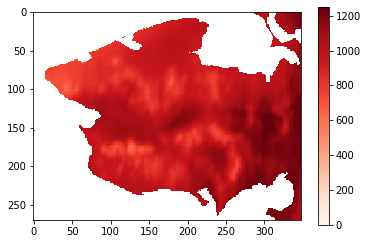

In [13]:
data = gdal.Open(os.path.join('tdd', 'tdd_2006.tif'))
plt.imshow(data.ReadAsArray(), cmap='Reds', vmin=0, vmax=1250)
plt.colorbar()

#### Notes on Resuming Calculations 

If you are worried that the caculations performed here may be interupted you can save the degree-day TemporalGrids before calling `ddc.calc_degree_days.calc_gird_degree_days`, by using the `.save` method. The `.save` method save the Temporal Grid as a `.mgdata` (the data) and `.yml` (the metadata) file Now if the function is intrupeted you can reload the data using `ddc.multigrids.TemporalGrid`.

In [ ]:
# save 
fdd_data.save('fdd.yml') ## pass the metadata name as the save name
tdd_data.save('tdd.yml')

# load

fdd_data = TemporalGrid('fdd.yml') ## load by passing the metadata name
tdd_data = TemporalGrid('tdd.yml')